In [1]:
import sys
sys.path.insert(1,'../src/')


In [2]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as onp
import numpy as np
import copy
import os
import time
#from google.cloud import storage
from datetime import timedelta, timezone, datetime
import zarr
#from google.cloud import storage
import pickle5
import pickle
import pandas as pd
from datetime import datetime, timedelta
#import fsspec
#from gcsfs import GCSFileSystem
from tqdm import tqdm, notebook
#from google.cloud import bigquery
import seaborn as sns
import jax
import jax.numpy as jnp
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, mean_squared_error, log_loss
import scipy.special as scp
from sklearn.ensemble import RandomForestClassifier

from itertools import permutations, combinations
from scipy.stats import norm
from scipy.stats import wilcoxon
import math

from torch import nn
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian

import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms


%load_ext autoreload
%autoreload 2


In [3]:
import dataprep as dp


In [4]:
#from ANLSMN_genfuncs import *

In [5]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [6]:
A = np.array([[0, 1, 1], [1,0,0], [0,1,0]])
#A = onp.ones((3,3))
#A = onp.eye(3)
A

array([[0, 1, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [7]:
A.shape

(3, 3)

In [8]:
 
X = np.arange(30).reshape((10,3))
X.shape
#onp.random.normal(size=(10,3))

(10, 3)

In [9]:
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29]])

In [10]:
A

array([[0, 1, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [11]:
X.shape

(10, 3)

In [12]:
Xsel = [np.kron(X[:,k], A[k,:]).reshape(10,3).T for k in range(A.shape[0])]
np.array(Xsel).shape

(3, 3, 10)

In [13]:
Xsel = np.transpose(Xsel, (2,1,0))
Xsel.shape

(10, 3, 3)

In [14]:
Xsel[:,2,:]
# middle index contain variable
#adjacency matrix should be taken column wise: (var 2 depends on vari 1 and 3 as 3rd column codes)

array([[ 0,  0,  0],
       [ 3,  0,  0],
       [ 6,  0,  0],
       [ 9,  0,  0],
       [12,  0,  0],
       [15,  0,  0],
       [18,  0,  0],
       [21,  0,  0],
       [24,  0,  0],
       [27,  0,  0]])

In [15]:
W = np.random.normal(size=(3, 3,4))

In [16]:
Xsel.shape

(10, 3, 3)

In [17]:
W.shape

(3, 3, 4)

In [18]:
i = 0
np.transpose(np.array([(Xsel[:,:,i] @ W[i,:,:]) for i in range(W.shape[0])]),(1,2,0)).shape

(10, 4, 3)

# Load Data

In [19]:
ML_ready_root = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/data/"
#file = "Himawari_lazyload_dataset_keys_detection_v1.pkl"
file = "Himawari_lazyload_dataset_keys_prediction_v1.pkl"
#file = "Himawari_lazyload_dataset_keys_prediction_oracle_v1.pkl"

keys = pickle5.load( open( ML_ready_root+file, "rb" ) )
keys_image, keys_era5 = keys

In [20]:
keys = keys_era5

In [21]:
k0 = keys[1]["flag_then"][0]
k0

[True, True, False, False, True, True]

In [22]:
k0[1:len(k0)]

[True, False, False, True, True]

In [23]:
k0[0:(len(k0)-1)]

[True, True, False, False, True]

In [24]:
np.logical_not(k0[0:(len(k0)-1)])

array([False, False,  True,  True, False])

In [25]:
[k0[0]]+(np.array(k0[1:len(k0)])*np.logical_not(k0[0:(len(k0)-1)])).tolist()

[True, False, False, False, True, False]

In [26]:
def correctFlags(ks):
    return [ks[0]]+(np.array(ks[1:len(ks)])*np.logical_not(ks[0:(len(ks)-1)])).tolist()

In [27]:
i = 0
correctedFlags = [correctFlags(keys[1]["flag_then"][i]) for i in range(len(keys[1]["flag_then"]))]

In [28]:
np.sum(dp.flatten(keys[1]["flag_then"]))

1167

In [29]:
np.sum(dp.flatten(correctedFlags))

447

In [30]:
len(dp.flatten(correctedFlags))

6919

In [31]:
i = 0
indxKeep, = np.where([dp.flatten(correctedFlags)[i]==dp.flatten(keys[1]["flag_then"])[i] for i in range(len(dp.flatten(correctedFlags)))])

In [32]:
indxKeep.shape

(6199,)

In [33]:
#envVars = np.load(ML_ready_root+'env_era5_det_v1.npy')
envVars = np.load(ML_ready_root+'env_era5_pred_v1.npy')
#envVars = np.load(ML_ready_root+'env_era5_pred_oracle_v1.npy')
envVars.shape

(6919, 5)

In [34]:
envVars[0:5,]

array([[ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91506849, 2019.        ,
           0.        ]])

In [35]:
#cube = np.load(ML_ready_root+'x_image_det_v1.npy')
#labels = np.load(ML_ready_root+'y_image_det_v1.npy')
#cube = np.load(ML_ready_root+'x_image_pred_v1.npy')
#labels = np.load(ML_ready_root+'y_image_pred_v1.npy')

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_pred_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_pred_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_pred_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_25vs_pred_v1.npy')
cube = np.load(ML_ready_root+'xFeat_era5_25vs_pred_v2.npy')
labels = np.load(ML_ready_root+'y_era5_19vs_pred_v1.npy')
labs = labels.copy()

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_pred_oracle_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_pred_oracle_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_pred_oracle_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_19vs_pred_oracle_v1.npy')

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_det_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_det_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_det_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_19vs_det_v1.npy')

In [36]:
#cube = cube[:,0:66]
#cube = cube[:,66:99]
#cube = cube[:,66:275]

In [37]:
cube.shape

(6919, 318)

In [38]:
def allZero(x):
    return np.all(x==0)

indxZero, = np.where(np.apply_along_axis(allZero, 0, cube))
indxZero

array([], dtype=int64)

In [39]:
labels.shape

(6919,)

In [40]:
np.sum(labels)

1167

In [41]:
labels

array([1, 1, 0, ..., 0, 0, 0])

In [42]:
np.sum(np.isnan(cube))

0

In [43]:
11*9

99

In [44]:
11*25

275

In [45]:
11*6

66

In [46]:
def norml(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


In [47]:
def norml2(x):
    den = (np.nanmax(x)-np.nanmin(x))
    if den>0:
        #print("ya")
        res = (x-np.nanmin(x))/den
    else: 
        print("bla")
        res = x
    return res


In [48]:
def norml3(x,i):
    #print(i)
    minX = np.quantile(x[x>0], 0.01)
    maxX = np.quantile(x[x>0], 0.99)
    res = x
    res[x<=minX]=minX
    res[x>=maxX]=maxX
    res = (res-minX)/(maxX-minX)
    
    return  res

In [49]:
np.max(cube)

866571.1794800136

In [50]:
#np.quantile(cube[:,145], 0.01)

In [51]:
#sns.distplot(cube[:,145])

In [52]:
cube.shape

(6919, 318)

In [53]:
i = 0
cube = np.array([norml2(cube[:,i]) for i in range(cube.shape[1])])
cube = np.transpose(cube,[1,0])
cube.shape


(6919, 318)

In [54]:
#cube[np.isnan(cube)] = 0
np.sum(np.isnan(cube))

0

In [55]:
np.prod(cube.shape)

2200242

In [56]:
np.sum(np.isinf(cube))

0

In [57]:
25*11

275

In [58]:
#cube = np.transpose(np.array([norml(cube[:,i,:,:]) for i in range(cube.shape[1])]),[1,0,2,3])

In [59]:
event_ids = np.array(keys[1]["event_id"])[np.array(keys[0]["level1_key"])]

In [60]:
len(dp.flatten(keys[1]["full_flag_now"]))

6919

In [61]:
len(dp.flatten(keys[1]["flag_then"]))

6919

In [62]:
file = "wildfires.pkl"
wildfires = pickle5.load( open( ML_ready_root+file, "rb" ) )
wildfires.loc[pd.isnull(wildfires.wildfire_id),"wildfire_id"] = wildfires.loc[pd.isnull(wildfires.wildfire_id),"pyroCb_id"]

In [63]:
wildfires.head()

,pyroCb_id,pyroCb_date_utc,pyroCb_time_utc,pyroCb_longitude,pyroCb_latitude,country,region,satellite,wildfire_id,wildfire_ini_date_utc,wildfire_end_date_utc,length_days,wildfire_centroid_longitude,wildfire_centroid_latitude,extract_longitude,extract_latitude,extract_ini_date_utc,extract_end_date_utc,time_zone,length_fire
0,260,2022-06-11,2300.0,-155.6,63.3,US,Alaska,GOES,260,NaT,NaT,None,NaN,NaN,-155.600000,63.30000,2022-06-08 08:00:00+00:00,2022-06-14 08:00:00+00:00,America/Anchorage,6
1,258,2022-06-12,300.0,-153.4,63.8,US,Alaska,GOES,258,NaT,NaT,None,NaN,NaN,-153.400000,63.80000,2022-06-09 08:00:00+00:00,2022-06-15 08:00:00+00:00,America/Anchorage,6
2,265,2022-07-02,550.0,-149.7,65.5,US,Alaska,GOES,265,NaT,NaT,None,NaN,NaN,-149.700000,65.50000,2022-06-29 08:00:00+00:00,2022-07-05 08:00:00+00:00,America/Anchorage,6
3,259,2020-06-08,NaN,-149.6,65.9,US,Alaska,GOES,23353806,2020-06-05,2020-06-12,7,-149.536458,65.85841,-149.536458,65.85841,2020-06-05 08:00:00+00:00,2020-06-12 08:00:00+00:00,America/Anchorage,7
4,266,2022-07-02,719.0,-149.5,65.6,US,Alaska,GOES,266,NaT,NaT,None,NaN,NaN,-149.500000,65.60000,2022-06-29 08:00:00+00:00,2022-07-05 08:00:00+00:00,America/Anchorage,6


In [64]:
pyrocb_id = [int(ei.split("_")[0]) for ei in event_ids.tolist()]

In [65]:
event_df = pd.DataFrame({"pyrocb_id":pyrocb_id, "event_id":event_ids, "full_flag_now":dp.flatten(keys[1]["full_flag_now"]), "flag_then":dp.flatten(keys[1]["flag_then"])})
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then
0,114,114_28,3,True
1,114,114_28,3,True
2,114,114_28,4,False
3,114,114_28,3,False
4,114,114_28,3,True


In [66]:
event_df = event_df.merge(wildfires[["pyroCb_id","wildfire_id"]], how="left", left_on="pyrocb_id", right_on="pyroCb_id")
event_df.shape

(6919, 6)

In [67]:
event_df = pd.concat([event_df, pd.DataFrame(envVars,columns=["lon","lat","date","year","sat"])], axis=1)
event_df.shape

(6919, 11)

In [68]:
indx, = np.where(event_df.full_flag_now<4)
indx.shape

(6608,)

In [69]:
# exlcude pyrocbs now
#cube = cube[indx,]
#labels = labels[indx,]
#envVars = envVars[indx,]
#event_df = event_df.iloc[indx]
cube.shape

(6919, 318)

In [70]:
seg_base = event_df.drop_duplicates('wildfire_id')
seg_base.shape

(83, 11)

In [71]:
# GOES = 1, HIMAWARI = 0
seg_base[["pyrocb_id","sat"]].groupby(["sat"]).count()

,pyrocb_id
sat,
0.0,31
1.0,52


In [72]:
# GOES = 1, HIMAWARI = 0
seg_base[["pyrocb_id","sat","year"]].groupby(["sat","year"]).count()

pyrocb_id
sat year             
0.0 2019.0         24
    2020.0          4
    2021.0          3
1.0 2018.0          5
    2021.0         47

In [73]:
seg_base[["sat","lon","lat","date"]].head()

,sat,lon,lat,date
0,0.0,151.985555,-31.589875,2019.912329
6,0.0,151.956344,-32.318750,2019.890411
11,0.0,123.520000,-32.050000,2021.063014
17,0.0,150.218571,-35.233573,2020.013699
23,1.0,-119.806857,37.629127,2018.539726


In [74]:
def stdze(x):
    return (x-np.mean(x))/np.std(x)

In [75]:
def addCluster(seg_base, num_clusters,seed):
    np.random.seed(seed=seed)
    rnds = np.floor(np.arange(0,seg_base.shape[0])/9).astype(int)
    #seg_base2 = seg_base[["sat","lon","lat","date"]].to_numpy()
    seg_base2 = seg_base[["sat","lon","lat"]].to_numpy()
    seg_base2 = np.array([stdze(seg_base2[:,i]) for i in range(seg_base2.shape[1])]).T
    N = seg_base2.shape[0]
    cluster_size = N//num_clusters
    print("cluster size: ", cluster_size)
    labs = -1*np.ones(N)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(seg_base2)
    grps = kmeans.labels_
    ids, cnt = np.unique(grps, return_counts=True)
    print(pd.DataFrame({"cluster":ids,"count":cnt}))
    o = np.argsort(cnt)
    DistMat = kmeans.fit_transform(seg_base2)
    
    # initialize
    indx_obs = np.arange(seg_base2.shape[0]).tolist()
    indx_cluster = ids[o][::-1].tolist()
    
    # loop through clusters from smallest to largest
    for i in range(len(indx_obs)):
        #print("i: ", i)
        o2 = np.argsort(DistMat[indx_obs,indx_cluster[0]])
        indx_lab = np.array(indx_obs)[o2[0]]
        labs[indx_lab] = indx_cluster[0]
        indx_cluster.pop(0)
        if len(indx_cluster)==0:
            indx_cluster = ids[o][::-1].tolist()
        indx_obs = list(set(indx_obs).difference([indx_lab]))
    
    
    #seg_base["cluster"]=np.array(labs).astype(int)
    seg_base["cluster_regional"]=np.array(grps).astype(int)
    seg_base["cluster_random"]=np.array(rnds).astype(int)
    return seg_base, seg_base2

In [76]:
seg_base.shape[0]

83

In [77]:
rand = np.floor(np.arange(0,seg_base.shape[0])/9).astype(int)
cnt, uni = np.unique(rand, return_counts=True)
{"cnt":cnt, "uni":uni}

{'cnt': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'uni': array([9, 9, 9, 9, 9, 9, 9, 9, 9, 2])}

In [78]:
83/5

16.6

In [79]:
num_clusters=10
seed = 123456
seg_base, X = addCluster(seg_base, num_clusters=num_clusters, seed=seed)

cluster size:  8
   cluster  count
0        0     13
1        1      6
2        2     17
3        3      6
4        4      7
5        5     12
6        6      3
7        7      1
8        8     10
9        9      8


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
cluster_var = "cluster_random"
seg_base[["pyrocb_id",cluster_var]].groupby(cluster_var).count()

,pyrocb_id
cluster_random,
0,9
1,9
2,9
3,9
4,9
5,9
6,9
7,9
8,9


In [81]:
metrics.silhouette_score(X, seg_base[cluster_var], metric='euclidean')

-0.5407356378963465

In [82]:
N = seg_base.shape[0]
cluster_size = N//num_clusters

rand_labs = np.arange(seg_base.shape[0])
rand_labs = (rand_labs//cluster_size)%num_clusters
indx = np.random.choice(seg_base.shape[0], size=seg_base.shape[0], replace=False)
rand_labs = rand_labs[indx]

In [83]:
metrics.silhouette_score(X, rand_labs, metric='euclidean')

-0.39321371451815135

In [84]:
seg_base.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0
6,171,171_8,2,False,171,22810493,151.956344,-32.318750,2019.890411,2019.0,0.0,3,0
11,126,126_5,1,False,126,126,123.520000,-32.050000,2021.063014,2021.0,0.0,9,0
17,91,91_46,3,False,91,22810914,150.218571,-35.233573,2020.013699,2020.0,0.0,0,0
23,163,163_5,2,True,163,21121935,-119.806857,37.629127,2018.539726,2018.0,1.0,5,0


In [85]:
results_root = "/home/jupyter/ML_ready/results/"
typee = "random"
fileRes = results_root+typee+"_clustering.png"
fileRes

'/home/jupyter/ML_ready/results/random_clustering.png'

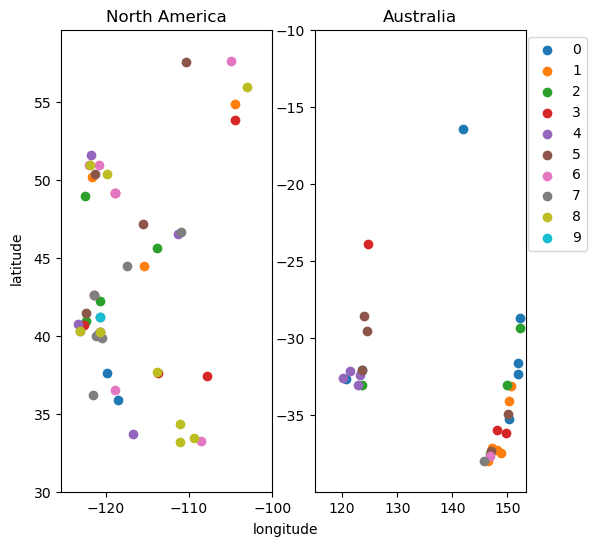

In [86]:
i = 0
fig, ax = plt.subplots(1, 2, figsize=(6, 6))  # setup the plot
for i in np.unique(seg_base[cluster_var]):
    scat1 = ax[0].scatter(seg_base.loc[seg_base[cluster_var]==i]["lon"], seg_base.loc[seg_base[cluster_var]==i]["lat"], label=i)#, s=date_norm
    scat1 = ax[1].scatter(seg_base.loc[seg_base[cluster_var]==i]["lon"], seg_base.loc[seg_base[cluster_var]==i]["lat"], label=i)
ax[0].set_xlim([np.min(seg_base["lon"])-2, -100])
ax[0].set_ylim([30,np.max(seg_base["lat"])+2])

ax[1].set_xlim([115,np.max(seg_base["lon"])+1])
ax[1].set_ylim([np.min(seg_base["lat"])-2, -10])


fig.text(0.5, 0.04, 'longitude', ha='center')
fig.text(0.04, 0.5, 'latitude', va='center', rotation='vertical')



ax[0].set_title('North America')
ax[1].set_title('Australia')
ax[1].legend(bbox_to_anchor=(1.32, 1.0))
#plt.savefig(fileRes, format='png', dpi=300)


In [87]:
event_df = event_df.merge(seg_base[["wildfire_id","cluster_regional","cluster_random"]], how="left",on="wildfire_id")

In [88]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,3,0


In [89]:
event_df[["pyrocb_id",cluster_var]].groupby(cluster_var).count()

,pyrocb_id
cluster_random,
0,1344
1,1436
2,1156
3,800
4,957
5,493
6,289
7,246
8,157


In [90]:
event_df.shape

(6919, 13)

In [91]:
#file = "/home/jupyter/elevation/alwdgg.tif"
#da = xr.open_rasterio(file)
#alt = [da.interp(x=event_df.iloc[i].lon, y = event_df.iloc[i].lat, method="linear").values[0] for i in range(event_df.shape[0])]

In [92]:
#event_df["altitude"] = alt
#def meanAlt(x):
#    return np.mean(x.altitude)
#event_df[["pyrocb_id","cluster","altitude"]].groupby("cluster").apply(meanAlt)

In [93]:
print(envVars.shape)
print(cube.shape)
print(labels.shape)
print(len(keys[0]["level1_key"]))

(6919, 5)
(6919, 318)
(6919,)
6919


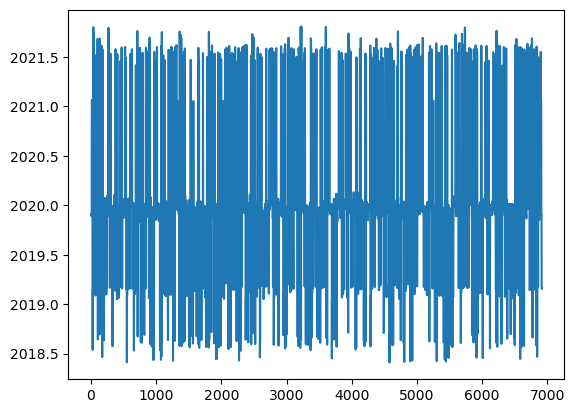

In [94]:
plt.plot(envVars[:,2])

In [95]:
mu_env = [np.mean(envVars[:,i]) for i in range(envVars.shape[1])]
sigma_env = [np.std(envVars[:,i]) for i in range(envVars.shape[1])]

In [96]:
mu_env

[82.03730074296445,
 -15.836401755772682,
 2019.9820624961642,
 2019.45281109987,
 0.23023558317675966]

In [97]:
sigma_env

[110.63039472732746,
 32.406044911163136,
 0.8347076386002498,
 0.8607601604282905,
 0.42098356193088715]

In [98]:
satellite_list = dp.flatten(keys[1]["satellite"])

In [99]:
satellite_list = np.array(satellite_list)

In [100]:
event_ids = np.array(keys[1]["event_id"])[np.array(keys[0]["level1_key"])]

In [101]:
aux = [(e,v) for (e,v) in zip(event_ids.astype(float), envVars[:,2])]

In [102]:
aux = np.array( aux, dtype=[('x', 'float'), ('y', 'float')])
aux.shape


(6919,)

In [103]:
o = np.argsort(aux, order=('x','y'))


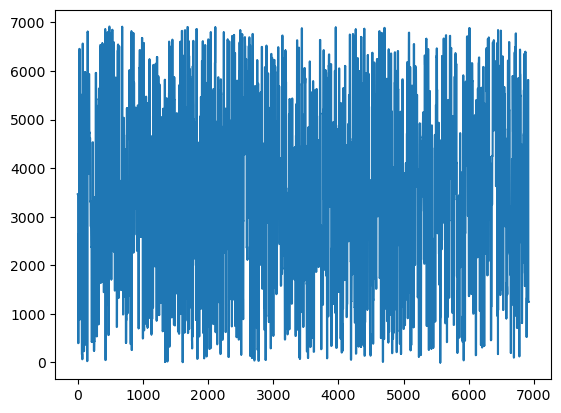

In [104]:
plt.plot(o)

In [105]:
event_ids[o]

array(['63_1', '63_1', '63_1', ..., '172_18', '172_18', '172_18'],
      dtype='<U6')

In [106]:
envVars[o,2]

array([2019.04657534, 2019.04657534, 2019.04657534, ..., 2020.02739726,
       2020.02739726, 2020.02739726])

In [107]:
#o = np.argsort(envVars[:,2])
#envVars = envVars[o,:]
#cube = cube[o,:]
#labels = labels[o]
#satellite_list = satellite_list[o]
#event_df= event_df.iloc[o]

In [108]:

#envVars = envVars[indxKeep,:]
#cube = cube[indxKeep,:]
#labels = labels[indxKeep]
#satellite_list = satellite_list[indxKeep]
#event_df= event_df.iloc[indxKeep]

In [109]:
cube.shape

(6919, 318)

In [110]:
cube.shape

(6919, 318)

In [111]:
event_df.shape

(6919, 13)

In [112]:
np.sum(event_df.flag_then)

1167

In [113]:
np.sum(labels)

1167

In [114]:
event_df[["flag_then",cluster_var,"pyrocb_id"]].groupby([cluster_var,"flag_then"]).count()

pyrocb_id
cluster_random flag_then           
0              False           1099
               True             245
1              False           1255
               True             181
2              False            996
               True             160
3              False            657
               True             143
4              False            855
               True             102
5              False            390
               True             103
6              False            211
               True              78
7              False            147
               True              99
8              False            106
               True              51
9              False             36
               True               5

In [115]:
event_df[["flag_then","full_flag_now","pyrocb_id"]].groupby(["full_flag_now","flag_then"]).count()

pyrocb_id
full_flag_now flag_then           
0             False            207
              True               4
1             False           3025
              True             192
2             False           1122
              True             283
3             False           1203
              True             572
4             False            195
              True             116

In [116]:
# cluster, wildfire_id, red_flag_now, flag_then

In [117]:
event_df[["pyrocb_id","full_flag_now"]].groupby("full_flag_now").count()

,pyrocb_id
full_flag_now,
0,211
1,3217
2,1405
3,1775
4,311


In [118]:
mydict = {0:"none", 1:"none", 2:"conv", 3:"deep conv",4:"pyrocb"}

In [119]:
event_df["red_flag_now"] =event_df["full_flag_now"].replace(mydict)
event_df[["pyrocb_id","red_flag_now"]].groupby("red_flag_now").count()

,pyrocb_id
red_flag_now,
conv,1405
deep conv,1775
none,3428
pyrocb,311


In [120]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random,red_flag_now
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,pyrocb
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,3,0,deep conv


In [121]:
#cluster = 0
#event_df_clus = event_df.loc[event_df.cluster==cluster]
tab = event_df[["cluster_regional","cluster_random","pyrocb_id","wildfire_id","red_flag_now","flag_then"]].groupby([cluster_var,"wildfire_id","red_flag_now","flag_then"]).count()

In [122]:
np.all(tab.to_numpy()>0)

True

In [123]:
tab = tab.reset_index().rename(columns={"pyrocb_id":"freq"})

In [124]:
np.max(tab.freq)

278

In [125]:
np.max(tab.freq)*tab.shape[0]

117038

In [126]:
tab["weight"]= 1/tab.freq

In [127]:
tab.head()

,cluster_random,wildfire_id,red_flag_now,flag_then,cluster_regional,freq,weight
0,0,126,conv,False,7,7,0.142857
1,0,126,deep conv,False,8,8,0.125000
2,0,126,deep conv,True,1,1,1.000000
3,0,126,none,False,16,16,0.062500
4,0,126,pyrocb,False,4,4,0.250000


In [128]:
event_df = event_df.merge(tab[["cluster_regional","cluster_random","wildfire_id","red_flag_now","flag_then","weight"]], how="left", on=["cluster_regional","cluster_random","wildfire_id","red_flag_now","flag_then"])

In [129]:
mu = [np.mean(cube[:,i]) for i in range(cube.shape[1])]
sigma = [np.std(cube[:,i]) for i in range(cube.shape[1])]

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
#X_train, X_val, y_train, y_val = train_test_split(big_datacube, flag_list, test_size=0.20, random_state=42, stratify=None, shuffle=False)
#y_val.shape

In [132]:
cutoff = int(envVars.shape[0]*0.8)
cutoff

5535

In [133]:
cube.shape

(6919, 318)

In [134]:
np.sum(np.isnan(cube))

0

In [135]:
# By satellite and day
#indx1,  = np.where(satellite_list != "Himawari")
#num_rem = int(cube.shape[0]*0.2)-indx1.shape[0]
#print(num_rem )
#indx2, = np.where(satellite_list == "Himawari")
#indx2 = indx2[0:num_rem]
#indx_val = np.hstack([indx1, indx2])
#indx_val.shape

In [136]:
# by event_id and date
#indx_val = np.arange(cutoff, envVars.shape[0])
#indx_val

In [137]:
np.unique(event_df.cluster_random, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1344, 1436, 1156,  800,  957,  493,  289,  246,  157,   41]))

In [138]:
#by cluster
cluster = 3
cluster_var = "cluster_random"
indx_val, =  np.where(event_df[cluster_var]==cluster)

In [139]:
# by event_id: choose until you breach 20%

In [140]:
indx_train = np.array(list(set(np.arange(0, cube.shape[0])).difference(indx_val)))

In [141]:
cube.shape

(6919, 318)

In [142]:
envVars = np.apply_along_axis(norml,0,envVars)

In [143]:
X_train = cube[indx_train,:]
X_val = cube[indx_val,:]
y_train = labels[indx_train]
y_val = labels[indx_val]
Env_train = envVars[indx_train,0:3]
Env_val = envVars[indx_val,0:3]
y_val.shape

(800,)

In [144]:
met_varss = ["u10", "v10", "fg10", "blh", "cape", "cin", "z", "slhf", "sshf", "w", "u", "v", "cvh", "cvl", "tvh", "tvl", "r650", "r750", "r850","uv10", "uv250", "alt", "typeH", "typeL"]
img_varss = ["ch1","ch2","ch3","ch4","ch5","ch6"]
varss = img_varss+met_varss

In [145]:
#indxIncl = [0,1,2,6,8,10,12,13,18,23,26,29]
#indxIncl = [0,2,6,10,12,18,26,29]
indxIncl = [i for i in range(len(varss))]

print(len(indxIncl))
np.array(varss)[indxIncl]

30


array(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'u10', 'v10', 'fg10',
       'blh', 'cape', 'cin', 'z', 'slhf', 'sshf', 'w', 'u', 'v', 'cvh',
       'cvl', 'tvh', 'tvl', 'r650', 'r750', 'r850', 'uv10', 'uv250',
       'alt', 'typeH', 'typeL'], dtype='<U5')

In [146]:
cube.shape[1]

318

In [147]:
posts2 =np.arange(0,cube.shape[1]+1-10, 11)
posts2 = np.array(posts2.tolist()+[posts2[posts2.shape[0]-1]+4,posts2[posts2.shape[0]-1]+10])
posts2

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 312, 318])

In [148]:
# remove tvh and tvl
indx_tvh, = np.where(np.array(varss)=="tvh")
indx_tvl, = np.where(np.array(varss)=="tvl")
indx_rem = [indx_tvh[0], indx_tvl[0]]
indx_rem

[20, 21]

In [149]:
len(indxIncl)

30

In [150]:
# remove tvh and tvl
if True:
    indxIncl.pop(indx_rem[1])
    indxIncl.pop(indx_rem[0])
print(len(indxIncl))
indxIncl

28


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [151]:
posts2.shape

(31,)

In [152]:
indxIncl2 = np.array(dp.flatten([np.arange(posts2[i], posts2[i+1]).tolist() for i in indxIncl]))
indxIncl2

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [153]:
X_train = X_train[:, indxIncl2]
X_val = X_val[:, indxIncl2]


In [154]:
posts =np.arange(0,X_train.shape[1]+1-10, 11)
posts = np.array(posts.tolist()+[posts[posts.shape[0]-1]+4,posts[posts.shape[0]-1]+10])
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 290, 296])

In [155]:
X_train.shape

(6119, 296)

In [156]:
event_df.shape

(6919, 15)

In [157]:
labels.shape

(6919,)

In [158]:
event_df_train = event_df.iloc[indx_train]
event_df_val = event_df.iloc[indx_val]

In [159]:
envVars[0:10,]

array([[0.99864882, 0.06690834, 0.44193548, 0.33333333, 0.        ],
       [0.99864882, 0.06690834, 0.44193548, 0.33333333, 0.        ],
       [0.99864882, 0.06690834, 0.44193548, 0.33333333, 0.        ],
       [0.99864882, 0.06690834, 0.44193548, 0.33333333, 0.        ],
       [0.99864882, 0.06690834, 0.44274194, 0.33333333, 0.        ],
       [0.99864882, 0.06690834, 0.44274194, 0.33333333, 0.        ],
       [0.99854286, 0.05928723, 0.43548387, 0.33333333, 0.        ],
       [0.99854286, 0.05928723, 0.43548387, 0.33333333, 0.        ],
       [0.99854286, 0.05928723, 0.43548387, 0.33333333, 0.        ],
       [0.99854286, 0.05928723, 0.43629032, 0.33333333, 0.        ]])

## 2 | Make Dataloaders 

In [160]:
class HimawariDataset2(torch.utils.data.Dataset):
    def __init__(self, dataset_cubes, envs, flags, transform=None, target_transform=None):
        self.img_labels = flags
        self.img_cubes = dataset_cubes
        self.envs = envs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #print(self.img_cubes.shape)
        image = np.moveaxis(self.img_cubes[idx], 0, -1)
        label = self.img_labels[idx]
        #label = int(self.img_labels[idx])
        envs = np.moveaxis(self.envs[idx], 0, -1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            #label = self.target_transform(label)
            label = self.transform(label)
        return image, envs, label

In [161]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64*2

In [162]:
trainset = HimawariDataset2(X_train, Env_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  num_workers=0)#shuffle=True,


In [163]:
testset = HimawariDataset2(X_val, Env_val, y_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  num_workers=2, shuffle=False) #shuffle=False,

In [164]:
traintestset = HimawariDataset2(cube[:,indxIncl2], envVars[:,0:3], labs)
traintestloader = torch.utils.data.DataLoader(traintestset, batch_size=batch_size,  num_workers=0) #shuffle=False,

In [165]:
Env_val.shape

(800, 3)

In [166]:
labs.shape

(6919,)

In [167]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from scipy.stats import wilcoxon
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor


def getTestPreds(cube, labels, cluster_var, cluster, numTrees=100, envVar=None):
    
    
    
    #print("cluster: ", cluster)
    indx_val, =  onp.where(cluster_var==cluster)
    indx_train = onp.array(list(set(np.arange(0, cube.shape[0])).difference(indx_val)))
    
    
    
    
    
    X_train = cube[indx_train,:]
    X_val = cube[indx_val,:]
    y_train = labels[indx_train]
    y_val = labels[indx_val]
    
    
    if envVar is not None:
        #print("adds env vars<")
        envVar_train = envVar[indx_train,]
        envVar_val = envVar[indx_val,]
        X_train = onp.concatenate([X_train, envVar_train], axis=1)
        X_val = onp.concatenate([X_val, envVar_val], axis=1)
    #else:
        #print("no env vars")
    
    #reg = GradientBoostingRegressor(random_state=0, n_estimators=numTrees)
    reg = RandomForestRegressor(n_estimators=numTrees, max_depth=None,  random_state=0)
    #kernel = RBF()+WhiteKernel()
    #reg = GaussianProcessRegressor(kernel=kernel)

     
    #reg = MLPRegressor(random_state=1, max_iter=1000)
    #reg = MLPRegressor(random_state=1, learning_rate_init=0.001,batch_size=250, alpha=0.1, early_stopping=True,  max_iter=100,hidden_layer_sizes=(5,5,5))
    
    
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    return y_pred

def getTestProbs(cube, labels, cluster_var, cluster, numTrees=100, envVar=None):
    
    
    
    #print("cluster: ", cluster)
    indx_val, =  onp.where(cluster_var==cluster)
    indx_train = onp.array(list(set(np.arange(0, cube.shape[0])).difference(indx_val)))
    
    #print(cube.shape)
    #print("indx_val",indx_val)
    #print("indx_train",indx_train)
    
    
    X_train = cube[indx_train,:]
    X_val = cube[indx_val,:]
    y_train = labels[indx_train]
    y_val = labels[indx_val]
    
    if envVar is not None:
        #print("adds env vars<")
        envVar_train = envVar[indx_train,]
        envVar_val = envVar[indx_val,]
        X_train = onp.concatenate([X_train, envVar_train], axis=1)
        X_val = onp.concatenate([X_val, envVar_val], axis=1)
    #else:
        #print("no env vars")
    

    #, max_depth=10
    clf = RandomForestClassifier(n_estimators=numTrees,  class_weight="balanced_subsample", random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_val)
    
    return y_pred[:,1]
    
    


def getTestPredsWrapper(x, labels, cluster_var,  numTrees=100, envVar=None):
    
    
    clusts = onp.sort(np.unique(cluster_var))
    y_preds = [getTestPreds(x, labels, cluster_var, i, numTrees=numTrees, envVar=envVar) for i in clusts]
    y_pred = onp.zeros(x.shape[0])
    for i in clusts:
        indx_val, =  onp.where(cluster_var==i)
        y_pred[indx_val] = y_preds[int(i)]
    return y_pred


def getTestProbsWrapper(x, labels, cluster_var,  numTrees=100, envVar=None):
    
    
    clusts = onp.sort(np.unique(cluster_var))
    y_preds = [getTestProbs(x, labels, cluster_var, i, numTrees=numTrees, envVar=envVar) for i in clusts]
    
    #print([y_pr.shape for y_pr in y_preds])
    
    y_pred = onp.zeros(x.shape[0])
    for i in clusts:
        indx_val, =  onp.where(cluster_var==i)
        y_pred[indx_val] = y_preds[int(i)]
    return y_pred



def getHypWrapperReg(x, labels, envVar, cluster_var, numTrees=100):
    y_pred_noE = getTestPredsWrapper(x, labels, cluster_var,  numTrees=numTrees)
    y_pred_E = getTestPredsWrapper(x, labels,  cluster_var,  numTrees=numTrees, envVar=envVar)
    res = wilcoxon(y_pred_noE, y=y_pred_E)
    return res.pvalue

def equalAUC_hypTest(y_pred_noE, y_pred_E, labels):
    #print("equal preds?: ",onp.all(y_pred_noE==y_pred_E))
    # without E
    y_pred1 = y_pred_noE[labels==1]
    y_pred0 = y_pred_noE[labels==0]
    Phi = (y_pred1[:,None] > y_pred0[None,:])
    VT_noE_1 = (1/(y_pred0.shape[0]-1))*onp.apply_along_axis(onp.sum, 1, Phi)
    VT_noE_0 = (1/(y_pred1.shape[0]-1))*onp.apply_along_axis(onp.sum, 0, Phi)
    A_noE = (onp.sum(VT_noE_1)/VT_noE_1.shape[0]+onp.sum(VT_noE_0)/VT_noE_0.shape[0])/2
    print("auc without E:",A_noE)
    ST_noE_1 = (VT_noE_1-A_noE)**2
    ST_noE_1 = onp.sum(ST_noE_1)/(ST_noE_1.shape[0]-1)
    ST_noE_0 = (VT_noE_0-A_noE)**2
    ST_noE_0 = onp.sum(ST_noE_0)/(ST_noE_0.shape[0]-1)
    VA_noE = (ST_noE_1/VT_noE_1.shape[0])+(ST_noE_0/VT_noE_0.shape[0])
    #print("VA_noE: ", VA_noE)
    # with E
    y_pred1 = y_pred_E[labels==1]
    y_pred0 = y_pred_E[labels==0]
    Phi = (y_pred1[:,None] > y_pred0[None,:])
    VT_E_1 = (1/(y_pred0.shape[0]-1))*onp.apply_along_axis(np.sum, 1, Phi)
    VT_E_0 = (1/(y_pred1.shape[0]-1))*onp.apply_along_axis(np.sum, 0, Phi)
    A_E = (onp.sum(VT_E_1)/VT_E_1.shape[0]+onp.sum(VT_E_0)/VT_E_0.shape[0])/2
    print("auc with E: ",A_E)
    ST_E_1 = (VT_E_1-A_E)**2
    ST_E_1 = onp.sum(ST_E_1)/(ST_E_1.shape[0]-1)
    ST_E_0 = (VT_E_0-A_E)**2
    ST_E_0 = onp.sum(ST_E_0)/(ST_E_0.shape[0]-1)
    VA_E = (ST_E_1/VT_E_1.shape[0])+(ST_E_0/VT_E_0.shape[0])
    #print("VA_E: ", VA_E)
    # Covariance
    ST_EnoE_1  = (VT_noE_1-A_noE)*(VT_E_1-A_E)
    ST_EnoE_1 = onp.sum(ST_EnoE_1)/(ST_EnoE_1.shape[0]-1)
    ST_EnoE_0  = (VT_noE_0-A_noE)*(VT_E_0-A_E)
    ST_EnoE_0 = onp.sum(ST_EnoE_0)/(ST_EnoE_0.shape[0]-1)
    COV_EnoE = (ST_EnoE_1/VT_E_1.shape[0])+(ST_EnoE_0/VT_E_0.shape[0])
    #print("COV_EnoE: ", COV_EnoE)
    # Statistic
    V_noE_E = VA_noE + VA_E - 2*COV_EnoE
    #print("V_noE_E: ", V_noE_E)
    z = (A_E-A_noE)/onp.sqrt(V_noE_E)
    # H0: with E is not better -> A_E-A_noE is not large
    pval1tail = 1-norm.cdf(z)
    # H0: neither model is better
    pval2tail = (1-norm.cdf(np.abs(z)))+norm.cdf(-np.abs(z))
    res = {"stat":z, "pval_1tail":pval1tail, "pval_2tail":pval2tail,"auc_E":A_E, "auc_noE":A_noE}
    if A_noE==A_E:
        pval1tail = onp.random.uniform(size=1)[0]
    print("pval: ", pval1tail)    
    return pval1tail, z

def getHypWrapperClf(x, labels, envVar, cluster_var, numTrees=100):
    y_pred_noE = getTestProbsWrapper(x, labels, cluster_var,  numTrees=numTrees)
    y_pred_E = getTestProbsWrapper(x, labels,  cluster_var,  numTrees=numTrees, envVar=envVar)
    res = equalAUC_hypTest(y_pred_noE, y_pred_E, labels)
    return res


In [168]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random,red_flag_now,weight
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,pyrocb,NaN
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,3,0,deep conv,NaN


In [169]:
X = X_train
y_train = y_train[:,None]
y = y_train
Env = Env_train

In [170]:
y.shape

(6119, 1)

In [171]:
X.shape

(6119, 296)

In [172]:
Env.shape

(6119, 3)

In [173]:
num_clusts = 2
smpl = np.random.choice(X.shape[0], size=1000)
cluster_var = event_df_train.iloc[smpl].cluster_random
np.unique(cluster_var, return_counts=True)

(array([0, 1, 2, 4, 5, 6, 7, 8, 9]),
 array([235, 229, 181, 159,  83,  40,  42,  26,   5]))

In [174]:
cluster_var.shape

(1000,)

In [175]:
#getHypWrapperClf(X[smpl,:], y[smpl,0], Env[smpl,:], cluster_var, numTrees=100)

In [176]:
#getHypWrapperClf(X[:,[0,1]][smpl,:], y[smpl,0], Env[smpl,:], cluster_var, numTrees=100)

In [177]:
#getHypWrapperClf(X[:,[0,1,3]][smpl,:], y[smpl,0], Env[smpl,:], cluster_var, numTrees=100)

In [178]:
#getHypWrapperClf(X[:,[0,1,2,4]][smpl,:], y[smpl,0], Env[smpl,:], cluster_var, numTrees=100)

In [179]:
Y = np.hstack([y, y**2])
Y.shape

(6119, 2)

In [180]:
#Y = np.apply_along_axis(norml, 0, Y)

In [181]:
Y

array([[1, 1],
       [1, 1],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [182]:
np.apply_along_axis(np.min,0,Y)

array([0, 0])

In [183]:
N = X.shape[0]
num_train = int(N*0.8)
num_train

4895

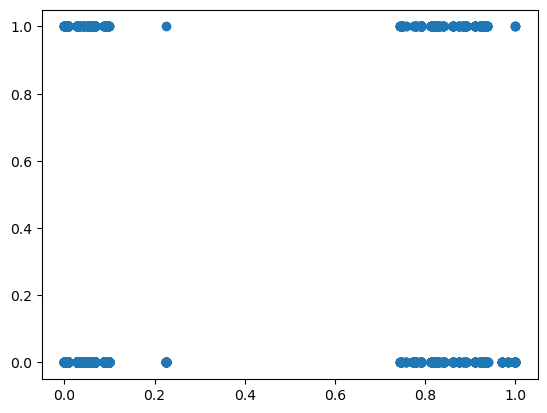

In [184]:
plt.scatter(Env_train[:,1], y_train[:,0])

In [185]:
Env_train.shape

(6119, 3)

In [186]:
y_train.shape

(6119, 1)

In [187]:
np.corrcoef(Env_train[:,1], y_train[:,0])

array([[1.       , 0.2802608],
       [0.2802608, 1.       ]])

In [188]:
inputs, envs, labels =  next(iter(trainloader))

In [189]:
inputs.shape

torch.Size([128, 296])

In [190]:
envs.shape

torch.Size([128, 3])

In [191]:
labels.shape

torch.Size([128])

# Architecture

In [192]:
class NN1_input(nn.Module):
    def __init__(self, num_inputs_in, num_out_tot):
        super().__init__()
        funnel = np.linspace(num_inputs_in, num_out_tot, 4, dtype=int)
        #funnel = np.linspace(num_inputs_in, num_out_tot, 2, dtype=int)
        print("funnel nn1 input: ", funnel)
        self.fc1 = nn.Linear(funnel[0], funnel[1])
        self.fc2 = nn.Linear(funnel[1] , funnel[2])
        self.fc3 = nn.Linear(funnel[2], funnel[3])
        
        
    def forward(self, input1):
        #print("input1 shape",input1.shape)
        #print("input1 indx shape",input1[...,0,:].shape)
        #print("env_variables shape",env_variables.shape)
        x = F.relu(self.fc1(input1))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        #x = F.relu(torch.nn.utils.prune.l1_unstructured(self, "fc1", 3).fc1(input1))
        
        #print("x shape:", x.shape)

        
        #print("input1 first channel + env shape:" , x.shape)              
        #x = F.relu(self.fc2(x))
        #print("hidden shape: ", x.shape)
        #x = F.relu(self.fc3(x))
        
        
        return  x

In [193]:
batch_size = 64*2
num_inputs_in = X.shape[1]
num_out_tot = 10#.shape[1]//2
print("num inputs candidate causes:", num_inputs_in)
print("num inputs candidate causes:", num_out_tot)
f = NN1_input(num_inputs_in, num_out_tot) #torch.jit.script(NN1())
test = torch.rand(batch_size, num_inputs_in)
z = f(test)
print(z.shape)


num inputs candidate causes: 296
num inputs candidate causes: 10
funnel nn1 input:  [296 200 105  10]
torch.Size([128, 10])


In [194]:
num_inputs_in

296

In [195]:
num_out_tot

10

In [196]:
test.shape

torch.Size([128, 296])

In [197]:
z.shape

torch.Size([128, 10])

In [198]:
f.fc1.weight.shape

torch.Size([200, 296])

In [199]:
f.fc1.bias

Parameter containing:
tensor([ 4.1932e-02,  2.6552e-02,  1.2810e-03, -3.8025e-02, -4.3836e-02,
        -1.9857e-02,  1.9231e-02, -5.0035e-02, -1.9598e-02,  4.4303e-02,
        -5.2929e-02,  4.0003e-02, -3.0974e-02, -2.0686e-02,  5.6651e-02,
         4.0214e-02,  2.3325e-02, -2.0305e-02, -2.4868e-02,  4.5679e-02,
         1.0097e-02, -3.2438e-02,  3.6340e-03,  2.7056e-02, -2.6688e-03,
        -3.1589e-02,  2.2095e-02, -4.2283e-02, -1.4856e-02,  3.9604e-02,
        -5.3561e-03,  3.7979e-02, -4.7797e-02, -7.8949e-04,  1.5429e-02,
         3.6340e-02, -8.0689e-03,  5.1894e-02,  3.3105e-02,  2.1018e-03,
        -2.3586e-02, -2.4837e-02, -1.1440e-02, -2.8897e-02,  3.7205e-02,
         2.3399e-02,  1.2302e-02, -4.4173e-02, -4.6485e-02, -4.5579e-02,
         5.2437e-02,  5.5022e-02,  7.1278e-03,  1.3416e-02, -5.3252e-02,
         2.8994e-02,  1.3193e-02, -6.1821e-03, -3.7789e-02,  4.3373e-02,
        -4.5099e-02,  1.5715e-02,  3.1331e-03, -1.0951e-02, -5.3161e-02,
         3.2192e-02, -3.4942e

In [200]:
(test.detach().numpy() @ f.fc1.weight.detach().numpy().T)+f.fc1.bias.detach().numpy()

array([[-0.05119608,  0.18829131,  0.689334  , ..., -0.5185785 ,
        -0.19660577,  0.24000148],
       [ 0.15368533,  0.01949772,  0.24129029, ..., -0.71700317,
        -0.05045848,  0.32404622],
       [ 0.16533348, -0.10395865,  0.5020169 , ..., -0.44872963,
        -0.19084111,  0.243512  ],
       ...,
       [ 0.2968456 ,  0.07850824,  0.60700595, ..., -0.43654224,
        -0.09067646,  0.4719145 ],
       [ 0.6067271 ,  0.09672323,  0.43040252, ..., -0.3840484 ,
        -0.27075896, -0.06968255],
       [ 0.32199332,  0.1797219 ,  0.58426774, ..., -0.66619813,
        -0.36747417,  0.22599544]], dtype=float32)

In [201]:
#plt.scatter(z.detach().numpy(), (test.detach().numpy() @ f.fc1.weight.detach().numpy().T +f.fc1.bias.detach().numpy()))

In [202]:
num_out_tot

10

In [203]:
class NN1_E_adv(nn.Module):
    def __init__(self, num_inputs_in, num_out_tot):
        super().__init__()
        funnel = np.linspace(num_inputs_in, num_out_tot, 2, dtype=int)
        
        self.fc1 = nn.Linear(funnel[0], funnel[1])
        #self.fc2 = nn.Linear(funnel[1] , funnel[2])
        #self.fc3 = nn.Linear(funnel[2], funnel[3])
        
        
    def forward(self, input1):
        #print("input1 shape",input1.shape)
        #print("input1 indx shape",input1[...,0,:].shape)
        #print("env_variables shape",env_variables.shape)
        x = F.relu(self.fc1(input1))
        #print("input1 first channel + env shape:" , x.shape)              
        #x = F.relu(self.fc2(x))
        #print("hidden shape: ", x.shape)
        #x = F.relu(self.fc3(x))
        
        
        return  x

In [204]:
batch_size

128

In [205]:
num_inputs_in_E = Env.shape[1]
num_out_tot_E = Env.shape[1]//2
print("num inputs E:", num_inputs_in_E)
print("num latent dim zE:", num_out_tot_E)
f = NN1_E_adv(num_inputs_in_E, num_out_tot_E) #torch.jit.script(NN1())
E_rand = torch.rand(batch_size, num_inputs_in_E) #torch.from_numpy(Env[0:batch_size,:])
z_E_adv = f(E_rand)
print(z_E_adv.shape)

num inputs E: 3
num latent dim zE: 1
torch.Size([128, 1])


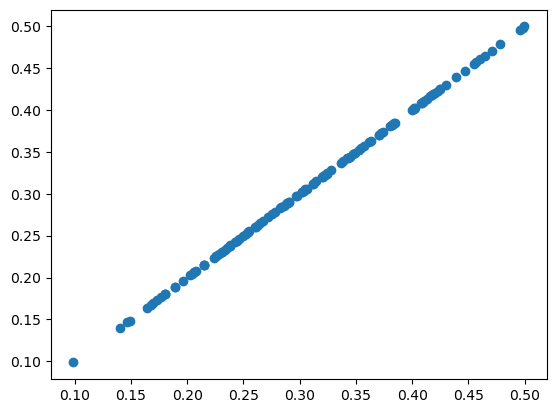

In [206]:
plt.scatter(z_E_adv.detach().numpy(), (E_rand.detach().numpy() @ f.fc1.weight.detach().numpy().T +f.fc1.bias.detach().numpy()))

In [207]:
class NN2(nn.Module):
    def __init__(self, num_in_tot, num_E_in, num_out_tot):
        super().__init__()
        
        funnel = np.linspace(num_in_tot, num_out_tot, 2, dtype=int)
        print("seq nn2: ", funnel)
    
        
        
        self.fc1 = nn.Linear(num_in_tot+num_E_in, funnel[1])
        #self.fc2 = nn.Linear(funnel[1] , funnel[2])
        
        
        
        #self.fc3 = nn.Linear(funnel[2], funnel[3])
        self.fc2 = nn.Linear(funnel[1], 1)
        
        
        
    def forward(self, input1, input_E_adv):
        #print("input1 shape",input1.shape)
        #print("input E_adv shape",input_E_adv.shape)
        #print("input1 indx shape",input1[...,0,:].shape)
        #print("env_variables shape",env_variables.shape)
        #xCaus = F.relu(self.fc1_caus(input_causal))
        x = torch.cat((input1, input_E_adv), dim=-1)
        #print("concat shape: ", x.shape)
        x = F.relu(self.fc1(x))
        #print("input1 first channel + env shape:" , x.sha;pe)              
        #x = F.relu(self.fc2(x))
        #print("hidden shape: ", x.shape)
        #x = self.fc3(x)
        output = self.fc2(x)
        
        
        return  output, x

In [208]:
z.shape

torch.Size([128, 10])

In [209]:
z_E_adv.shape

torch.Size([128, 1])

In [210]:
num_out_final = 4
f = NN2(num_out_tot, num_out_tot_E, num_out_final) #torch.jit.script(NN1())
output, z2 = f(z, z_E_adv)
print(z2.shape)
print(output.shape)

seq nn2:  [10  4]
torch.Size([128, 4])
torch.Size([128, 1])


### INitialize network

In [211]:
X.shape

(6119, 296)

In [212]:
#torch.manual_seed(1078)
torch.manual_seed(10784)
#seed=9, for v0 data with 16-3-13 arqui

batch_size = 1000
num_inputs_in = X.shape[1]

num_out_tot  = 30#X.shape[1]//2
num_out_final = 6#4
num_inputs_in_E = Env.shape[1]
num_out_tot_E = 10

nn1_input = NN1_input(num_inputs_in, num_out_tot)
nn1_input = nn1_input.double()
nn1_env_adv = NN1_E_adv(num_inputs_in_E, num_out_tot_E)
nn1_env_adv = nn1_env_adv.double()
nn2 = NN2(num_out_tot, num_out_tot_E, num_out_final)
nn2 = nn2.double()

funnel nn1 input:  [296 207 118  30]
seq nn2:  [30  6]


In [213]:
nn1_input.fc1.weight

Parameter containing:
tensor([[-3.5389e-02,  4.0681e-02,  4.5558e-02,  ..., -2.1956e-03,
         -1.2246e-02,  3.6885e-02],
        [ 4.8206e-03, -1.4122e-03,  9.1124e-03,  ...,  2.5198e-02,
         -2.7589e-02, -4.3181e-02],
        [-8.4986e-04, -4.6892e-02, -5.8246e-03,  ...,  3.7476e-02,
         -2.5937e-02, -3.6586e-03],
        ...,
        [ 1.7248e-02, -5.8036e-02,  2.3686e-02,  ..., -1.5163e-02,
         -5.2307e-02, -1.5200e-02],
        [ 1.5469e-02,  9.5120e-05, -4.5721e-02,  ...,  1.6748e-02,
          4.4920e-02,  4.5419e-02],
        [-4.6764e-02,  9.2172e-03,  7.7731e-03,  ...,  5.2083e-02,
          1.5478e-04, -1.7956e-02]], dtype=torch.float64, requires_grad=True)

In [214]:
loadModel = True
itern = 4
version = 1

In [215]:
prune.identity(nn1_input.fc1, "weight")
PATH = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/models/"
if loadModel & (itern>0):
    print("load model: ", itern-1)
    nn1_input.load_state_dict(torch.load(PATH+"nn1_input_"+str(itern-1)+"_v"+str(version)))
    nn1_env_adv.load_state_dict(torch.load(PATH+"nn1_env_adv_"+str(itern-1)+"_v"+str(version)))
    nn2.load_state_dict(torch.load(PATH+"nn2_"+str(itern-1)+"_v"+str(version)))
    nn1_input.fc1.weight = nn1_input.fc1.weight_orig*nn1_input.fc1.weight_mask   

load model:  3


In [216]:
indxAllZero, = np.where(np.apply_along_axis(np.sum,0,nn1_input.fc1.weight.cpu().detach().numpy()==0)==nn1_input.fc1.weight.shape[0])
indxAllZero.shape

(280,)

In [217]:
nn1_input.fc1.weight # first 3 weights -0.0028,  0.2028, -0.3111

tensor([[-0., -0., -0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., 0., -0., -0.],
        [0., 0., -0.,  ..., 0., 0., -0.],
        ...,
        [-0., -0., -0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., -0., -0.],
        [-0., -0., 0.,  ..., -0., 0., -0.]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [218]:
nn1_env_adv.fc1.weight.shape

torch.Size([10, 3])

In [219]:
  nn1_input.fc1.weight.shape

torch.Size([207, 296])

In [220]:
nn2.fc1.weight.shape

torch.Size([6, 40])

In [221]:
nn2.fc2.weight.shape

torch.Size([1, 6])

In [222]:
num_out_tot_E

10

In [223]:
num_out_tot

30

In [224]:
print('#params:', sum(p.numel() for p in nn1_input.parameters()))
print('#params:', sum(p.numel() for p in nn1_env_adv.parameters()))
print('#params:', sum(p.numel() for p in nn2.parameters()))

#params: 89593
#params: 40
#params: 253


In [225]:
print('#params:', sum(p.numel() for p in nn1_input.fc1.parameters()))

#params: 61479


In [226]:
params = list(nn1_input.parameters())+list(nn2.parameters())


In [227]:
params

[Parameter containing:
 tensor([-3.4577e-02, -3.2999e-02, -4.9679e-03, -4.9975e-02, -1.7882e-02,
         -5.2849e-02, -7.4550e-02, -6.8334e-02, -9.1981e-03, -9.4232e-03,
         -4.9993e-02, -7.1720e-02, -5.2206e-02, -2.0328e-02, -2.4586e-02,
         -2.1158e-02, -5.0126e-02, -2.2987e-02, -1.7908e-04, -5.6098e-02,
         -9.0654e-02,  9.0503e-02, -4.8459e-03, -1.8367e-02, -3.8036e-02,
         -1.5764e-02, -4.0279e-02, -9.8428e-03,  1.9525e-01, -3.1323e-02,
          2.0956e-02,  1.3727e-01, -5.2839e-03,  1.8949e-01, -2.5033e-02,
         -3.0445e-02, -3.0173e-03, -2.9539e-02, -2.8226e-02, -1.4373e-02,
         -3.9646e-02, -2.3349e-02,  2.2056e-01, -6.8816e-03, -8.6661e-03,
         -2.4575e-02, -1.6799e-02, -5.5774e-02, -5.9201e-02,  2.4626e-01,
         -5.0812e-02, -1.0594e-02, -4.1600e-03, -5.7141e-02, -5.6026e-03,
         -5.4030e-02, -1.6892e-02, -1.7396e-02, -2.0125e-02, -1.6651e-02,
         -7.5792e-03, -1.2098e-02, -3.0133e-02, -2.9439e-03, -7.3504e-03,
         -9.144

In [228]:
params_adv = list(nn1_env_adv.parameters())+list(nn2.parameters())
#params_adv = list(nn1_env_adv.parameters())


In [229]:
params_adv

[Parameter containing:
 tensor([[-1.9386,  1.9210,  1.0204],
         [ 0.7009, -0.2872,  0.2295],
         [-2.0670,  1.4388,  0.9615],
         [-0.4390,  0.2718, -0.5055],
         [ 0.1943, -0.1568, -0.3336],
         [ 1.2356, -0.8042, -0.3428],
         [-0.3538,  0.1236, -0.4170],
         [ 1.5577, -1.2513, -0.4553],
         [ 0.3603,  0.0942, -0.1847],
         [-0.5046, -0.5552, -0.3895]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([ 0.7794,  0.2311,  0.9715, -0.2273, -0.3456,  0.6337, -0.4895,  0.6012,
         -0.3228,  0.2408], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[-1.6125, -1.2190, -3.5963, -0.6308,  1.9836, -2.7906,  0.5408, -2.0833,
          -1.5507, -1.0361,  0.0822, -3.6379, -3.3085,  0.3274, -3.4421, -3.5005,
          -0.2664,  0.1720, -2.4770,  0.1618, -1.1427, -1.1408,  0.6687, -0.4752,
           0.4609,  0.7708, -4.1563,  0.0749,  1.5905,  0.6454,  0.0000,  0.0000,
           0.0000,  0.0000,  

# Loss function

In [230]:
def L1(output,tar):
    #mse = nn.MSELoss()(output, tar)
    ce = F.binary_cross_entropy_with_logits(output[:,0], tar)
    
    #res = torch.log(mse-0.005)     
    #res = mse
    res = ce
    return res

In [231]:
def L(output, tar, theta, eta, beta, gradCE, w1c):
    #print("L output", output.shape)
    #print("L tar", tar.shape)
    #mse = nn.MSELoss()(output, tar)
    ce = F.binary_cross_entropy_with_logits(output[:,0], tar) 
    

    envWeightNormsCaus = torch.linalg.norm(w1c)
    
    gradCENorm = torch.linalg.norm(gradCE)
    
    #res = torch.log(mse-0.005) 
    #res = mse
    res = ce
    #res = res + theta*torch.log(envWeightNormsCaus+0.0001)+eta*torch.log(gradCENorm+0.0001)
    res = eta*res + torch.log(gradCENorm+0.0000001)
    #res = eta*res + gradCENorm
    #res = eta*res - np.exp(-beta*gradCENorm)
    #print("res:", res)
    
    return res

# Optimization

In [232]:
criterion = L
criterion_adv = L1

lr = 0.001
optimizer = optim.Adam(params, lr=lr)
optimizer_adv = optim.Adam(params_adv, lr=lr)

#optimizer = optim.RMSprop(params, lr=lr)
#optimizer_adv = optim.RMSprop(params_adv, lr=lr)

# Hyperparameters

In [233]:
theta = 0  # w_E
eta = 0.0001 #grad
#eta = 10
beta = 1
multBeta = 10

# test loss function

In [234]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nn1_input.to(device)
nn1_env_adv.to(device)
nn2.to(device)

NN2(
  (fc1): Linear(in_features=40, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)

In [235]:
from torch.autograd import Variable


inputs, envs, labels =  next(iter(trainloader))
z = nn1_input(inputs)
z_E_adv = nn1_env_adv(envs)

w1c = Variable(nn2.fc1.weight[:,0:num_inputs_in_E], requires_grad=True)
w1cNorm = torch.linalg.norm(w1c)


output, z2 = nn2(z, z_E_adv)

inputs = inputs.type(torch.DoubleTensor)
envs = envs.type(torch.DoubleTensor)
labels = labels.type(torch.DoubleTensor)
inputs = inputs.to(device)
labels = labels.to(device)
envs = envs.to(device)

In [236]:
# L1(output,tar)
loss_adv= criterion_adv(output, labels)


In [237]:
loss_adv

tensor(0.2566, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [238]:
gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
gradCENorm = torch.linalg.norm(gradCE)
print("gradCENorm: ", gradCENorm)


gradCENorm:  tensor(0.3188, dtype=torch.float64)


In [239]:
gradCE.shape

torch.Size([6, 40])

In [240]:
# L(output, tar, theta, eta, gradCE, w1c)
criterion(output, labels, theta, eta, beta, gradCE, w1c)

tensor(-1.1431, dtype=torch.float64, grad_fn=<AddBackward0>)

# Train

### Adverserial  model training

In [241]:
def trainAdv(n_epochs, loader, opt, mod1, mod2, modE_adv, device, num_inputs_in_E, num_out_tot, criterion, criterion_adv ):
    #print("num epochs: ", n_epochs)
    for epoch in range(n_epochs):  # loop over the dataset multiple times    
        for i, data in enumerate(loader, 0):
            inputs, envs, labels =  data #next(iter(trainloader))
            inputs = inputs.type(torch.DoubleTensor)
            envs = envs.type(torch.DoubleTensor)
            labels = labels.type(torch.DoubleTensor)
            #print("labels",labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            envs = envs.to(device)

            # zero the parameter gradients
            opt.zero_grad()

            # forward + backward + optimize
            
            z = mod1(inputs)
            z_E_adv = modE_adv(envs)
            
            zENorm = torch.linalg.norm(z)
            zENormAdv = torch.linalg.norm(z_E_adv)
            
            #print("zE_norm",zENorm)
            #print("zEadv norm",zENormAdv)
            output, z2 = mod2(z, z_E_adv)

            #w1c = mod2.fc1.weight[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
             
            loss_adv= criterion_adv(output, labels)
            
                           
            #gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=mod2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
            #gradCE = gradCE[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
            
            
            #loss = criterion(output, labels, theta, eta, gradCE, w1c)
            
            grad = list(torch.autograd.grad(outputs=loss_adv, inputs=modE_adv.fc1.parameters(), allow_unused=False, retain_graph=True))[0]
            #print("grad",grad)
            
            loss_adv.backward()
            opt.step()
        #print("loss: ", loss_adv)
    
    with torch.no_grad():
            mod2.fc1.weight[:,num_out_tot:(num_inputs_in_E+num_out_tot)] = 0
              
    return modE_adv  

In [242]:
if False:
    with torch.no_grad():
        #nn1_input.fc1.weight[:,:] = 0
        nn1_input.fc1.bias[:] = 0
        nn2.fc1.weight[:,:] = 1
        nn2.fc1.bias[:] = 0

In [243]:
if False:
    with torch.no_grad():
        nn1_env_adv.fc1.weight[:,:]=0

In [244]:
if False:
    with torch.no_grad():
        #nn1_env_adv.fc1.weight[:,:]=0
        nn1_input.fc1.weight[:,:] = 0
        #nn1_input.fc1.weight[:,3] = 1
        nn1_input.fc1.weight[:,0] = 1
        nn1_input.fc1.weight[:,1] = 1

In [245]:
nn1_input.fc1.weight.shape

torch.Size([207, 296])

In [246]:
nn1_input.fc1.weight

tensor([[-0., -0., -0.,  ..., 0., 0., 0.],
        [-0., -0., -0.,  ..., 0., -0., -0.],
        [0., 0., -0.,  ..., 0., 0., -0.],
        ...,
        [-0., -0., -0.,  ..., 0., 0., 0.],
        [0., -0., 0.,  ..., 0., -0., -0.],
        [-0., -0., 0.,  ..., -0., 0., -0.]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

In [247]:
ini_nn1_env_adv_fc1_weight = nn1_env_adv.fc1.weight.detach().numpy().copy()
ini_nn1_env_adv_fc1_weight

array([[-1.93857186,  1.92103567,  1.02038627],
       [ 0.7009133 , -0.28718054,  0.22946735],
       [-2.06704796,  1.43876581,  0.96146513],
       [-0.43896687,  0.27177075, -0.50552976],
       [ 0.19433807, -0.15679072, -0.33362204],
       [ 1.23555557, -0.80417195, -0.34283823],
       [-0.35381985,  0.12360553, -0.41699865],
       [ 1.55767588, -1.25126816, -0.45527178],
       [ 0.36026427,  0.09416679, -0.18466764],
       [-0.50458008, -0.55523175, -0.3894957 ]])

In [248]:
n_epochs= 5#20
t1_start = time.process_time() 

#loader = trainloader, 
#opt =  optimizer_adv
#mod1 = nn1_input
#mod2 = nn1_env
#mod2_adv = nn1_env_<dv
#mod3 = nn2
#mod_aux1 = nn_aux_caus
#mod_aux2 = nn_aux_nonCaus


nn1_env_adv = trainAdv(n_epochs, trainloader, optimizer_adv, nn1_input, nn2, nn1_env_adv, device, num_inputs_in_E, num_out_tot, criterion, criterion_adv )

t1_stop = time.process_time()
print(t1_stop)
print('Finished Training')

47.261797212
Finished Training


In [249]:
nn1_env_adv.fc1.weight.detach().numpy()

array([[-2.00457115,  1.91312897,  1.0012252 ],
       [ 0.69956735, -0.30488313,  0.2414937 ],
       [-2.13350895,  1.43139599,  0.94248482],
       [-0.43896687,  0.27177075, -0.50552976],
       [ 0.19433807, -0.15679072, -0.33362204],
       [ 1.23445999, -0.84296042, -0.31607334],
       [-0.35381985,  0.12360553, -0.41699865],
       [ 1.55649664, -1.17828436, -0.42791959],
       [ 0.36026427,  0.09416679, -0.18466764],
       [-0.50458008, -0.55523175, -0.3894957 ]])

In [250]:
ini_nn1_env_adv_fc1_weight

array([[-1.93857186,  1.92103567,  1.02038627],
       [ 0.7009133 , -0.28718054,  0.22946735],
       [-2.06704796,  1.43876581,  0.96146513],
       [-0.43896687,  0.27177075, -0.50552976],
       [ 0.19433807, -0.15679072, -0.33362204],
       [ 1.23555557, -0.80417195, -0.34283823],
       [-0.35381985,  0.12360553, -0.41699865],
       [ 1.55767588, -1.25126816, -0.45527178],
       [ 0.36026427,  0.09416679, -0.18466764],
       [-0.50458008, -0.55523175, -0.3894957 ]])

In [251]:
z = nn1_input(inputs)
z_E_adv = nn1_env_adv(envs)
output, z2 = nn2(z, z_E_adv)
w1c = nn2.fc1.weight[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
loss_adv= criterion_adv(output, labels)
gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
gradCE = gradCE[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
gradCENorm = torch.linalg.norm(gradCE)

In [252]:
gradCENorm

tensor(0.2322, dtype=torch.float64)

### metrics

In [253]:
def getPred(loader, mod1, mod2, modE_adv):
    y_pred = []
    y_true = []
    zs = []
    zs2 = []
    zs_E = []
    xs = []
    Envs = []
    

    for i, (inputs, envs, targets) in enumerate(loader, 0):
    #for i in range(100):
        y_true.extend(targets.cpu().detach().numpy())
        inputs = inputs.type(torch.DoubleTensor)
        xs.extend(inputs.cpu().detach().numpy())
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        
        envs = envs.to(device)
        
        

        z = mod1(inputs)
        z_E_adv = modE_adv(envs)
        zs_E.extend(z_E_adv.cpu().detach().numpy())
        #if switch_off_nonCausal:
        #    z_E = z_E*0
        
        yhat, z2 = mod2(z, z_E_adv)
        
        zs.extend(z.cpu().detach().numpy())
        zs2.extend(z2.cpu().detach().numpy())
        y_pred.extend(yhat.cpu().detach().numpy())
        Envs.extend(envs.cpu().detach().numpy())  
    
    zs = np.array(zs)
    zs2 = np.array(zs2)
    xs = np.array(xs)
    Envs = np.array(Envs)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    zs_E = np.array(zs_E)
           
    return xs, zs, zs2, zs_E, y_pred, y_true, Envs

In [254]:
xs, zs, zs2, zs_E, y_pred, y_true, Envs = getPred(testloader, nn1_input, nn2, nn1_env_adv)

In [255]:
inputs = torch.from_numpy(xs)
envs = torch.from_numpy(Envs)
labels = y_true.astype(np.float32)
labels = torch.from_numpy(labels)
z = z = nn1_input(inputs)
z_E_adv = nn1_env_adv(envs)
output, z2 = nn2(z, z_E_adv)

In [256]:
output.shape

torch.Size([800, 1])

In [257]:
labels.shape

torch.Size([800])

In [258]:
loss_adv= criterion_adv(output, labels)


In [259]:
gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
gradCE = gradCE[:,num_out_tot:(num_out_tot_E+num_out_tot)]
gradCENorm = torch.linalg.norm(gradCE)
gradCENorm

tensor(0.3193, dtype=torch.float64)

In [260]:
type(y_true)

numpy.ndarray

In [261]:
zs_E.shape

(800, 10)

In [262]:
num_out_tot_E

10

In [263]:
zE_nms = ["zE"+str(i+1) for i in range(num_out_tot_E)]
zE_nms

['zE1', 'zE2', 'zE3', 'zE4', 'zE5', 'zE6', 'zE7', 'zE8', 'zE9', 'zE10']

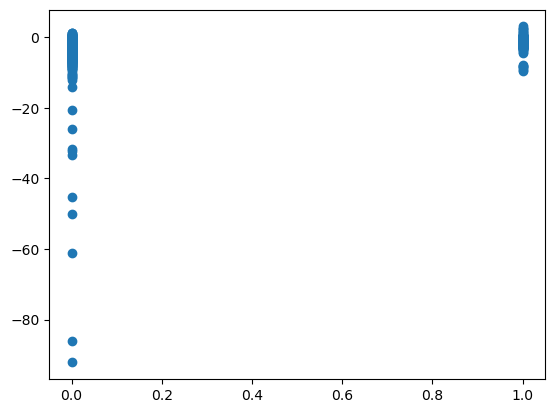

In [264]:
plt.scatter(y_true, y_pred)

In [265]:
y_pred.shape

(800, 1)

In [266]:
y_true

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [267]:
roc_auc_score(y_true, y_pred)

0.670828410554438

In [268]:
def getMSE(loader, mod1, mod2, modE_adv):
    
    _, _,_, _,  y_pred, y_true, _ = getPred(loader, mod1, mod2, modE_adv)
                
           
    return mean_squared_error(y_true, y_pred)

def getAUC(loader, mod1, mod2, modE_adv):
    
    _, _,_, _, y_pred, y_true, _ = getPred(loader, mod1, mod2, modE_adv)
                
           
    return roc_auc_score(y_true, y_pred)

In [269]:
def getMeasures(loader, mod1, mod2, modE_adv):
    
    xs, zs, zs2, zs_E, y_pred, y_true, Envs = getPred(loader, nn1_input, nn2, nn1_env_adv)
    
    inputs = torch.from_numpy(xs)
    envs = torch.from_numpy(Envs)
    labels = y_true.astype(np.float32)
    labels = torch.from_numpy(labels)
    z = mod1(inputs)
    z_E_adv = modE_adv(envs)
    output, z2 = mod2(z, z_E_adv)
    loss_adv= criterion_adv(output, labels)
    gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=mod2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
    gradCE = gradCE[:,num_out_tot:(num_out_tot_E+num_out_tot)]
    gradCENorm = torch.linalg.norm(gradCE)
    #gradCENorm = 0
    
    indxActive,  = np.where(np.apply_along_axis(np.sum,0,np.abs(zs2)>0)>0)
    pctActive = indxActive.shape[0]/zs2.shape[1]
    print("pct active: ", pctActive)
    
    num_clusts = 2
    cluster_var = np.ceil(np.linspace(0.001, num_clusts, xs.shape[0]))-1
    np.unique(cluster_var, return_counts=True)
    tar = y_true#[:,0]**1

    #mse = mean_squared_error(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    ce = log_loss(y_true, y_pred)
    
    #pvalue1, stat1 = getHypWrapperClf(zs2[:,indxActive], tar, Envs, cluster_var, numTrees=100)
    pvalue2, stat2 = getHypWrapperClf(zs2[:,indxActive], tar, zs_E, cluster_var, numTrees=100)
    pvalue1, stat1 = pvalue2, stat2
    
    #.requires_grad_().long()
    
    
    y_true = y_true.astype(np.float32)
    y_true = torch.from_numpy(y_true)
    
    inpJ, envs,labJ = jacobian(calcLossFromInputs, (torch.from_numpy(xs), torch.from_numpy(Envs), y_true))
    Jac = np.apply_along_axis(np.mean,0, np.abs(inpJ))*1e6
    Jac = Jac/np.max(Jac)
    
    inpJG, envsG,labJG = jacobian(calcGradFromInputs, (torch.from_numpy(xs), torch.from_numpy(Envs), y_true))
    JacG = np.apply_along_axis(np.mean,0, np.abs(inpJG))*1e6
    JacG = Jac/np.max(JacG)
    
    #Efuncs = mat_df.iloc[indx][["lat","lon","biome"]]
    #num_out_tot_E = zs_E.shape[1]
    #zE_nms = ["zE"+str(i+1) for i in range(num_out_tot_E)]
    
    #Efuncs[zE_nms] = zs_E
    #smpl = np.random.choice(Efuncs.shape[0], size=500)
    #hsic_zE_biome = hsicRBF(Efuncs["biome"].to_numpy()[smpl,None],Efuncs[zE_nms].to_numpy()[smpl,:])
    
    
    
    return ce, auc, pvalue1, stat1, pvalue2, stat2, Jac, JacG, gradCENorm

In [270]:
def calcLossFromInputs(inputs, envs, labels):
            z = nn1_input(inputs)
            z_E_adv = nn1_env_adv(envs)
            output, z2 = nn2(z, z_E_adv)
            w1c = nn2.fc1.weight[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
            loss_adv= criterion_adv(output, labels)
            gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
            gradCE = gradCE[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
            gradCENorm = torch.linalg.norm(gradCE)
            loss = criterion(output, labels, theta, eta, beta, gradCE, w1c)
            
            return loss
        
        
def calcGradFromInputs(inputs, envs, labels):
            z = nn1_input(inputs)
            z_E_adv = nn1_env_adv(envs)
            output, z2 = nn2(z, z_E_adv)
            w1c = nn2.fc1.weight[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
            loss_adv= criterion_adv(output, labels)
            gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
            gradCE = gradCE[:,num_out_tot:(num_inputs_in_E+num_out_tot)]
            gradCENorm = torch.linalg.norm(gradCE)
            
            
            return gradCENorm        

### Causal model training

In [271]:
n_epochs= 500

In [272]:


if (itern==0):
    losses = []
    auc_tr = []
    auc_te = []
    ce_tr = []
    ce_te = []
    num_supervars = []

    pvalue1_te = []
    pvalue1_tr = []
    stat1_te = []
    stat1_tr = []
    pvalue2_te = []
    pvalue2_tr = []
    stat2_te = []
    stat2_tr = []

    grad_norm = []
    grad_norm_all_tr = []
    grad_norm_all_te = []
    w1c_norm = []

    Jac_te = []
    Jac_tr = []
    JacG_te = []
    JacG_tr = []

    hsics_tr = []
    hsics_te = []

    prop1 = 0
    prop2 = 0
    prop3 = 0

    
    cnt = 0
else: 
    print("load results: ", itern-1)
    repos_results = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/results/"
    file_results = "results_"+str(itern-1)+"_v"+str(version)+".pkl"
    res = pickle5.load( open( repos_results+file_results, "rb" ) )
    
    losses, auc_tr, auc_te, ce_tr, ce_te, num_supervars, pvalue1_te, pvalue1_tr, stat1_te, stat1_tr, pvalue2_te, pvalue2_tr, stat2_te, stat2_tr, grad_norm, grad_norm_all_tr, grad_norm_all_te, w1c_norm, Jac_te, Jac_tr, JacG_te, JacG_tr, hsics_tr, hsics_te, prop1, prop2, prop3 = res
    cnt = len(losses)-1

load results:  3


In [273]:
def trainMinimal(n_epochs, trainloader, testloader, optimizer, optimizer_adv, nn1_input, nn2, nn1_env_adv, device,num_inputs_in_E, num_out_tot, criterion, criterion_adv, theta, eta, beta, multBeta, parameters_to_prune):
    t1_start = time.process_time() 
    trainA = True
    grad_norm = []
    auc_te = []
    #auc_te = []
    cnt  = 0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        #print("trainA: ", trainA)
        beta = beta*multBeta
        running_loss = 0.0
        cnt = cnt + 1
    
        if (trainA)&(epoch>0)&(epoch<50):
            nn1_env_adv = trainAdv(1, trainloader, optimizer_adv, nn1_input, nn2, nn1_env_adv, device, num_inputs_in_E, num_out_tot, criterion, criterion_adv )
        
    
        for i, data in enumerate(trainloader, 0):
            #print("i: ", i)
            #for i in range(n_epochs):
            # get the inputs; data is a list of [inputs, labels]
            inputs, envs, labels =  data #next(iter(trainloader))
            #inputs, envs, labels =  next(iter(trainloader))
            #print("inputs",inputs.shape)
            #print("envs",envs.shape)
            #print("labels",labels.shape)
            #inputs2 = torch.cat([inputs, labels], axis=1)
        
            #print(labels)
            inputs = inputs.type(torch.DoubleTensor)
            #inputs2 = inputs2.type(torch.DoubleTensor)
            envs = envs.type(torch.DoubleTensor)
            labels = labels.type(torch.DoubleTensor)
            #labels = labels.type(torch.LongTensor)
            inputs = inputs.to(device)
            #inputs2 = inputs2.to(device)
            labels = labels.to(device)
            envs = envs.to(device)
        
        
        

            # zero the parameter gradients
            optimizer.zero_grad()
            #optimizer_adv.zero_grad()
        
            # forward + backward + optimize
        
        
        
        
        
        
            z = nn1_input(inputs)
            z_E_adv = nn1_env_adv(envs)
            output, z2 = nn2(z, z_E_adv)
            w1c = nn2.fc1.weight[:,num_out_tot:(num_out_tot_E+num_out_tot)]
            w1cNorm = torch.linalg.norm(w1c)
            loss_adv= criterion_adv(output, labels)
            gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
            gradCE = gradCE[:,num_out_tot:(num_out_tot_E+num_out_tot)]
            gradCENorm = torch.linalg.norm(gradCE)
            loss = criterion(output, labels, theta, eta, beta, gradCE, w1c)
        
            #loss = calcLossFromInputs(inputs, envs, labels)
        
            if (len(grad_norm)==0) & (i == 0):
                #auc_te_aux = getAUC(testloader, nn1_input, nn2, nn1_env_adv)
                #auc_te.append(auc_te_aux)
                grad_norm.append(gradCENorm)
                
        
        
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss
        
                
            with torch.no_grad():
                nn2.fc1.weight[:,num_out_tot:(num_out_tot_E+num_out_tot)] = 0    
        
        
        
    
        if (cnt>=30) & (prop1<0.95): 
            prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=0.05)

        
    
   

             
        loss_epoch = running_loss/i
        #print("loss_epoch",loss_epoch)
    
    
        if np.logical_not(np.isnan(loss_epoch.cpu().detach().numpy())):
            #print("saving")
            grad_norm.append(gradCENorm)
            
        
            #print("done")
        else:
            print("nan")
            break
   
    auc_te = getAUC(testloader, nn1_input, nn2, nn1_env_adv)
    

    t1_stop = time.process_time()    
    #print('Finished Training')
    
    print("length grad norm: ", len(grad_norm))
    return grad_norm, auc_te
    

In [274]:
def initializeTrainMinimal(seed,n_epochs, trainloader, testloader, lr, num_inputs_in_E, num_out_tot, criterion, criterion_adv, theta, eta, beta, multBeta):
    torch.manual_seed(seed)

    nn1_input = NN1_input(num_inputs_in, num_out_tot)
    nn1_input = nn1_input.double()
    nn1_env_adv = NN1_E_adv(num_inputs_in_E, num_out_tot_E)
    nn1_env_adv = nn1_env_adv.double()
    nn2 = NN2(num_out_tot, num_out_tot_E, num_out_final)
    nn2 = nn2.double()
    
    prune.identity(nn1_input.fc1, "weight")
    PATH = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/models/"
    if loadModel & (itern>0):
        print("load model: ", itern-1)
        nn1_input.load_state_dict(torch.load(PATH+"nn1_input_"+str(itern-1)+"_v"+str(version)))
        nn1_env_adv.load_state_dict(torch.load(PATH+"nn1_env_adv_"+str(itern-1)+"_v"+str(version)))
        nn2.load_state_dict(torch.load(PATH+"nn2_"+str(itern-1)+"_v"+str(version)))
        nn1_input.fc1.weight = nn1_input.fc1.weight_orig*nn1_input.fc1.weight_mask   
    
    params = list(nn1_input.parameters())+list(nn2.parameters())
    params_adv = list(nn1_env_adv.parameters())+list(nn2.parameters())
    
    parameters_to_prune = (
    (nn1_input.fc1, 'weight'),
    (nn1_input.fc1, 'weight'),
    (nn1_input.fc1, 'weight'))

    optimizer = optim.Adam(params, lr=lr)
    optimizer_adv = optim.Adam(params_adv, lr=lr)
    
    gradNorm, auc_te  = trainMinimal(n_epochs, trainloader, testloader, optimizer, optimizer_adv, nn1_input, nn2, nn1_env_adv, device, num_inputs_in_E, num_out_tot, criterion, criterion_adv, theta, eta, beta, multBeta, parameters_to_prune)
    gradNorm = np.array([gradNorm[i].cpu().detach().numpy() for i in range(len(gradNorm))])
    #auc_te = np.array(auc_te)
    return gradNorm, auc_te
    

In [275]:
np.random.seed(123456)
numSeeds = 20
if itern>0:
    numSeeds=2
seeds = np.random.choice(100000000, size = numSeeds)
seeds

array([ 8460353, 64051946])

In [276]:
res = [initializeTrainMinimal(seed, 10, trainloader, testloader, lr, num_inputs_in_E, num_out_tot, criterion, criterion_adv, theta, eta, beta, multBeta) for seed in seeds]

funnel nn1 input:  [296 207 118  30]
seq nn2:  [30  6]
load model:  3
length grad norm:  11
funnel nn1 input:  [296 207 118  30]
seq nn2:  [30  6]
load model:  3
length grad norm:  11


In [277]:
gradNormss = np.array([el[0] for el in res])

In [278]:
aucs_te = np.array([el[1] for el in res])
aucs_te

array([0.66413343, 0.66413343])

In [279]:
indx, = np.where(aucs_te > 0.6)

In [280]:
gradNormss.shape

(2, 11)

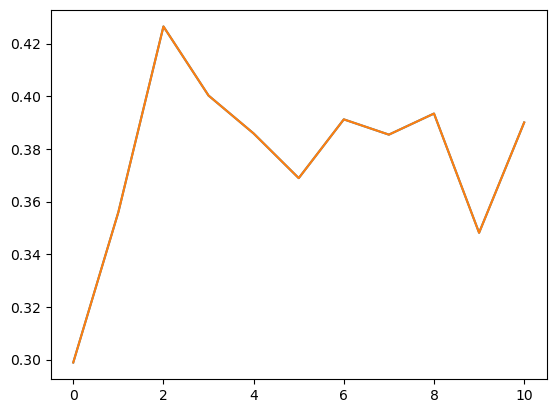

In [281]:
plt.plot(gradNormss.T)

In [282]:
np.min(gradNormss[indx,10])

0.39002109135136065

In [283]:
indxBest, = np.where(gradNormss[:,10]==np.min(gradNormss[indx,10]))
indxBest = indxBest[0]
indxBest

0

In [284]:
seeds[indxBest]

8460353

In [285]:
gradNormss[indxBest,:]

array([0.29891218, 0.3559811 , 0.42646798, 0.40024891, 0.38585085,
       0.368896  , 0.3912002 , 0.38540621, 0.39341196, 0.34816051,
       0.39002109])

In [286]:
torch.manual_seed(seeds[indxBest])
nn1_input = NN1_input(num_inputs_in, num_out_tot)
nn1_input = nn1_input.double()
nn1_env_adv = NN1_E_adv(num_inputs_in_E, num_out_tot_E)
nn1_env_adv = nn1_env_adv.double()
nn2 = NN2(num_out_tot, num_out_tot_E, num_out_final)
nn2 = nn2.double()
    
prune.identity(nn1_input.fc1, "weight")
PATH = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/models/"
if loadModel & (itern>0):
    print("load model: ", itern-1)
    nn1_input.load_state_dict(torch.load(PATH+"nn1_input_"+str(itern-1)+"_v"+str(version)))
    nn1_env_adv.load_state_dict(torch.load(PATH+"nn1_env_adv_"+str(itern-1)+"_v"+str(version)))
    nn2.load_state_dict(torch.load(PATH+"nn2_"+str(itern-1)+"_v"+str(version)))
    nn1_input.fc1.weight = nn1_input.fc1.weight_orig*nn1_input.fc1.weight_mask       
    
params = list(nn1_input.parameters())+list(nn2.parameters())
params_adv = list(nn1_env_adv.parameters())+list(nn2.parameters())

optimizer = optim.Adam(params, lr=lr)
optimizer_adv = optim.Adam(params_adv, lr=lr)

funnel nn1 input:  [296 207 118  30]
seq nn2:  [30  6]
load model:  3


In [287]:
 parameters_to_prune = (
    (nn1_input.fc1, 'weight'),
    (nn1_input.fc1, 'weight'),
    (nn1_input.fc1, 'weight'))
    

In [288]:
def anyNonZero(x):
    return np.any(x!=0)

In [289]:


t1_start = time.process_time() 
trainA = True

for epoch in range(n_epochs):  # loop over the dataset multiple times
    print("trainA: ", trainA)
    beta = beta*multBeta
    running_loss = 0.0
    cnt = cnt + 1
    
    if (trainA)&epoch>0:
        nn1_env_adv = trainAdv(1, trainloader, optimizer_adv, nn1_input, nn2, nn1_env_adv, device, num_inputs_in_E, num_out_tot, criterion, criterion_adv )

    
    
    
    
    for i, data in enumerate(trainloader, 0):
    #for i in range(n_epochs):
        # get the inputs; data is a list of [inputs, labels]
        inputs, envs, labels =  data #next(iter(trainloader))
        #inputs, envs, labels =  next(iter(trainloader))
        #print("inputs",inputs.shape)
        #print("envs",envs.shape)
        #print("labels",labels.shape)
        #inputs2 = torch.cat([inputs, labels], axis=1)
        
        #print(labels)
        inputs = inputs.type(torch.DoubleTensor)
        #inputs2 = inputs2.type(torch.DoubleTensor)
        envs = envs.type(torch.DoubleTensor)
        labels = labels.type(torch.DoubleTensor)
        #labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        #inputs2 = inputs2.to(device)
        labels = labels.to(device)
        envs = envs.to(device)
        
        
        

        # zero the parameter gradients
        optimizer.zero_grad()
        #optimizer_adv.zero_grad()
        
        # forward + backward + optimize
        
        
        
        
        z = nn1_input(inputs)
        z_E_adv = nn1_env_adv(envs)
        output, z2 = nn2(z, z_E_adv)
        w1c = nn2.fc1.weight[:,num_out_tot:(num_out_tot_E+num_out_tot)]
        w1cNorm = torch.linalg.norm(w1c)
        loss_adv= criterion_adv(output, labels)
        gradCE = list(torch.autograd.grad(outputs=loss_adv, inputs=nn2.fc1.parameters(), allow_unused=True, retain_graph=True))[0]
        gradCE = gradCE[:,num_out_tot:(num_out_tot_E+num_out_tot)]
        gradCENorm = torch.linalg.norm(gradCE)
        loss = criterion(output, labels, theta, eta, beta, gradCE, w1c)
        
        
        
        
        #loss = calcLossFromInputs(inputs, envs, labels)
        
        
        
        if (len(losses)==0) & (i == 0):
            #             getMSE(loader,      mod1,      mod2, modE_adv, switch_off_nonCausal=False)
            ce_tr_aux, auc_tr_aux, pvalue1_tr_aux, stat1_tr_aux, pvalue2_tr_aux, stat2_tr_aux, Jac_tr_aux, JacG_tr_aux, grad_norm_all_tr_aux = getMeasures(trainloader, nn1_input, nn2, nn1_env_adv)
            ce_te_aux, auc_te_aux, pvalue1_te_aux, stat1_te_aux, pvalue2_te_aux, stat2_te_aux, Jac_te_aux, JacG_te_aux, grad_norm_all_te_aux= getMeasures(testloader, nn1_input, nn2, nn1_env_adv)
            
            
            losses.append(loss) #.item()
            auc_tr.append(auc_tr_aux)
            auc_te.append(auc_te_aux)
            ce_tr.append(ce_tr_aux)
            ce_te.append(ce_te_aux)
            grad_norm.append(gradCENorm)
            grad_norm_all_tr.append(grad_norm_all_tr_aux)
            grad_norm_all_te.append(grad_norm_all_te_aux)
            w1c_norm.append(w1cNorm)
            pvalue1_tr.append(pvalue1_tr_aux)
            pvalue1_te.append(pvalue1_te_aux)
            stat1_tr.append(stat1_tr_aux)
            stat1_te.append(stat1_te_aux)
            pvalue2_tr.append(pvalue2_tr_aux)
            pvalue2_te.append(pvalue2_te_aux)
            stat2_tr.append(stat2_tr_aux)
            stat2_te.append(stat2_te_aux)
            #hsics_tr.append(hsic_tr_aux)
            #hsics_te.append(hsic_te_aux)
            Jac_tr.append(Jac_tr_aux)
            Jac_te.append(Jac_te_aux)
            JacG_tr.append(JacG_tr_aux)
            JacG_te.append(JacG_te_aux)
            #tests2.append(test2["pval_1tail"])
            
    
            
            print(f'[{0}] loss: {loss:.6f}') #.item()
            print(f'[{0}] auc train: {auc_tr_aux:.6f}')
            print(f'[{0}] auc test: {auc_te_aux:.6f}')
            print(f'[{0}] grad norm: {gradCENorm:.6f}')
            print(f'[{0}] w1c norm: {w1cNorm:.6f}')
            print(f'[{0}] stat1 train: {stat1_tr_aux:}')
            print(f'[{0}] stat1 test: {stat1_te_aux:}')
        
        
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss
                
        with torch.no_grad():
            nn2.fc1.weight[:,num_out_tot:(num_out_tot_E+num_out_tot)] = 0
            #nn1_input.fc1.weight[:,:] = 0
            #nn1_input.fc1.weight[:,3] = 1
            #nn1_input.fc1.weight[:,0] = 1
            #nn1_input.fc1.weight[:,1] = 1
            
        
        
        #nn2.fc1_caus.weight[:,num_out_causal:(num_inputs_in_E+num_out_causal)] = 0
        
        

        # print statistics
        running_loss += loss #.item()
    
    

    loss_epoch = running_loss/i
    ce_tr_aux, auc_tr_aux, pvalue1_tr_aux, stat1_tr_aux, pvalue2_tr_aux, stat2_tr_aux, Jac_tr_aux, JacG_tr_aux, grad_norm_all_tr_aux  = getMeasures(trainloader, nn1_input, nn2,  nn1_env_adv)
    ce_te_aux, auc_te_aux, pvalue1_te_aux, stat1_te_aux, pvalue2_te_aux, stat2_te_aux, Jac_te_aux, JacG_te_aux, grad_norm_all_te_aux = getMeasures(testloader, nn1_input, nn2, nn1_env_adv)    
    
   

    
    
    prop1 = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc1.weight.cpu().detach().numpy().shape)
    #prop2 = np.sum(nn1_input.fc2.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc2.weight.cpu().detach().numpy().shape)
    #prop3 = np.sum(nn1_input.fc3.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc3.weight.cpu().detach().numpy().shape)
        
    print("prop1: ", prop1)
    #print("prop2: ", prop2)
    #print("prop3: ", prop3)

    numVars = np.sum(np.apply_along_axis(np.sum, 0, nn1_input.fc1.weight.cpu().detach().numpy()>0)>0)
    #print("num Vars used: ", numVars)
    whichVars, = np.where(np.apply_along_axis(np.sum, 0, nn1_input.fc1.weight.cpu().detach().numpy()>0)>0)
    #print("which vars used: ", whichVars)
    numNonZeroVars = np.apply_along_axis(np.sum, 0, np.abs(nn1_input.fc1.weight.cpu().detach().numpy())>0)
    #print("num nonZero vars:", numNonZeroVars)
    
    
    prop0 = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc1.weight.cpu().detach().numpy().shape)
    maxPerVar = np.array([np.max(np.abs(nn1_input.fc1.weight.cpu().detach().numpy())[:,posts[i]:posts[i+1]]) for i in range(posts.shape[0]-1)])
    numSuperVars = np.sum(maxPerVar!=0)
    numConn = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()!=0)
    nonZeroOut =np.apply_along_axis(anyNonZero,0,nn1_input.fc1.weight.cpu().detach().numpy())
    varStats = np.sum(nonZeroOut)
    
    maxPerVar2 = np.array([np.max(Jac_tr_aux[posts[i]:posts[i+1]]) for i in range(posts.shape[0]-1)])
    numSuperVars2 = np.sum(maxPerVar2!=0)
    numSuperVars2
    
    #if  (prop0<0.995):  #(epoch < 30) &
    #if numSuperVars > 10:
    #    prune.l1_unstructured(nn1_input.fc1, name="weight", amount=0.1)
    print("proportion ws nn1_input ==0")
    print(prop0)
    print("num non-zeros by super-var")
    print(numSuperVars)
    print("num non-zeros by super-var 2")
    print(numSuperVars2)
    print("absolute number of connections")
    print(numConn)
    print("number of var-stats used")
    print(varStats)
    
    num_supervars.append(numSuperVars2)
    
    impScores = torch.from_numpy((JacG_te_aux[:,None]@np.ones((1,nn1_input.fc1.weight.shape[0]))).T)
    impScores = {"nn1_input.fc1.weight":impScores}
    
    #print(impScores.shape)
    #print(nn1_input.fc1.weight.shape)
    
    
    
    if len(grad_norm)>=51:
        gradMin = np.quantile(np.array(grad_norm)[(np.array(grad_norm).shape[0]-51):(np.array(grad_norm).shape[0]-1)], 0.1)
    else:
        gradMin = 0.05
    gradMin = np.max([0.05,gradMin])
    print("gradMin: ", gradMin)
    if (cnt>=10) & (gradCENorm.cpu().detach().numpy()<gradMin) & (numSuperVars2>1): 
        print("*******")
        print("prune")
        print("*******")
        #prune.l1_unstructured(nn1_input, name="weight", amount=0.05)
        #prune.l1_unstructured(nn1_input.fc1, name="weight", amount=0.01, importance_scores=impScores)
        #prune.l1_unstructured(nn1_input.fc2, name="weight", amount=0.05)
        #prune.l1_unstructured(nn1_input.fc3, name="weight", amount=0.05)
        #prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=0.01)
        amnt = 0.02
        if numConn<100:
            amnt = 1
        prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=amnt, importance_scores=impScores)
        #prune.ln_structured(nn1_input.fc1, name="weight", amount=1, n=1, dim=1)
    else:
        print("*******")
        print("no prune")
        print("*******")
    
    
    
    print("test")
    #print(Jac_te_aux)
    #print(test)
    #print(test2)
    
    print(f'[{epoch + 1}] loss: {running_loss/i:.6f}')
    print(f'[{len(losses)}] auc train: {auc_tr_aux:.6f}')
    print(f'[{len(losses)}] auc test: {auc_te_aux:.6f}')
    print(f'[{len(losses)}] ce train: {ce_tr_aux:.6f}')
    print(f'[{len(losses)}] ce test: {ce_te_aux:.6f}')
    print(f'[{len(losses)}] grad norm: {gradCENorm:.6f}')
    print(f'[{len(losses)}] w1c norm: {w1cNorm:.6f}')
    print(f'[{len(losses)}] stat1 train: {stat1_tr_aux:}')
    print(f'[{len(losses)}] stat1 test: {stat1_te_aux:}')
    
    #if(test["pval_1tail"] > 0.1):
    #            trainA = False
    #if(test["pval_1tail"] > 0.5):
    #            break
    
    
    
    if np.logical_not(np.isnan(loss_epoch.cpu().detach().numpy())):
        print("saving")
        losses.append(loss_epoch) #.item()
        auc_tr.append(auc_tr_aux)
        auc_te.append(auc_te_aux)
        ce_tr.append(ce_tr_aux)
        ce_te.append(ce_te_aux)
        grad_norm.append(gradCENorm)
        grad_norm_all_tr.append(grad_norm_all_tr_aux)
        grad_norm_all_te.append(grad_norm_all_te_aux)
        w1c_norm.append(w1cNorm)
        pvalue1_tr.append(pvalue1_tr_aux)
        pvalue1_te.append(pvalue1_te_aux)
        stat1_tr.append(stat1_tr_aux)
        stat1_te.append(stat1_te_aux)
        pvalue2_tr.append(pvalue2_tr_aux)
        pvalue2_te.append(pvalue2_te_aux)
        stat2_tr.append(stat2_tr_aux)
        stat2_te.append(stat2_te_aux)
        #hsics_tr.append(hsic_tr_aux)
        #hsics_te.append(hsic_te_aux)
        Jac_tr.append(Jac_tr_aux)
        Jac_te.append(Jac_te_aux)
        JacG_tr.append(JacG_tr_aux)
        JacG_te.append(JacG_te_aux)
        #tests2.append(test2["pval_1tail"])
        
        ML_ready_root = "/home/jupyter/ML_ready/nn_weights/"
        #file = "losses_experiment_icp_fcn_"+str(version)+".pkl"
        #with open(ML_ready_root+file, 'wb') as output:  # Overwrites any existing file.
        #    pickle.dump((losses, mse_tr, mse_te), output, pickle.HIGHEST_PROTOCOL)
        #torch.save(encoder.state_dict(), ML_ready_root+'encoder_experiment_icp_'+str(version))
        #torch.save(decoder.state_dict(), ML_ready_root+'decoder_experiment_icp_'+str(version))
        #if len(losses)%10==0:
        #    print("saving partial")
        #    torch.save(encoder.state_dict(), ML_ready_root+'encoder_experiment_icp_fcn_'+str(version)+"_"+str(len(losses)))
        #    torch.save(decoder.state_dict(), ML_ready_root+'decoder_experiment_icp_fcn_'+str(version)+"_"+str(len(losses)))
        
        print("done")
    else:
        print("nan")
        break
        
t1_stop = time.process_time()    
print('Finished Training')

trainA:  True
pct active:  0.8333333333333334
auc without E: 0.7967452916691994
auc with E:  0.8435402128244535
pval:  1.5986301171722062e-10


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.53081607644455
auc with E:  0.599645363089732
pval:  0.00889381428842062
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.3244248475542235
*******
no prune
*******
test
[1] loss: -1.324019
[2001] auc train: 0.863963
[2001] auc test: 0.669391
[2001] ce train: 3.980628
[2001] ce test: 5.315979
[2001] grad norm: 0.355981
[2001] w1c norm: 0.000000
[2001] stat1 train: 6.288898662486922
[2001] stat1 test: 2.3700094923730632
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8102309144417272
auc with E:  0.8500926793353425
pval:  1.4113790469671983e-08


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5441351152952871
auc with E:  0.6061231620813426
pval:  0.014086055074551518
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.3244248475542235
*******
no prune
*******
test
[2] loss: -1.358950
[2002] auc train: 0.865807
[2002] auc test: 0.670222
[2002] ce train: 3.971156
[2002] ce test: 5.152178
[2002] grad norm: 0.426468
[2002] w1c norm: 0.000000
[2002] stat1 train: 5.552088997582022
[2002] stat1 test: 2.1948813475714126
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8039383142342467
auc with E:  0.8464380577281452
pval:  2.115091213283904e-09


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5588117126805698
auc with E:  0.616919493734027
pval:  0.03008444205513916
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.3244248475542235
*******
no prune
*******
test
[3] loss: -1.428174
[2003] auc train: 0.867645
[2003] auc test: 0.668029
[2003] ce train: 4.039783
[2003] ce test: 5.155192
[2003] grad norm: 0.390153
[2003] w1c norm: 0.000000
[2003] stat1 train: 5.874931492938289
[2003] stat1 test: 1.879554024642706
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8157483267537264
auc with E:  0.8492444220217072
pval:  5.718176006030973e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5662301821528104
auc with E:  0.6098644651293026
pval:  0.06915528120889136
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.344595742704273
*******
no prune
*******
test
[4] loss: -1.354574
[2004] auc train: 0.868703
[2004] auc test: 0.670435
[2004] ce train: 4.035376
[2004] ce test: 5.114577
[2004] grad norm: 0.363371
[2004] w1c norm: 0.000000
[2004] stat1 train: 4.865161265743057
[2004] stat1 test: 1.4821117515877993
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8158206290388814
auc with E:  0.8501755296992335
pval:  2.6888514892409177e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5492446663150725
auc with E:  0.6207142439683863
pval:  0.0065583521080332385
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.3550540393106118
*******
no prune
*******
test
[5] loss: -1.385160
[2005] auc train: 0.869926
[2005] auc test: 0.670552
[2005] ce train: 3.975401
[2005] ce test: 5.110272
[2005] grad norm: 0.387084
[2005] w1c norm: 0.000000
[2005] stat1 train: 5.0123223022675125
[2005] stat1 test: 2.480584848108765
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8135453125638715
auc with E:  0.8529481401408399
pval:  2.9536608714408885e-09


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5487101944510782
auc with E:  0.6120237314598393
pval:  0.020893006283028814
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.35605606216495594
*******
no prune
*******
test
[6] loss: -1.360564
[2006] auc train: 0.869017
[2006] auc test: 0.669466
[2006] ce train: 3.905519
[2006] ce test: 5.152346
[2006] grad norm: 0.366639
[2006] w1c norm: 0.000000
[2006] stat1 train: 5.819360455342012
[2006] stat1 test: 2.035645030536019
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8106775776303902
auc with E:  0.8513471335719438
pval:  6.72285338509937e-10


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5598378986594389
auc with E:  0.6010349899361171
pval:  0.07518669458719718
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.36264063154719517
*******
no prune
*******
test
[7] loss: -1.388833
[2007] auc train: 0.868465
[2007] auc test: 0.668817
[2007] ce train: 3.873797
[2007] ce test: 5.113259
[2007] grad norm: 0.407741
[2007] w1c norm: 0.000000
[2007] stat1 train: 6.061978637097254
[2007] stat1 test: 1.438213841166649
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8192892208938231
auc with E:  0.8530538127114511
pval:  4.124848339559506e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5767913461853371
auc with E:  0.6060804043322232
pval:  0.16275312019760801
prop1:  0.9996246246246246
proportion ws nn1_input ==0
0.9996246246246246
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
23
number of var-stats used
16
gradMin:  0.36520680804852884
*******
prune
*******
test
[8] loss: -1.364291
[2008] auc train: 0.871313
[2008] auc test: 0.670977
[2008] ce train: 4.033124
[2008] ce test: 5.309434
[2008] grad norm: 0.357329
[2008] w1c norm: 0.000000
[2008] stat1 train: 4.929365833806702
[2008] stat1 test: 0.9832056382389016
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8110410068886625
auc with E:  0.8505349315092613
pval:  1.2862799270152436e-08


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5828415676857522
auc with E:  0.6094582665126669
pval:  0.17866030349751938
prop1:  0.9996409452931192
proportion ws nn1_input ==0
0.9996409452931192
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
22
number of var-stats used
15
gradMin:  0.3659655262262123
*******
prune
*******
test
[9] loss: -1.412348
[2009] auc train: 0.870731
[2009] auc test: 0.669285
[2009] ce train: 3.944646
[2009] ce test: 5.078552
[2009] grad norm: 0.343367
[2009] w1c norm: 0.000000
[2009] stat1 train: 5.568286907357873
[2009] stat1 test: 0.9204826281103893
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.814702340909601
auc with E:  0.8472061496433858
pval:  1.0094911937486017e-06


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5705059570647645
auc with E:  0.5934454894673986
pval:  0.21821048926133335
prop1:  0.9996572659616138
proportion ws nn1_input ==0
0.9996572659616138
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
21
number of var-stats used
14
gradMin:  0.3659655262262123
*******
no prune
*******
test
[10] loss: -1.311282
[2010] auc train: 0.872644
[2010] auc test: 0.666230
[2010] ce train: 3.962537
[2010] ce test: 5.233092
[2010] grad norm: 0.404634
[2010] w1c norm: 0.000000
[2010] stat1 train: 4.75151493975148
[2010] stat1 test: 0.7782511317497153
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8171608103881203
auc with E:  0.8515393003881913
pval:  2.071635673006611e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5840067163492597
auc with E:  0.5966095629022448
pval:  0.333399827966404
prop1:  0.9996572659616138
proportion ws nn1_input ==0
0.9996572659616138
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
21
number of var-stats used
14
gradMin:  0.3659655262262123
*******
prune
*******
test
[11] loss: -1.423153
[2011] auc train: 0.871519
[2011] auc test: 0.666550
[2011] ce train: 3.936073
[2011] ce test: 5.230680
[2011] grad norm: 0.362098
[2011] w1c norm: 0.000000
[2011] stat1 train: 5.062254630751546
[2011] stat1 test: 0.43054442785468267
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8154673642928456
auc with E:  0.850995403091906
pval:  2.0466222616644103e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5661339772172914
auc with E:  0.6142792027258952
pval:  0.055946660849461094
prop1:  0.9996735866301084
proportion ws nn1_input ==0
0.9996735866301084
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
20
number of var-stats used
14
gradMin:  0.3665780778192816
*******
no prune
*******
test
[12] loss: -1.282050
[2012] auc train: 0.872922
[2012] auc test: 0.663474
[2012] ce train: 4.051184
[2012] ce test: 5.316367
[2012] grad norm: 0.390580
[2012] w1c norm: 0.000000
[2012] stat1 train: 5.064569423652978
[2012] stat1 test: 1.5897404507390482
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.820193287133135
auc with E:  0.8516608909685315
pval:  3.381109207722943e-06


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5773471969238911
auc with E:  0.604402162679281
pval:  0.17814748083675935
prop1:  0.9996735866301084
proportion ws nn1_input ==0
0.9996735866301084
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
20
number of var-stats used
14
gradMin:  0.36631249350935774
*******
prune
*******
test
[13] loss: -1.400626
[2013] auc train: 0.873163
[2013] auc test: 0.663420
[2013] ce train: 3.977780
[2013] ce test: 5.228774
[2013] grad norm: 0.366035
[2013] w1c norm: 0.000000
[2013] stat1 train: 4.50103872191115
[2013] stat1 test: 0.9224479627261019
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8201326836262146
auc with E:  0.8485624407856034
pval:  2.317535606310983e-05


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5867539017301904
auc with E:  0.6185442882005696
pval:  0.1517384691453092
prop1:  0.999689907298603
proportion ws nn1_input ==0
0.999689907298603
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
19
number of var-stats used
14
gradMin:  0.36631249350935774
*******
prune
*******
test
[14] loss: -1.332179
[2014] auc train: 0.873923
[2014] auc test: 0.663186
[2014] ce train: 4.025912
[2014] ce test: 5.395146
[2014] grad norm: 0.361565
[2014] w1c norm: 0.000000
[2014] stat1 train: 4.073304742267178
[2014] stat1 test: 1.0290058236169415
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.814628504358448
auc with E:  0.8488520334927228
pval:  4.944157313557795e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5629805932197252
auc with E:  0.6168232887985081
pval:  0.027737843256724126
prop1:  0.9997062279670975
proportion ws nn1_input ==0
0.9997062279670975
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
18
number of var-stats used
14
gradMin:  0.36576875138526255
*******
no prune
*******
test
[15] loss: -1.386993
[2015] auc train: 0.874792
[2015] auc test: 0.664442
[2015] ce train: 4.005956
[2015] ce test: 5.351616
[2015] grad norm: 0.377165
[2015] w1c norm: 0.000000
[2015] stat1 train: 4.893848150457777
[2015] stat1 test: 1.9151318844538614
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8284869537684858
auc with E:  0.8479976391150956
pval:  0.002377595201514038


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5793781900070694
auc with E:  0.6088489685877134
pval:  0.17210847612676416
prop1:  0.9997062279670975
proportion ws nn1_input ==0
0.9997062279670975
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
18
number of var-stats used
14
gradMin:  0.3632440398529254
*******
no prune
*******
test
[16] loss: -1.296773
[2016] auc train: 0.874933
[2016] auc test: 0.660153
[2016] ce train: 3.993924
[2016] ce test: 5.277002
[2016] grad norm: 0.385105
[2016] w1c norm: 0.000000
[2016] stat1 train: 2.8231662670561763
[2016] stat1 test: 0.9458659702258922
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8156946274437968
auc with E:  0.8492386685242148
pval:  8.743259656274205e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5766951412498181
auc with E:  0.6078227826088445
pval:  0.1575717912874326
prop1:  0.9997062279670975
proportion ws nn1_input ==0
0.9997062279670975
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
18
number of var-stats used
14
gradMin:  0.3632440398529254
*******
prune
*******
test
[17] loss: -1.352008
[2017] auc train: 0.874635
[2017] auc test: 0.660642
[2017] ce train: 3.989186
[2017] ce test: 5.356299
[2017] grad norm: 0.357997
[2017] w1c norm: 0.000000
[2017] stat1 train: 4.780493752496324
[2017] stat1 test: 1.0044877298658845
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8205354284506854
auc with E:  0.8501356387832859
pval:  8.292682908361826e-06


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5893300561146426
auc with E:  0.614300581600455
pval:  0.21835352456702917
prop1:  0.9997225486355921
proportion ws nn1_input ==0
0.9997225486355921
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
17
number of var-stats used
14
gradMin:  0.3632440398529254
*******
prune
*******
test
[18] loss: -1.280155
[2018] auc train: 0.874258
[2018] auc test: 0.658492
[2018] ce train: 3.998900
[2018] ce test: 5.324451
[2018] grad norm: 0.355522
[2018] w1c norm: 0.000000
[2018] stat1 train: 4.3065056993833775
[2018] stat1 test: 0.7777658747507303
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8109518276775296
auc with E:  0.8523486257021278
pval:  4.6000769859944057e-10


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5793675005697896
auc with E:  0.628581669806382
pval:  0.047242475017001184
prop1:  0.9997388693040867
proportion ws nn1_input ==0
0.9997388693040867
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
16
number of var-stats used
13
gradMin:  0.3620451084578074
*******
no prune
*******
test
[19] loss: -1.293354
[2019] auc train: 0.874704
[2019] auc test: 0.663218
[2019] ce train: 3.949909
[2019] ce test: 5.386919
[2019] grad norm: 0.390160
[2019] w1c norm: 0.000000
[2019] stat1 train: 6.122702214493291
[2019] stat1 test: 1.6721996979949023
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8280514140083082
auc with E:  0.8493322587500918
pval:  0.000670609992244553


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5548886891988518
auc with E:  0.6262620619166469
pval:  0.007372144675584114
prop1:  0.9997388693040867
proportion ws nn1_input ==0
0.9997388693040867
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
16
number of var-stats used
13
gradMin:  0.36120800382433943
*******
prune
*******
test
[20] loss: -1.273447
[2020] auc train: 0.874120
[2020] auc test: 0.658077
[2020] ce train: 3.937975
[2020] ce test: 5.393337
[2020] grad norm: 0.348733
[2020] w1c norm: 0.000000
[2020] stat1 train: 3.207010718585102
[2020] stat1 test: 2.4385997368865904
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8116071510419185
auc with E:  0.8477262658167023
pval:  1.288691721113011e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5938623775213141
auc with E:  0.6177853381536977
pval:  0.2182490503672494
prop1:  0.9997551899725813
proportion ws nn1_input ==0
0.9997551899725813
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
15
number of var-stats used
12
gradMin:  0.36120800382433943
*******
no prune
*******
test
[21] loss: -1.299050
[2021] auc train: 0.871391
[2021] auc test: 0.662196
[2021] ce train: 4.143690
[2021] ce test: 5.393361
[2021] grad norm: 0.373722
[2021] w1c norm: 0.000000
[2021] stat1 train: 5.151988863963256
[2021] stat1 test: 0.7781202925371299
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8245166569322034
auc with E:  0.8504852596475765
pval:  6.473617515179164e-05


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5895545342975202
auc with E:  0.6182022262076132
pval:  0.1661497439625954
prop1:  0.9997551899725813
proportion ws nn1_input ==0
0.9997551899725813
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
15
number of var-stats used
12
gradMin:  0.3579299210477703
*******
no prune
*******
test
[22] loss: -1.236439
[2022] auc train: 0.872226
[2022] auc test: 0.657023
[2022] ce train: 3.835427
[2022] ce test: 5.402855
[2022] grad norm: 0.413676
[2022] w1c norm: 0.000000
[2022] stat1 train: 3.8274601250610703
[2022] stat1 test: 0.9694925652353851
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8264185714199539
auc with E:  0.8510170745991277
pval:  0.0001148125230102659


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.56346161789732
auc with E:  0.6264437823504048
pval:  0.020998967469130325
prop1:  0.9997551899725813
proportion ws nn1_input ==0
0.9997551899725813
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
15
number of var-stats used
12
gradMin:  0.3579299210477703
*******
no prune
*******
test
[23] loss: -1.290881
[2023] auc train: 0.874300
[2023] auc test: 0.659120
[2023] ce train: 3.944852
[2023] ce test: 5.397909
[2023] grad norm: 0.358530
[2023] w1c norm: 0.000000
[2023] stat1 train: 3.683974696326925
[2023] stat1 test: 2.0335406113527594
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8169431363996561
auc with E:  0.8496876331118748
pval:  7.603837206549002e-07


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5867218334183507
auc with E:  0.6274165211428744
pval:  0.08725111599942104
prop1:  0.9997551899725813
proportion ws nn1_input ==0
0.9997551899725813
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
15
number of var-stats used
12
gradMin:  0.3579299210477703
*******
no prune
*******
test
[24] loss: -1.197019
[2024] auc train: 0.873902
[2024] auc test: 0.660962
[2024] ce train: 3.925850
[2024] ce test: 5.355794
[2024] grad norm: 0.369221
[2024] w1c norm: 0.000000
[2024] stat1 train: 4.808487226726221
[2024] stat1 test: 1.3578785271236504
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.8217933347857822
auc with E:  0.851316640035234
pval:  1.6312048103372945e-05


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5802440344267401
auc with E:  0.6086565587166756
pval:  0.17817793867979603
prop1:  0.9997551899725813
proportion ws nn1_input ==0
0.9997551899725813
num non-zeros by super-var
6
num non-zeros by super-var 2
6
absolute number of connections
15
number of var-stats used
12
gradMin:  0.3579299210477703
*******
prune
*******
test
[25] loss: -1.259719
[2025] auc train: 0.876509
[2025] auc test: 0.661515
[2025] ce train: 3.798343
[2025] ce test: 5.407391
[2025] grad norm: 0.331492
[2025] w1c norm: 0.000000
[2025] stat1 train: 4.154330769730883
[2025] stat1 test: 0.9223311369997362
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.7272668230835053
auc with E:  0.804959176472655
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5356263232204984
auc with E:  0.6005860335703621
pval:  0.022516287455842887
prop1:  0.9997715106410758
proportion ws nn1_input ==0
0.9997715106410758
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
14
number of var-stats used
11
gradMin:  0.3579299210477703
*******
prune
*******
test
[26] loss: -0.605363
[2026] auc train: 0.790239
[2026] auc test: 0.660664
[2026] ce train: 4.676857
[2026] ce test: 5.256262
[2026] grad norm: 0.223277
[2026] w1c norm: 0.000000
[2026] stat1 train: 8.850375734296422
[2026] stat1 test: 2.004350060004486
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6864192922861855
auc with E:  0.7886188600276289
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5441030469834475
auc with E:  0.6058345472747857
pval:  0.03839970639272461
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571938483996653
*******
no prune
*******
test
[27] loss: -0.720656
[2027] auc train: 0.782955
[2027] auc test: 0.680642
[2027] ce train: 5.458493
[2027] ce test: 5.792958
[2027] grad norm: 0.492513
[2027] w1c norm: 0.000000
[2027] stat1 train: 10.659271934774143
[2027] stat1 test: 1.7695663251055698
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.709621421623944
auc with E:  0.7941236146451447
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.579976798494743
auc with E:  0.6274165211428744
pval:  0.0644189227880958
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[28] loss: -1.109867
[2028] auc train: 0.794574
[2028] auc test: 0.677385
[2028] ce train: 5.173932
[2028] ce test: 5.668222
[2028] grad norm: 0.611393
[2028] w1c norm: 0.000000
[2028] stat1 train: 9.465221922244627
[2028] stat1 test: 1.5187007189296728
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.714478524207061
auc with E:  0.7927510219266984
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5480367599024454
auc with E:  0.6251076026904192
pval:  0.009428560656183693
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[29] loss: -1.201802
[2029] auc train: 0.802372
[2029] auc test: 0.686964
[2029] ce train: 5.125621
[2029] ce test: 5.669087
[2029] grad norm: 0.558615
[2029] w1c norm: 0.000000
[2029] stat1 train: 8.713875367524713
[2029] stat1 test: 2.348343510062463
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7283960428580213
auc with E:  0.8002714184990656
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5662194927155304
auc with E:  0.6444554841670118
pval:  0.005697183409156814
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[30] loss: -1.159011
[2030] auc train: 0.803902
[2030] auc test: 0.687912
[2030] ce train: 5.186146
[2030] ce test: 5.707297
[2030] grad norm: 0.539312
[2030] w1c norm: 0.000000
[2030] stat1 train: 8.187739538703902
[2030] stat1 test: 2.530365787467349
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7326632201649135
auc with E:  0.8004167902023744
pval:  3.3306690738754696e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5649581391165039
auc with E:  0.642018292467198
pval:  0.00658819737451688
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[31] loss: -1.213223
[2031] auc train: 0.805435
[2031] auc test: 0.689998
[2031] ce train: 5.084536
[2031] ce test: 5.670391
[2031] grad norm: 0.548294
[2031] w1c norm: 0.000000
[2031] stat1 train: 8.065841810949998
[2031] stat1 test: 2.478965778377442
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7426810182154985
auc with E:  0.805127370382684
pval:  5.739853037312059e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5905379625272698
auc with E:  0.6410883114238479
pval:  0.051225038852176
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[32] loss: -1.201303
[2032] auc train: 0.807441
[2032] auc test: 0.688934
[2032] ce train: 5.150048
[2032] ce test: 5.709444
[2032] grad norm: 0.532496
[2032] w1c norm: 0.000000
[2032] stat1 train: 7.42265102444862
[2032] stat1 test: 1.6330899608095244
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7518710797601713
auc with E:  0.8061271364636202
pval:  3.427147454715396e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5706556091866828
auc with E:  0.6355404934755873
pval:  0.01758191079834126
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[33] loss: -1.214799
[2033] auc train: 0.807803
[2033] auc test: 0.688529
[2033] ce train: 5.112826
[2033] ce test: 5.707284
[2033] grad norm: 0.541749
[2033] w1c norm: 0.000000
[2033] stat1 train: 6.523811373078277
[2033] stat1 test: 2.106466828485068
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7486863271148565
auc with E:  0.8058166393822782
pval:  6.973310817670608e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5505915354123379
auc with E:  0.642103807965437
pval:  0.0009719881485665827
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[34] loss: -1.236549
[2034] auc train: 0.809790
[2034] auc test: 0.688316
[2034] ce train: 5.097504
[2034] ce test: 5.709863
[2034] grad norm: 0.534990
[2034] w1c norm: 0.000000
[2034] stat1 train: 7.08458665395521
[2034] stat1 test: 3.0986605199411135
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7553446579796065
auc with E:  0.8131371978084079
pval:  1.0723644194854387e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.569330118963977
auc with E:  0.6376570020570046
pval:  0.011219794492511204
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[35] loss: -1.256532
[2035] auc train: 0.811355
[2035] auc test: 0.689040
[2035] ce train: 5.058987
[2035] ce test: 5.709385
[2035] grad norm: 0.531092
[2035] w1c norm: 0.000000
[2035] stat1 train: 7.024738059087755
[2035] stat1 test: 2.282843493121675
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7474729144937011
auc with E:  0.8103480940073232
pval:  1.887379141862766e-15


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5838143064782217
auc with E:  0.6519380902629316
pval:  0.010866971381910728
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[36] loss: -1.235495
[2036] auc train: 0.812699
[2036] auc test: 0.692510
[2036] ce train: 5.067697
[2036] ce test: 5.749817
[2036] grad norm: 0.519861
[2036] w1c norm: 0.000000
[2036] stat1 train: 7.858752455165515
[2036] stat1 test: 2.2949857184934124
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7368172453544544
auc with E:  0.8133913106143238
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5732424530084153
auc with E:  0.6447975461599682
pval:  0.007942795723208662
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[37] loss: -1.254541
[2037] auc train: 0.812018
[2037] auc test: 0.689700
[2037] ce train: 5.093121
[2037] ce test: 5.709275
[2037] grad norm: 0.526618
[2037] w1c norm: 0.000000
[2037] stat1 train: 9.243635053243956
[2037] stat1 test: 2.411533522333025
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.73730763512406
auc with E:  0.8060097651147744
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5835577599835046
auc with E:  0.6555618095008127
pval:  0.010477182248073147
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[38] loss: -1.243801
[2038] auc train: 0.813214
[2038] auc test: 0.689732
[2038] ce train: 5.060735
[2038] ce test: 5.750567
[2038] grad norm: 0.517958
[2038] w1c norm: 0.000000
[2038] stat1 train: 8.222515806535016
[2038] stat1 test: 2.3088057197152265
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.751434581083745
auc with E:  0.8118052631389082
pval:  2.0761170560490427e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5823819218827172
auc with E:  0.6477371414119366
pval:  0.018005548684515205
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[39] loss: -1.243196
[2039] auc train: 0.812951
[2039] auc test: 0.689604
[2039] ce train: 5.096522
[2039] ce test: 5.750237
[2039] grad norm: 0.528730
[2039] w1c norm: 0.000000
[2039] stat1 train: 7.556273605213636
[2039] stat1 test: 2.0968021029152535
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7515088012013973
auc with E:  0.8088934180579848
pval:  2.851052727237402e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5983091834297465
auc with E:  0.6504736373555873
pval:  0.04382404016205921
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[40] loss: -1.248014
[2040] auc train: 0.813977
[2040] auc test: 0.689625
[2040] ce train: 5.004384
[2040] ce test: 5.712311
[2040] grad norm: 0.501269
[2040] w1c norm: 0.000000
[2040] stat1 train: 7.207420000875746
[2040] stat1 test: 1.707936744138719
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7617728489446588
auc with E:  0.8150350848479138
pval:  6.692868481650294e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.580147829491221
auc with E:  0.6401262620686582
pval:  0.031211316899594777
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[41] loss: -1.264264
[2041] auc train: 0.814889
[2041] auc test: 0.688646
[2041] ce train: 4.979684
[2041] ce test: 5.676301
[2041] grad norm: 0.494699
[2041] w1c norm: 0.000000
[2041] stat1 train: 6.764406485534178
[2041] stat1 test: 1.8632817685671672
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7594787377111736
auc with E:  0.8096398384660038
pval:  5.95807847503238e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5649902074283436
auc with E:  0.6150915999591666
pval:  0.07521436359901867
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[42] loss: -1.252356
[2042] auc train: 0.816065
[2042] auc test: 0.690275
[2042] ce train: 5.059219
[2042] ce test: 5.673587
[2042] grad norm: 0.501779
[2042] w1c norm: 0.000000
[2042] stat1 train: 6.440396756185563
[2042] stat1 test: 1.4380187745997193
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7541460126686816
auc with E:  0.8086072774493609
pval:  1.1698975121987587e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5746000115429606
auc with E:  0.6547066545184219
pval:  0.0073397364032173895
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[43] loss: -1.275908
[2043] auc train: 0.814871
[2043] auc test: 0.687050
[2043] ce train: 5.082696
[2043] ce test: 5.671925
[2043] grad norm: 0.509978
[2043] w1c norm: 0.000000
[2043] stat1 train: 6.6830750942593395
[2043] stat1 test: 2.440191627043707
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.754414317435079
auc with E:  0.8136413959719951
pval:  8.215650382226158e-15


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5835684494207845
auc with E:  0.6460054525725951
pval:  0.019829731488693048
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[44] loss: -1.278127
[2044] auc train: 0.817086
[2044] auc test: 0.689540
[2044] ce train: 4.814607
[2044] ce test: 5.630569
[2044] grad norm: 0.478778
[2044] w1c norm: 0.000000
[2044] stat1 train: 7.676403600027094
[2044] stat1 test: 2.057278305199704
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7525873901979799
auc with E:  0.807568579368726
pval:  3.8941072588727366e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5548886891988518
auc with E:  0.6286030486809417
pval:  0.008290887234625788
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[45] loss: -1.279150
[2045] auc train: 0.816771
[2045] auc test: 0.691030
[2045] ce train: 4.840036
[2045] ce test: 5.630112
[2045] grad norm: 0.481096
[2045] w1c norm: 0.000000
[2045] stat1 train: 6.842392594256827
[2045] stat1 test: 2.395852214569425
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7634603497591912
auc with E:  0.814747985323041
pval:  2.8772872973092944e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5433227180620158
auc with E:  0.6309761037570762
pval:  0.0044679776480262
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[46] loss: -1.297440
[2046] auc train: 0.818114
[2046] auc test: 0.685389
[2046] ce train: 4.579666
[2046] ce test: 5.513613
[2046] grad norm: 0.500388
[2046] w1c norm: 0.000000
[2046] stat1 train: 6.5499777036744025
[2046] stat1 test: 2.6144946768555495
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7623224997384365
auc with E:  0.8096045503480502
pval:  1.0698897323635492e-09


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.57279349664266
auc with E:  0.6476943836628171
pval:  0.010866607704974607
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[47] loss: -1.294110
[2047] auc train: 0.817446
[2047] auc test: 0.688827
[2047] ce train: 4.852552
[2047] ce test: 5.636327
[2047] grad norm: 0.463883
[2047] w1c norm: 0.000000
[2047] stat1 train: 5.986824114174667
[2047] stat1 test: 2.29499841013301
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7550372294302605
auc with E:  0.8112529273796341
pval:  3.3130165277839296e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5386514339707058
auc with E:  0.6462513096300324
pval:  0.0006295880192327408
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[48] loss: -1.264967
[2048] auc train: 0.817696
[2048] auc test: 0.682707
[2048] ce train: 4.742077
[2048] ce test: 5.634272
[2048] grad norm: 0.510784
[2048] w1c norm: 0.000000
[2048] stat1 train: 6.8654971428275875
[2048] stat1 test: 3.2251251670126235
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7525137454300768
auc with E:  0.8140310995354831
pval:  3.375077994860476e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5592820479208847
auc with E:  0.6542470087153869
pval:  0.0009256106844021117
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[49] loss: -1.243124
[2049] auc train: 0.819644
[2049] auc test: 0.684868
[2049] ce train: 4.776735
[2049] ce test: 5.599086
[2049] grad norm: 0.471669
[2049] w1c norm: 0.000000
[2049] stat1 train: 7.4928065088808875
[2049] stat1 test: 3.1131177593159314
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7526341853109184
auc with E:  0.8166203651903303
pval:  2.220446049250313e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.573905198119768
auc with E:  0.6468499181177061
pval:  0.011258594521298626
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[50] loss: -1.256227
[2050] auc train: 0.819956
[2050] auc test: 0.685474
[2050] ce train: 4.902874
[2050] ce test: 5.679867
[2050] grad norm: 0.427183
[2050] w1c norm: 0.000000
[2050] stat1 train: 8.134576016932026
[2050] stat1 test: 2.2815285538773424
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7544578522327718
auc with E:  0.8120630198265695
pval:  2.1649348980190553e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5702814788818868
auc with E:  0.6614410000047497
pval:  0.0010409713237685692
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[51] loss: -1.201247
[2051] auc train: 0.821093
[2051] auc test: 0.687577
[2051] ce train: 4.876112
[2051] ce test: 5.717718
[2051] grad norm: 0.443342
[2051] w1c norm: 0.000000
[2051] stat1 train: 6.9259771758281525
[2051] stat1 test: 3.0782870535112616
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7595780814345431
auc with E:  0.8081811350684209
pval:  1.5754074711438193e-09


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5736593410623307
auc with E:  0.6624992542954584
pval:  0.00128937743212032
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3559352203543778
*******
no prune
*******
test
[52] loss: -1.224288
[2052] auc train: 0.820562
[2052] auc test: 0.686315
[2052] ce train: 4.944138
[2052] ce test: 5.757631
[2052] grad norm: 0.437927
[2052] w1c norm: 0.000000
[2052] stat1 train: 5.9235413303073
[2052] stat1 test: 3.0139438988310965
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7529613675349884
auc with E:  0.8180901920163988
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5353590872885012
auc with E:  0.6413662367931249
pval:  0.0003275068455543817
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[53] loss: -1.225356
[2053] auc train: 0.821483
[2053] auc test: 0.682803
[2053] ce train: 4.641568
[2053] ce test: 5.636328
[2053] grad norm: 0.434969
[2053] w1c norm: 0.000000
[2053] stat1 train: 8.19889739692283
[2053] stat1 test: 3.407747945842044
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7508701629797366
auc with E:  0.8171094124771876
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.563643338331078
auc with E:  0.640970727613769
pval:  0.003897564964327249
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[54] loss: -1.220796
[2054] auc train: 0.822584
[2054] auc test: 0.689727
[2054] ce train: 4.802690
[2054] ce test: 5.637071
[2054] grad norm: 0.457547
[2054] w1c norm: 0.000000
[2054] stat1 train: 8.271347323832458
[2054] stat1 test: 2.66081705113409
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7579444717131899
auc with E:  0.8106137138082241
pval:  8.349598790147184e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5642526362560316
auc with E:  0.6526863508725236
pval:  0.001952378231794949
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[55] loss: -1.206966
[2055] auc train: 0.823279
[2055] auc test: 0.689088
[2055] ce train: 4.809201
[2055] ce test: 5.715505
[2055] grad norm: 0.462489
[2055] w1c norm: 0.000000
[2055] stat1 train: 6.388983545191162
[2055] stat1 test: 2.885755280723355
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7595397247845935
auc with E:  0.8184062508119835
pval:  1.297850715786808e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5696614915196536
auc with E:  0.6203080453517507
pval:  0.06349963541386794
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[56] loss: -1.188772
[2056] auc train: 0.822104
[2056] auc test: 0.683165
[2056] ce train: 4.728284
[2056] ce test: 5.679897
[2056] grad norm: 0.480908
[2056] w1c norm: 0.000000
[2056] stat1 train: 7.313836754374992
[2056] stat1 test: 1.5260425388677654
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7558557603401848
auc with E:  0.8161013997165124
pval:  2.1105339698124226e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5634829967718797
auc with E:  0.6354656674146282
pval:  0.011144604505605504
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[57] loss: -1.183779
[2057] auc train: 0.824735
[2057] auc test: 0.687257
[2057] ce train: 4.796472
[2057] ce test: 5.676730
[2057] grad norm: 0.480026
[2057] w1c norm: 0.000000
[2057] stat1 train: 7.248275587495801
[2057] stat1 test: 2.2854029873210386
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7640071238042225
auc with E:  0.8145241742705851
pval:  9.241174492302662e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.55600039067596
auc with E:  0.6368232259491736
pval:  0.008177531156618234
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[58] loss: -1.191538
[2058] auc train: 0.824235
[2058] auc test: 0.688636
[2058] ce train: 4.861829
[2058] ce test: 5.757344
[2058] grad norm: 0.455923
[2058] w1c norm: 0.000000
[2058] stat1 train: 6.373449155338666
[2058] stat1 test: 2.4008942471714834
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.761141882052988
auc with E:  0.8199583526521936
pval:  1.553202011450594e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5626705995386085
auc with E:  0.64555649620684
pval:  0.004630330513501146
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3571479726561164
*******
no prune
*******
test
[59] loss: -1.146911
[2059] auc train: 0.825107
[2059] auc test: 0.686869
[2059] ce train: 4.724353
[2059] ce test: 5.632815
[2059] grad norm: 0.486617
[2059] w1c norm: 0.000000
[2059] stat1 train: 7.289710436841925
[2059] stat1 test: 2.6022785172262863
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7669920383033
auc with E:  0.8139480573883422
pval:  3.098225120901077e-09


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.542745488448902
auc with E:  0.6273416950819153
pval:  0.005639086274359828
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.35774929504847275
*******
no prune
*******
test
[60] loss: -1.156536
[2060] auc train: 0.824630
[2060] auc test: 0.688423
[2060] ce train: 4.872682
[2060] ce test: 5.794372
[2060] grad norm: 0.459891
[2060] w1c norm: 0.000000
[2060] stat1 train: 5.8113676739535505
[2060] stat1 test: 2.5339596253346075
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7660095327148411
auc with E:  0.8169084236314519
pval:  2.4557911260103538e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5456637048263107
auc with E:  0.6321519418578636
pval:  0.0029580883360486032
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[61] loss: -1.160305
[2061] auc train: 0.826603
[2061] auc test: 0.689258
[2061] ce train: 4.758412
[2061] ce test: 5.594682
[2061] grad norm: 0.467861
[2061] w1c norm: 0.000000
[2061] stat1 train: 6.573591598690894
[2061] stat1 test: 2.7523913915388296
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.762872342315464
auc with E:  0.8164207188273427
pval:  4.92961227394062e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5553162666900473
auc with E:  0.6284320176844636
pval:  0.013045348841355442
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[62] loss: -1.148800
[2062] auc train: 0.826627
[2062] auc test: 0.687012
[2062] ce train: 4.702064
[2062] ce test: 5.602347
[2062] grad norm: 0.466997
[2062] w1c norm: 0.000000
[2062] stat1 train: 6.808541602817072
[2062] stat1 test: 2.2248591112731635
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7552823284234383
auc with E:  0.8178504629542138
pval:  3.3306690738754696e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5291378347916078
auc with E:  0.6372294245658092
pval:  0.00041085677173025026
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[63] loss: -1.118063
[2063] auc train: 0.826240
[2063] auc test: 0.685873
[2063] ce train: 4.823743
[2063] ce test: 5.672762
[2063] grad norm: 0.465898
[2063] w1c norm: 0.000000
[2063] stat1 train: 8.061290885238433
[2063] stat1 test: 3.3453751161316942
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7554434263532267
auc with E:  0.8154888440168173
pval:  1.2456702336294256e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5525049446854374
auc with E:  0.6309867931943562
pval:  0.00937518351650335
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[64] loss: -1.133487
[2064] auc train: 0.824711
[2064] auc test: 0.685176
[2064] ce train: 4.756159
[2064] ce test: 5.673377
[2064] grad norm: 0.444792
[2064] w1c norm: 0.000000
[2064] stat1 train: 7.31941101733404
[2064] stat1 test: 2.350457138084637
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7541709444911489
auc with E:  0.820971735343862
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5486460578273987
auc with E:  0.6326971031591377
pval:  0.006580999468815629
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[65] loss: -1.150638
[2065] auc train: 0.827575
[2065] auc test: 0.684873
[2065] ce train: 4.740900
[2065] ce test: 5.715469
[2065] grad norm: 0.453325
[2065] w1c norm: 0.000000
[2065] stat1 train: 8.481630273456469
[2065] stat1 test: 2.4793556617101222
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7562393268396808
auc with E:  0.8125829442166362
pval:  1.0380585280245214e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.585674268564922
auc with E:  0.6408638332409703
pval:  0.04477310372383225
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[66] loss: -1.111567
[2066] auc train: 0.828411
[2066] auc test: 0.686448
[2066] ce train: 4.581011
[2066] ce test: 5.597298
[2066] grad norm: 0.474749
[2066] w1c norm: 0.000000
[2066] stat1 train: 7.029267628737065
[2066] stat1 test: 1.6977963373298306
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7530008748844366
auc with E:  0.8144885025861319
pval:  1.2101430968414206e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5420292961511497
auc with E:  0.6146319541561315
pval:  0.01593631754655722
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[67] loss: -1.107283
[2067] auc train: 0.827726
[2067] auc test: 0.684974
[2067] ce train: 4.724225
[2067] ce test: 5.634877
[2067] grad norm: 0.453390
[2067] w1c norm: 0.000000
[2067] stat1 train: 7.626334608819475
[2067] stat1 test: 2.146004306753598
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7539613253991744
auc with E:  0.8152021280584442
pval:  4.9182879990894435e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5718528261620299
auc with E:  0.6377638964298036
pval:  0.030004832750901933
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3584769588161841
*******
no prune
*******
test
[68] loss: -1.123183
[2068] auc train: 0.828490
[2068] auc test: 0.687869
[2068] ce train: 4.784192
[2068] ce test: 5.671692
[2068] grad norm: 0.479632
[2068] w1c norm: 0.000000
[2068] stat1 train: 7.443219885809883
[2068] stat1 test: 1.8807225868468676
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7513032095576676
auc with E:  0.8159878640326615
pval:  1.3322676295501878e-15


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5967378361496032
auc with E:  0.6344822391848788
pval:  0.12720728283666127
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3681517757202262
*******
no prune
*******
test
[69] loss: -1.127831
[2069] auc train: 0.828923
[2069] auc test: 0.685544
[2069] ce train: 4.798215
[2069] ce test: 5.642743
[2069] grad norm: 0.461379
[2069] w1c norm: 0.000000
[2069] stat1 train: 7.905791475946942
[2069] stat1 test: 1.139692181348155
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7535229088902505
auc with E:  0.8083046434812586
pval:  1.120215031846783e-12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5599982402186371
auc with E:  0.6270423908380784
pval:  0.024346052971442877
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3732721445778971
*******
no prune
*******
test
[70] loss: -1.166556
[2070] auc train: 0.828836
[2070] auc test: 0.686092
[2070] ce train: 4.685758
[2070] ce test: 5.631095
[2070] grad norm: 0.420712
[2070] w1c norm: 0.000000
[2070] stat1 train: 7.018632381624043
[2070] stat1 test: 1.9712778285256014
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7537900629571495
auc with E:  0.8061323146113633
pval:  1.6480594666745674e-10


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5825850211910351
auc with E:  0.6396345479537835
pval:  0.04909663039560108
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.3732721445778971
*******
no prune
*******
test
[71] loss: -1.120176
[2071] auc train: 0.828635
[2071] auc test: 0.685698
[2071] ce train: 4.752061
[2071] ce test: 5.671455
[2071] grad norm: 0.519516
[2071] w1c norm: 0.000000
[2071] stat1 train: 6.284169022002004
[2071] stat1 test: 1.6536764957117236
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7515753499890601
auc with E:  0.8139802769742999
pval:  3.4416913763379853e-15


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5499715480501046
auc with E:  0.633242264460412
pval:  0.0064340358995267355
prop1:  0.9997878313095704
proportion ws nn1_input ==0
0.9997878313095704
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
13
number of var-stats used
11
gradMin:  0.4096809362004151
*******
prune
*******
test
[72] loss: -1.160851
[2072] auc train: 0.828330
[2072] auc test: 0.684719
[2072] ce train: 4.535118
[2072] ce test: 5.548320
[2072] grad norm: 0.379117
[2072] w1c norm: 0.000000
[2072] stat1 train: 7.7871451715299
[2072] stat1 test: 2.4873997420233516
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7505730907258771
auc with E:  0.8174183752925317
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5715749007927531
auc with E:  0.6471919801106625
pval:  0.00708298582896616
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.4200080220509943
*******
no prune
*******
test
[73] loss: -0.991387
[2073] auc train: 0.825164
[2073] auc test: 0.692345
[2073] ce train: 4.993373
[2073] ce test: 5.718529
[2073] grad norm: 0.481433
[2073] w1c norm: 0.000000
[2073] stat1 train: 8.36076543078083
[2073] stat1 test: 2.453026971438911
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7476198204630082
auc with E:  0.8148835760806128
pval:  2.220446049250313e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6007784434414
auc with E:  0.6488274640144849
pval:  0.06221266921342972
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.4165520610656638
*******
no prune
*******
test
[74] loss: -1.038767
[2074] auc train: 0.823702
[2074] auc test: 0.692936
[2074] ce train: 4.934219
[2074] ce test: 5.758126
[2074] grad norm: 0.440160
[2074] w1c norm: 0.000000
[2074] stat1 train: 8.131495897851531
[2074] stat1 test: 1.5364610710655946
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7555381672786021
auc with E:  0.8202663565512889
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5816871084595245
auc with E:  0.6352518786690304
pval:  0.04684261904340348
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.42653612067375946
*******
no prune
*******
test
[75] loss: -1.027207
[2075] auc train: 0.827022
[2075] auc test: 0.690961
[2075] ce train: 4.788948
[2075] ce test: 5.685049
[2075] grad norm: 0.456907
[2075] w1c norm: 0.000000
[2075] stat1 train: 8.249230390462147
[2075] stat1 test: 1.676270410039233
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7473097069481656
auc with E:  0.8175376644738748
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5562462477333974
auc with E:  0.6384800887275559
pval:  0.006408178155821398
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.4341901332031393
*******
no prune
*******
test
[76] loss: -1.052861
[2076] auc train: 0.827004
[2076] auc test: 0.694021
[2076] ce train: 4.887832
[2076] ce test: 5.638415
[2076] grad norm: 0.460403
[2076] w1c norm: 0.000000
[2076] stat1 train: 8.690798893451552
[2076] stat1 test: 2.4888318579891022
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.766434332613033
auc with E:  0.8177572562948363
pval:  5.244416012573083e-11


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5743434650482434
auc with E:  0.6404255663124949
pval:  0.01884443165755134
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[77] loss: -1.025680
[2077] auc train: 0.827087
[2077] auc test: 0.691211
[2077] ce train: 4.901712
[2077] ce test: 5.801716
[2077] grad norm: 0.439507
[2077] w1c norm: 0.000000
[2077] stat1 train: 6.459732214077272
[2077] stat1 test: 2.0782225798940286
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7574648218055702
auc with E:  0.8202418082953212
pval:  3.4416913763379853e-15


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5899607329141561
auc with E:  0.6230231624208415
pval:  0.16408055566209168
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.4399369229738297
*******
no prune
*******
test
[78] loss: -1.038271
[2078] auc train: 0.829023
[2078] auc test: 0.693872
[2078] ce train: 4.895566
[2078] ce test: 5.840037
[2078] grad norm: 0.490192
[2078] w1c norm: 0.000000
[2078] stat1 train: 7.785821085643921
[2078] stat1 test: 0.9778245406900731
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.768052791457656
auc with E:  0.8220464886754496
pval:  8.333334022836425e-13


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5703349260682864
auc with E:  0.6463795828773913
pval:  0.009745123369365505
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.43934857903611507
*******
no prune
*******
test
[79] loss: -1.025995
[2079] auc train: 0.827959
[2079] auc test: 0.689551
[2079] ce train: 4.914664
[2079] ce test: 5.878812
[2079] grad norm: 0.488801
[2079] w1c norm: 0.000000
[2079] stat1 train: 7.0598699863980015
[2079] stat1 test: 2.3360190877076423
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7656391992595779
auc with E:  0.823160174006736
pval:  5.029310301551959e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5413879299143566
auc with E:  0.6197094368640771
pval:  0.008565066722707959
prop1:  0.999804151978065
proportion ws nn1_input ==0
0.999804151978065
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
12
number of var-stats used
10
gradMin:  0.43934857903611507
*******
prune
*******
test
[80] loss: -1.043956
[2080] auc train: 0.830293
[2080] auc test: 0.690408
[2080] ce train: 4.644219
[2080] ce test: 5.520448
[2080] grad norm: 0.426351
[2080] w1c norm: 0.000000
[2080] stat1 train: 7.440169321966341
[2080] stat1 test: 2.3839026451554672
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6865675407382407
auc with E:  0.7965157271192511
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5480581387770052
auc with E:  0.568026007615831
pval:  0.26052616638681414
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.43934857903611507
*******
no prune
*******
test
[81] loss: -0.836501
[2081] auc train: 0.791983
[2081] auc test: 0.646592
[2081] ce train: 5.219388
[2081] ce test: 5.759717
[2081] grad norm: 0.613240
[2081] w1c norm: 0.000000
[2081] stat1 train: 11.380963128481193
[2081] stat1 test: 0.641724108689959
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7147257328159862
auc with E:  0.7995384229185288
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5158187959408707
auc with E:  0.565695710288816
pval:  0.04383545384256271
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[82] loss: -0.827876
[2082] auc train: 0.801109
[2082] auc test: 0.647625
[2082] ce train: 5.142152
[2082] ce test: 5.757351
[2082] grad norm: 0.556467
[2082] w1c norm: 0.000000
[2082] stat1 train: 9.209469100789137
[2082] stat1 test: 1.7078137458874003
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7250298632584449
auc with E:  0.8053787982231035
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5196669933616296
auc with E:  0.585759784063161
pval:  0.009536523530360275
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[83] loss: -0.844113
[2083] auc train: 0.806373
[2083] auc test: 0.645469
[2083] ce train: 5.042386
[2083] ce test: 5.754246
[2083] grad norm: 0.527509
[2083] w1c norm: 0.000000
[2083] stat1 train: 8.96126652592472
[2083] stat1 test: 2.3441001909570662
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7167971836965139
auc with E:  0.8010747985322597
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5510298023408132
auc with E:  0.5802226555521803
pval:  0.16037215589929776
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[84] loss: -0.836397
[2084] auc train: 0.807804
[2084] auc test: 0.657449
[2084] ce train: 5.055062
[2084] ce test: 5.678369
[2084] grad norm: 0.555296
[2084] w1c norm: 0.000000
[2084] stat1 train: 9.109825848415555
[2084] stat1 test: 0.9929295011738158
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7159328165898999
auc with E:  0.7976643170019917
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5346642738653087
auc with E:  0.5711687021761174
pval:  0.11015469344722484
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[85] loss: -0.873882
[2085] auc train: 0.808933
[2085] auc test: 0.656289
[2085] ce train: 4.767262
[2085] ce test: 5.556669
[2085] grad norm: 0.514106
[2085] w1c norm: 0.000000
[2085] stat1 train: 8.587852682480149
[2085] stat1 test: 1.225705852880246
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7274967711999529
auc with E:  0.8048356680598174
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5298647165266401
auc with E:  0.557112092153068
pval:  0.17107330186125957
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[86] loss: -0.914774
[2086] auc train: 0.811811
[2086] auc test: 0.659695
[2086] ce train: 4.865247
[2086] ce test: 5.556211
[2086] grad norm: 0.543284
[2086] w1c norm: 0.000000
[2086] stat1 train: 8.250172308870997
[2086] stat1 test: 0.9499323976027115
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.717673057798113
auc with E:  0.803378690711482
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.49374510795790727
auc with E:  0.5625102579794101
pval:  0.013328636929308857
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[87] loss: -0.884065
[2087] auc train: 0.812263
[2087] auc test: 0.658849
[2087] ce train: 4.816733
[2087] ce test: 5.554094
[2087] grad norm: 0.503115
[2087] w1c norm: 0.000000
[2087] stat1 train: 8.817491889825348
[2087] stat1 test: 2.216500058829957
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7221015248180433
auc with E:  0.802936630320813
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5017728753551013
auc with E:  0.5875342306516219
pval:  0.0036311182578641077
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[88] loss: -0.897947
[2088] auc train: 0.813262
[2088] auc test: 0.655853
[2088] ce train: 4.670755
[2088] ce test: 5.549193
[2088] grad norm: 0.494974
[2088] w1c norm: 0.000000
[2088] stat1 train: 8.689071360753685
[2088] stat1 test: 2.68457372178081
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7202793921621878
auc with E:  0.8037413528367554
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5391859058347003
auc with E:  0.5697576964551725
pval:  0.1626605002349315
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[89] loss: -0.887982
[2089] auc train: 0.814735
[2089] auc test: 0.659801
[2089] ce train: 4.675500
[2089] ce test: 5.549402
[2089] grad norm: 0.500115
[2089] w1c norm: 0.000000
[2089] stat1 train: 8.962862144998171
[2089] stat1 test: 0.983582159686645
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7265528140446935
auc with E:  0.8050813424027445
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5597416937239199
auc with E:  0.5591430852362462
pval:  0.507485464757203
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[90] loss: -0.859461
[2090] auc train: 0.814666
[2090] auc test: 0.657417
[2090] ce train: 4.694794
[2090] ce test: 5.548492
[2090] grad norm: 0.500246
[2090] w1c norm: 0.000000
[2090] stat1 train: 8.422611791039435
[2090] stat1 test: -0.018764378713262718
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7327441526963071
auc with E:  0.8081046135517714
pval:  3.3306690738754696e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5243810352020589
auc with E:  0.5687849576627029
pval:  0.06711830144686326
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[91] loss: -0.853861
[2091] auc train: 0.814450
[2091] auc test: 0.656012
[2091] ce train: 4.807525
[2091] ce test: 5.591897
[2091] grad norm: 0.569597
[2091] w1c norm: 0.000000
[2091] stat1 train: 8.068269129342232
[2091] stat1 test: 1.497602322902707
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7218205623571625
auc with E:  0.8121506647717043
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5070855256832043
auc with E:  0.5625850840403693
pval:  0.03357002431295153
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[92] loss: -0.794608
[2092] auc train: 0.816698
[2092] auc test: 0.655203
[2092] ce train: 4.550400
[2092] ce test: 5.547627
[2092] grad norm: 0.630279
[2092] w1c norm: 0.000000
[2092] stat1 train: 9.526182194979054
[2092] stat1 test: 1.8307353863834128
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7322132966610047
auc with E:  0.8161581675584377
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5389828065263824
auc with E:  0.5634188601482004
pval:  0.21255459114922715
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[93] loss: -0.854043
[2093] auc train: 0.817730
[2093] auc test: 0.656965
[2093] ce train: 4.682994
[2093] ce test: 5.518317
[2093] grad norm: 0.481422
[2093] w1c norm: 0.000000
[2093] stat1 train: 9.034854828199915
[2093] stat1 test: 0.7975887488549851
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7153369460329331
auc with E:  0.806357084580068
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5367059563857668
auc with E:  0.5614306248141416
pval:  0.22046473250944976
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[94] loss: -0.795611
[2094] auc train: 0.816826
[2094] auc test: 0.661068
[2094] ce train: 4.710484
[2094] ce test: 5.548230
[2094] grad norm: 0.513439
[2094] w1c norm: 0.000000
[2094] stat1 train: 9.472771430040718
[2094] stat1 test: 0.7706246178852686
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7418895287437887
auc with E:  0.8104200127259786
pval:  3.8746783559417963e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.532579833595731
auc with E:  0.5695866654586943
pval:  0.10358881549781596
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[95] loss: -0.867262
[2095] auc train: 0.816727
[2095] auc test: 0.656459
[2095] ce train: 4.619099
[2095] ce test: 5.587633
[2095] grad norm: 0.564527
[2095] w1c norm: 0.000000
[2095] stat1 train: 7.474410790826088
[2095] stat1 test: 1.2613642817222723
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7301579555734558
auc with E:  0.8095573716686122
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5425744574524238
auc with E:  0.5608961529501475
pval:  0.27865148674975293
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[96] loss: -0.689137
[2096] auc train: 0.818203
[2096] auc test: 0.660222
[2096] ce train: 4.669043
[2096] ce test: 5.507145
[2096] grad norm: 0.468266
[2096] w1c norm: 0.000000
[2096] stat1 train: 8.541417183921263
[2096] stat1 test: 0.5868522024415225
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7488065752124486
auc with E:  0.8153290885697773
pval:  1.887379141862766e-14


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5644984933134689
auc with E:  0.5679939393039914
pval:  0.452220073375729
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[97] loss: -0.794149
[2097] auc train: 0.817224
[2097] auc test: 0.656220
[2097] ce train: 4.730334
[2097] ce test: 5.550080
[2097] grad norm: 0.492531
[2097] w1c norm: 0.000000
[2097] stat1 train: 7.568346230722428
[2097] stat1 test: 0.12005428363519656
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7393058248031841
auc with E:  0.8153290885697774
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5439533948615292
auc with E:  0.5527721806174346
pval:  0.3835315792960803
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[98] loss: -0.831796
[2098] auc train: 0.817772
[2098] auc test: 0.658407
[2098] ce train: 4.745703
[2098] ce test: 5.586989
[2098] grad norm: 0.492703
[2098] w1c norm: 0.000000
[2098] stat1 train: 8.706355723269844
[2098] stat1 test: 0.29621858242289695
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.73009389996804
auc with E:  0.8176928171229211
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5404472594337266
auc with E:  0.5798699041219442
pval:  0.10005241367702133
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[99] loss: -0.808487
[2099] auc train: 0.818894
[2099] auc test: 0.659365
[2099] ce train: 4.644632
[2099] ce test: 5.545611
[2099] grad norm: 0.504534
[2099] w1c norm: 0.000000
[2099] stat1 train: 9.733652898451778
[2099] stat1 test: 1.2812529664109966
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7286305937724631
auc with E:  0.8149673853607526
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5189187327520375
auc with E:  0.5572189865258669
pval:  0.09966387660701237
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[100] loss: -0.899483
[2100] auc train: 0.819824
[2100] auc test: 0.662196
[2100] ce train: 4.570644
[2100] ce test: 5.465889
[2100] grad norm: 0.451194
[2100] w1c norm: 0.000000
[2100] stat1 train: 9.500575562311765
[2100] stat1 test: 1.283469172271639
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7112065101831111
auc with E:  0.8146563129296613
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5234296752841492
auc with E:  0.5659736356580931
pval:  0.07837565863138118
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.437631133632882
*******
no prune
*******
test
[101] loss: -0.823480
[2101] auc train: 0.818832
[2101] auc test: 0.655613
[2101] ce train: 4.760623
[2101] ce test: 5.588147
[2101] grad norm: 0.512122
[2101] w1c norm: 0.000000
[2101] stat1 train: 11.24186619598171
[2101] stat1 test: 1.416082615837275
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7171299276348266
auc with E:  0.8170070002218223
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5650329651774632
auc with E:  0.5671280948843207
pval:  0.472628668787097
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.43934857903611507
*******
no prune
*******
test
[102] loss: -0.768648
[2102] auc train: 0.819739
[2102] auc test: 0.662760
[2102] ce train: 4.748053
[2102] ce test: 5.547435
[2102] grad norm: 0.508507
[2102] w1c norm: 0.000000
[2102] stat1 train: 10.760042261030897
[2102] stat1 test: 0.06866366935803414
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7249263003035811
auc with E:  0.8162003598733824
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5563958998553158
auc with E:  0.5645305616253087
pval:  0.390278986037611
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.43934857903611507
*******
no prune
*******
test
[103] loss: -0.811570
[2103] auc train: 0.817995
[2103] auc test: 0.664453
[2103] ce train: 4.850581
[2103] ce test: 5.558015
[2103] grad norm: 0.500684
[2103] w1c norm: 0.000000
[2103] stat1 train: 9.948626074491196
[2103] stat1 test: 0.27859197490448534
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7298814041273192
auc with E:  0.8197621583877015
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5567058935364325
auc with E:  0.5897683230431181
pval:  0.12463375744102234
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.44009488032764493
*******
no prune
*******
test
[104] loss: -0.752707
[2104] auc train: 0.818791
[2104] auc test: 0.657710
[2104] ce train: 4.810377
[2104] ce test: 5.550075
[2104] grad norm: 0.520928
[2104] w1c norm: 0.000000
[2104] stat1 train: 9.638528580679566
[2104] stat1 test: 1.1521303459345007
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7266504317188153
auc with E:  0.8143306649715895
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5369090556940845
auc with E:  0.5732317635711353
pval:  0.11267939563543927
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[105] loss: -0.768257
[2105] auc train: 0.821211
[2105] auc test: 0.661723
[2105] ce train: 4.747056
[2105] ce test: 5.509012
[2105] grad norm: 0.496466
[2105] w1c norm: 0.000000
[2105] stat1 train: 9.59104995626339
[2105] stat1 test: 1.2124013320529172
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7264055245088871
auc with E:  0.8244021623321038
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5436220223058528
auc with E:  0.5631623136534831
pval:  0.24749406301672272
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[106] loss: -0.717312
[2106] auc train: 0.819949
[2106] auc test: 0.662654
[2106] ce train: 4.770666
[2106] ce test: 5.549814
[2106] grad norm: 0.537440
[2106] w1c norm: 0.000000
[2106] stat1 train: 10.999368340903343
[2106] stat1 test: 0.6823967250458145
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7235107481371913
auc with E:  0.8188912706505962
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5543435278975778
auc with E:  0.567470156877277
pval:  0.3272196623018171
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[107] loss: -0.709059
[2107] auc train: 0.820227
[2107] auc test: 0.660376
[2107] ce train: 4.835021
[2107] ce test: 5.548973
[2107] grad norm: 0.488002
[2107] w1c norm: 0.000000
[2107] stat1 train: 10.039120710622704
[2107] stat1 test: 0.4476035722403237
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7441692562335427
auc with E:  0.8217534438698348
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.553295963044149
auc with E:  0.5781702835944423
pval:  0.1829356816995671
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[108] loss: -0.819762
[2108] auc train: 0.822913
[2108] auc test: 0.663293
[2108] ce train: 4.648349
[2108] ce test: 5.510108
[2108] grad norm: 0.463127
[2108] w1c norm: 0.000000
[2108] stat1 train: 9.124256644559148
[2108] stat1 test: 0.9042339466258255
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7414484272693683
auc with E:  0.8233065046262937
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5586727499959312
auc with E:  0.5708907768068403
pval:  0.3354630829260652
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[109] loss: -0.749244
[2109] auc train: 0.822748
[2109] auc test: 0.661643
[2109] ce train: 4.825891
[2109] ce test: 5.588878
[2109] grad norm: 0.488695
[2109] w1c norm: 0.000000
[2109] stat1 train: 9.472535216281775
[2109] stat1 test: 0.4248772417370522
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7377429831009878
auc with E:  0.8238410045433413
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5450009597149579
auc with E:  0.5720559254703479
pval:  0.17212763305722434
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[110] loss: -0.827116
[2110] auc train: 0.823512
[2110] auc test: 0.661494
[2110] ce train: 4.831369
[2110] ce test: 5.515581
[2110] grad norm: 0.468607
[2110] w1c norm: 0.000000
[2110] stat1 train: 10.03974895207571
[2110] stat1 test: 0.9457908643508887
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7351299363231718
auc with E:  0.8211518198153753
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.571478695857234
auc with E:  0.5890628201826456
pval:  0.27679224943617753
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[111] loss: -0.751191
[2111] auc train: 0.821565
[2111] auc test: 0.662904
[2111] ce train: 4.818724
[2111] ce test: 5.512489
[2111] grad norm: 0.510437
[2111] w1c norm: 0.000000
[2111] stat1 train: 9.849905257609876
[2111] stat1 test: 0.5923974121132767
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7361229899903667
auc with E:  0.8176147613402736
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5515642742048076
auc with E:  0.5742258812381646
pval:  0.2134917954770451
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[112] loss: -0.829834
[2112] auc train: 0.824120
[2112] auc test: 0.666635
[2112] ce train: 4.747283
[2112] ce test: 5.427659
[2112] grad norm: 0.466874
[2112] w1c norm: 0.000000
[2112] stat1 train: 9.663977131725481
[2112] stat1 test: 0.7943639392619473
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7323924222162694
auc with E:  0.8236024261806549
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5740655396789663
auc with E:  0.5735096889404123
pval:  0.5080714622790767
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[113] loss: -0.794633
[2113] auc train: 0.824812
[2113] auc test: 0.666800
[2113] ce train: 4.954615
[2113] ce test: 5.559171
[2113] grad norm: 0.515131
[2113] w1c norm: 0.000000
[2113] stat1 train: 10.672062390579278
[2113] stat1 test: -0.02023353606963521
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7376012552794241
auc with E:  0.8237027288202731
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5518635784486443
auc with E:  0.5807143696670551
pval:  0.15442006420793275
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[114] loss: -0.755449
[2114] auc train: 0.823591
[2114] auc test: 0.666103
[2114] ce train: 4.825213
[2114] ce test: 5.512282
[2114] grad norm: 0.507866
[2114] w1c norm: 0.000000
[2114] stat1 train: 10.065734062387856
[2114] stat1 test: 1.0176588100731887
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7335832044139545
auc with E:  0.822778141773238
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5720131677212283
auc with E:  0.5804471337350579
pval:  0.3781926244201932
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4443286311319114
*******
no prune
*******
test
[115] loss: -0.742470
[2115] auc train: 0.822462
[2115] auc test: 0.663532
[2115] ce train: 4.926975
[2115] ce test: 5.552391
[2115] grad norm: 0.528975
[2115] w1c norm: 0.000000
[2115] stat1 train: 9.53039108692989
[2115] stat1 test: 0.3102310647433941
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7305666456786688
auc with E:  0.8274407761411107
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5424141158932256
auc with E:  0.5828415676857523
pval:  0.0658281604675921
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4500905761464317
*******
no prune
*******
test
[116] loss: -0.825804
[2116] auc train: 0.825458
[2116] auc test: 0.668295
[2116] ce train: 4.687645
[2116] ce test: 5.427735
[2116] grad norm: 0.474314
[2116] w1c norm: 0.000000
[2116] stat1 train: 10.942709431724058
[2116] stat1 test: 1.5076023890836205
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7255077871168168
auc with E:  0.8251938435870634
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.562617152352209
auc with E:  0.5734776206285725
pval:  0.34458589219298275
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4500905761464317
*******
no prune
*******
test
[117] loss: -0.758255
[2117] auc train: 0.824717
[2117] auc test: 0.664362
[2117] ce train: 4.851625
[2117] ce test: 5.473029
[2117] grad norm: 0.481843
[2117] w1c norm: 0.000000
[2117] stat1 train: 11.116039334360375
[2117] stat1 test: 0.39997927127175326
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7297768822562065
auc with E:  0.8208328842710445
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5347497893635478
auc with E:  0.5795812893153872
pval:  0.045482582246721526
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4500905761464317
*******
no prune
*******
test
[118] loss: -0.827355
[2118] auc train: 0.826995
[2118] auc test: 0.667657
[2118] ce train: 4.802992
[2118] ce test: 5.390472
[2118] grad norm: 0.456858
[2118] w1c norm: 0.000000
[2118] stat1 train: 10.588279825755809
[2118] stat1 test: 1.6903282964387296
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.731274901219988
auc with E:  0.8247255088911789
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5552948878154875
auc with E:  0.5931568746608417
pval:  0.07939732653066889
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4500905761464317
*******
no prune
*******
test
[119] loss: -0.754771
[2119] auc train: 0.825852
[2119] auc test: 0.669221
[2119] ce train: 4.859230
[2119] ce test: 5.438053
[2119] grad norm: 0.474479
[2119] w1c norm: 0.000000
[2119] stat1 train: 10.60682123575808
[2119] stat1 test: 1.4091370303531037
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7406354580736867
auc with E:  0.8258363174737193
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5664012131492885
auc with E:  0.5841349895966184
pval:  0.26540173822825097
prop1:  0.9998204726465596
proportion ws nn1_input ==0
0.9998204726465596
num non-zeros by super-var
5
num non-zeros by super-var 2
5
absolute number of connections
11
number of var-stats used
10
gradMin:  0.4500905761464317
*******
prune
*******
test
[120] loss: -0.762097
[2120] auc train: 0.826831
[2120] auc test: 0.664985
[2120] ce train: 4.724560
[2120] ce test: 5.272736
[2120] grad norm: 0.442854
[2120] w1c norm: 0.000000
[2120] stat1 train: 9.791943738327875
[2120] stat1 test: 0.6267799676766578
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7070505671610726
auc with E:  0.8016317370895278
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5631623136534833
auc with E:  0.5654605426686586
pval:  0.4697976584361986
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4500905761464317
*******
no prune
*******
test
[121] loss: -0.164964
[2121] auc train: 0.769633
[2121] auc test: 0.604469
[2121] ce train: 5.261121
[2121] ce test: 5.777472
[2121] grad norm: 0.619476
[2121] w1c norm: 0.000000
[2121] stat1 train: 10.648691049805658
[2121] stat1 test: 0.07577850575048944
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.714658225112075
auc with E:  0.8109382110667978
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5017728753551012
auc with E:  0.583803617040942
pval:  0.0021041490027212673
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.45035999074873995
*******
no prune
*******
test
[122] loss: -0.400601
[2122] auc train: 0.777712
[2122] auc test: 0.609515
[2122] ce train: 5.611305
[2122] ce test: 5.874540
[2122] grad norm: 0.763341
[2122] w1c norm: 0.000000
[2122] stat1 train: 11.66144393104355
[2122] stat1 test: 2.8621107702123583
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7285310582658437
auc with E:  0.8055358687046471
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5311902067493459
auc with E:  0.574557253793841
pval:  0.07564569343780103
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.45035999074873995
*******
no prune
*******
test
[123] loss: -0.437590
[2123] auc train: 0.780807
[2123] auc test: 0.616497
[2123] ce train: 5.561097
[2123] ce test: 5.918130
[2123] grad norm: 0.871726
[2123] w1c norm: 0.000000
[2123] stat1 train: 8.807768099130053
[2123] stat1 test: 1.4349849479915147
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7231361954504336
auc with E:  0.8076002236049343
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5597416937239199
auc with E:  0.5842739522812569
pval:  0.22074989823239777
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.45629174619705776
*******
no prune
*******
test
[124] loss: -0.468252
[2124] auc train: 0.783538
[2124] auc test: 0.620318
[2124] ce train: 5.550052
[2124] ce test: 5.917865
[2124] grad norm: 0.749194
[2124] w1c norm: 0.000000
[2124] stat1 train: 10.07832405596931
[2124] stat1 test: 0.76966304553937
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7192071320128469
auc with E:  0.8094618636102378
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5773044391747716
auc with E:  0.6087634530894743
pval:  0.1383781546403
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.45629174619705776
*******
no prune
*******
test
[125] loss: -0.501729
[2125] auc train: 0.785278
[2125] auc test: 0.619743
[2125] ce train: 5.514469
[2125] ce test: 5.918217
[2125] grad norm: 0.724106
[2125] w1c norm: 0.000000
[2125] stat1 train: 10.744008225014541
[2125] stat1 test: 1.0876349182034828
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7100341391774017
auc with E:  0.8119694296006925
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5466364436187803
auc with E:  0.5890521307453657
pval:  0.07593261164099285
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4569024088044205
*******
no prune
*******
test
[126] loss: -0.523137
[2126] auc train: 0.786372
[2126] auc test: 0.621574
[2126] ce train: 5.499831
[2126] ce test: 5.918752
[2126] grad norm: 0.705403
[2126] w1c norm: 0.000000
[2126] stat1 train: 11.900317619311064
[2126] stat1 test: 1.432974155492436
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7135756086672478
auc with E:  0.809676277283456
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5537769877217438
auc with E:  0.5822108908862389
pval:  0.16082397527230108
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.46004851594461105
*******
no prune
*******
test
[127] loss: -0.533839
[2127] auc train: 0.787740
[2127] auc test: 0.622670
[2127] ce train: 5.494482
[2127] ce test: 5.918784
[2127] grad norm: 0.712041
[2127] w1c norm: 0.000000
[2127] stat1 train: 11.31696360460289
[2127] stat1 test: 0.9910770661612841
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7189351833647044
auc with E:  0.8100122815370145
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5668287906404839
auc with E:  0.5742258812381646
pval:  0.4012803745270519
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.46250053236718025
*******
no prune
*******
test
[128] loss: -0.531059
[2128] auc train: 0.789215
[2128] auc test: 0.622500
[2128] ce train: 5.472373
[2128] ce test: 5.918917
[2128] grad norm: 0.710840
[2128] w1c norm: 0.000000
[2128] stat1 train: 10.411989457384257
[2128] stat1 test: 0.2500343960275794
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7300317621951217
auc with E:  0.8078733229525754
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5550276518834905
auc with E:  0.5776144328558883
pval:  0.21400495546677423
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.46649957303879896
*******
no prune
*******
test
[129] loss: -0.537092
[2129] auc train: 0.789193
[2129] auc test: 0.621861
[2129] ce train: 5.484957
[2129] ce test: 5.919245
[2129] grad norm: 0.739155
[2129] w1c norm: 0.000000
[2129] stat1 train: 9.027054917463115
[2129] stat1 test: 0.7926017120562391
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7239756307345804
auc with E:  0.8099779523353097
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5653536482958597
auc with E:  0.5710831866778783
pval:  0.42091241958583014
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.46649957303879896
*******
no prune
*******
test
[130] loss: -0.516126
[2130] auc train: 0.790310
[2130] auc test: 0.624810
[2130] ce train: 5.496338
[2130] ce test: 5.918957
[2130] grad norm: 0.772752
[2130] w1c norm: 0.000000
[2130] stat1 train: 9.843127176605158
[2130] stat1 test: 0.1995598397391938
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7181711188977083
auc with E:  0.8142581709031848
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.576898240558136
auc with E:  0.5821574436998396
pval:  0.427743513018637
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.46649957303879896
*******
no prune
*******
test
[131] loss: -0.561919
[2131] auc train: 0.791511
[2131] auc test: 0.626864
[2131] ce train: 5.485516
[2131] ce test: 5.919108
[2131] grad norm: 0.744898
[2131] w1c norm: 0.000000
[2131] stat1 train: 11.578921319512457
[2131] stat1 test: 0.18212194636611798
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7180633367113501
auc with E:  0.8123295985437191
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5551666145681289
auc with E:  0.5916069062552582
pval:  0.11775191912875527
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[132] loss: -0.552566
[2132] auc train: 0.792288
[2132] auc test: 0.627322
[2132] ce train: 5.480660
[2132] ce test: 5.807035
[2132] grad norm: 0.773804
[2132] w1c norm: 0.000000
[2132] stat1 train: 10.822745573343107
[2132] stat1 test: 1.1863000212534007
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7203662699743237
auc with E:  0.8120524717478335
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5651826172993815
auc with E:  0.5799554196201833
pval:  0.2944196480465818
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[133] loss: -0.553069
[2133] auc train: 0.792959
[2133] auc test: 0.628737
[2133] ce train: 5.490911
[2133] ce test: 5.919409
[2133] grad norm: 0.751806
[2133] w1c norm: 0.000000
[2133] stat1 train: 11.000470309476201
[2133] stat1 test: 0.54051880479828
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7131320140105806
auc with E:  0.8119364428817359
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5548138631378927
auc with E:  0.5802333449894602
pval:  0.18716793870964632
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[134] loss: -0.518459
[2134] auc train: 0.793521
[2134] auc test: 0.629951
[2134] ce train: 5.436592
[2134] ce test: 5.803345
[2134] grad norm: 0.758858
[2134] w1c norm: 0.000000
[2134] stat1 train: 11.427510976986506
[2134] stat1 test: 0.8883809343829203
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7172758746878849
auc with E:  0.8115087662347978
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5802440344267401
auc with E:  0.5815160774630463
pval:  0.4811037800307243
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[135] loss: -0.549495
[2135] auc train: 0.792939
[2135] auc test: 0.627854
[2135] ce train: 5.474607
[2135] ce test: 5.847723
[2135] grad norm: 0.780177
[2135] w1c norm: 0.000000
[2135] stat1 train: 10.92414267502956
[2135] stat1 test: 0.047383524190658326
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7138920510293318
auc with E:  0.8149654675282552
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5700035535126098
auc with E:  0.5675236040636764
pval:  0.5380906677024033
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[136] loss: -0.489935
[2136] auc train: 0.792430
[2136] auc test: 0.626907
[2136] ce train: 5.460379
[2136] ce test: 5.803779
[2136] grad norm: 0.803888
[2136] w1c norm: 0.000000
[2136] stat1 train: 12.191083584340912
[2136] stat1 test: -0.09562467826053857
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7193348596571791
auc with E:  0.8156269279566359
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.590324173781672
auc with E:  0.5702494105700473
pval:  0.7793833457694164
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[137] loss: -0.553031
[2137] auc train: 0.793251
[2137] auc test: 0.627641
[2137] ce train: 5.410345
[2137] ce test: 5.761612
[2137] grad norm: 0.794065
[2137] w1c norm: 0.000000
[2137] stat1 train: 11.630477034271275
[2137] stat1 test: -0.7701122526625651
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7191014594422358
auc with E:  0.8177062419504033
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.534910130922746
auc with E:  0.5668715483896034
pval:  0.12624506283355164
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[138] loss: -0.530093
[2138] auc train: 0.794430
[2138] auc test: 0.630313
[2138] ce train: 5.404460
[2138] ce test: 5.761407
[2138] grad norm: 0.785927
[2138] w1c norm: 0.000000
[2138] stat1 train: 11.37931626344765
[2138] stat1 test: 1.1443219930314978
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7219260431445238
auc with E:  0.8166065567963485
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.570741124684922
auc with E:  0.574375533360083
pval:  0.4466957702913116
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[139] loss: -0.515279
[2139] auc train: 0.794011
[2139] auc test: 0.628429
[2139] ce train: 5.416812
[2139] ce test: 5.762616
[2139] grad norm: 0.835725
[2139] w1c norm: 0.000000
[2139] stat1 train: 11.128841023889624
[2139] stat1 test: 0.13401395361105625
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7194480117745304
auc with E:  0.8199552841201978
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.581558835212166
auc with E:  0.5686566844153443
pval:  0.6780885538772692
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[140] loss: -0.466240
[2140] auc train: 0.794242
[2140] auc test: 0.629717
[2140] ce train: 5.469491
[2140] ce test: 5.919413
[2140] grad norm: 0.835957
[2140] w1c norm: 0.000000
[2140] stat1 train: 11.893697518063826
[2140] stat1 test: -0.4623604000039934
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7132112204927266
auc with E:  0.8191501780377558
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5789399230785941
auc with E:  0.5735738255640916
pval:  0.57643677332025
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[141] loss: -0.507935
[2141] auc train: 0.794451
[2141] auc test: 0.629525
[2141] ce train: 5.476351
[2141] ce test: 5.811555
[2141] grad norm: 0.859263
[2141] w1c norm: 0.000000
[2141] stat1 train: 12.595751316595603
[2141] stat1 test: -0.19278614662139534
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7277815693258288
auc with E:  0.8190003953197027
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5724086769005841
auc with E:  0.5840601635356593
pval:  0.3355264590552125
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[142] loss: -0.457827
[2142] auc train: 0.794235
[2142] auc test: 0.629238
[2142] ce train: 5.471307
[2142] ce test: 5.919104
[2142] grad norm: 0.885494
[2142] w1c norm: 0.000000
[2142] stat1 train: 10.969360915760571
[2142] stat1 test: 0.4247033819387686
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7194255731343099
auc with E:  0.8158317524673668
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5807357485416148
auc with E:  0.5847549769588517
pval:  0.44264850197742334
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[143] loss: -0.518086
[2143] auc train: 0.795178
[2143] auc test: 0.628493
[2143] ce train: 5.497111
[2143] ce test: 5.919313
[2143] grad norm: 0.880508
[2143] w1c norm: 0.000000
[2143] stat1 train: 11.477419950904718
[2143] stat1 test: 0.1442576688583453
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7157765132413554
auc with E:  0.816212058651617
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5791216435123521
auc with E:  0.5790788857632325
pval:  0.5006029103817573
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[144] loss: -0.446731
[2144] auc train: 0.794899
[2144] auc test: 0.628993
[2144] ce train: 5.480394
[2144] ce test: 5.919279
[2144] grad norm: 0.882928
[2144] w1c norm: 0.000000
[2144] stat1 train: 11.774189913147358
[2144] stat1 test: -0.001511272785258721
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7224854748840387
auc with E:  0.821652757663717
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5831301824923092
auc with E:  0.5905914097136692
pval:  0.3949739932591295
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[145] loss: -0.485447
[2145] auc train: 0.794984
[2145] auc test: 0.628833
[2145] ce train: 5.500691
[2145] ce test: 5.919181
[2145] grad norm: 0.901939
[2145] w1c norm: 0.000000
[2145] stat1 train: 11.77058832232065
[2145] stat1 test: 0.26637815617272675
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7284263446114814
auc with E:  0.81711535775793
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5612061466312641
auc with E:  0.5845411882132541
pval:  0.1860254825739086
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[146] loss: -0.467270
[2146] auc train: 0.795740
[2146] auc test: 0.629972
[2146] ce train: 5.484534
[2146] ce test: 5.919546
[2146] grad norm: 0.873757
[2146] w1c norm: 0.000000
[2146] stat1 train: 10.337674765169268
[2146] stat1 test: 0.8926381816748328
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7236164207078024
auc with E:  0.8206340050410559
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5823498535708775
auc with E:  0.5819650338288016
pval:  0.5055686519265852
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.4681269288167641
*******
no prune
*******
test
[147] loss: -0.477688
[2147] auc train: 0.795611
[2147] auc test: 0.628226
[2147] ce train: 5.494727
[2147] ce test: 5.919472
[2147] grad norm: 0.906300
[2147] w1c norm: 0.000000
[2147] stat1 train: 11.26746742018334
[2147] stat1 test: -0.013958993683980863
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7216255187921689
auc with E:  0.8195187854437713
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5815053880257666
auc with E:  0.5775289173576492
pval:  0.5600985133179044
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.468433820882475
*******
no prune
*******
test
[148] loss: -0.456044
[2148] auc train: 0.795674
[2148] auc test: 0.629174
[2148] ce train: 5.474135
[2148] ce test: 5.919430
[2148] grad norm: 0.902970
[2148] w1c norm: 0.000000
[2148] stat1 train: 11.719733210475537
[2148] stat1 test: -0.1512189866210495
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7245091717353792
auc with E:  0.8217398272591026
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6037180386933685
auc with E:  0.5987902081073413
pval:  0.5718638253604719
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.468433820882475
*******
no prune
*******
test
[149] loss: -0.481610
[2149] auc train: 0.795625
[2149] auc test: 0.628397
[2149] ce train: 5.478772
[2149] ce test: 5.919357
[2149] grad norm: 0.914418
[2149] w1c norm: 0.000000
[2149] stat1 train: 11.749339418130756
[2149] stat1 test: -0.18112132144197973
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.717787935964712
auc with E:  0.8196890889695476
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5889131680607272
auc with E:  0.5815695246494459
pval:  0.6070717809940747
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.468433820882475
*******
no prune
*******
test
[150] loss: -0.457566
[2150] auc train: 0.795711
[2150] auc test: 0.630302
[2150] ce train: 5.477967
[2150] ce test: 5.919403
[2150] grad norm: 0.911488
[2150] w1c norm: 0.000000
[2150] stat1 train: 12.082804030634474
[2150] stat1 test: -0.2716951406269501
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7254153475904384
auc with E:  0.8207644176508846
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5999232884590091
auc with E:  0.5970905875798395
pval:  0.5402784844732662
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.468433820882475
*******
no prune
*******
test
[151] loss: -0.495316
[2151] auc train: 0.795301
[2151] auc test: 0.628269
[2151] ce train: 5.459572
[2151] ce test: 5.814140
[2151] grad norm: 0.884247
[2151] w1c norm: 0.000000
[2151] stat1 train: 11.176104304277573
[2151] stat1 test: -0.10113533186298189
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7295507698047539
auc with E:  0.8215491947088531
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.581922276079682
auc with E:  0.5860590883069978
pval:  0.4408985195340801
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[152] loss: -0.460510
[2152] auc train: 0.796271
[2152] auc test: 0.628971
[2152] ce train: 5.414268
[2152] ce test: 5.762928
[2152] grad norm: 0.878673
[2152] w1c norm: 0.000000
[2152] stat1 train: 11.162519378478397
[2152] stat1 test: 0.14869153754192627
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7251867419567388
auc with E:  0.8184729913828958
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.581847450018723
auc with E:  0.5878549137700185
pval:  0.4167967956395806
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[153] loss: -0.479366
[2153] auc train: 0.795586
[2153] auc test: 0.626119
[2153] ce train: 5.435197
[2153] ce test: 5.763270
[2153] grad norm: 0.919420
[2153] w1c norm: 0.000000
[2153] stat1 train: 10.998057257039473
[2153] stat1 test: 0.21009491868845814
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7305630017969236
auc with E:  0.8220399680449583
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5946854641918653
auc with E:  0.5829377726212712
pval:  0.6720734691069427
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[154] loss: -0.453809
[2154] auc train: 0.795635
[2154] auc test: 0.628599
[2154] ce train: 5.377723
[2154] ce test: 5.764149
[2154] grad norm: 0.920062
[2154] w1c norm: 0.000000
[2154] stat1 train: 10.710001454910763
[2154] stat1 test: -0.4456458826721977
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7316433168427539
auc with E:  0.8213138766614123
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5884000750712928
auc with E:  0.5916924217534973
pval:  0.4545743241064435
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[155] loss: -0.512815
[2155] auc train: 0.796670
[2155] auc test: 0.628120
[2155] ce train: 5.381885
[2155] ce test: 5.760379
[2155] grad norm: 0.901960
[2155] w1c norm: 0.000000
[2155] stat1 train: 10.979990669236868
[2155] stat1 test: 0.11411245606603475
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7289781050210064
auc with E:  0.8209391321914049
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5952092466185797
auc with E:  0.5724300557751438
pval:  0.7924788653295715
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[156] loss: -0.490450
[2156] auc train: 0.796386
[2156] auc test: 0.627183
[2156] ce train: 5.447490
[2156] ce test: 5.919160
[2156] grad norm: 0.919022
[2156] w1c norm: 0.000000
[2156] stat1 train: 10.980955179032579
[2156] stat1 test: -0.8150524824991197
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7218188363079148
auc with E:  0.8234374925858716
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5968874882715216
auc with E:  0.5771547870528533
pval:  0.7617803531355152
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[157] loss: -0.467776
[2157] auc train: 0.796717
[2157] auc test: 0.628365
[2157] ce train: 5.397757
[2157] ce test: 5.763169
[2157] grad norm: 0.923870
[2157] w1c norm: 0.000000
[2157] stat1 train: 12.192142775024648
[2157] stat1 test: -0.712041151558049
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7213817622817391
auc with E:  0.8180203829134907
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5950061473102617
auc with E:  0.5838677536646213
pval:  0.6695523676031276
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[158] loss: -0.469155
[2158] auc train: 0.797542
[2158] auc test: 0.630164
[2158] ce train: 5.443154
[2158] ce test: 5.813057
[2158] grad norm: 0.934173
[2158] w1c norm: 0.000000
[2158] stat1 train: 11.589072016103565
[2158] stat1 test: -0.4386774555005606
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7263512498492084
auc with E:  0.8250511568492511
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.56158027693606
auc with E:  0.5771013398664537
pval:  0.30055410938021265
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47374306870028743
*******
no prune
*******
test
[159] loss: -0.501232
[2159] auc train: 0.797071
[2159] auc test: 0.628556
[2159] ce train: 5.406402
[2159] ce test: 5.766869
[2159] grad norm: 0.903168
[2159] w1c norm: 0.000000
[2159] stat1 train: 12.128408891136948
[2159] stat1 test: 0.522807501584627
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7307948677458689
auc with E:  0.8174153067605356
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.588271801823934
auc with E:  0.6091162045197106
pval:  0.2191201613898628
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47446214588650215
*******
no prune
*******
test
[160] loss: -0.473794
[2160] auc train: 0.797636
[2160] auc test: 0.628780
[2160] ce train: 5.355100
[2160] ce test: 5.762531
[2160] grad norm: 0.893662
[2160] w1c norm: 0.000000
[2160] stat1 train: 10.41174751112061
[2160] stat1 test: 0.7751681212038772
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7333235298937957
auc with E:  0.8202228217535963
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5662301821528104
auc with E:  0.5838143064782217
pval:  0.2706082579354445
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.47446214588650215
*******
no prune
*******
test
[161] loss: -0.506617
[2161] auc train: 0.797701
[2161] auc test: 0.627503
[2161] ce train: 5.318268
[2161] ce test: 5.761972
[2161] grad norm: 0.889419
[2161] w1c norm: 0.000000
[2161] stat1 train: 10.80372458586006
[2161] stat1 test: 0.6109744187593102
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7340881697105408
auc with E:  0.820550962893915
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5667005173931252
auc with E:  0.5746855270411997
pval:  0.3892453982301941
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.48110660685746776
*******
no prune
*******
test
[162] loss: -0.456762
[2162] auc train: 0.797969
[2162] auc test: 0.629621
[2162] ce train: 5.338129
[2162] ce test: 5.761691
[2162] grad norm: 0.878844
[2162] w1c norm: 0.000000
[2162] stat1 train: 10.575381379686938
[2162] stat1 test: 0.28128632718386626
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7345850801106378
auc with E:  0.8182006591682536
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.596951624895201
auc with E:  0.5857384051886012
pval:  0.6602178858761825
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.48110660685746776
*******
no prune
*******
test
[163] loss: -0.496726
[2163] auc train: 0.798171
[2163] auc test: 0.628865
[2163] ce train: 5.348502
[2163] ce test: 5.762202
[2163] grad norm: 0.904849
[2163] w1c norm: 0.000000
[2163] stat1 train: 10.244383773452768
[2163] stat1 test: -0.41305785233904535
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.734784342907126
auc with E:  0.8215948391222931
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5921627569938124
auc with E:  0.6013236047426741
pval:  0.3672758308822215
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.5052639017967855
*******
no prune
*******
test
[164] loss: -0.468294
[2164] auc train: 0.798579
[2164] auc test: 0.629046
[2164] ce train: 5.300809
[2164] ce test: 5.683362
[2164] grad norm: 0.884074
[2164] w1c norm: 0.000000
[2164] stat1 train: 10.572920553595637
[2164] stat1 test: 0.33907708328988473
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7287646502640369
auc with E:  0.8206014018885985
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5929858436643636
auc with E:  0.5962888797838481
pval:  0.45413620453016135
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.5052639017967855
*******
no prune
*******
test
[165] loss: -0.492824
[2165] auc train: 0.798517
[2165] auc test: 0.627737
[2165] ce train: 5.322425
[2165] ce test: 5.685525
[2165] grad norm: 0.901878
[2165] w1c norm: 0.000000
[2165] stat1 train: 11.282107236273033
[2165] stat1 test: 0.11521790246512241
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7306727018157794
auc with E:  0.8181693984985448
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5952413149304193
auc with E:  0.5888597208743277
pval:  0.5931541447551194
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.5242620742299395
*******
no prune
*******
test
[166] loss: -0.447516
[2166] auc train: 0.798470
[2166] auc test: 0.629419
[2166] ce train: 5.332209
[2166] ce test: 5.682926
[2166] grad norm: 0.911049
[2166] w1c norm: 0.000000
[2166] stat1 train: 10.43244878427458
[2166] stat1 test: -0.23566618608809115
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7308863483559986
auc with E:  0.8216479630824733
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5958506128553729
auc with E:  0.5833546606751867
pval:  0.6750152476422913
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.6057129959824625
*******
no prune
*******
test
[167] loss: -0.506387
[2167] auc train: 0.798239
[2167] auc test: 0.626917
[2167] ce train: 5.321594
[2167] ce test: 5.683902
[2167] grad norm: 0.911334
[2167] w1c norm: 0.000000
[2167] stat1 train: 11.14059752656288
[2167] stat1 test: -0.4538045551929904
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7307534425639233
auc with E:  0.8204587151507863
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5623819847320515
auc with E:  0.5805647175451367
pval:  0.2573056847267562
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.6968104933669681
*******
no prune
*******
test
[168] loss: -0.457336
[2168] auc train: 0.798710
[2168] auc test: 0.629376
[2168] ce train: 5.300040
[2168] ce test: 5.684428
[2168] grad norm: 0.879630
[2168] w1c norm: 0.000000
[2168] stat1 train: 10.693613611885763
[2168] stat1 test: 0.6516742003542618
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7358993707211607
auc with E:  0.8228510194081423
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5631195559043637
auc with E:  0.5793781900070694
pval:  0.2881096348914064
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7102964893822663
*******
no prune
*******
test
[169] loss: -0.485321
[2169] auc train: 0.798537
[2169] auc test: 0.627779
[2169] ce train: 5.332073
[2169] ce test: 5.762417
[2169] grad norm: 0.900872
[2169] w1c norm: 0.000000
[2169] stat1 train: 10.669078909339849
[2169] stat1 test: 0.5589156769320366
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7383263877467212
auc with E:  0.8251606650848571
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5805433386705767
auc with E:  0.5792071590105912
pval:  0.5179846514422984
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7119208864950457
*******
no prune
*******
test
[170] loss: -0.461080
[2170] auc train: 0.798486
[2170] auc test: 0.627790
[2170] ce train: 5.304571
[2170] ce test: 5.683268
[2170] grad norm: 0.873056
[2170] w1c norm: 0.000000
[2170] stat1 train: 11.025045014053319
[2170] stat1 test: -0.04509611617873712
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7418989261230263
auc with E:  0.819005573467446
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.560276165587914
auc with E:  0.594525122632667
pval:  0.10994424783508039
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7228992218301437
*******
no prune
*******
test
[171] loss: -0.497452
[2171] auc train: 0.799197
[2171] auc test: 0.627982
[2171] ce train: 5.273885
[2171] ce test: 5.647700
[2171] grad norm: 0.857106
[2171] w1c norm: 0.000000
[2171] stat1 train: 9.383789256646114
[2171] stat1 test: 1.2268246719421085
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7258865590350692
auc with E:  0.8222718339939035
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.615615382385881
auc with E:  0.5982236679315074
pval:  0.7454759493795841
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7376498594496922
*******
no prune
*******
test
[172] loss: -0.437838
[2172] auc train: 0.799487
[2172] auc test: 0.629589
[2172] ce train: 5.288522
[2172] ce test: 5.560843
[2172] grad norm: 0.911645
[2172] w1c norm: 0.000000
[2172] stat1 train: 11.68618749137233
[2172] stat1 test: -0.6603206187027115
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.736103811665392
auc with E:  0.8212831913414527
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.61198097371072
auc with E:  0.592098620370133
pval:  0.75411422230287
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7443233666537493
*******
no prune
*******
test
[173] loss: -0.452732
[2173] auc train: 0.799223
[2173] auc test: 0.627747
[2173] ce train: 5.300650
[2173] ce test: 5.644379
[2173] grad norm: 0.920060
[2173] w1c norm: 0.000000
[2173] stat1 train: 10.273397781588129
[2173] stat1 test: -0.687493881032538
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7365683106962816
auc with E:  0.8220177211879874
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6186084248242489
auc with E:  0.6023497907215432
pval:  0.7149012751188101
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7443233666537493
*******
no prune
*******
test
[174] loss: -0.439893
[2174] auc train: 0.799195
[2174] auc test: 0.627960
[2174] ce train: 5.285744
[2174] ce test: 5.682904
[2174] grad norm: 0.916140
[2174] w1c norm: 0.000000
[2174] stat1 train: 10.714881957577452
[2174] stat1 test: -0.5677607278623186
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7369246439743133
auc with E:  0.8182884958966383
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.611307539162087
auc with E:  0.589212472304564
pval:  0.7851457788383212
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7443233666537493
*******
no prune
*******
test
[175] loss: -0.456916
[2175] auc train: 0.799641
[2175] auc test: 0.628546
[2175] ce train: 5.294541
[2175] ce test: 5.611354
[2175] grad norm: 0.935755
[2175] w1c norm: 0.000000
[2175] stat1 train: 10.309709318170857
[2175] stat1 test: -0.7896906685174865
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7452488041463741
auc with E:  0.8198653377760661
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5858559889986799
auc with E:  0.5710511183660386
pval:  0.6974390515276798
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7443233666537493
*******
no prune
*******
test
[176] loss: -0.445279
[2176] auc train: 0.799016
[2176] auc test: 0.626662
[2176] ce train: 5.319319
[2176] ce test: 5.731234
[2176] grad norm: 0.919486
[2176] w1c norm: 0.000000
[2176] stat1 train: 8.936759117318879
[2176] stat1 test: -0.5170490814852399
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7292874514028498
auc with E:  0.820474824943765
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5960857804755302
auc with E:  0.5857384051886012
pval:  0.6334826664523745
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7511153535835404
*******
no prune
*******
test
[177] loss: -0.468467
[2177] auc train: 0.799338
[2177] auc test: 0.627279
[2177] ce train: 5.321122
[2177] ce test: 5.684729
[2177] grad norm: 0.949561
[2177] w1c norm: 0.000000
[2177] stat1 train: 10.786375464691135
[2177] stat1 test: -0.3410915436710559
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7397638032035823
auc with E:  0.8217442382738468
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5892766089282432
auc with E:  0.5879938764546568
pval:  0.5177764176019812
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.758152615028598
*******
no prune
*******
test
[178] loss: -0.395039
[2178] auc train: 0.800136
[2178] auc test: 0.629387
[2178] ce train: 5.301469
[2178] ce test: 5.648690
[2178] grad norm: 0.964766
[2178] w1c norm: 0.000000
[2178] stat1 train: 10.021762976501511
[2178] stat1 test: -0.044573626459304155
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7283810837645408
auc with E:  0.8190688619398627
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6013236047426741
auc with E:  0.5834508656107058
pval:  0.742836643786533
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7713624196355716
*******
no prune
*******
test
[179] loss: -0.467977
[2179] auc train: 0.799255
[2179] auc test: 0.626193
[2179] ce train: 5.341846
[2179] ce test: 5.762066
[2179] grad norm: 0.963195
[2179] w1c norm: 0.000000
[2179] stat1 train: 11.037300048927793
[2179] stat1 test: -0.6521154275039918
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.724435526967476
auc with E:  0.8233256829512685
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.608710005903075
auc with E:  0.603750107005208
pval:  0.5696829189254398
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7736983893144979
*******
no prune
*******
test
[180] loss: -0.414248
[2180] auc train: 0.800251
[2180] auc test: 0.628663
[2180] ce train: 5.300262
[2180] ce test: 5.605926
[2180] grad norm: 0.960258
[2180] w1c norm: 0.000000
[2180] stat1 train: 11.891021145764109
[2180] stat1 test: -0.17556695880217482
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7265234712074822
auc with E:  0.820951214536139
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6004791391975632
auc with E:  0.5959681966654515
pval:  0.5639497360916743
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7795398106416115
*******
no prune
*******
test
[181] loss: -0.448011
[2181] auc train: 0.798852
[2181] auc test: 0.626630
[2181] ce train: 5.349025
[2181] ce test: 5.721275
[2181] grad norm: 0.984115
[2181] w1c norm: 0.000000
[2181] stat1 train: 11.282511456924189
[2181] stat1 test: -0.1609909508920873
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7399592303350755
auc with E:  0.8235982069491604
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5994315743441345
auc with E:  0.5900248695378352
pval:  0.6347788185228825
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7853517031663497
*******
no prune
*******
test
[182] loss: -0.439834
[2182] auc train: 0.800205
[2182] auc test: 0.627960
[2182] ce train: 5.326681
[2182] ce test: 5.681326
[2182] grad norm: 0.981552
[2182] w1c norm: 0.000000
[2182] stat1 train: 10.39474801413035
[2182] stat1 test: -0.34453714946826647
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.735562791117853
auc with E:  0.8229996514266971
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6041776844964035
auc with E:  0.5932744584709204
pval:  0.6545847764871991
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.7932508166986553
*******
no prune
*******
test
[183] loss: -0.445224
[2183] auc train: 0.800413
[2183] auc test: 0.627247
[2183] ce train: 5.314462
[2183] ce test: 5.685808
[2183] grad norm: 0.979345
[2183] w1c norm: 0.000000
[2183] stat1 train: 10.670550639524468
[2183] stat1 test: -0.39772833703221566
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7361726618520515
auc with E:  0.8202053694778692
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5763210109450222
auc with E:  0.5994957109678137
pval:  0.2110449429220015
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8029055571967884
*******
no prune
*******
test
[184] loss: -0.432510
[2184] auc train: 0.800342
[2184] auc test: 0.627896
[2184] ce train: 5.305891
[2184] ce test: 5.684380
[2184] grad norm: 0.949086
[2184] w1c norm: 0.000000
[2184] stat1 train: 10.110140711794804
[2184] stat1 test: 0.802800789388448
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7363364447473363
auc with E:  0.8233625053352202
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6066255656334973
auc with E:  0.5915320801942991
pval:  0.6953038838764573
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8325415515102881
*******
no prune
*******
test
[185] loss: -0.469227
[2185] auc train: 0.800089
[2185] auc test: 0.627109
[2185] ce train: 5.322535
[2185] ce test: 5.723507
[2185] grad norm: 0.948388
[2185] w1c norm: 0.000000
[2185] stat1 train: 10.35844827104444
[2185] stat1 test: -0.5109411977795222
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7321482821393402
auc with E:  0.8200651759223034
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6137233519873413
auc with E:  0.6025956477789804
pval:  0.6564505967647285
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


gradMin:  0.8359342207683492
*******
no prune
*******
test
[186] loss: -0.452859
[2186] auc train: 0.799986
[2186] auc test: 0.626311
[2186] ce train: 5.268617
[2186] ce test: 5.606145
[2186] grad norm: 0.940531
[2186] w1c norm: 0.000000
[2186] stat1 train: 10.592546096698523
[2186] stat1 test: -0.40279531703620375
saving
done
trainA:  True
pct active:  0.8333333333333334
auc without E: 0.7411513550155088
auc with E:  0.8261541023185515
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5703349260682863
auc with E:  0.5911258815776634
pval:  0.23557978857180772
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8549912902276969
*******
no prune
*******
test
[187] loss: -0.454443
[2187] auc train: 0.800256
[2187] auc test: 0.626779
[2187] ce train: 5.315130
[2187] ce test: 5.685596
[2187] grad norm: 0.959303
[2187] w1c norm: 0.000000
[2187] stat1 train: 10.487809886158718
[2187] stat1 test: 0.7205936252025164
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7376062416439176
auc with E:  0.8202069037438672
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5656422631024165
auc with E:  0.5761606693858239
pval:  0.3529655655316307
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8590477634790812
*******
no prune
*******
test
[188] loss: -0.433859
[2188] auc train: 0.799487
[2188] auc test: 0.625140
[2188] ce train: 5.304221
[2188] ce test: 5.722434
[2188] grad norm: 0.928211
[2188] w1c norm: 0.000000
[2188] stat1 train: 10.095393295548421
[2188] stat1 test: 0.3773262980563083
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7387619275068987
auc with E:  0.8197009795310319
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5722055775922663
auc with E:  0.5879511187055375
pval:  0.2974321105809383
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8716765236709891
*******
no prune
*******
test
[189] loss: -0.446685
[2189] auc train: 0.799664
[2189] auc test: 0.625204
[2189] ce train: 5.264369
[2189] ce test: 5.647481
[2189] grad norm: 0.936997
[2189] w1c norm: 0.000000
[2189] stat1 train: 9.740888691750373
[2189] stat1 test: 0.5318004354334716
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7339170990517656
auc with E:  0.822785813103228
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5814840091512068
auc with E:  0.5950275261848217
pval:  0.32511244956246577
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8736864856343021
*******
no prune
*******
test
[190] loss: -0.424328
[2190] auc train: 0.799781
[2190] auc test: 0.625810
[2190] ce train: 5.285402
[2190] ce test: 5.610521
[2190] grad norm: 0.960264
[2190] w1c norm: 0.000000
[2190] stat1 train: 10.738710059237972
[2190] stat1 test: 0.45344977826708655
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7401433422548336
auc with E:  0.8219248980951094
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5623178481083722
auc with E:  0.610398936993297
pval:  0.05058164479196192
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8781809251070894
*******
no prune
*******
test
[191] loss: -0.449889
[2191] auc train: 0.799562
[2191] auc test: 0.624927
[2191] ce train: 5.291357
[2191] ce test: 5.720794
[2191] grad norm: 0.980738
[2191] w1c norm: 0.000000
[2191] stat1 train: 9.819951267399812
[2191] stat1 test: 1.6392399843092997
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7363632944023011
auc with E:  0.8258326735919739
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5997094997134114
auc with E:  0.5943327127616291
pval:  0.5786286709059718
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8788270785012443
*******
no prune
*******
test
[192] loss: -0.419609
[2192] auc train: 0.800943
[2192] auc test: 0.627982
[2192] ce train: 5.300157
[2192] ce test: 5.681834
[2192] grad norm: 0.961574
[2192] w1c norm: 0.000000
[2192] stat1 train: 10.858444734884264
[2192] stat1 test: -0.19838652657187625
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.740811706880205
auc with E:  0.8251832955083274
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5675449829382362
auc with E:  0.6055031747191093
pval:  0.0980407909031693
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8795516181372501
*******
no prune
*******
test
[193] loss: -0.473740
[2193] auc train: 0.799684
[2193] auc test: 0.624145
[2193] ce train: 5.253624
[2193] ce test: 5.682535
[2193] grad norm: 0.959630
[2193] w1c norm: 0.000000
[2193] stat1 train: 10.52836297732094
[2193] stat1 test: 1.292796122609657
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7353963232570717
auc with E:  0.8275667777361952
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5956368241097751
auc with E:  0.5972188608271982
pval:  0.47829791501107644
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used

/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide



9
gradMin:  0.8795516181372501
*******
no prune
*******
test
[194] loss: -0.404507
[2194] auc train: 0.800855
[2194] auc test: 0.627476
[2194] ce train: 5.272597
[2194] ce test: 5.605371
[2194] grad norm: 0.960357
[2194] w1c norm: 0.000000
[2194] stat1 train: 11.110085188424298
[2194] stat1 test: 0.054425917815880465
saving
done
trainA:  True
pct active:  0.8333333333333334
auc without E: 0.7381823585261604
auc with E:  0.826822658727173
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.581922276079682
auc with E:  0.6035470076968904
pval:  0.23157967439410032
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8795516181372501
*******
no prune
*******
test
[195] loss: -0.439102
[2195] auc train: 0.801069
[2195] auc test: 0.627029
[2195] ce train: 5.309022
[2195] ce test: 5.682558
[2195] grad norm: 0.980909
[2195] w1c norm: 0.000000
[2195] stat1 train: 10.880988059875556
[2195] stat1 test: 0.7336544788034638
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7408282002396833
auc with E:  0.8277073548582603
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6006608596313212
auc with E:  0.6007570645668403
pval:  0.4986666207426701
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8795516181372501
*******
no prune
*******
test
[196] loss: -0.409818
[2196] auc train: 0.800490
[2196] auc test: 0.625539
[2196] ce train: 5.263695
[2196] ce test: 5.612198
[2196] grad norm: 0.995742
[2196] w1c norm: 0.000000
[2196] stat1 train: 10.900563000617218
[2196] stat1 test: 0.003342292369965135
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7429825014841023
auc with E:  0.8245471504689132
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5928255021051652
auc with E:  0.5885711060677707
pval:  0.5616108837683194
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8795516181372501
*******
no prune
*******
test
[197] loss: -0.469045
[2197] auc train: 0.801531
[2197] auc test: 0.627029
[2197] ce train: 5.267271
[2197] ce test: 5.606340
[2197] grad norm: 0.947874
[2197] w1c norm: 0.000000
[2197] stat1 train: 9.952882107269236
[2197] stat1 test: -0.15505465164602267
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7392902903599545
auc with E:  0.8227238671135595
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5863156348017151
auc with E:  0.5886459321287301
pval:  0.46848972530661404
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[198] loss: -0.404808
[2198] auc train: 0.801217
[2198] auc test: 0.627311
[2198] ce train: 5.268787
[2198] ce test: 5.643986
[2198] grad norm: 1.002225
[2198] w1c norm: 0.000000
[2198] stat1 train: 10.270139047314839
[2198] stat1 test: 0.07906685024227217
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7334297778141561
auc with E:  0.8182060290992466
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5887528265015289
auc with E:  0.6031301196429748
pval:  0.30271465868580094
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[199] loss: -0.447172
[2199] auc train: 0.801337
[2199] auc test: 0.628088
[2199] ce train: 5.278290
[2199] ce test: 5.681066
[2199] grad norm: 0.988307
[2199] w1c norm: 0.000000
[2199] stat1 train: 10.40285987942727
[2199] stat1 test: 0.5166087342008895
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7383476756874432
auc with E:  0.822781977438233
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5668501695150437
auc with E:  0.5901103850360743
pval:  0.20922202429060777
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[200] loss: -0.384862
[2200] auc train: 0.800881
[2200] auc test: 0.627343
[2200] ce train: 5.294524
[2200] ce test: 5.683973
[2200] grad norm: 1.011014
[2200] w1c norm: 0.000000
[2200] stat1 train: 10.438217130470695
[2200] stat1 test: 0.8091236106525956
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7333595851447483
auc with E:  0.8235493022204747
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5861873615543565
auc with E:  0.6024353062197821
pval:  0.28081736328682505
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[201] loss: -0.444431
[2201] auc train: 0.801218
[2201] auc test: 0.628285
[2201] ce train: 5.269580
[2201] ce test: 5.610624
[2201] grad norm: 0.994060
[2201] w1c norm: 0.000000
[2201] stat1 train: 10.783594919278986
[2201] stat1 test: 0.5804150972363551
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7346155736473479
auc with E:  0.8292815117721917
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5845732565250937
auc with E:  0.6085603537811566
pval:  0.20057650134350036
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[202] loss: -0.419505
[2202] auc train: 0.801801
[2202] auc test: 0.627167
[2202] ce train: 5.238651
[2202] ce test: 5.565017
[2202] grad norm: 0.945163
[2202] w1c norm: 0.000000
[2202] stat1 train: 11.807651231042302
[2202] stat1 test: 0.8395638010318329
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7415389489632493
auc with E:  0.8177912019300418
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5635898911446786
auc with E:  0.6090520678960314
pval:  0.050974055589269374
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8836299316893576
*******
no prune
*******
test
[203] loss: -0.416553
[2203] auc train: 0.801212
[2203] auc test: 0.626108
[2203] ce train: 5.251477
[2203] ce test: 5.644207
[2203] grad norm: 0.954815
[2203] w1c norm: 0.000000
[2203] stat1 train: 9.269391196439688
[2203] stat1 test: 1.6354816841906137
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7348696864532639
auc with E:  0.8223790408305125
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5873311313433041
auc with E:  0.6090520678960313
pval:  0.22904488111586407
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[204] loss: -0.387839
[2204] auc train: 0.801997
[2204] auc test: 0.628775
[2204] ce train: 5.267546
[2204] ce test: 5.646256
[2204] grad norm: 0.985810
[2204] w1c norm: 0.000000
[2204] stat1 train: 10.767035173272117
[2204] stat1 test: 0.7419959948569665
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7431671887536095
auc with E:  0.8242667633577818
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.574760353102159
auc with E:  0.615326767579324
pval:  0.0842705643944972
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[205] loss: -0.414956
[2205] auc train: 0.801642
[2205] auc test: 0.627364
[2205] ce train: 5.272531
[2205] ce test: 5.644278
[2205] grad norm: 1.002055
[2205] w1c norm: 0.000000
[2205] stat1 train: 9.597046778785394
[2205] stat1 test: 1.376906592305737
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.740581950547007
auc with E:  0.8281902650811257
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5774647807339699
auc with E:  0.6141295506039769
pval:  0.11525215751230822
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[206] loss: -0.366050
[2206] auc train: 0.802068
[2206] auc test: 0.627300
[2206] ce train: 5.229571
[2206] ce test: 5.561111
[2206] grad norm: 1.017247
[2206] w1c norm: 0.000000
[2206] stat1 train: 10.64349542564736
[2206] stat1 test: 1.1990607744787678
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7409856542877264
auc with E:  0.82021227367486
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5835256916716649
auc with E:  0.6013022258681144
pval:  0.2657708559961125
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[207] loss: -0.423970
[2207] auc train: 0.801681
[2207] auc test: 0.625597
[2207] ce train: 5.246434
[2207] ce test: 5.567495
[2207] grad norm: 0.979660
[2207] w1c norm: 0.000000
[2207] stat1 train: 9.739499142557685
[2207] stat1 test: 0.6256543037888755
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7354461869020062
auc with E:  0.8235076852552794
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5434616807466544
auc with E:  0.6053749014717508
pval:  0.018874864782473577
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[208] loss: -0.370738
[2208] auc train: 0.801923
[2208] auc test: 0.627364
[2208] ce train: 5.245137
[2208] ce test: 5.565278
[2208] grad norm: 1.028894
[2208] w1c norm: 0.000000
[2208] stat1 train: 10.757280869953872
[2208] stat1 test: 2.077561887616133
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7470805259647169
auc with E:  0.8255998487267799
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5986084876735833
auc with E:  0.59052727308999
pval:  0.6078050770431173
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[209] loss: -0.425256
[2209] auc train: 0.802325
[2209] auc test: 0.628003
[2209] ce train: 5.246370
[2209] ce test: 5.569797
[2209] grad norm: 0.990605
[2209] w1c norm: 0.000000
[2209] stat1 train: 9.894148580324305
[2209] stat1 test: -0.27360284694279663
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7361168529263749
auc with E:  0.8230623645493647
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5798164569355446
auc with E:  0.6157864133823592
pval:  0.08782091219878374
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[210] loss: -0.395326
[2210] auc train: 0.802253
[2210] auc test: 0.627684
[2210] ce train: 5.279467
[2210] ce test: 5.604734
[2210] grad norm: 1.060638
[2210] w1c norm: 0.000000
[2210] stat1 train: 10.635068017763333
[2210] stat1 test: 1.3542964308407879
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7437550044140872
auc with E:  0.8245018896219729
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5746534587293599
auc with E:  0.6063262613896605
pval:  0.1302957602708832
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[211] loss: -0.419791
[2211] auc train: 0.802289
[2211] auc test: 0.625714
[2211] ce train: 5.256122
[2211] ce test: 5.679468
[2211] grad norm: 1.014566
[2211] w1c norm: 0.000000
[2211] stat1 train: 10.002077222206253
[2211] stat1 test: 1.1249941327654727
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7414557150328588
auc with E:  0.8225290153318154
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5856422002530822
auc with E:  0.6097575707565037
pval:  0.19393367385216553
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8888848393150841
*******
no prune
*******
test
[212] loss: -0.395503
[2212] auc train: 0.802446
[2212] auc test: 0.627449
[2212] ce train: 5.251478
[2212] ce test: 5.603354
[2212] grad norm: 1.039401
[2212] w1c norm: 0.000000
[2212] stat1 train: 9.947410753147738
[2212] stat1 test: 0.863491396544767
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7464411206100572
auc with E:  0.8258071664197575
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5785444138992383
auc with E:  0.6253855280596963
pval:  0.05170938059695995
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.8991924556454286
*******
no prune
*******
test
[213] loss: -0.415008
[2213] auc train: 0.802670
[2213] auc test: 0.627194
[2213] ce train: 5.209942
[2213] ce test: 5.564868
[2213] grad norm: 1.019125
[2213] w1c norm: 0.000000
[2213] stat1 train: 9.954549194402393
[2213] stat1 test: 1.6285006987327977
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7302327510408575
auc with E:  0.817277414603967
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5689773675337408
auc with E:  0.5981167735587085
pval:  0.15849972680619628
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


gradMin:  0.9017771593228452
*******
no prune
*******
test
[214] loss: -0.361947
[2214] auc train: 0.802071
[2214] auc test: 0.627162
[2214] ce train: 5.295370
[2214] ce test: 5.680311
[2214] grad norm: 1.087894
[2214] w1c norm: 0.000000
[2214] stat1 train: 10.150973127878675
[2214] stat1 test: 1.0006429585247998
saving
done
trainA:  True
pct active:  0.8333333333333334
auc without E: 0.7382941681607635
auc with E:  0.827463406564581
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5871494109095461
auc with E:  0.6065934973216578
pval:  0.2574283436991053
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9017771593228452
*******
no prune
*******
test
[215] loss: -0.421529
[2215] auc train: 0.803635
[2215] auc test: 0.627652
[2215] ce train: 5.206782
[2215] ce test: 5.520104
[2215] grad norm: 0.998760
[2215] w1c norm: 0.000000
[2215] stat1 train: 10.848850603338812
[2215] stat1 test: 0.6512940517492717
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7385580619124168
auc with E:  0.8227710457929974
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5467967851779786
auc with E:  0.5918634527499755
pval:  0.06148550690765964
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9101315064266162
*******
no prune
*******
test
[216] loss: -0.387507
[2216] auc train: 0.803009
[2216] auc test: 0.627992
[2216] ce train: 5.267234
[2216] ce test: 5.603754
[2216] grad norm: 1.079082
[2216] w1c norm: 0.000000
[2216] stat1 train: 9.99603512571859
[2216] stat1 test: 1.5424222678250223
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7426023870831018
auc with E:  0.8250202797460415
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5463371393749435
auc with E:  0.6054069697835904
pval:  0.026169458038623028
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9113051340273549
*******
no prune
*******
test
[217] loss: -0.402022
[2217] auc train: 0.802391
[2217] auc test: 0.625235
[2217] ce train: 5.236766
[2217] ce test: 5.603450
[2217] grad norm: 1.060052
[2217] w1c norm: 0.000000
[2217] stat1 train: 10.339649519323086
[2217] stat1 test: 1.9403356123271962
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7518831621049054
auc with E:  0.8254268602355073
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5486674367019586
auc with E:  0.5920237943091737
pval:  0.07413794248483807
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9116141631268891
*******
no prune
*******
test
[218] loss: -0.374770
[2218] auc train: 0.802888
[2218] auc test: 0.627960
[2218] ce train: 5.277474
[2218] ce test: 5.639906
[2218] grad norm: 1.087726
[2218] w1c norm: 0.000000
[2218] stat1 train: 9.019910543892815
[2218] stat1 test: 1.4456482540068587
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7379712051681879
auc with E:  0.827155210882236
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5615268297496607
auc with E:  0.5990788229138981
pval:  0.09875559727556493
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9156906736538073
*******
no prune
*******
test
[219] loss: -0.388106
[2219] auc train: 0.803093
[2219] auc test: 0.625204
[2219] ce train: 5.222992
[2219] ce test: 5.520662
[2219] grad norm: 1.074091
[2219] w1c norm: 0.000000
[2219] stat1 train: 10.800760738513425
[2219] stat1 test: 1.2886747204098616
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7435950571837973
auc with E:  0.8257241242726167
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5713824909217151
auc with E:  0.6142150661022159
pval:  0.06535914327081982
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9191513663336726
*******
no prune
*******
test
[220] loss: -0.383857
[2220] auc train: 0.803649
[2220] auc test: 0.626715
[2220] ce train: 5.198814
[2220] ce test: 5.518511
[2220] grad norm: 1.063356
[2220] w1c norm: 0.000000
[2220] stat1 train: 9.949595097619156
[2220] stat1 test: 1.5112754483224484
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7449678416854932
auc with E:  0.8252396797837533
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5647122820590665
auc with E:  0.6069996959382933
pval:  0.06035931598382416
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9200027646277085
*******
no prune
*******
test
[221] loss: -0.396428
[2221] auc train: 0.803233
[2221] auc test: 0.627300
[2221] ce train: 5.250261
[2221] ce test: 5.524619
[2221] grad norm: 1.061443
[2221] w1c norm: 0.000000
[2221] stat1 train: 9.772732460697007
[2221] stat1 test: 1.5517642957560849
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7376551463726033
auc with E:  0.8242138311808513
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5736058938759313
auc with E:  0.5937661725857951
pval:  0.23398566846020408
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9273957333159308
*******
no prune
*******
test
[222] loss: -0.381220
[2222] auc train: 0.803467
[2222] auc test: 0.627364
[2222] ce train: 5.244237
[2222] ce test: 5.524722
[2222] grad norm: 1.087214
[2222] w1c norm: 0.000000
[2222] stat1 train: 10.454817375755576
[2222] stat1 test: 0.7257837718121593
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7382728802200416
auc with E:  0.8248967713332039
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6022963435351438
auc with E:  0.6116602905923233
pval:  0.36960295943596644
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.935000930130917
*******
no prune
*******
test
[223] loss: -0.386479
[2223] auc train: 0.803878
[2223] auc test: 0.626779
[2223] ce train: 5.229886
[2223] ce test: 5.523186
[2223] grad norm: 1.071601
[2223] w1c norm: 0.000000
[2223] stat1 train: 10.622963376830953
[2223] stat1 test: 0.33290510093597797
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7355165713546636
auc with E:  0.8271325804587657
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5624781896675706
auc with E:  0.6128575075676705
pval:  0.0460324244894581
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9368729387733874
*******
no prune
*******
test
[224] loss: -0.366172
[2224] auc train: 0.803647
[2224] auc test: 0.626896
[2224] ce train: 5.228942
[2224] ce test: 5.518696
[2224] grad norm: 1.089959
[2224] w1c norm: 0.000000
[2224] stat1 train: 11.161501033850426
[2224] stat1 test: 1.6846047776166984
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7334280517649083
auc with E:  0.8262563227906672
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5861552932425167
auc with E:  0.63343467433145
pval:  0.04719553994407766
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9401777830767071
*******
no prune
*******
test
[225] loss: -0.395414
[2225] auc train: 0.803205
[2225] auc test: 0.625752
[2225] ce train: 5.244809
[2225] ce test: 5.525754
[2225] grad norm: 1.111601
[2225] w1c norm: 0.000000
[2225] stat1 train: 11.132282026533636
[2225] stat1 test: 1.6726760837734609
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7471282799939042
auc with E:  0.8263019672041072
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5444451089764039
auc with E:  0.5978067798775918
pval:  0.040955942813509116
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9446995547348338
*******
no prune
*******
test
[226] loss: -0.364106
[2226] auc train: 0.803218
[2226] auc test: 0.626864
[2226] ce train: 5.255028
[2226] ce test: 5.638533
[2226] grad norm: 1.097854
[2226] w1c norm: 0.000000
[2226] stat1 train: 9.567948305014422
[2226] stat1 test: 1.7396989966268948
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7430943111187054
auc with E:  0.8252051587987986
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5771547870528532
auc with E:  0.6109227194200113
pval:  0.12694126248327797
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.947603301271874
*******
no prune
*******
test
[227] loss: -0.380064
[2227] auc train: 0.803052
[2227] auc test: 0.626236
[2227] ce train: 5.253510
[2227] ce test: 5.526704
[2227] grad norm: 1.104331
[2227] w1c norm: 0.000000
[2227] stat1 train: 10.236515894081382
[2227] stat1 test: 1.140969717566022
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7409258179138052
auc with E:  0.8238924024542738
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.536214242270892
auc with E:  0.5972081713899182
pval:  0.020917446211992652
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9483367284569238
*******
no prune
*******
test
[228] loss: -0.367596
[2228] auc train: 0.801594
[2228] auc test: 0.626215
[2228] ce train: 5.107702
[2228] ce test: 5.556779
[2228] grad norm: 0.984159
[2228] w1c norm: 0.000000
[2228] stat1 train: 10.099597775844398
[2228] stat1 test: 2.0351588464861488
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7385177874299697
auc with E:  0.8231417628147601
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.6018260082948287
auc with E:  0.6213556102051794
pval:  0.24893153734418072
prop1:  0.9998367933150542
proportion ws nn1_input ==0
0.9998367933150542
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
10
number of var-stats used
9
gradMin:  0.9483367284569238
*******
prune
*******
test
[229] loss: -0.415652
[2229] auc train: 0.799011
[2229] auc test: 0.623043
[2229] ce train: 4.968521
[2229] ce test: 5.481300
[2229] grad norm: 0.924375
[2229] w1c norm: 0.000000
[2229] stat1 train: 10.151579156147768
[2229] stat1 test: 0.6778558827437984
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7365602557997921
auc with E:  0.8219511724003248
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5730393537000973
auc with E:  0.6072241741211708
pval:  0.11431961162978976
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9483367284569238
*******
no prune
*******
test
[230] loss: -0.366663
[2230] auc train: 0.797748
[2230] auc test: 0.630584
[2230] ce train: 5.267168
[2230] ce test: 5.723103
[2230] grad norm: 1.029977
[2230] w1c norm: 0.000000
[2230] stat1 train: 10.24812696767647
[2230] stat1 test: 1.203871566153011
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7416371419871204
auc with E:  0.8228000050637092
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5688918520355019
auc with E:  0.600960163875158
pval:  0.14855116922193345
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[231] loss: -0.429563
[2231] auc train: 0.798260
[2231] auc test: 0.631292
[2231] ce train: 5.313675
[2231] ce test: 5.729921
[2231] grad norm: 1.020770
[2231] w1c norm: 0.000000
[2231] stat1 train: 9.9489142969623
[2231] stat1 test: 1.0426674495261667
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7322453244637127
auc with E:  0.8207078415922087
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5806074752942563
auc with E:  0.6144609231596534
pval:  0.12482996288263837
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[232] loss: -0.400068
[2232] auc train: 0.798574
[2232] auc test: 0.633649
[2232] ce train: 5.313826
[2232] ce test: 5.650643
[2232] grad norm: 1.015055
[2232] w1c norm: 0.000000
[2232] stat1 train: 10.458702844086096
[2232] stat1 test: 1.151175783364878
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7433666433333475
auc with E:  0.8169001769517127
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5784588984009992
auc with E:  0.5940227190805123
pval:  0.31051535136305675
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[233] loss: -0.408340
[2233] auc train: 0.798681
[2233] auc test: 0.631712
[2233] ce train: 5.258652
[2233] ce test: 5.688300
[2233] grad norm: 1.017484
[2233] w1c norm: 0.000000
[2233] stat1 train: 8.671155590182932
[2233] stat1 test: 0.4943901022943955
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7346167243468463
auc with E:  0.8212945065531878
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5676091195619155
auc with E:  0.6078976086698036
pval:  0.0852156746377607
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[234] loss: -0.417914
[2234] auc train: 0.798931
[2234] auc test: 0.631957
[2234] ce train: 5.277618
[2234] ce test: 5.647655
[2234] grad norm: 1.029671
[2234] w1c norm: 0.000000
[2234] stat1 train: 10.327425602957042
[2234] stat1 test: 1.370819119400867
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.74479523676072
auc with E:  0.8206552929817779
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5962354325974486
auc with E:  0.6016549772983506
pval:  0.42712703821437414
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[235] loss: -0.439532
[2235] auc train: 0.800503
[2235] auc test: 0.632558
[2235] ce train: 5.239281
[2235] ce test: 5.648814
[2235] grad norm: 0.986028
[2235] w1c norm: 0.000000
[2235] stat1 train: 9.209997160414101
[2235] stat1 test: 0.1836932858097457
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7350386474962918
auc with E:  0.8220882974238947
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5690842619065397
auc with E:  0.6225848954923663
pval:  0.042734829921360684
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[236] loss: -0.369488
[2236] auc train: 0.797915
[2236] auc test: 0.629520
[2236] ce train: 5.287535
[2236] ce test: 5.689252
[2236] grad norm: 1.080325
[2236] w1c norm: 0.000000
[2236] stat1 train: 10.266516286779828
[2236] stat1 test: 1.7197952858116772
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7329138808723341
auc with E:  0.8224315894409435
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5747603531021588
auc with E:  0.6163743324327529
pval:  0.08765910251254838
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.947603301271874
*******
no prune
*******
test
[237] loss: -0.420461
[2237] auc train: 0.799505
[2237] auc test: 0.630914
[2237] ce train: 5.224531
[2237] ce test: 5.687984
[2237] grad norm: 0.991634
[2237] w1c norm: 0.000000
[2237] stat1 train: 10.620399456395358
[2237] stat1 test: 1.3553119005268193
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7294053981014448
auc with E:  0.8232846413358226
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5589613648024883
auc with E:  0.5958185445435331
pval:  0.1020714394707849
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9541208161301405
*******
no prune
*******
test
[238] loss: -0.402187
[2238] auc train: 0.798145
[2238] auc test: 0.629498
[2238] ce train: 5.265290
[2238] ce test: 5.687642
[2238] grad norm: 1.044423
[2238] w1c norm: 0.000000
[2238] stat1 train: 11.014207565942577
[2238] stat1 test: 1.26983649216974
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7336589587976048
auc with E:  0.8197767339146824
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.568870473160942
auc with E:  0.5982771151179068
pval:  0.16092118203363737
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9541208161301405
*******
no prune
*******
test
[239] loss: -0.388135
[2239] auc train: 0.799979
[2239] auc test: 0.630004
[2239] ce train: 5.244598
[2239] ce test: 5.688822
[2239] grad norm: 1.014950
[2239] w1c norm: 0.000000
[2239] stat1 train: 10.372538156487416
[2239] stat1 test: 0.9906789680738146
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7328062904692254
auc with E:  0.8209985849988267
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5738624403706486
auc with E:  0.6233224666646784
pval:  0.06038846301174483
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.959148887643055
*******
no prune
*******
test
[240] loss: -0.365867
[2240] auc train: 0.798173
[2240] auc test: 0.630350
[2240] ce train: 5.266249
[2240] ce test: 5.649692
[2240] grad norm: 1.093733
[2240] w1c norm: 0.000000
[2240] stat1 train: 10.582584623281319
[2240] stat1 test: 1.551520802613703
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7375728713584615
auc with E:  0.8254333808659987
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.573445552316733
auc with E:  0.6092872355161887
pval:  0.1042019279582167
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9602006645593977
*******
no prune
*******
test
[241] loss: -0.410516
[2241] auc train: 0.800712
[2241] auc test: 0.632489
[2241] ce train: 5.168539
[2241] ce test: 5.607542
[2241] grad norm: 0.973755
[2241] w1c norm: 0.000000
[2241] stat1 train: 10.757598345563334
[2241] stat1 test: 1.2579665440272512
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7332920774408371
auc with E:  0.8228013475464576
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5856422002530823
auc with E:  0.6156902084468401
pval:  0.15606369983750967
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9602841387670248
*******
no prune
*******
test
[242] loss: -0.365117
[2242] auc train: 0.799220
[2242] auc test: 0.630978
[2242] ce train: 5.185006
[2242] ce test: 5.644768
[2242] grad norm: 1.024420
[2242] w1c norm: 0.000000
[2242] stat1 train: 10.586946499983995
[2242] stat1 test: 1.0107681725115711
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7314682187357339
auc with E:  0.8225685226812636
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5745679432311209
auc with E:  0.6078762297952438
pval:  0.12807081507625073
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9602841387670248
*******
no prune
*******
test
[243] loss: -0.461511
[2243] auc train: 0.800324
[2243] auc test: 0.632431
[2243] ce train: 5.205995
[2243] ce test: 5.645283
[2243] grad norm: 0.991665
[2243] w1c norm: 0.000000
[2243] stat1 train: 11.22507987758727
[2243] stat1 test: 1.1355579159701044
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7338566873280952
auc with E:  0.8222739436096507
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5674915357518369
auc with E:  0.6138623146719797
pval:  0.06655516795470229
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9602841387670248
*******
no prune
*******
test
[244] loss: -0.385143
[2244] auc train: 0.798860
[2244] auc test: 0.630323
[2244] ce train: 5.216155
[2244] ce test: 5.642829
[2244] grad norm: 1.016605
[2244] w1c norm: 0.000000
[2244] stat1 train: 10.577979355440421
[2244] stat1 test: 1.5019487855772464
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7318790184566941
auc with E:  0.8220069813260015
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5459416301955877
auc with E:  0.6190039340036045
pval:  0.008088826545351369
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.9724153018153258
*******
no prune
*******
test
[245] loss: -0.396055
[2245] auc train: 0.798328
[2245] auc test: 0.629323
[2245] ce train: 5.231812
[2245] ce test: 5.644299
[2245] grad norm: 1.038634
[2245] w1c norm: 0.000000
[2245] stat1 train: 10.741750949190726
[2245] stat1 test: 2.4048828005126883
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7369633841907623
auc with E:  0.8199664075486831
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5562996949197967
auc with E:  0.6204149397245495
pval:  0.01680511557259423
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.979069592925442
*******
no prune
*******
test
[246] loss: -0.358675
[2246] auc train: 0.798310
[2246] auc test: 0.631079
[2246] ce train: 5.208427
[2246] ce test: 5.647305
[2246] grad norm: 1.013598
[2246] w1c norm: 0.000000
[2246] stat1 train: 9.923961508998467
[2246] stat1 test: 2.124717035104261
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.7500982353995012
auc with E:  0.8245832057198661
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.8333333333333334
auc without E: 0.5610458050720659
auc with E:  0.6078869192325239
pval:  0.06738713469332236
prop1:  0.9998531139835488
proportion ws nn1_input ==0
0.9998531139835488
num non-zeros by super-var
4
num non-zeros by super-var 2
4
absolute number of connections
9
number of var-stats used
8
gradMin:  0.979069592925442
*******
prune
*******
test
[247] loss: -0.415645
[2247] auc train: 0.800539
[2247] auc test: 0.633884
[2247] ce train: 5.170704
[2247] ce test: 5.646164
[2247] grad norm: 0.978087
[2247] w1c norm: 0.000000
[2247] stat1 train: 9.038755368355153
[2247] stat1 test: 1.4955373131901066
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6988733129583189
auc with E:  0.7989335385488237
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.554407664521257
auc with E:  0.6109227194200113
pval:  0.029007787552624453
prop1:  0.9998694346520434
proportion ws nn1_input ==0
0.9998694346520434
num non-zeros by super-var
3
num non-zeros by super-var 2
3
absolute number of connections
8
number of var-stats used
7
gradMin:  0.979069592925442
*******
prune
*******
test
[248] loss: -0.078229
[2248] auc train: 0.766990
[2248] auc test: 0.624474
[2248] ce train: 5.164885
[2248] ce test: 5.556898
[2248] grad norm: 0.880001
[2248] w1c norm: 0.000000
[2248] stat1 train: 11.218074187733345
[2248] stat1 test: 1.895580218118115
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6764089737823407
auc with E:  0.7886946144112793
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5114361266561177
auc with E:  0.5709762923050794
pval:  0.028762541801713892
prop1:  0.9998857553205379
proportion ws nn1_input ==0
0.9998857553205379
num non-zeros by super-var
3
num non-zeros by super-var 2
3
absolute number of connections
7
number of var-stats used
6
gradMin:  0.979502808175043
*******
prune
*******
test
[249] loss: -0.001664
[2249] auc train: 0.749791
[2249] auc test: 0.612809
[2249] ce train: 5.589245
[2249] ce test: 5.889373
[2249] grad norm: 0.974717
[2249] w1c norm: 0.000000
[2249] stat1 train: 11.462082039543553
[2249] stat1 test: 1.8992996900998105
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6782644767236521
auc with E:  0.7945209895386225
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.46875320359753525
auc with E:  0.5917458689398969
pval:  7.057619636430257e-05
prop1:  0.9999020759890325
proportion ws nn1_input ==0
0.9999020759890325
num non-zeros by super-var
3
num non-zeros by super-var 2
3
absolute number of connections
6
number of var-stats used
6
gradMin:  0.9776540757980777
*******
no prune
*******
test
[250] loss: 0.051522
[2250] auc train: 0.748229
[2250] auc test: 0.604741
[2250] ce train: 5.689369
[2250] ce test: 6.009215
[2250] grad norm: 0.996578
[2250] w1c norm: 0.000000
[2250] stat1 train: 12.333070203368171
[2250] stat1 test: 3.8061401919500377
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6640930370500258
auc with E:  0.7922450977138633
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5034404275707633
auc with E:  0.5922055147429319
pval:  0.0018499079608415014
prop1:  0.9999020759890325
proportion ws nn1_input ==0
0.9999020759890325
num non-zeros by super-var
3
num non-zeros by super-var 2
3
absolute number of connections
6
number of var-stats used
6
gradMin:  0.9746207912344825
*******
prune
*******
test
[251] loss: -0.082718
[2251] auc train: 0.752444
[2251] auc test: 0.610723
[2251] ce train: 5.656241
[2251] ce test: 5.885328
[2251] grad norm: 0.952998
[2251] w1c norm: 0.000000
[2251] stat1 train: 12.593231318012911
[2251] stat1 test: 2.902682438687962
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.68054132746466
auc with E:  0.7899383287858948
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4955943806073275
auc with E:  0.577090650429174
pval:  0.01038151033732193
prop1:  0.9999183966575271
proportion ws nn1_input ==0
0.9999183966575271
num non-zeros by super-var
3
num non-zeros by super-var 2
3
absolute number of connections
5
number of var-stats used
5
gradMin:  0.9746207912344825
*******
prune
*******
test
[252] loss: -0.050498
[2252] auc train: 0.752168
[2252] auc test: 0.610366
[2252] ce train: 5.774532
[2252] ce test: 6.173806
[2252] grad norm: 0.867836
[2252] w1c norm: 0.000000
[2252] stat1 train: 11.696416880906435
[2252] stat1 test: 2.3122661536249938
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6336416926550437
auc with E:  0.7718953606496062
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5511580755881718
auc with E:  0.6057704106511065
pval:  0.047334427583018646
prop1:  0.9999347173260217
proportion ws nn1_input ==0
0.9999347173260217
num non-zeros by super-var
2
num non-zeros by super-var 2
2
absolute number of connections
4
number of var-stats used
4
gradMin:  0.9718611100610014
*******
prune
*******
test
[253] loss: 0.082970
[2253] auc train: 0.741298
[2253] auc test: 0.608695
[2253] ce train: 5.779982
[2253] ce test: 6.173806
[2253] grad norm: 0.648612
[2253] w1c norm: 0.000000
[2253] stat1 train: 12.172979803789726
[2253] stat1 test: 1.6712674881650622
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6265620139905974
auc with E:  0.7658187083813419
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5190042482502766
auc with E:  0.5898110807922377
pval:  0.01145849409003774
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9718611100610014
*******
no prune
*******
test
[254] loss: 0.130483
[2254] auc train: 0.740623
[2254] auc test: 0.608690
[2254] ce train: 5.779982
[2254] ce test: 6.173806
[2254] grad norm: 0.622207
[2254] w1c norm: 0.000000
[2254] stat1 train: 11.789441251579364
[2254] stat1 test: 2.274815697245476
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6260432403000291
auc with E:  0.7638318339139529
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5256637676756453
auc with E:  0.5982343573687873
pval:  0.010329392007423333
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9716794736964697
*******
no prune
*******
test
[255] loss: 0.270315
[2255] auc train: 0.741243
[2255] auc test: 0.610244
[2255] ce train: 5.779982
[2255] ce test: 6.173806
[2255] grad norm: 0.710292
[2255] w1c norm: 0.000000
[2255] stat1 train: 11.652337399832254
[2255] stat1 test: 2.314162976132789
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6325978164266655
auc with E:  0.7630104262552824
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5373473226225599
auc with E:  0.5879724975800973
pval:  0.05276604476600055
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9501361439445989
*******
no prune
*******
test
[256] loss: 0.272556
[2256] auc train: 0.741184
[2256] auc test: 0.609765
[2256] ce train: 5.779982
[2256] ce test: 6.173806
[2256] grad norm: 0.685941
[2256] w1c norm: 0.000000
[2256] stat1 train: 11.033493169907416
[2256] stat1 test: 1.618605878262972
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6301895941595803
auc with E:  0.767243849710219
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5369625028804841
auc with E:  0.5752948249661531
pval:  0.11217376776652188
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9199376266518473
*******
no prune
*******
test
[257] loss: 0.213471
[2257] auc train: 0.741533
[2257] auc test: 0.611074
[2257] ce train: 5.779982
[2257] ce test: 6.173806
[2257] grad norm: 0.661022
[2257] w1c norm: 0.000000
[2257] stat1 train: 11.640727231266197
[2257] stat1 test: 1.2150486532421925
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6311166743888619
auc with E:  0.7630717968952018
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5484322690818011
auc with E:  0.5928041232306054
pval:  0.07053487457789309
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.8787845235902864
*******
no prune
*******
test
[258] loss: 0.252497
[2258] auc train: 0.741002
[2258] auc test: 0.611649
[2258] ce train: 5.779982
[2258] ce test: 6.173806
[2258] grad norm: 0.956373
[2258] w1c norm: 0.000000
[2258] stat1 train: 11.212024031727088
[2258] stat1 test: 1.4718190453924203
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6338536131460151
auc with E:  0.7550759696467095
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5269465001492315
auc with E:  0.5837822381663822
pval:  0.03062509319103901
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.8520818215322705
*******
no prune
*******
test
[259] loss: 0.177224
[2259] auc train: 0.741342
[2259] auc test: 0.612862
[2259] ce train: 5.779982
[2259] ce test: 6.173806
[2259] grad norm: 0.599631
[2259] w1c norm: 0.000000
[2259] stat1 train: 10.29615970049907
[2259] stat1 test: 1.8716850692506082
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6324792943783212
auc with E:  0.7574040265154001
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5241458675819015
auc with E:  0.5971867925153584
pval:  0.00728563167432561
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.8520818215322705
*******
no prune
*******
test
[260] loss: 0.215801
[2260] auc train: 0.740658
[2260] auc test: 0.612266
[2260] ce train: 5.779982
[2260] ce test: 6.173806
[2260] grad norm: 0.611333
[2260] w1c norm: 0.000000
[2260] stat1 train: 10.686049950136074
[2260] stat1 test: 2.4428631035252786
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6309298775036074
auc with E:  0.759714439325114
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5191218320603552
auc with E:  0.5940761662669118
pval:  0.007305539213581014
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.7078570797474337
*******
no prune
*******
test
[261] loss: 0.186198
[2261] auc train: 0.741478
[2261] auc test: 0.613745
[2261] ce train: 5.779982
[2261] ce test: 6.173806
[2261] grad norm: 0.603213
[2261] w1c norm: 0.000000
[2261] stat1 train: 10.803650570236682
[2261] stat1 test: 2.441878120947696
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6313165125350992
auc with E:  0.7600688547706481
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5162570628693459
auc with E:  0.5807250591043349
pval:  0.021496601197466436
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6834489536622954
*******
no prune
*******
test
[262] loss: 0.208373
[2262] auc train: 0.740731
[2262] auc test: 0.612500
[2262] ce train: 5.779982
[2262] ce test: 6.173806
[2262] grad norm: 0.619504
[2262] w1c norm: 0.000000
[2262] stat1 train: 11.04201209625496
[2262] stat1 test: 2.0237760222820187
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.628813932909138
auc with E:  0.7588362638245179
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5187690806301192
auc with E:  0.5987795186700613
pval:  0.004256636055958496
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6597805930288815
*******
no prune
*******
test
[263] loss: 0.169944
[2263] auc train: 0.742376
[2263] auc test: 0.614757
[2263] ce train: 5.779982
[2263] ce test: 6.173806
[2263] grad norm: 0.605687
[2263] w1c norm: 0.000000
[2263] stat1 train: 11.056215676095077
[2263] stat1 test: 2.631005248987181
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6320418367856461
auc with E:  0.7651330832634929
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5292340397271269
auc with E:  0.5943113338870692
pval:  0.014551427709642129
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6459716823658543
*******
no prune
*******
test
[264] loss: 0.203642
[2264] auc train: 0.742475
[2264] auc test: 0.614863
[2264] ce train: 5.779982
[2264] ce test: 6.173806
[2264] grad norm: 0.625088
[2264] w1c norm: 0.000000
[2264] stat1 train: 11.441998421956216
[2264] stat1 test: 2.182090483473632
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6300118110870638
auc with E:  0.7625206118354262
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5409069052367618
auc with E:  0.5925796450477279
pval:  0.03848711733760246
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6219365361568601
*******
no prune
*******
test
[265] loss: 0.157901
[2265] auc train: 0.742558
[2265] auc test: 0.614890
[2265] ce train: 5.779982
[2265] ce test: 6.173806
[2265] grad norm: 0.603802
[2265] w1c norm: 0.000000
[2265] stat1 train: 11.282959428470381
[2265] stat1 test: 1.768518664866867
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6326054877566554
auc with E:  0.7611042925360374
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5460271456938268
auc with E:  0.5840494740983793
pval:  0.10642028390198943
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6219365361568601
*******
no prune
*******
test
[266] loss: 0.197001
[2266] auc train: 0.742442
[2266] auc test: 0.615486
[2266] ce train: 5.779982
[2266] ce test: 6.173806
[2266] grad norm: 0.625800
[2266] w1c norm: 0.000000
[2266] stat1 train: 10.861896109522707
[2266] stat1 test: 1.245792543391749
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6306149694075212
auc with E:  0.7551597789268494
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5353163295393817
auc with E:  0.605246628224392
pval:  0.0080846911969088
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6186867854532655
*******
no prune
*******
test
[267] loss: 0.154237
[2267] auc train: 0.741948
[2267] auc test: 0.615353
[2267] ce train: 5.779982
[2267] ce test: 6.173806
[2267] grad norm: 0.609081
[2267] w1c norm: 0.000000
[2267] stat1 train: 10.536601041078123
[2267] stat1 test: 2.40506968028406
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6317725731029998
auc with E:  0.764229017024181
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5523018453771196
auc with E:  0.602178759725065
pval:  0.040391755090774084
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6186867854532655
*******
no prune
*******
test
[268] loss: 0.192421
[2268] auc train: 0.742225
[2268] auc test: 0.615560
[2268] ce train: 5.779982
[2268] ce test: 6.173806
[2268] grad norm: 0.625442
[2268] w1c norm: 0.000000
[2268] stat1 train: 11.322283105955988
[2268] stat1 test: 1.7461579454096003
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6273644351075429
auc with E:  0.7594965735534001
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5343115224350725
auc with E:  0.5929003281661245
pval:  0.023522163654697725
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6111082489691906
*******
no prune
*******
test
[269] loss: 0.147768
[2269] auc train: 0.740306
[2269] auc test: 0.613277
[2269] ce train: 5.779982
[2269] ce test: 6.173806
[2269] grad norm: 0.605916
[2269] w1c norm: 0.000000
[2269] stat1 train: 11.170995599833235
[2269] stat1 test: 1.9859009133189243
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6281582259782497
auc with E:  0.7651779605439339
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5368021613212859
auc with E:  0.6021360019759454
pval:  0.01221827162451472
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6111082489691906
*******
no prune
*******
test
[270] loss: 0.188150
[2270] auc train: 0.740423
[2270] auc test: 0.613266
[2270] ce train: 5.779982
[2270] ce test: 6.173806
[2270] grad norm: 0.624320
[2270] w1c norm: 0.000000
[2270] stat1 train: 11.658465978255283
[2270] stat1 test: 2.2501954146802046
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6321920030701987
auc with E:  0.7628978494876805
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5432051342519372
auc with E:  0.6017511822338695
pval:  0.026546437920429433
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.608764542769833
*******
no prune
*******
test
[271] loss: 0.143566
[2271] auc train: 0.742602
[2271] auc test: 0.615289
[2271] ce train: 5.779982
[2271] ce test: 6.173806
[2271] grad norm: 0.602380
[2271] w1c norm: 0.000000
[2271] stat1 train: 11.112875759514436
[2271] stat1 test: 1.9341647423251365
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6320052061849442
auc with E:  0.7596020543407616
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5377855895510353
auc with E:  0.6023497907215432
pval:  0.014546010799938447
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.608764542769833
*******
no prune
*******
test
[272] loss: 0.189210
[2272] auc train: 0.740477
[2272] auc test: 0.613341
[2272] ce train: 5.779982
[2272] ce test: 6.173806
[2272] grad norm: 0.627393
[2272] w1c norm: 0.000000
[2272] stat1 train: 10.668338648913478
[2272] stat1 test: 2.182237329364368
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6286415197676146
auc with E:  0.764675680212844
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5439533948615292
auc with E:  0.5990253757274988
pval:  0.03172039130141513
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.605893265224483
*******
no prune
*******
test
[273] loss: 0.136733
[2273] auc train: 0.742655
[2273] auc test: 0.615422
[2273] ce train: 5.779982
[2273] ce test: 6.173806
[2273] grad norm: 0.602250
[2273] w1c norm: 0.000000
[2273] stat1 train: 11.354352544198019
[2273] stat1 test: 1.8560896369995685
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6313579377170448
auc with E:  0.7646254330014101
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5475771140994103
auc with E:  0.6063476402642203
pval:  0.020591656551448123
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.605893265224483
*******
no prune
*******
test
[274] loss: 0.182587
[2274] auc train: 0.742428
[2274] auc test: 0.615331
[2274] ce train: 5.779982
[2274] ce test: 6.173806
[2274] grad norm: 0.617078
[2274] w1c norm: 0.000000
[2274] stat1 train: 11.259312444101896
[2274] stat1 test: 2.0416797060169163
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6321162486865481
auc with E:  0.7613818028984227
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5411100045450795
auc with E:  0.6041563056218437
pval:  0.015955417700335928
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6054980764329334
*******
no prune
*******
test
[275] loss: 0.136410
[2275] auc train: 0.742408
[2275] auc test: 0.614799
[2275] ce train: 5.779982
[2275] ce test: 6.173806
[2275] grad norm: 0.598620
[2275] w1c norm: 0.000000
[2275] stat1 train: 10.831002865839444
[2275] stat1 test: 2.1455257433741948
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6303940351038115
auc with E:  0.7607107533075546
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5460271456938268
auc with E:  0.6059521310848645
pval:  0.01969887606514975
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6054980764329334
*******
no prune
*******
test
[276] loss: 0.184609
[2276] auc train: 0.741494
[2276] auc test: 0.614150
[2276] ce train: 5.779982
[2276] ce test: 6.173806
[2276] grad norm: 0.624483
[2276] w1c norm: 0.000000
[2276] stat1 train: 10.962120970722367
[2276] stat1 test: 2.060008250022707
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6338403801017825
auc with E:  0.7641124128083343
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5293302446626458
auc with E:  0.6099392911902618
pval:  0.002880565259492096
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6037428970277816
*******
no prune
*******
test
[277] loss: 0.127762
[2277] auc train: 0.742675
[2277] auc test: 0.615065
[2277] ce train: 5.779982
[2277] ce test: 6.173806
[2277] grad norm: 0.596965
[2277] w1c norm: 0.000000
[2277] stat1 train: 11.072564859519709
[2277] stat1 test: 2.761075790697513
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6323483064187433
auc with E:  0.7653977441481452
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5418475757173917
auc with E:  0.6055993796546284
pval:  0.014229445703647592
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6037428970277816
*******
no prune
*******
test
[278] loss: 0.180890
[2278] auc train: 0.740999
[2278] auc test: 0.612617
[2278] ce train: 5.779982
[2278] ce test: 6.173806
[2278] grad norm: 0.619397
[2278] w1c norm: 0.000000
[2278] stat1 train: 11.379456396169934
[2278] stat1 test: 2.190901911302306
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6353182618243403
auc with E:  0.7616585461278089
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5381383409812714
auc with E:  0.6046266408621588
pval:  0.012121800065252764
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6031299022411108
*******
no prune
*******
test
[279] loss: 0.128010
[2279] auc train: 0.740969
[2279] auc test: 0.612681
[2279] ce train: 5.779982
[2279] ce test: 6.173806
[2279] grad norm: 0.594108
[2279] w1c norm: 0.000000
[2279] stat1 train: 10.703667910187104
[2279] stat1 test: 2.253246672013315
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6338712572049919
auc with E:  0.7602004180799753
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5303991883906344
auc with E:  0.615882618317878
pval:  0.0018462313026683663
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6031299022411108
*******
no prune
*******
test
[280] loss: 0.182780
[2280] auc train: 0.742919
[2280] auc test: 0.615012
[2280] ce train: 5.779982
[2280] ce test: 6.173806
[2280] grad norm: 0.622610
[2280] w1c norm: 0.000000
[2280] stat1 train: 10.575057195919955
[2280] stat1 test: 2.903305490466356
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6330003694678864
auc with E:  0.7641728245320047
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5336487773237195
auc with E:  0.6185549776378494
pval:  0.0019443402125581821
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6023673299658878
*******
no prune
*******
test
[281] loss: 0.122656
[2281] auc train: 0.742807
[2281] auc test: 0.615597
[2281] ce train: 5.779982
[2281] ce test: 6.173806
[2281] grad norm: 0.593326
[2281] w1c norm: 0.000000
[2281] stat1 train: 11.08486653282614
[2281] stat1 test: 2.887053548180691
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.630794670312535
auc with E:  0.7674904829693949
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5415162031617153
auc with E:  0.6025101322807414
pval:  0.020430937262005733
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6023673299658878
*******
no prune
*******
test
[282] loss: 0.175160
[2282] auc train: 0.742132
[2282] auc test: 0.613969
[2282] ce train: 5.779982
[2282] ce test: 6.173806
[2282] grad norm: 0.613848
[2282] w1c norm: 0.000000
[2282] stat1 train: 11.516185846848598
[2282] stat1 test: 2.0449288362150786
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6336838849699882
auc with E:  0.7623466644279047
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5403617439354876
auc with E:  0.6126009610729533
pval:  0.006158685584248369
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6019881625876677
*******
no prune
*******
test
[283] loss: 0.126315
[2283] auc train: 0.741114
[2283] auc test: 0.612841
[2283] ce train: 5.779982
[2283] ce test: 6.173806
[2283] grad norm: 0.595955
[2283] w1c norm: 0.000000
[2283] stat1 train: 10.752628403125952
[2283] stat1 test: 2.5029190540233714
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6350553269889359
auc with E:  0.7633786500947985
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5405648432438055
auc with E:  0.6175394810962603
pval:  0.004723664625876034
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6019881625876677
*******
no prune
*******
test
[284] loss: 0.170594
[2284] auc train: 0.741960
[2284] auc test: 0.613916
[2284] ce train: 5.779982
[2284] ce test: 6.173806
[2284] grad norm: 0.611477
[2284] w1c norm: 0.000000
[2284] stat1 train: 10.795395909223426
[2284] stat1 test: 2.5954276425884855
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6350369157969601
auc with E:  0.7622973761327194
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5387262600316651
auc with E:  0.6127826815067112
pval:  0.006735706497709271
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5995303812420302
*******
no prune
*******
test
[285] loss: 0.128355
[2285] auc train: 0.740911
[2285] auc test: 0.613117
[2285] ce train: 5.779982
[2285] ce test: 6.173806
[2285] grad norm: 0.599524
[2285] w1c norm: 0.000000
[2285] stat1 train: 10.716609751533326
[2285] stat1 test: 2.4710575695127663
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6349134073841224
auc with E:  0.763302128578149
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5345787583670696
auc with E:  0.6041563056218437
pval:  0.011169791447146027
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5995303812420302
*******
no prune
*******
test
[286] loss: 0.172894
[2286] auc train: 0.742321
[2286] auc test: 0.615358
[2286] ce train: 5.779982
[2286] ce test: 6.173806
[2286] grad norm: 0.611926
[2286] w1c norm: 0.000000
[2286] stat1 train: 10.782696201628433
[2286] stat1 test: 2.2845439469285926
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6350503406244424
auc with E:  0.7624308572745442
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.532120187792696
auc with E:  0.6062621247659812
pval:  0.005857511581784269
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5994336970366227
*******
no prune
*******
test
[287] loss: 0.124800
[2287] auc train: 0.741628
[2287] auc test: 0.614198
[2287] ce train: 5.779982
[2287] ce test: 6.173806
[2287] grad norm: 0.599485
[2287] w1c norm: 0.000000
[2287] stat1 train: 10.685623570375963
[2287] stat1 test: 2.52061415661446
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6350913822398885
auc with E:  0.7621232369419484
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5344184168078714
auc with E:  0.6075662361141272
pval:  0.006095330177573355
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5994336970366227
*******
no prune
*******
test
[288] loss: 0.175424
[2288] auc train: 0.741553
[2288] auc test: 0.614464
[2288] ce train: 5.779982
[2288] ce test: 6.173806
[2288] grad norm: 0.614768
[2288] w1c norm: 0.000000
[2288] stat1 train: 10.726814401366516
[2288] stat1 test: 2.5065767064768765
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.636010215789431
auc with E:  0.7601200608983307
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.532953963900527
auc with E:  0.5955406191742562
pval:  0.017590463239906096
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5993988133181696
*******
no prune
*******
test
[289] loss: 0.121449
[2289] auc train: 0.741799
[2289] auc test: 0.614501
[2289] ce train: 5.779982
[2289] ce test: 6.173806
[2289] grad norm: 0.594865
[2289] w1c norm: 0.000000
[2289] stat1 train: 10.351854913238347
[2289] stat1 test: 2.1062697604491833
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6364532350963488
auc with E:  0.7614067347208899
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5412489672297182
auc with E:  0.6140654139802975
pval:  0.006401497991598393
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5993988133181696
*******
no prune
*******
test
[290] loss: 0.178379
[2290] auc train: 0.741660
[2290] auc test: 0.613490
[2290] ce train: 5.779982
[2290] ce test: 6.173806
[2290] grad norm: 0.577193
[2290] w1c norm: 0.000000
[2290] stat1 train: 10.478200974037666
[2290] stat1 test: 2.4892026660379845
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6405180810747569
auc with E:  0.7584525055417723
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5389293593399829
auc with E:  0.6046800880485581
pval:  0.011424747808848723
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.598454852153957
*******
no prune
*******
test
[291] loss: 0.146329
[2291] auc train: 0.743300
[2291] auc test: 0.615363
[2291] ce train: 5.779982
[2291] ce test: 6.173806
[2291] grad norm: 0.600928
[2291] w1c norm: 0.000000
[2291] stat1 train: 9.947160860716803
[2291] stat1 test: 2.2759417601992125
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6414779562397456
auc with E:  0.7603594063940163
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5361394162099328
auc with E:  0.5970692087052796
pval:  0.020075974015801523
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5968637612069579
*******
no prune
*******
test
[292] loss: 0.168833
[2292] auc train: 0.742767
[2292] auc test: 0.615214
[2292] ce train: 5.779982
[2292] ce test: 6.173806
[2292] grad norm: 0.606389
[2292] w1c norm: 0.000000
[2292] stat1 train: 10.027022624043408
[2292] stat1 test: 2.0521823097821565
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6347858715230399
auc with E:  0.7634087600650089
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5421896377103481
auc with E:  0.6176998226554586
pval:  0.004996385346516363
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5968637612069579
*******
no prune
*******
test
[293] loss: 0.117024
[2293] auc train: 0.742643
[2293] auc test: 0.613320
[2293] ce train: 5.779982
[2293] ce test: 6.173806
[2293] grad norm: 0.560798
[2293] w1c norm: 0.000000
[2293] stat1 train: 10.753953029227317
[2293] stat1 test: 2.576079364546861
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6294023239193648
auc with E:  0.7633496908240867
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5233014020367905
auc with E:  0.6000622511436478
pval:  0.008407518236723144
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5968637612069579
*******
no prune
*******
test
[294] loss: 0.104954
[2294] auc train: 0.740441
[2294] auc test: 0.613772
[2294] ce train: 5.779982
[2294] ce test: 6.173806
[2294] grad norm: 0.612212
[2294] w1c norm: 0.000000
[2294] stat1 train: 11.151381646699221
[2294] stat1 test: 2.390727313861322
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6246566474043513
auc with E:  0.7644309647861656
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5342366963741132
auc with E:  0.6076303727378065
pval:  0.009610005070200933
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5958458338678545
*******
no prune
*******
test
[295] loss: 0.125124
[2295] auc train: 0.742370
[2295] auc test: 0.614879
[2295] ce train: 5.779982
[2295] ce test: 6.173806
[2295] grad norm: 0.525874
[2295] w1c norm: 0.000000
[2295] stat1 train: 11.758556190641938
[2295] stat1 test: 2.3412360658917524
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6302051286028099
auc with E:  0.7664742235289804
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5358614908406558
auc with E:  0.5969088671460814
pval:  0.02934192218436915
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5958458338678545
*******
no prune
*******
test
[296] loss: 0.255574
[2296] auc train: 0.741386
[2296] auc test: 0.613298
[2296] ce train: 5.779982
[2296] ce test: 6.173806
[2296] grad norm: 0.675880
[2296] w1c norm: 0.000000
[2296] stat1 train: 11.317156579160496
[2296] stat1 test: 1.890554459003881
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6326323374116201
auc with E:  0.7649689168017086
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5318743307352586
auc with E:  0.6087527636521946
pval:  0.008046667220667603
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[297] loss: 0.088496
[2297] auc train: 0.742998
[2297] auc test: 0.615289
[2297] ce train: 5.779982
[2297] ce test: 6.173806
[2297] grad norm: 0.598557
[2297] w1c norm: 0.000000
[2297] stat1 train: 11.13318607044102
[2297] stat1 test: 2.406791963974716
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6297544379659021
auc with E:  0.764691598222573
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5279833755653802
auc with E:  0.6096079186345853
pval:  0.005104488781570882
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[298] loss: 0.163343
[2298] auc train: 0.742862
[2298] auc test: 0.615651
[2298] ce train: 5.779982
[2298] ce test: 6.173806
[2298] grad norm: 0.619635
[2298] w1c norm: 0.000000
[2298] stat1 train: 11.36251552126182
[2298] stat1 test: 2.568669486384441
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6334042649918556
auc with E:  0.7688283629196367
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5306664243226316
auc with E:  0.6092444777670692
pval:  0.006577029835278303
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[299] loss: 0.106735
[2299] auc train: 0.741376
[2299] auc test: 0.613394
[2299] ce train: 5.779982
[2299] ce test: 6.173806
[2299] grad norm: 0.601826
[2299] w1c norm: 0.000000
[2299] stat1 train: 11.558928202044
[2299] stat1 test: 2.4795708430934256
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6269440462240954
auc with E:  0.7598751536884026
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5279085495044211
auc with E:  0.5906662357746284
pval:  0.02571990855844386
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[300] loss: 0.164391
[2300] auc train: 0.742538
[2300] auc test: 0.615959
[2300] ce train: 5.779982
[2300] ce test: 6.173806
[2300] grad norm: 0.621105
[2300] w1c norm: 0.000000
[2300] stat1 train: 11.023026467868835
[2300] stat1 test: 1.947792328317465
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6310171388822426
auc with E:  0.765431306216851
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5244237929511784
auc with E:  0.5992605433476563
pval:  0.009933313296956126
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[301] loss: 0.107142
[2301] auc train: 0.743574
[2301] auc test: 0.616662
[2301] ce train: 5.779982
[2301] ce test: 6.173806
[2301] grad norm: 0.605249
[2301] w1c norm: 0.000000
[2301] stat1 train: 11.301591970563255
[2301] stat1 test: 2.3288573013831138
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6321674548142309
auc with E:  0.7618129316438561
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5233762280977498
auc with E:  0.5967378361496034
pval:  0.010722472709874808
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[302] loss: 0.166440
[2302] auc train: 0.741641
[2302] auc test: 0.614272
[2302] ce train: 5.779982
[2302] ce test: 6.173806
[2302] grad norm: 0.623877
[2302] w1c norm: 0.000000
[2302] stat1 train: 10.784600781451989
[2302] stat1 test: 2.3000578041607875
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6283783931489604
auc with E:  0.7690771057945598
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5224569364916796
auc with E:  0.5932744584709204
pval:  0.012063667520455068
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[303] loss: 0.107349
[2303] auc train: 0.743412
[2303] auc test: 0.617231
[2303] ce train: 5.779982
[2303] ce test: 6.173806
[2303] grad norm: 0.606412
[2303] w1c norm: 0.000000
[2303] stat1 train: 11.78114481951755
[2303] stat1 test: 2.2550955001042663
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6286589720433418
auc with E:  0.7639975346417351
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.526240997288759
auc with E:  0.6043807838047213
pval:  0.006402701077032891
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[304] loss: 0.172594
[2304] auc train: 0.741507
[2304] auc test: 0.614001
[2304] ce train: 5.779982
[2304] ce test: 6.173806
[2304] grad norm: 0.626602
[2304] w1c norm: 0.000000
[2304] stat1 train: 11.327537647204355
[2304] stat1 test: 2.4891358589091985
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.629875453196493
auc with E:  0.7659711760648915
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.529982300336719
auc with E:  0.5994636426559741
pval:  0.013448288888201931
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[305] loss: 0.108107
[2305] auc train: 0.743681
[2305] auc test: 0.616795
[2305] ce train: 5.779982
[2305] ce test: 6.173806
[2305] grad norm: 0.608743
[2305] w1c norm: 0.000000
[2305] stat1 train: 11.407015727707307
[2305] stat1 test: 2.213015489481503
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6293415286291948
auc with E:  0.7688323903678814
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5229058928574348
auc with E:  0.5973150657627171
pval:  0.009289934355919738
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[306] loss: 0.180441
[2306] auc train: 0.741453
[2306] auc test: 0.613698
[2306] ce train: 5.779982
[2306] ce test: 6.173806
[2306] grad norm: 0.632164
[2306] w1c norm: 0.000000
[2306] stat1 train: 11.608165349539705
[2306] stat1 test: 2.353854768179164
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6244201786574122
auc with E:  0.7662924130082194
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5213986822009709
auc with E:  0.6005539652585224
pval:  0.005855366603248258
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[307] loss: 0.106454
[2307] auc train: 0.743836
[2307] auc test: 0.617114
[2307] ce train: 5.779982
[2307] ce test: 6.173806
[2307] grad norm: 0.603990
[2307] w1c norm: 0.000000
[2307] stat1 train: 11.782874154190786
[2307] stat1 test: 2.5207430490707794
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6306345312989954
auc with E:  0.7685744418969704
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.525407221180928
auc with E:  0.5909655400184652
pval:  0.01868759060723968
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[308] loss: 0.181874
[2308] auc train: 0.742879
[2308] auc test: 0.616114
[2308] ce train: 5.779982
[2308] ce test: 6.173806
[2308] grad norm: 0.627793
[2308] w1c norm: 0.000000
[2308] stat1 train: 11.721646412404953
[2308] stat1 test: 2.081642009252467
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6289360988392275
auc with E:  0.7707751546878283
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5324088025992528
auc with E:  0.5937982408976348
pval:  0.02490370057905933
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[309] loss: 0.109419
[2309] auc train: 0.743218
[2309] auc test: 0.615762
[2309] ce train: 5.779982
[2309] ce test: 6.173806
[2309] grad norm: 0.608981
[2309] w1c norm: 0.000000
[2309] stat1 train: 12.117286666982569
[2309] stat1 test: 1.961614342663949
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6226208682082768
auc with E:  0.7636225983884779
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5231624393521519
auc with E:  0.5937341042739556
pval:  0.01375062976031216
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[310] loss: 0.186490
[2310] auc train: 0.741941
[2310] auc test: 0.615230
[2310] ce train: 5.779982
[2310] ce test: 6.173806
[2310] grad norm: 0.630961
[2310] w1c norm: 0.000000
[2310] stat1 train: 11.878528598136498
[2310] stat1 test: 2.204328364894661
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6230817233574211
auc with E:  0.7652266734893698
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5232479548503911
auc with E:  0.5939478930195532
pval:  0.01278148230903453
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[311] loss: 0.112673
[2311] auc train: 0.741551
[2311] auc test: 0.613910
[2311] ce train: 5.779982
[2311] ce test: 6.173806
[2311] grad norm: 0.610985
[2311] w1c norm: 0.000000
[2311] stat1 train: 11.959894696809046
[2311] stat1 test: 2.2327874449219207
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6274419155404412
auc with E:  0.7625303927811633
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5257065254247648
auc with E:  0.5885924849423305
pval:  0.022230884841657694
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[312] loss: 0.191650
[2312] auc train: 0.742332
[2312] auc test: 0.614794
[2312] ce train: 5.779982
[2312] ce test: 6.173806
[2312] grad norm: 0.636620
[2312] w1c norm: 0.000000
[2312] stat1 train: 11.249107402258403
[2312] stat1 test: 2.009711145178524
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6256241938993299
auc with E:  0.7638019157269923
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.520265601849303
auc with E:  0.5951664888694601
pval:  0.00970189694057444
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[313] loss: 0.117600
[2313] auc train: 0.743695
[2313] auc test: 0.617465
[2313] ce train: 5.779982
[2313] ce test: 6.173806
[2313] grad norm: 0.613303
[2313] w1c norm: 0.000000
[2313] stat1 train: 11.507834926556429
[2313] stat1 test: 2.3376811664688995
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6290899090055253
auc with E:  0.7622898965859792
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5272992515794677
auc with E:  0.5975823016947144
pval:  0.012080484116735901
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[314] loss: 0.264134
[2314] auc train: 0.742170
[2314] auc test: 0.615315
[2314] ce train: 5.779982
[2314] ce test: 6.173806
[2314] grad norm: 0.624201
[2314] w1c norm: 0.000000
[2314] stat1 train: 11.166807503827622
[2314] stat1 test: 2.2545598780922775
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6354528936656634
auc with E:  0.7669333526288771
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5228524456710353
auc with E:  0.5869783799130679
pval:  0.01982193296862733
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[315] loss: 0.125631
[2315] auc train: 0.743472
[2315] auc test: 0.617295
[2315] ce train: 5.779982
[2315] ce test: 6.173806
[2315] grad norm: 0.617655
[2315] w1c norm: 0.000000
[2315] stat1 train: 11.308754692746534
[2315] stat1 test: 2.0574405711145314
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6354525100991639
auc with E:  0.766851269397985
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5277268290706629
auc with E:  0.5820077915779212
pval:  0.045434383153133306
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[316] loss: 0.201245
[2316] auc train: 0.742970
[2316] auc test: 0.616263
[2316] ce train: 5.779982
[2316] ce test: 6.173806
[2316] grad norm: 0.598740
[2316] w1c norm: 0.000000
[2316] stat1 train: 11.259476835445415
[2316] stat1 test: 1.690832666330527
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6374587546747774
auc with E:  0.7699196096107026
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5205969744049795
auc with E:  0.5834081078615863
pval:  0.02341847836944455
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[317] loss: 0.149988
[2317] auc train: 0.742790
[2317] auc test: 0.616476
[2317] ce train: 5.779982
[2317] ce test: 6.173806
[2317] grad norm: 0.617616
[2317] w1c norm: 0.000000
[2317] stat1 train: 11.5988629247732
[2317] stat1 test: 1.9877715936562026
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6321588245679923
auc with E:  0.7661853979548601
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5291592136661677
auc with E:  0.5957757867944136
pval:  0.016955290257140043
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[318] loss: 0.204961
[2318] auc train: 0.741683
[2318] auc test: 0.613698
[2318] ce train: 5.779982
[2318] ce test: 6.173806
[2318] grad norm: 0.642614
[2318] w1c norm: 0.000000
[2318] stat1 train: 11.396632932089924
[2318] stat1 test: 2.1211333692259724
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6310752492069163
auc with E:  0.7680919152406045
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5257172148620446
auc with E:  0.5830019092449505
pval:  0.0370307397724664
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[319] loss: 0.134694
[2319] auc train: 0.741407
[2319] auc test: 0.614230
[2319] ce train: 5.779982
[2319] ce test: 6.173806
[2319] grad norm: 0.612052
[2319] w1c norm: 0.000000
[2319] stat1 train: 11.807437207473981
[2319] stat1 test: 1.7862333735375722
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6334721562622665
auc with E:  0.7668389952700011
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5210352413334548
auc with E:  0.5858559889986801
pval:  0.018955089648904466
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[320] loss: 0.384947
[2320] auc train: 0.742771
[2320] auc test: 0.617615
[2320] ce train: 5.779982
[2320] ce test: 6.173806
[2320] grad norm: 1.455578
[2320] w1c norm: 0.000000
[2320] stat1 train: 11.296331591272253
[2320] stat1 test: 2.0758245675389166
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6355326754975585
auc with E:  0.7633621567353202
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49739020607034823
auc with E:  0.6043487154928817
pval:  0.0006845651212105119
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[321] loss: 0.170286
[2321] auc train: 0.744203
[2321] auc test: 0.618450
[2321] ce train: 5.779982
[2321] ce test: 6.173806
[2321] grad norm: 0.514897
[2321] w1c norm: 0.000000
[2321] stat1 train: 10.622864131860899
[2321] stat1 test: 3.2010810295678294
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6268656068749484
auc with E:  0.7648480933543673
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5024249310291743
auc with E:  0.6014518779900329
pval:  0.0015149497067711293
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5947889120175105
*******
no prune
*******
test
[322] loss: 0.123661
[2322] auc train: 0.744351
[2322] auc test: 0.617897
[2322] ce train: 5.779982
[2322] ce test: 6.173806
[2322] grad norm: 0.512474
[2322] w1c norm: 0.000000
[2322] stat1 train: 11.607034832394447
[2322] stat1 test: 2.964688107857895
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6208938600442963
auc with E:  0.7701514755596479
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5006718633152731
auc with E:  0.6125047561374342
pval:  0.0004075098949554157
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5940294531391734
*******
no prune
*******
test
[323] loss: 0.102735
[2323] auc train: 0.744478
[2323] auc test: 0.617992
[2323] ce train: 5.779982
[2323] ce test: 6.173806
[2323] grad norm: 0.521356
[2323] w1c norm: 0.000000
[2323] stat1 train: 12.562216595573247
[2323] stat1 test: 3.347642824558697
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6256435640075544
auc with E:  0.7637319148408344
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4999449815802409
auc with E:  0.6066362550707773
pval:  0.0006332369605067667
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.591712834333118
*******
no prune
*******
test
[324] loss: 0.161600
[2324] auc train: 0.742369
[2324] auc test: 0.615970
[2324] ce train: 5.779982
[2324] ce test: 6.173806
[2324] grad norm: 0.543776
[2324] w1c norm: 0.000000
[2324] stat1 train: 11.52906540501431
[2324] stat1 test: 3.223470388244237
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6255894811311256
auc with E:  0.7662446589790322
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.499463956902646
auc with E:  0.6078227826088445
pval:  0.0004660461807506344
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5755532233297057
*******
no prune
*******
test
[325] loss: 0.117474
[2325] auc train: 0.743230
[2325] auc test: 0.616662
[2325] ce train: 5.779982
[2325] ce test: 6.173806
[2325] grad norm: 0.541564
[2325] w1c norm: 0.000000
[2325] stat1 train: 11.726058566424003
[2325] stat1 test: 3.3102603326701425
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.624357081968245
auc with E:  0.7625284749486658
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5031304338896467
auc with E:  0.5899072857277565
pval:  0.0037322193848887686
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.559095492605169
*******
no prune
*******
test
[326] loss: 0.176808
[2326] auc train: 0.743513
[2326] auc test: 0.617801
[2326] ce train: 5.779982
[2326] ce test: 6.173806
[2326] grad norm: 0.563322
[2326] w1c norm: 0.000000
[2326] stat1 train: 11.455646101176526
[2326] stat1 test: 2.6753809089504395
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6244587270906115
auc with E:  0.7618127398606065
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5028738873949294
auc with E:  0.5913076020114215
pval:  0.003398793010213952
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[327] loss: 0.122726
[2327] auc train: 0.741947
[2327] auc test: 0.615608
[2327] ce train: 5.779982
[2327] ce test: 6.173806
[2327] grad norm: 0.558640
[2327] w1c norm: 0.000000
[2327] stat1 train: 11.228876421045857
[2327] stat1 test: 2.706601202083157
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6213155914104921
auc with E:  0.767294864054652
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5081972271603123
auc with E:  0.5971012770171193
pval:  0.0031524189153357973
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[328] loss: 0.185567
[2328] auc train: 0.743948
[2328] auc test: 0.617535
[2328] ce train: 5.779982
[2328] ce test: 6.173806
[2328] grad norm: 0.573807
[2328] w1c norm: 0.000000
[2328] stat1 train: 12.30987504242009
[2328] stat1 test: 2.7314914425398444
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6224499893327513
auc with E:  0.7658561061150428
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5018263225415007
auc with E:  0.5977747115657521
pval:  0.0018263850340914933
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[329] loss: 0.126300
[2329] auc train: 0.743139
[2329] auc test: 0.616300
[2329] ce train: 5.779982
[2329] ce test: 6.173806
[2329] grad norm: 0.570399
[2329] w1c norm: 0.000000
[2329] stat1 train: 11.933765624803273
[2329] stat1 test: 2.90668827487503
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6317326821870524
auc with E:  0.7621918953453581
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5214093716382507
auc with E:  0.5939799613313927
pval:  0.011176051143983678
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[330] loss: 0.224709
[2330] auc train: 0.743650
[2330] auc test: 0.617088
[2330] ce train: 5.779982
[2330] ce test: 6.173806
[2330] grad norm: 0.672496
[2330] w1c norm: 0.000000
[2330] stat1 train: 11.243816843881286
[2330] stat1 test: 2.284330711418488
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6256124951210953
auc with E:  0.7629854944328152
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5153591501378356
auc with E:  0.5950382156221015
pval:  0.006166241981116594
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[331] loss: 0.113793
[2331] auc train: 0.741823
[2331] auc test: 0.614512
[2331] ce train: 5.779982
[2331] ce test: 6.173806
[2331] grad norm: 0.605947
[2331] w1c norm: 0.000000
[2331] stat1 train: 11.744358578714973
[2331] stat1 test: 2.5024850335425946
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6254976169544963
auc with E:  0.7623386095314153
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5263585810988378
auc with E:  0.5889131680607272
pval:  0.025359714976041947
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[332] loss: 0.247038
[2332] auc train: 0.743284
[2332] auc test: 0.616385
[2332] ce train: 5.779982
[2332] ce test: 6.173806
[2332] grad norm: 0.638467
[2332] w1c norm: 0.000000
[2332] stat1 train: 11.53530566855269
[2332] stat1 test: 1.9538460201801116
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6288735774998097
auc with E:  0.766428195549041
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5178604784613289
auc with E:  0.5950275261848217
pval:  0.008263247603686352
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[333] loss: 0.128475
[2333] auc train: 0.741322
[2333] auc test: 0.614820
[2333] ce train: 5.779982
[2333] ce test: 6.173806
[2333] grad norm: 0.610950
[2333] w1c norm: 0.000000
[2333] stat1 train: 11.82514152930644
[2333] stat1 test: 2.397076005939794
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6268186199787602
auc with E:  0.7686120314139211
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5267220219663538
auc with E:  0.6028842625855374
pval:  0.009241862182542304
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[334] loss: 0.233236
[2334] auc train: 0.741510
[2334] auc test: 0.614288
[2334] ce train: 5.779982
[2334] ce test: 6.173806
[2334] grad norm: 0.664133
[2334] w1c norm: 0.000000
[2334] stat1 train: 12.033611405691316
[2334] stat1 test: 2.355782746078997
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6283068579968044
auc with E:  0.7688565550573496
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5165670565504626
auc with E:  0.5995384687169333
pval:  0.005687216169269926
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[335] loss: 0.155384
[2335] auc train: 0.742148
[2335] auc test: 0.614501
[2335] ce train: 5.779982
[2335] ce test: 6.173806
[2335] grad norm: 0.655678
[2335] w1c norm: 0.000000
[2335] stat1 train: 12.150501822968325
[2335] stat1 test: 2.5309800330632077
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6234716187041587
auc with E:  0.7662559741907673
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5176360002784511
auc with E:  0.5989398602292597
pval:  0.005554040470470367
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[336] loss: 0.181328
[2336] auc train: 0.742933
[2336] auc test: 0.615097
[2336] ce train: 5.779982
[2336] ce test: 6.173806
[2336] grad norm: 0.578300
[2336] w1c norm: 0.000000
[2336] stat1 train: 12.020803093450514
[2336] stat1 test: 2.539280231058938
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6199780950267497
auc with E:  0.765304345705518
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5036862846282008
auc with E:  0.5906234780255089
pval:  0.004098013780607257
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[337] loss: 0.172455
[2337] auc train: 0.743924
[2337] auc test: 0.616651
[2337] ce train: 5.779982
[2337] ce test: 6.173806
[2337] grad norm: 0.661080
[2337] w1c norm: 0.000000
[2337] stat1 train: 12.045684489962303
[2337] stat1 test: 2.643885915002488
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6243776027759681
auc with E:  0.7688788019143205
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5194852729278714
auc with E:  0.591157949889503
pval:  0.011747645357236824
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[338] loss: 0.216142
[2338] auc train: 0.742472
[2338] auc test: 0.615374
[2338] ce train: 5.779982
[2338] ce test: 6.173806
[2338] grad norm: 0.616146
[2338] w1c norm: 0.000000
[2338] stat1 train: 12.465716881034176
[2338] stat1 test: 2.2652834543967764
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6207333374642573
auc with E:  0.7683746037507331
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5160967213101477
auc with E:  0.5854497903820443
pval:  0.015898913631484546
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[339] loss: 0.155890
[2339] auc train: 0.743555
[2339] auc test: 0.616236
[2339] ce train: 5.779982
[2339] ce test: 6.173806
[2339] grad norm: 0.615132
[2339] w1c norm: 0.000000
[2339] stat1 train: 12.562341512740241
[2339] stat1 test: 2.146942905672841
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6214080309368706
auc with E:  0.7674477153047011
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5137664239831328
auc with E:  0.5825743317537551
pval:  0.016538002833352272
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[340] loss: 0.216005
[2340] auc train: 0.743568
[2340] auc test: 0.615959
[2340] ce train: 5.779982
[2340] ce test: 6.173806
[2340] grad norm: 0.586713
[2340] w1c norm: 0.000000
[2340] stat1 train: 12.371097928306337
[2340] stat1 test: 2.1311594830496454
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6184737472157267
auc with E:  0.7690485300903473
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5169198079806989
auc with E:  0.5863370136762748
pval:  0.014758351589782115
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[341] loss: 0.164457
[2341] auc train: 0.743102
[2341] auc test: 0.615651
[2341] ce train: 5.779982
[2341] ce test: 6.173806
[2341] grad norm: 0.616499
[2341] w1c norm: 0.000000
[2341] stat1 train: 12.787909790753897
[2341] stat1 test: 2.1765159388096027
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6194217318192309
auc with E:  0.7659473949419229
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5123874865740274
auc with E:  0.5887207581896892
pval:  0.010212769752787065
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[342] loss: 0.223407
[2342] auc train: 0.742575
[2342] auc test: 0.615342
[2342] ce train: 5.779982
[2342] ce test: 6.173806
[2342] grad norm: 0.609391
[2342] w1c norm: 0.000000
[2342] stat1 train: 12.349122417260958
[2342] stat1 test: 2.318437803833031
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6171795938464275
auc with E:  0.7687008270585542
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.512622654194185
auc with E:  0.5943968493853085
pval:  0.005764059222563067
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[343] loss: 0.159137
[2343] auc train: 0.742585
[2343] auc test: 0.615299
[2343] ce train: 5.779982
[2343] ce test: 6.173806
[2343] grad norm: 0.600436
[2343] w1c norm: 0.000000
[2343] stat1 train: 12.820139803127315
[2343] stat1 test: 2.526268966778635
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6202763179801078
auc with E:  0.766750774975117
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5145574423418442
auc with E:  0.5906769252119083
pval:  0.008096210622404731
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[344] loss: 0.227259
[2344] auc train: 0.742607
[2344] auc test: 0.614182
[2344] ce train: 5.779982
[2344] ce test: 6.173806
[2344] grad norm: 0.591496
[2344] w1c norm: 0.000000
[2344] stat1 train: 12.46496237482156
[2344] stat1 test: 2.4045493167739647
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6188362175577504
auc with E:  0.7683009589828298
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5174329009701335
auc with E:  0.5866576967946713
pval:  0.013962203437704268
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[345] loss: 0.164495
[2345] auc train: 0.742244
[2345] auc test: 0.614608
[2345] ce train: 5.779982
[2345] ce test: 6.173806
[2345] grad norm: 0.596716
[2345] w1c norm: 0.000000
[2345] stat1 train: 12.77638613621781
[2345] stat1 test: 2.1983467276853785
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6188770673899466
auc with E:  0.7663510986826423
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5201052602901048
auc with E:  0.5923337879902906
pval:  0.011519924512866764
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5435551152965598
*******
no prune
*******
test
[346] loss: 0.229703
[2346] auc train: 0.742041
[2346] auc test: 0.613863
[2346] ce train: 5.779982
[2346] ce test: 6.173806
[2346] grad norm: 0.610287
[2346] w1c norm: 0.000000
[2346] stat1 train: 12.422673083377738
[2346] stat1 test: 2.2727732303099617
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6194545267549378
auc with E:  0.7684517006171317
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5222431477460818
auc with E:  0.5899072857277565
pval:  0.016407775135560243
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[347] loss: 0.162845
[2347] auc train: 0.744209
[2347] auc test: 0.616098
[2347] ce train: 5.779982
[2347] ce test: 6.173806
[2347] grad norm: 0.599929
[2347] w1c norm: 0.000000
[2347] stat1 train: 12.608362987882575
[2347] stat1 test: 2.134332774080979
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6183651978963693
auc with E:  0.7667557613396104
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5223821104307204
auc with E:  0.5903776209680716
pval:  0.019831540415994997
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[348] loss: 0.245558
[2348] auc train: 0.742040
[2348] auc test: 0.614086
[2348] ce train: 5.779982
[2348] ce test: 6.173806
[2348] grad norm: 0.575458
[2348] w1c norm: 0.000000
[2348] stat1 train: 12.55584749755631
[2348] stat1 test: 2.057240674098973
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6218579544407794
auc with E:  0.7676341286234561
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5228417562337554
auc with E:  0.601430499115473
pval:  0.008234549789133738
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[349] loss: 0.173636
[2349] auc train: 0.742659
[2349] auc test: 0.613868
[2349] ce train: 5.779982
[2349] ce test: 6.173806
[2349] grad norm: 0.602505
[2349] w1c norm: 0.000000
[2349] stat1 train: 12.304901133171665
[2349] stat1 test: 2.3983504604845756
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6229110362651454
auc with E:  0.7672891105571595
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5258027303602837
auc with E:  0.6015373934882718
pval:  0.010327090275930928
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[350] loss: 0.231869
[2350] auc train: 0.742982
[2350] auc test: 0.614645
[2350] ce train: 5.779982
[2350] ce test: 6.173806
[2350] grad norm: 0.610104
[2350] w1c norm: 0.000000
[2350] stat1 train: 12.224687887048683
[2350] stat1 test: 2.3142469388188838
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6199424233422967
auc with E:  0.7656888711212626
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.525674457112925
auc with E:  0.6018794554812282
pval:  0.009105965523713455
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[351] loss: 0.168077
[2351] auc train: 0.742296
[2351] auc test: 0.613783
[2351] ce train: 5.779982
[2351] ce test: 6.173806
[2351] grad norm: 0.600836
[2351] w1c norm: 0.000000
[2351] stat1 train: 12.253451358080762
[2351] stat1 test: 2.3612808780719554
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6191093169053915
auc with E:  0.7620137287063422
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5271602888948291
auc with E:  0.5919596576854945
pval:  0.02412573268176421
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[352] loss: 0.232625
[2352] auc train: 0.742244
[2352] auc test: 0.614235
[2352] ce train: 5.779982
[2352] ce test: 6.173806
[2352] grad norm: 0.602416
[2352] w1c norm: 0.000000
[2352] stat1 train: 12.02868262234705
[2352] stat1 test: 1.9751470272663374
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6110783933221954
auc with E:  0.7592336387179957
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5310726229392672
auc with E:  0.5864973552354731
pval:  0.040407776883158
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[353] loss: 0.146497
[2353] auc train: 0.742173
[2353] auc test: 0.613910
[2353] ce train: 5.779982
[2353] ce test: 6.173806
[2353] grad norm: 0.611833
[2353] w1c norm: 0.000000
[2353] stat1 train: 12.027795150192771
[2353] stat1 test: 1.745973517045301
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.617416637943116
auc with E:  0.7637691207912853
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5363638943928104
auc with E:  0.5891055779317651
pval:  0.05001785855258012
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[354] loss: 0.228973
[2354] auc train: 0.741864
[2354] auc test: 0.614342
[2354] ce train: 5.779982
[2354] ce test: 6.173806
[2354] grad norm: 0.587509
[2354] w1c norm: 0.000000
[2354] stat1 train: 12.258522129281927
[2354] stat1 test: 1.6446804956276715
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.619292278125651
auc with E:  0.7658451744698072
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5354766710985801
auc with E:  0.5897041864194388
pval:  0.04538097932997753
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[355] loss: 0.173060
[2355] auc train: 0.742810
[2355] auc test: 0.615395
[2355] ce train: 5.779982
[2355] ce test: 6.173806
[2355] grad norm: 0.606610
[2355] w1c norm: 0.000000
[2355] stat1 train: 12.103770881467304
[2355] stat1 test: 1.6913920028592244
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6233231784688538
auc with E:  0.7640533435674117
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5304740144515936
auc with E:  0.5847442875215719
pval:  0.04536120974832836
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[356] loss: 0.232836
[2356] auc train: 0.742586
[2356] auc test: 0.614310
[2356] ce train: 5.779982
[2356] ce test: 6.173806
[2356] grad norm: 0.601891
[2356] w1c norm: 0.000000
[2356] stat1 train: 11.921236601971275
[2356] stat1 test: 1.6915991981307266
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6231977522235186
auc with E:  0.7667147197241644
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5384162663505485
auc with E:  0.5908479562083864
pval:  0.04761883186868443
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[357] loss: 0.185635
[2357] auc train: 0.744373
[2357] auc test: 0.617215
[2357] ce train: 5.779982
[2357] ce test: 6.173806
[2357] grad norm: 0.597754
[2357] w1c norm: 0.000000
[2357] stat1 train: 11.988454991255844
[2357] stat1 test: 1.668393369040618
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6310430296209586
auc with E:  0.7618002739493728
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.530431256702474
auc with E:  0.5956047557979354
pval:  0.019482387750842656
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[358] loss: 0.226117
[2358] auc train: 0.744487
[2358] auc test: 0.617439
[2358] ce train: 5.779982
[2358] ce test: 6.173806
[2358] grad norm: 0.584405
[2358] w1c norm: 0.000000
[2358] stat1 train: 11.023654364173725
[2358] stat1 test: 2.064558688385528
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6297799451381185
auc with E:  0.7598112898662366
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5335418829509208
auc with E:  0.5960430227264106
pval:  0.02600354184852305
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[359] loss: 0.175061
[2359] auc train: 0.744607
[2359] auc test: 0.617396
[2359] ce train: 5.779982
[2359] ce test: 6.173806
[2359] grad norm: 0.603054
[2359] w1c norm: 0.000000
[2359] stat1 train: 10.927873198422247
[2359] stat1 test: 1.9430751112421103
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6263238191944105
auc with E:  0.7591039932411661
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5305274616379929
auc with E:  0.5940547873923521
pval:  0.02408733496458393
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[360] loss: 0.226848
[2360] auc train: 0.744369
[2360] auc test: 0.617609
[2360] ce train: 5.779982
[2360] ce test: 6.173806
[2360] grad norm: 0.605361
[2360] w1c norm: 0.000000
[2360] stat1 train: 11.031338791393356
[2360] stat1 test: 1.975824390985907
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.628240117425892
auc with E:  0.761564955901932
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5334456780154018
auc with E:  0.5882290440748145
pval:  0.044347783951963704
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[361] loss: 0.172129
[2361] auc train: 0.743087
[2361] auc test: 0.615938
[2361] ce train: 5.779982
[2361] ce test: 6.173806
[2361] grad norm: 0.607630
[2361] w1c norm: 0.000000
[2361] stat1 train: 11.21804182474809
[2361] stat1 test: 1.7023190910996386
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6253464917536948
auc with E:  0.7649786977474458
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5295226545336837
auc with E:  0.591820695000856
pval:  0.025453299087144332
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[362] loss: 0.231699
[2362] auc train: 0.743337
[2362] auc test: 0.615704
[2362] ce train: 5.779982
[2362] ce test: 6.173806
[2362] grad norm: 0.607439
[2362] w1c norm: 0.000000
[2362] stat1 train: 11.722957078296737
[2362] stat1 test: 1.9522662841804574
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6238730210458813
auc with E:  0.7611207858955157
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5305915982616725
auc with E:  0.5907517512728675
pval:  0.031953452328541854
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[363] loss: 0.172905
[2363] auc train: 0.742479
[2363] auc test: 0.614666
[2363] ce train: 5.779982
[2363] ce test: 6.173806
[2363] grad norm: 0.611622
[2363] w1c norm: 0.000000
[2363] stat1 train: 11.472560074552623
[2363] stat1 test: 1.8528287736743283
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.621232741046601
auc with E:  0.7613883235289141
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5243168985783796
auc with E:  0.588923857498007
pval:  0.02112402100234989
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[364] loss: 0.236309
[2364] auc train: 0.742317
[2364] auc test: 0.614815
[2364] ce train: 5.779982
[2364] ce test: 6.173806
[2364] grad norm: 0.614692
[2364] w1c norm: 0.000000
[2364] stat1 train: 11.642660520007583
[2364] stat1 test: 2.0310685426899338
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6236192918064647
auc with E:  0.7622482796207839
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5236969112161463
auc with E:  0.580906779538093
pval:  0.03850154922063642
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[365] loss: 0.173865
[2365] auc train: 0.742511
[2365] auc test: 0.614624
[2365] ce train: 5.779982
[2365] ce test: 6.173806
[2365] grad norm: 0.611987
[2365] w1c norm: 0.000000
[2365] stat1 train: 11.742048920916872
[2365] stat1 test: 1.7683458787105653
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6226431150652476
auc with E:  0.7612460203576011
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5280902699381791
auc with E:  0.5948885635001832
pval:  0.018316259650336897
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[366] loss: 0.237821
[2366] auc train: 0.744307
[2366] auc test: 0.616465
[2366] ce train: 5.779982
[2366] ce test: 6.173806
[2366] grad norm: 0.612607
[2366] w1c norm: 0.000000
[2366] stat1 train: 11.375139439684823
[2366] stat1 test: 2.0898361666249183
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6251056119920113
auc with E:  0.759980634475764
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5193142419313932
auc with E:  0.5937661725857952
pval:  0.010317513467158035
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[367] loss: 0.172897
[2367] auc train: 0.743116
[2367] auc test: 0.614506
[2367] ce train: 5.779982
[2367] ce test: 6.173806
[2367] grad norm: 0.595343
[2367] w1c norm: 0.000000
[2367] stat1 train: 11.25978221496789
[2367] stat1 test: 2.314596457437507
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6257390720659288
auc with E:  0.7601591846812794
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5222324583088019
auc with E:  0.5997736363370907
pval:  0.008829202936919689
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[368] loss: 0.243446
[2368] auc train: 0.744062
[2368] auc test: 0.616742
[2368] ce train: 5.779982
[2368] ce test: 6.173806
[2368] grad norm: 0.602698
[2368] w1c norm: 0.000000
[2368] stat1 train: 11.247726689087317
[2368] stat1 test: 2.372704061877311
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6262269686532878
auc with E:  0.7619088232687301
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5173260065973346
auc with E:  0.5957223396080142
pval:  0.007506864197523999
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[369] loss: 0.177404
[2369] auc train: 0.744636
[2369] auc test: 0.616901
[2369] ce train: 5.779982
[2369] ce test: 6.173806
[2369] grad norm: 0.606157
[2369] w1c norm: 0.000000
[2369] stat1 train: 11.333905396687014
[2369] stat1 test: 2.432047737265761
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6243108622050558
auc with E:  0.7677562945535455
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5176787580275708
auc with E:  0.5899393540395961
pval:  0.013035783624253283
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[370] loss: 0.245523
[2370] auc train: 0.743535
[2370] auc test: 0.615821
[2370] ce train: 5.779982
[2370] ce test: 6.173806
[2370] grad norm: 0.600700
[2370] w1c norm: 0.000000
[2370] stat1 train: 12.160887593122325
[2370] stat1 test: 2.225144082402052
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6247021000345416
auc with E:  0.7627939029663169
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5241244887073416
auc with E:  0.588186286325695
pval:  0.024012626383449143
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[371] loss: 0.180369
[2371] auc train: 0.744130
[2371] auc test: 0.616076
[2371] ce train: 5.779982
[2371] ce test: 6.173806
[2371] grad norm: 0.607944
[2371] w1c norm: 0.000000
[2371] stat1 train: 11.492408153839675
[2371] stat1 test: 1.977144908596067
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6279094831033265
auc with E:  0.7674950857673888
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5225852097390382
auc with E:  0.5862621876153155
pval:  0.021310198674715508
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5571532082240286
*******
no prune
*******
test
[372] loss: 0.262761
[2372] auc train: 0.743870
[2372] auc test: 0.615938
[2372] ce train: 5.779982
[2372] ce test: 6.173806
[2372] grad norm: 0.594010
[2372] w1c norm: 0.000000
[2372] stat1 train: 11.806815996162873
[2372] stat1 test: 2.0274110056082337
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6245578790307311
auc with E:  0.7632743200069356
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5196349250497898
auc with E:  0.5925261978613284
pval:  0.010056369663855924
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5628538064628839
*******
no prune
*******
test
[373] loss: 0.187732
[2373] auc train: 0.743170
[2373] auc test: 0.615246
[2373] ce train: 5.779982
[2373] ce test: 6.173806
[2373] grad norm: 0.598281
[2373] w1c norm: 0.000000
[2373] stat1 train: 11.661094705636541
[2373] stat1 test: 2.324238044308339
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.626974731544055
auc with E:  0.7607734664302221
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5146964050264826
auc with E:  0.5904952047781502
pval:  0.007754598862547923
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5696912888054907
*******
no prune
*******
test
[374] loss: 0.259883
[2374] auc train: 0.745060
[2374] auc test: 0.617024
[2374] ce train: 5.779982
[2374] ce test: 6.173806
[2374] grad norm: 0.594937
[2374] w1c norm: 0.000000
[2374] stat1 train: 11.141430168226737
[2374] stat1 test: 2.420265056810737
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6222083424380689
auc with E:  0.7583907513353534
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5247337866322952
auc with E:  0.5852039333246069
pval:  0.026619825315410628
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.573466510155178
*******
no prune
*******
test
[375] loss: 0.186570
[2375] auc train: 0.742867
[2375] auc test: 0.614778
[2375] ce train: 5.779982
[2375] ce test: 6.173806
[2375] grad norm: 0.595808
[2375] w1c norm: 0.000000
[2375] stat1 train: 11.123167415716724
[2375] stat1 test: 1.9329719720329774
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6252045721488813
auc with E:  0.7651706727804435
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5224034893052801
auc with E:  0.5848191135825311
pval:  0.022794877376005718
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5752927537964992
*******
no prune
*******
test
[376] loss: 0.250281
[2376] auc train: 0.742924
[2376] auc test: 0.615214
[2376] ce train: 5.779982
[2376] ce test: 6.173806
[2376] grad norm: 0.603364
[2376] w1c norm: 0.000000
[2376] stat1 train: 11.821223452184865
[2376] stat1 test: 1.9991719283126255
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6260280894232991
auc with E:  0.7615122155082512
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5242527619547003
auc with E:  0.5853963431956448
pval:  0.02332644023162811
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5780158454946261
*******
no prune
*******
test
[377] loss: 0.184185
[2377] auc train: 0.745173
[2377] auc test: 0.616635
[2377] ce train: 5.779982
[2377] ce test: 6.173806
[2377] grad norm: 0.592979
[2377] w1c norm: 0.000000
[2377] stat1 train: 11.439485080904358
[2377] stat1 test: 1.989437985054547
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6270842397796611
auc with E:  0.7667281445516467
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5114895738425171
auc with E:  0.5857490946258811
pval:  0.011540456163695811
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5837942673132371
*******
no prune
*******
test
[378] loss: 0.252156
[2378] auc train: 0.743012
[2378] auc test: 0.614938
[2378] ce train: 5.779982
[2378] ce test: 6.173806
[2378] grad norm: 0.597957
[2378] w1c norm: 0.000000
[2378] stat1 train: 11.978671906698404
[2378] stat1 test: 2.2720926935263512
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6243519038205019
auc with E:  0.7603937355957212
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5105061456127677
auc with E:  0.5870532059740271
pval:  0.0084285680666637
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5864822848443539
*******
no prune
*******
test
[379] loss: 0.184031
[2379] auc train: 0.744462
[2379] auc test: 0.617151
[2379] ce train: 5.779982
[2379] ce test: 6.173806
[2379] grad norm: 0.576050
[2379] w1c norm: 0.000000
[2379] stat1 train: 11.532066957693427
[2379] stat1 test: 2.389809016006115
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6233598090695557
auc with E:  0.7603496254482791
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5220186695632042
auc with E:  0.5940013402059525
pval:  0.012331001535494823
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[380] loss: 0.256486
[2380] auc train: 0.743753
[2380] auc test: 0.616071
[2380] ce train: 5.779982
[2380] ce test: 6.173806
[2380] grad norm: 0.604252
[2380] w1c norm: 0.000000
[2380] stat1 train: 11.462480242381456
[2380] stat1 test: 2.246656269192206
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6239606659910161
auc with E:  0.761450077735333
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5127616168788234
auc with E:  0.5854604798193241
pval:  0.013091648302695269
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[381] loss: 0.186960
[2381] auc train: 0.744944
[2381] auc test: 0.617061
[2381] ce train: 5.779982
[2381] ce test: 6.173806
[2381] grad norm: 0.590305
[2381] w1c norm: 0.000000
[2381] stat1 train: 11.361897762418725
[2381] stat1 test: 2.2234822851813476
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6182645116902517
auc with E:  0.7590117454980374
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5161715473711068
auc with E:  0.5769623771818153
pval:  0.028608176275027097
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


gradMin:  0.587429049546622
*******
no prune
*******
test
[382] loss: 0.254612
[2382] auc train: 0.745176
[2382] auc test: 0.616784
[2382] ce train: 5.779982
[2382] ce test: 6.173806
[2382] grad norm: 0.595066
[2382] w1c norm: 0.000000
[2382] stat1 train: 11.507534063235946
[2382] stat1 test: 1.9016543880935706
saving
done
trainA:  True
pct active:  0.5
auc without E: 0.6196138986354784
auc with E:  0.7598456190679415
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5157439698799116
auc with E:  0.5865187341100327
pval:  0.014117576988734393
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[383] loss: 0.193971
[2383] auc train: 0.743715
[2383] auc test: 0.615193
[2383] ce train: 5.779982
[2383] ce test: 6.173806
[2383] grad norm: 0.622991
[2383] w1c norm: 0.000000
[2383] stat1 train: 11.475707598799097
[2383] stat1 test: 2.194003555066192
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6177069977832343
auc with E:  0.7628554653894861
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5156156966325529
auc with E:  0.5785337244619584
pval:  0.022662212388769087
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[384] loss: 0.200386
[2384] auc train: 0.743088
[2384] auc test: 0.614751
[2384] ce train: 5.779982
[2384] ce test: 6.173806
[2384] grad norm: 0.575390
[2384] w1c norm: 0.000000
[2384] stat1 train: 12.14095928306035
[2384] stat1 test: 2.0016310706232896
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6219087770019626
auc with E:  0.7582074065485944
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5110513069140418
auc with E:  0.5908372667711065
pval:  0.005950277115936764
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[385] loss: 0.030001
[2385] auc train: 0.743130
[2385] auc test: 0.614682
[2385] ce train: 5.779982
[2385] ce test: 6.173806
[2385] grad norm: 0.907131
[2385] w1c norm: 0.000000
[2385] stat1 train: 11.33856013418673
[2385] stat1 test: 2.515079508734682
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6147709880128427
auc with E:  0.7580351851903206
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5072351778051227
auc with E:  0.5861766721170765
pval:  0.008011736512919088
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5864822848443539
*******
no prune
*******
test
[386] loss: 0.018265
[2386] auc train: 0.743589
[2386] auc test: 0.615991
[2386] ce train: 5.779982
[2386] ce test: 6.173806
[2386] grad norm: 0.918278
[2386] w1c norm: 0.000000
[2386] stat1 train: 11.848946312379821
[2386] stat1 test: 2.4083804553558794
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6181962368533414
auc with E:  0.7589108675086699
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5090844504545429
auc with E:  0.5869783799130679
pval:  0.008988373721539267
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5864822848443539
*******
no prune
*******
test
[387] loss: -0.001006
[2387] auc train: 0.743588
[2387] auc test: 0.615874
[2387] ce train: 5.779982
[2387] ce test: 6.173806
[2387] grad norm: 0.924169
[2387] w1c norm: 0.000000
[2387] stat1 train: 11.784329917920685
[2387] stat1 test: 2.366096718204715
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6231087647956356
auc with E:  0.7593609827958284
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5117033625881148
auc with E:  0.5827132944383937
pval:  0.0142841110328078
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[388] loss: 0.104277
[2388] auc train: 0.742936
[2388] auc test: 0.615305
[2388] ce train: 5.779982
[2388] ce test: 6.173806
[2388] grad norm: 0.941023
[2388] w1c norm: 0.000000
[2388] stat1 train: 11.36772060103141
[2388] stat1 test: 2.1893939079392117
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.619555596527555
auc with E:  0.7593304892591184
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5065082960700906
auc with E:  0.5814412514020872
pval:  0.01151439293287948
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[389] loss: 0.007544
[2389] auc train: 0.743609
[2389] auc test: 0.616433
[2389] ce train: 5.779982
[2389] ce test: 6.173806
[2389] grad norm: 0.926838
[2389] w1c norm: 0.000000
[2389] stat1 train: 11.618404995610822
[2389] stat1 test: 2.2729567587525117
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6265746716850809
auc with E:  0.758127816499949
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5195814778633905
auc with E:  0.591168639326783
pval:  0.01173024614962892
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[390] loss: 0.018458
[2390] auc train: 0.744354
[2390] auc test: 0.616816
[2390] ce train: 5.779982
[2390] ce test: 6.173806
[2390] grad norm: 0.925689
[2390] w1c norm: 0.000000
[2390] stat1 train: 10.785107001922578
[2390] stat1 test: 2.2658512496342693
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6249541032247105
auc with E:  0.7590761846699525
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5191645898094748
auc with E:  0.5819436549542418
pval:  0.022961381761945288
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.587429049546622
*******
no prune
*******
test
[391] loss: 0.002661
[2391] auc train: 0.743794
[2391] auc test: 0.616305
[2391] ce train: 5.779982
[2391] ce test: 6.173806
[2391] grad norm: 0.928608
[2391] w1c norm: 0.000000
[2391] stat1 train: 11.10044970205632
[2391] stat1 test: 1.9961025317504133
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6190738370041882
auc with E:  0.7615308184834768
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5194318257414718
auc with E:  0.5879511187055375
pval:  0.01705974865329396
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[392] loss: 0.020996
[2392] auc train: 0.744952
[2392] auc test: 0.617450
[2392] ce train: 5.779982
[2392] ce test: 6.173806
[2392] grad norm: 0.923446
[2392] w1c norm: 0.000000
[2392] stat1 train: 11.876414092299635
[2392] stat1 test: 2.1186566157508344
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6210403824471038
auc with E:  0.7592518581267218
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5271816677693889
auc with E:  0.5859308150596392
pval:  0.036727912015898756
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[393] loss: 0.206486
[2393] auc train: 0.744158
[2393] auc test: 0.618067
[2393] ce train: 5.779982
[2393] ce test: 6.173806
[2393] grad norm: 1.511556
[2393] w1c norm: 0.000000
[2393] stat1 train: 11.385890868474384
[2393] stat1 test: 1.7899881026910656
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6119107326261015
auc with E:  0.760109321036345
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5120988717674706
auc with E:  0.6106982412371337
pval:  0.0016103546451065043
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[394] loss: 0.304533
[2394] auc train: 0.744010
[2394] auc test: 0.615896
[2394] ce train: 5.779982
[2394] ce test: 6.173806
[2394] grad norm: 1.518846
[2394] w1c norm: 0.000000
[2394] stat1 train: 12.179610891411544
[2394] stat1 test: 2.945847709257747
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6056524616203259
auc with E:  0.7557295669618507
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5177535840885299
auc with E:  0.6013556730545138
pval:  0.005659822313888285
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[395] loss: 0.275591
[2395] auc train: 0.745263
[2395] auc test: 0.617630
[2395] ce train: 5.779982
[2395] ce test: 6.173806
[2395] grad norm: 1.502187
[2395] w1c norm: 0.000000
[2395] stat1 train: 12.033763283885177
[2395] stat1 test: 2.532673155282649
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6126540845021247
auc with E:  0.7648344767436354
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5168984291061391
auc with E:  0.5952520043676992
pval:  0.007851378304575718
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[396] loss: 0.282876
[2396] auc train: 0.744643
[2396] auc test: 0.616885
[2396] ce train: 5.779982
[2396] ce test: 6.173806
[2396] grad norm: 1.475676
[2396] w1c norm: 0.000000
[2396] stat1 train: 12.542404678730238
[2396] stat1 test: 2.4157519028236463
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6095251407824867
auc with E:  0.7593214754463802
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5107947604193246
auc with E:  0.5958826811672124
pval:  0.004017736684498341
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[397] loss: 0.258908
[2397] auc train: 0.745075
[2397] auc test: 0.617886
[2397] ce train: 5.779982
[2397] ce test: 6.173806
[2397] grad norm: 1.477055
[2397] w1c norm: 0.000000
[2397] stat1 train: 12.18689225927256
[2397] stat1 test: 2.650575633457766
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6161071419138369
auc with E:  0.7627066415876816
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5058776192705773
auc with E:  0.5945999486936262
pval:  0.0036477325392306748
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[398] loss: 0.288009
[2398] auc train: 0.743766
[2398] auc test: 0.616885
[2398] ce train: 5.779982
[2398] ce test: 6.173806
[2398] grad norm: 1.495695
[2398] w1c norm: 0.000000
[2398] stat1 train: 12.171716852545527
[2398] stat1 test: 2.6830473937729846
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.610643428911767
auc with E:  0.7605402579985286
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5005863478170339
auc with E:  0.5986084876735833
pval:  0.0016033355050354414
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5900257812360182
*******
no prune
*******
test
[399] loss: 0.267234
[2399] auc train: 0.745314
[2399] auc test: 0.618195
[2399] ce train: 5.779982
[2399] ce test: 6.173806
[2399] grad norm: 1.490348
[2399] w1c norm: 0.000000
[2399] stat1 train: 12.480884381322452
[2399] stat1 test: 2.94719867925472
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6165850657722087
auc with E:  0.7655281567579737
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4989401744759316
auc with E:  0.5930072225389232
pval:  0.003052139474050697
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[400] loss: 0.301525
[2400] auc train: 0.744614
[2400] auc test: 0.616747
[2400] ce train: 5.779982
[2400] ce test: 6.173806
[2400] grad norm: 1.498429
[2400] w1c norm: 0.000000
[2400] stat1 train: 12.6865597754165
[2400] stat1 test: 2.742126707105587
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6132069956111481
auc with E:  0.760920372399529
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5022004528462967
auc with E:  0.5846480825860529
pval:  0.008546674832847767
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[401] loss: 0.275816
[2401] auc train: 0.743388
[2401] auc test: 0.615640
[2401] ce train: 5.779982
[2401] ce test: 6.173806
[2401] grad norm: 1.495193
[2401] w1c norm: 0.000000
[2401] stat1 train: 12.452682533271785
[2401] stat1 test: 2.384693636497591
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6210812322793
auc with E:  0.7614180499326251
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5091592765155022
auc with E:  0.5890521307453657
pval:  0.009511040030589335
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[402] loss: 0.305240
[2402] auc train: 0.745109
[2402] auc test: 0.618056
[2402] ce train: 5.779982
[2402] ce test: 6.173806
[2402] grad norm: 1.502208
[2402] w1c norm: 0.000000
[2402] stat1 train: 11.707959284258909
[2402] stat1 test: 2.345097980083153
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6182545389612648
auc with E:  0.7620352084303139
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5208962786488163
auc with E:  0.5883573173221732
pval:  0.018547336225292033
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[403] loss: 0.280687
[2403] auc train: 0.744578
[2403] auc test: 0.616896
[2403] ce train: 5.779982
[2403] ce test: 6.173806
[2403] grad norm: 1.484752
[2403] w1c norm: 0.000000
[2403] stat1 train: 12.069390717102564
[2403] stat1 test: 2.084720568974232
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6111660382673302
auc with E:  0.760883933582077
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5206183532795393
auc with E:  0.5875021623397823
pval:  0.02123350337359209
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[404] loss: 0.301664
[2404] auc train: 0.745168
[2404] auc test: 0.617875
[2404] ce train: 5.779982
[2404] ce test: 6.173806
[2404] grad norm: 1.499455
[2404] w1c norm: 0.000000
[2404] stat1 train: 12.350926628767308
[2404] stat1 test: 2.0289144299628914
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6121038583585978
auc with E:  0.7637004623878756
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5200731919782651
auc with E:  0.5843487783422161
pval:  0.024357887184080496
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5927118254176685
*******
no prune
*******
test
[405] loss: 0.281282
[2405] auc train: 0.744069
[2405] auc test: 0.616513
[2405] ce train: 5.779982
[2405] ce test: 6.173806
[2405] grad norm: 1.487526
[2405] w1c norm: 0.000000
[2405] stat1 train: 12.776286472685406
[2405] stat1 test: 1.9710708329619093
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.616178485282743
auc with E:  0.7590550885124804
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5130929894344999
auc with E:  0.5846801508978925
pval:  0.01705597662814129
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5939067809470416
*******
no prune
*******
test
[406] loss: 0.298721
[2406] auc train: 0.744823
[2406] auc test: 0.618232
[2406] ce train: 5.779982
[2406] ce test: 6.173806
[2406] grad norm: 1.515882
[2406] w1c norm: 0.000000
[2406] stat1 train: 11.771853727873442
[2406] stat1 test: 2.118745826184039
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.609702156722004
auc with E:  0.7606934928150773
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.507203109493283
auc with E:  0.5872028580959455
pval:  0.00830150585473477
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5939067809470416
*******
no prune
*******
test
[407] loss: 0.276346
[2407] auc train: 0.744766
[2407] auc test: 0.617684
[2407] ce train: 5.779982
[2407] ce test: 6.173806
[2407] grad norm: 1.490272
[2407] w1c norm: 0.000000
[2407] stat1 train: 12.482822593239211
[2407] stat1 test: 2.3953830097277726
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6129356223127547
auc with E:  0.7593669280765705
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5022859683445358
auc with E:  0.5897576336058381
pval:  0.005876217401912576
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5939067809470416
*******
no prune
*******
test
[408] loss: 0.299952
[2408] auc train: 0.745333
[2408] auc test: 0.617865
[2408] ce train: 5.779982
[2408] ce test: 6.173806
[2408] grad norm: 1.515857
[2408] w1c norm: 0.000000
[2408] stat1 train: 11.92729779418671
[2408] stat1 test: 2.519491888988422
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6118971160153694
auc with E:  0.75961854770024
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5091485870782222
auc with E:  0.5859201256223593
pval:  0.011928522213864423
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5939067809470416
*******
no prune
*******
test
[409] loss: 0.277940
[2409] auc train: 0.745372
[2409] auc test: 0.617918
[2409] ce train: 5.779982
[2409] ce test: 6.173806
[2409] grad norm: 1.492295
[2409] w1c norm: 0.000000
[2409] stat1 train: 12.252408723304406
[2409] stat1 test: 2.2594236535758627
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6200294929376822
auc with E:  0.7629191374284024
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5048407438544285
auc with E:  0.5771547870528532
pval:  0.01688484196548512
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[410] loss: 0.302932
[2410] auc train: 0.745338
[2410] auc test: 0.617928
[2410] ce train: 5.779982
[2410] ce test: 6.173806
[2410] grad norm: 1.528763
[2410] w1c norm: 0.000000
[2410] stat1 train: 11.974126607813709
[2410] stat1 test: 2.122811104645587
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6141983232290953
auc with E:  0.7544106735533339
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5065938115683295
auc with E:  0.5753589615898325
pval:  0.019868630580467395
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[411] loss: 0.265929
[2411] auc train: 0.744177
[2411] auc test: 0.617018
[2411] ce train: 5.779982
[2411] ce test: 6.173806
[2411] grad norm: 1.494263
[2411] w1c norm: 0.000000
[2411] stat1 train: 11.300284617068709
[2411] stat1 test: 2.056469729172784
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6163386242962826
auc with E:  0.7574699999533134
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5011528879928678
auc with E:  0.591350359760541
pval:  0.004563310566957246
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[412] loss: 0.305615
[2412] auc train: 0.743444
[2412] auc test: 0.615768
[2412] ce train: 5.779982
[2412] ce test: 6.173806
[2412] grad norm: 1.516532
[2412] w1c norm: 0.000000
[2412] stat1 train: 11.483531870106912
[2412] stat1 test: 2.6072743175058095
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6180943999477253
auc with E:  0.76038702318198
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5030556078286876
auc with E:  0.5781809730317222
pval:  0.015016627802993177
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[413] loss: 0.281323
[2413] auc train: 0.744702
[2413] auc test: 0.616454
[2413] ce train: 5.779982
[2413] ce test: 6.173806
[2413] grad norm: 1.503088
[2413] w1c norm: 0.000000
[2413] stat1 train: 11.851945297986111
[2413] stat1 test: 2.1696515157484293
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6207110906072866
auc with E:  0.7623067735119572
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49771088918874484
auc with E:  0.5771120293037337
pval:  0.011867178165925751
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[414] loss: 0.304617
[2414] auc train: 0.744139
[2414] auc test: 0.615741
[2414] ce train: 5.779982
[2414] ce test: 6.173806
[2414] grad norm: 1.528715
[2414] w1c norm: 0.000000
[2414] stat1 train: 11.747098615592769
[2414] stat1 test: 2.2614023022969105
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6181538527551471
auc with E:  0.7656683503135395
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5027776824594106
auc with E:  0.5784161406518797
pval:  0.01450482346763493
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[415] loss: 0.266417
[2415] auc train: 0.744627
[2415] auc test: 0.616880
[2415] ce train: 5.779982
[2415] ce test: 6.173806
[2415] grad norm: 1.495189
[2415] w1c norm: 0.000000
[2415] stat1 train: 12.167372733713197
[2415] stat1 test: 2.183355410333118
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6222114109700649
auc with E:  0.7640715629761379
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5010673724946287
auc with E:  0.572130751531307
pval:  0.021312336361853812
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[416] loss: 0.296773
[2416] auc train: 0.745492
[2416] auc test: 0.617588
[2416] ce train: 5.779982
[2416] ce test: 6.173806
[2416] grad norm: 1.517329
[2416] w1c norm: 0.000000
[2416] stat1 train: 11.840597275831794
[2416] stat1 test: 2.0273691670532634
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6220397649615403
auc with E:  0.7627104772526767
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5003618696341564
auc with E:  0.5767485884362176
pval:  0.013687366329301343
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[417] loss: 0.285397
[2417] auc train: 0.744892
[2417] auc test: 0.616630
[2417] ce train: 5.779982
[2417] ce test: 6.173806
[2417] grad norm: 1.506668
[2417] w1c norm: 0.000000
[2417] stat1 train: 11.781155218195538
[2417] stat1 test: 2.2061323725641904
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6188933689661753
auc with E:  0.7601520887010388
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5018370119787805
auc with E:  0.5707518141222019
pval:  0.023803350711812388
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[418] loss: 0.297824
[2418] auc train: 0.744738
[2418] auc test: 0.616875
[2418] ce train: 5.779982
[2418] ce test: 6.173806
[2418] grad norm: 1.521547
[2418] w1c norm: 0.000000
[2418] stat1 train: 11.647027916080987
[2418] stat1 test: 1.9808624470343361
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6240310504436736
auc with E:  0.7622852937879854
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5123874865740274
auc with E:  0.575123793969675
pval:  0.03051850903072051
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[419] loss: 0.289688
[2419] auc train: 0.745274
[2419] auc test: 0.618056
[2419] ce train: 5.779982
[2419] ce test: 6.173806
[2419] grad norm: 1.509337
[2419] w1c norm: 0.000000
[2419] stat1 train: 11.557430931749611
[2419] stat1 test: 1.8732271982102737
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6205906507264447
auc with E:  0.7633101834746385
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5072565566796825
auc with E:  0.5801050717421017
pval:  0.017022949357721195
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[420] loss: 0.299963
[2420] auc train: 0.745275
[2420] auc test: 0.618067
[2420] ce train: 5.779982
[2420] ce test: 6.173806
[2420] grad norm: 1.517500
[2420] w1c norm: 0.000000
[2420] stat1 train: 12.012101974085095
[2420] stat1 test: 2.11952766008015
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6223168917574262
auc with E:  0.7614402967895959
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5160112058119086
auc with E:  0.569789764767012
pval:  0.05464093613907417
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[421] loss: 0.295659
[2421] auc train: 0.745346
[2421] auc test: 0.618099
[2421] ce train: 5.779982
[2421] ce test: 6.173806
[2421] grad norm: 1.514609
[2421] w1c norm: 0.000000
[2421] stat1 train: 11.787611079431318
[2421] stat1 test: 1.6014292783789785
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6260355689700392
auc with E:  0.7551747380203297
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.516353267804865
auc with E:  0.5720986832194674
pval:  0.05000626839451339
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[422] loss: 0.312506
[2422] auc train: 0.745227
[2422] auc test: 0.617556
[2422] ce train: 5.779982
[2422] ce test: 6.173806
[2422] grad norm: 1.536671
[2422] w1c norm: 0.000000
[2422] stat1 train: 10.698053768046872
[2422] stat1 test: 1.6447928518286739
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6199449165245433
auc with E:  0.7589532516068642
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.504220756492195
auc with E:  0.5731462480728963
pval:  0.0233676068962414
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5948438745041593
*******
no prune
*******
test
[423] loss: 0.278091
[2423] auc train: 0.745575
[2423] auc test: 0.617897
[2423] ce train: 5.779982
[2423] ce test: 6.173806
[2423] grad norm: 1.710923
[2423] w1c norm: 0.000000
[2423] stat1 train: 11.565902330143459
[2423] stat1 test: 1.9886919616178118
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6224659073424803
auc with E:  0.7600437311649311
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5027028563984512
auc with E:  0.5710618078033185
pval:  0.021729753865686652
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5950534153371815
*******
no prune
*******
test
[424] loss: 0.154485
[2424] auc train: 0.744878
[2424] auc test: 0.616907
[2424] ce train: 5.779982
[2424] ce test: 6.173806
[2424] grad norm: 1.726019
[2424] w1c norm: 0.000000
[2424] stat1 train: 11.563439944089865
[2424] stat1 test: 2.0192666930819096
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6205762669827137
auc with E:  0.7663647152933744
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49957085127544487
auc with E:  0.5783520040282004
pval:  0.00963517425171645
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5950534153371815
*******
no prune
*******
test
[425] loss: 0.067634
[2425] auc train: 0.743803
[2425] auc test: 0.615576
[2425] ce train: 5.779982
[2425] ce test: 6.173806
[2425] grad norm: 1.744380
[2425] w1c norm: 0.000000
[2425] stat1 train: 12.334288616033094
[2425] stat1 test: 2.3402594351189148
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.622037079996044
auc with E:  0.7571414752464951
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49251582267072047
auc with E:  0.5803402393622591
pval:  0.0046677454925790896
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5957339734322734
*******
no prune
*******
test
[426] loss: 0.103502
[2426] auc train: 0.744549
[2426] auc test: 0.616673
[2426] ce train: 5.779982
[2426] ce test: 6.173806
[2426] grad norm: 1.737686
[2426] w1c norm: 0.000000
[2426] stat1 train: 11.171805932644336
[2426] stat1 test: 2.59951753133232
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6216385544030678
auc with E:  0.7611025664867896
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4915110155664112
auc with E:  0.5778175321642061
pval:  0.005509792207026187
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5976676041658237
*******
no prune
*******
test
[427] loss: 0.084747
[2427] auc train: 0.745454
[2427] auc test: 0.617806
[2427] ce train: 5.779982
[2427] ce test: 6.173806
[2427] grad norm: 1.737443
[2427] w1c norm: 0.000000
[2427] stat1 train: 11.769534478892655
[2427] stat1 test: 2.542077159189103
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6177275185909574
auc with E:  0.7612138007716436
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49146825781729175
auc with E:  0.5863904608626742
pval:  0.0024578065607674393
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.5976676041658237
*******
no prune
*******
test
[428] loss: 0.128791
[2428] auc train: 0.745555
[2428] auc test: 0.617561
[2428] ce train: 5.779982
[2428] ce test: 6.173806
[2428] grad norm: 1.731176
[2428] w1c norm: 0.000000
[2428] stat1 train: 11.995912021804667
[2428] stat1 test: 2.8125123800806593
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6174314052533465
auc with E:  0.7612038280426565
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4972726222602696
auc with E:  0.5836432754817437
pval:  0.004591556467701263
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.603622431709639
*******
no prune
*******
test
[429] loss: 0.103637
[2429] auc train: 0.744952
[2429] auc test: 0.616731
[2429] ce train: 5.779982
[2429] ce test: 6.173806
[2429] grad norm: 1.716639
[2429] w1c norm: 0.000000
[2429] stat1 train: 11.957608923374675
[2429] stat1 test: 2.605160880355434
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6186467357069994
auc with E:  0.759889345648884
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.48679697372598174
auc with E:  0.5666256913321661
pval:  0.00917266896719715
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.6211175224692342
*******
no prune
*******
test
[430] loss: 0.130030
[2430] auc train: 0.745770
[2430] auc test: 0.617412
[2430] ce train: 5.779982
[2430] ce test: 6.173806
[2430] grad norm: 1.723650
[2430] w1c norm: 0.000000
[2430] stat1 train: 11.722373682748172
[2430] stat1 test: 2.3585732680593647
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6208595308425915
auc with E:  0.7598655645259152
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4956264489191672
auc with E:  0.5733921051303335
pval:  0.010098152215572642
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.8787167798542366
*******
no prune
*******
test
[431] loss: 0.091138
[2431] auc train: 0.743820
[2431] auc test: 0.615347
[2431] ce train: 5.779982
[2431] ce test: 6.173806
[2431] grad norm: 1.750480
[2431] w1c norm: 0.000000
[2431] stat1 train: 11.624062121192017
[2431] stat1 test: 2.3226808377844432
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6145337521329045
auc with E:  0.7487804926904829
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5021042479107778
auc with E:  0.5716497268537122
pval:  0.019806753837631308
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9171632722536645
*******
no prune
*******
test
[432] loss: 0.182720
[2432] auc train: 0.743630
[2432] auc test: 0.615518
[2432] ce train: 5.779982
[2432] ce test: 6.173806
[2432] grad norm: 1.716187
[2432] w1c norm: 0.000000
[2432] stat1 train: 10.847484022211349
[2432] stat1 test: 2.057756562823195
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6133613811271952
auc with E:  0.7534176198861389
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4913292951326532
auc with E:  0.5704418204410852
pval:  0.012438799071482931
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.922929625235498
*******
no prune
*******
test
[433] loss: 0.117187
[2433] auc train: 0.744666
[2433] auc test: 0.615981
[2433] ce train: 5.779982
[2433] ce test: 6.173806
[2433] grad norm: 1.727144
[2433] w1c norm: 0.000000
[2433] stat1 train: 11.381199274704354
[2433] stat1 test: 2.243298095000568
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6160173873529547
auc with E:  0.7558743633154104
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5012704718029468
auc with E:  0.5742472601127244
pval:  0.016634781740938798
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9240966330842706
*******
no prune
*******
test
[434] loss: 0.140252
[2434] auc train: 0.745705
[2434] auc test: 0.617418
[2434] ce train: 5.779982
[2434] ce test: 6.173806
[2434] grad norm: 1.728464
[2434] w1c norm: 0.000000
[2434] stat1 train: 11.453163699557942
[2434] stat1 test: 2.1288150715314806
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.615683876281643
auc with E:  0.754632758556542
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4910299908888164
auc with E:  0.5805112703587372
pval:  0.004124815037193308
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.925536692753358
*******
no prune
*******
test
[435] loss: 0.103887
[2435] auc train: 0.743889
[2435] auc test: 0.615161
[2435] ce train: 5.779982
[2435] ce test: 6.173806
[2435] grad norm: 1.744596
[2435] w1c norm: 0.000000
[2435] stat1 train: 11.335295748241098
[2435] stat1 test: 2.6416785934024087
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6211746307219272
auc with E:  0.7586285625650409
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5004473851323955
auc with E:  0.5811205682836906
pval:  0.008544960355740039
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9267228540020507
*******
no prune
*******
test
[436] loss: 0.148476
[2436] auc train: 0.743949
[2436] auc test: 0.615172
[2436] ce train: 5.779982
[2436] ce test: 6.173806
[2436] grad norm: 1.738805
[2436] w1c norm: 0.000000
[2436] stat1 train: 11.375676471249191
[2436] stat1 test: 2.3847674481456966
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6201687275769991
auc with E:  0.7538742558037888
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4904527612757027
auc with E:  0.5701211373226887
pval:  0.011535886331980771
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9284313914362593
*******
no prune
*******
test
[437] loss: 0.114250
[2437] auc train: 0.744943
[2437] auc test: 0.616082
[2437] ce train: 5.779982
[2437] ce test: 6.173806
[2437] grad norm: 1.732507
[2437] w1c norm: 0.000000
[2437] stat1 train: 10.910898253155521
[2437] stat1 test: 2.272244072959984
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6196252138472135
auc with E:  0.7548268432052869
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4997846400210425
auc with E:  0.5801905872403406
pval:  0.008741925371193893
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  0.9397817225591041
*******
no prune
*******
test
[438] loss: 0.139344
[2438] auc train: 0.743747
[2438] auc test: 0.615395
[2438] ce train: 5.779982
[2438] ce test: 6.173806
[2438] grad norm: 1.733116
[2438] w1c norm: 0.000000
[2438] stat1 train: 10.991839510357213
[2438] stat1 test: 2.376371483729996
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6205603489729845
auc with E:  0.7533219200445147
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5022752789072559
auc with E:  0.5690842619065397
pval:  0.030022754084394032
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4222110707864917
*******
no prune
*******
test
[439] loss: 0.121524
[2439] auc train: 0.745503
[2439] auc test: 0.617380
[2439] ce train: 5.779982
[2439] ce test: 6.173806
[2439] grad norm: 1.733398
[2439] w1c norm: 0.000000
[2439] stat1 train: 10.771865967944349
[2439] stat1 test: 1.880459300689062
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.618890492217429
auc with E:  0.7529709566974758
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49069861833314
auc with E:  0.5508053241579356
pval:  0.05015120342028978
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4769167214989547
*******
no prune
*******
test
[440] loss: 0.233468
[2440] auc train: 0.743763
[2440] auc test: 0.614868
[2440] ce train: 5.779982
[2440] ce test: 6.173806
[2440] grad norm: 1.728990
[2440] w1c norm: 0.000000
[2440] stat1 train: 10.911129775851585
[2440] stat1 test: 1.6433893275519555
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.621141452219721
auc with E:  0.7548331720525286
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4977322680633047
auc with E:  0.5527080439937552
pval:  0.05898615289617759
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4839821349327982
*******
no prune
*******
test
[441] loss: 0.114805
[2441] auc train: 0.743951
[2441] auc test: 0.614794
[2441] ce train: 5.779982
[2441] ce test: 6.173806
[2441] grad norm: 1.735284
[2441] w1c norm: 0.000000
[2441] stat1 train: 10.84430379511728
[2441] stat1 test: 1.5633414412730198
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6187635317060959
auc with E:  0.7533150158475237
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5216979864448077
auc with E:  0.549372939562431
pval:  0.20836601248149167
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4872484272016508
*******
no prune
*******
test
[442] loss: 0.163043
[2442] auc train: 0.745652
[2442] auc test: 0.616241
[2442] ce train: 5.779982
[2442] ce test: 6.173806
[2442] grad norm: 1.739508
[2442] w1c norm: 0.000000
[2442] stat1 train: 10.77240837418816
[2442] stat1 test: 0.8121038835611286
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6216957058114925
auc with E:  0.7525229510260647
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5144398585317655
auc with E:  0.5571655393394674
pval:  0.10765467265476936
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4899977296648828
*******
no prune
*******
test
[443] loss: 0.134847
[2443] auc train: 0.744556
[2443] auc test: 0.616438
[2443] ce train: 5.779982
[2443] ce test: 6.173806
[2443] grad norm: 1.743707
[2443] w1c norm: 0.000000
[2443] stat1 train: 10.617298593700918
[2443] stat1 test: 1.2390976281176702
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6210162177576355
auc with E:  0.7525212249768168
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5146536472773631
auc with E:  0.5661660455291311
pval:  0.0650356113725602
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4903401564708738
*******
no prune
*******
test
[444] loss: 0.144078
[2444] auc train: 0.745660
[2444] auc test: 0.617577
[2444] ce train: 5.779982
[2444] ce test: 6.173806
[2444] grad norm: 1.752139
[2444] w1c norm: 0.000000
[2444] stat1 train: 10.769844017935048
[2444] stat1 test: 1.5138210874534823
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6264239300507789
auc with E:  0.7554658649934471
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5101640836198114
auc with E:  0.5641350524459527
pval:  0.06098269610419349
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4903401564708738
*******
no prune
*******
test
[445] loss: 0.139813
[2445] auc train: 0.744691
[2445] auc test: 0.616417
[2445] ce train: 5.779982
[2445] ce test: 6.173806
[2445] grad norm: 1.740786
[2445] w1c norm: 0.000000
[2445] stat1 train: 10.573923176787527
[2445] stat1 test: 1.546576532418664
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6215931017728773
auc with E:  0.7537298430167285
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5097471955658959
auc with E:  0.5579031105117795
pval:  0.08570378961140146
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4903401564708738
*******
no prune
*******
test
[446] loss: 0.161361
[2446] auc train: 0.745705
[2446] auc test: 0.617450
[2446] ce train: 5.779982
[2446] ce test: 6.173806
[2446] grad norm: 1.749685
[2446] w1c norm: 0.000000
[2446] stat1 train: 10.850428822562494
[2446] stat1 test: 1.3676949567473327
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6206848163020711
auc with E:  0.7536655956280629
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.48220051569563105
auc with E:  0.5741724340517652
pval:  0.004825183088102647
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4903401564708738
*******
no prune
*******
test
[447] loss: 0.150713
[2447] auc train: 0.745291
[2447] auc test: 0.616385
[2447] ce train: 5.779982
[2447] ce test: 6.173806
[2447] grad norm: 1.751469
[2447] w1c norm: 0.000000
[2447] stat1 train: 10.86736965223137
[2447] stat1 test: 2.588111770214359
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6236018395307374
auc with E:  0.7495963386349107
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5084217053431901
auc with E:  0.5569945083429894
pval:  0.0829229220371579
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4921002081337578
*******
no prune
*******
test
[448] loss: 0.185451
[2448] auc train: 0.744987
[2448] auc test: 0.616555
[2448] ce train: 5.779982
[2448] ce test: 6.173806
[2448] grad norm: 1.739904
[2448] w1c norm: 0.000000
[2448] stat1 train: 10.217575992392923
[2448] stat1 test: 1.3856760515571946
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6212083845738829
auc with E:  0.749043619309137
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.48911658161571697
auc with E:  0.5631409347789235
pval:  0.017291782006877643
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4940663621196197
*******
no prune
*******
test
[449] loss: 0.159689
[2449] auc train: 0.744944
[2449] auc test: 0.616683
[2449] ce train: 5.779982
[2449] ce test: 6.173806
[2449] grad norm: 1.750615
[2449] w1c norm: 0.000000
[2449] stat1 train: 10.338325494270615
[2449] stat1 test: 2.113201043732188
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6216358694375712
auc with E:  0.7497706696089316
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4911689535734549
auc with E:  0.5763958370059814
pval:  0.007592114009334239
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4940663621196197
*******
no prune
*******
test
[450] loss: 0.127621
[2450] auc train: 0.745772
[2450] auc test: 0.616971
[2450] ce train: 5.779982
[2450] ce test: 6.173806
[2450] grad norm: 1.750685
[2450] w1c norm: 0.000000
[2450] stat1 train: 10.56815414354264
[2450] stat1 test: 2.4279549793891837
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6235792091072674
auc with E:  0.7504516919287866
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.4842849559652087
auc with E:  0.5699073485770909
pval:  0.00969049247784426
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4950960265147282
*******
no prune
*******
test
[451] loss: 0.206553
[2451] auc train: 0.743751
[2451] auc test: 0.615161
[2451] ce train: 5.779982
[2451] ce test: 6.173806
[2451] grad norm: 1.743122
[2451] w1c norm: 0.000000
[2451] stat1 train: 10.24961604457781
[2451] stat1 test: 2.3381207526082575
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6218194060075799
auc with E:  0.7499511376469445
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.5003298013223167
auc with E:  0.5722162670295462
pval:  0.018710537725269094
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4950960265147282
*******
no prune
*******
test
[452] loss: 0.205470
[2452] auc train: 0.745297
[2452] auc test: 0.617215
[2452] ce train: 5.779982
[2452] ce test: 6.173806
[2452] grad norm: 1.742518
[2452] w1c norm: 0.000000
[2452] stat1 train: 10.30885133237123
[2452] stat1 test: 2.0811401973700314
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.6200720688191262
auc with E:  0.7526731173106173
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.5
auc without E: 0.49305029453471483
auc with E:  0.568966678096461
pval:  0.01428356853907764
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4950960265147282
*******
no prune
*******
test
[453] loss: 0.162057
[2453] auc train: 0.745006
[2453] auc test: 0.616311
[2453] ce train: 5.779982
[2453] ce test: 6.173806
[2453] grad norm: 1.754398
[2453] w1c norm: 0.000000
[2453] stat1 train: 10.875178846787346
[2453] stat1 test: 2.1894088487878314
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6271185689813659
auc with E:  0.7492599508148527
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.510752002670205
auc with E:  0.5587368866196106
pval:  0.08228724541729515
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4950960265147282
*******
no prune
*******
test
[454] loss: 0.190446
[2454] auc train: 0.744493
[2454] auc test: 0.616204
[2454] ce train: 5.779982
[2454] ce test: 6.173806
[2454] grad norm: 1.760380
[2454] w1c norm: 0.000000
[2454] stat1 train: 10.048238302443268
[2454] stat1 test: 1.3898498041305023
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.617930233485941
auc with E:  0.753323262527263
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5104740773009281
auc with E:  0.5533173419187087
pval:  0.10912680000104125
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.4990283555622552
*******
no prune
*******
test
[455] loss: 0.197869
[2455] auc train: 0.745653
[2455] auc test: 0.617503
[2455] ce train: 5.779982
[2455] ce test: 6.173806
[2455] grad norm: 1.736957
[2455] w1c norm: 0.000000
[2455] stat1 train: 10.725168178771423
[2455] stat1 test: 1.231185214607998
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6264193272527849
auc with E:  0.7479193858991144
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5108695864802837
auc with E:  0.5588865387415289
pval:  0.0752918648522356
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5022982835206538
*******
no prune
*******
test
[456] loss: 0.151797
[2456] auc train: 0.745696
[2456] auc test: 0.616981
[2456] ce train: 5.779982
[2456] ce test: 6.173806
[2456] grad norm: 1.792338
[2456] w1c norm: 0.000000
[2456] stat1 train: 10.059083568927429
[2456] stat1 test: 1.4374726817497605
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6243141225203015
auc with E:  0.7455828905674349
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5052790107829037
auc with E:  0.5557866019303622
pval:  0.06817142101230722
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5063098076687431
*******
no prune
*******
test
[457] loss: 0.192601
[2457] auc train: 0.744643
[2457] auc test: 0.616034
[2457] ce train: 5.779982
[2457] ce test: 6.173806
[2457] grad norm: 1.738464
[2457] w1c norm: 0.000000
[2457] stat1 train: 9.802946451000354
[2457] stat1 test: 1.489549069480615
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6288860434110434
auc with E:  0.7495742835611896
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49771088918874484
auc with E:  0.5657598469124954
pval:  0.02371561906156494
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5063098076687431
*******
no prune
*******
test
[458] loss: 0.140957
[2458] auc train: 0.744895
[2458] auc test: 0.615747
[2458] ce train: 5.779982
[2458] ce test: 6.173806
[2458] grad norm: 1.780789
[2458] w1c norm: 0.000000
[2458] stat1 train: 9.879693454079817
[2458] stat1 test: 1.9824290751969147
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6252220244246085
auc with E:  0.7538516253803185
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4906451711467406
auc with E:  0.5631302453416436
pval:  0.016504532213552747
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5090697031551115
*******
no prune
*******
test
[459] loss: 0.205112
[2459] auc train: 0.745718
[2459] auc test: 0.616843
[2459] ce train: 5.779982
[2459] ce test: 6.173806
[2459] grad norm: 1.752979
[2459] w1c norm: 0.000000
[2459] stat1 train: 10.562260605073764
[2459] stat1 test: 2.131973022006161
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6286952190775441
auc with E:  0.7481713890892834
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4926013381689597
auc with E:  0.5638891953885155
pval:  0.019961095620654623
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5090697031551115
*******
no prune
*******
test
[460] loss: 0.181651
[2460] auc train: 0.744116
[2460] auc test: 0.614427
[2460] ce train: 5.779982
[2460] ce test: 6.173806
[2460] grad norm: 1.769640
[2460] w1c norm: 0.000000
[2460] stat1 train: 9.857614424289554
[2460] stat1 test: 2.0545530828347593
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6276651512431477
auc with E:  0.7501586471231718
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48547148350327607
auc with E:  0.5672136103825598
pval:  0.008808893718644129
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.514081815616312
*******
no prune
*******
test
[461] loss: 0.200965
[2461] auc train: 0.744991
[2461] auc test: 0.616289
[2461] ce train: 5.779982
[2461] ce test: 6.173806
[2461] grad norm: 1.752075
[2461] w1c norm: 0.000000
[2461] stat1 train: 9.934554366284013
[2461] stat1 test: 2.3735546131582823
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6335452256804204
auc with E:  0.7497886972344079
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48499045882568115
auc with E:  0.5645412510625885
pval:  0.012226937889366352
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.514081815616312
*******
no prune
*******
test
[462] loss: 0.185101
[2462] auc train: 0.745568
[2462] auc test: 0.617002
[2462] ce train: 5.779982
[2462] ce test: 6.173806
[2462] grad norm: 1.779439
[2462] w1c norm: 0.000000
[2462] stat1 train: 9.765722280060226
[2462] stat1 test: 2.2499223362955725
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6276152875982133
auc with E:  0.7488276713699209
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4933282199039918
auc with E:  0.5543328384602979
pval:  0.04273750470808968
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5163396791986568
*******
no prune
*******
test
[463] loss: 0.182619
[2463] auc train: 0.744059
[2463] auc test: 0.614767
[2463] ce train: 5.779982
[2463] ce test: 6.173806
[2463] grad norm: 1.743554
[2463] w1c norm: 0.000000
[2463] stat1 train: 10.007150611753472
[2463] stat1 test: 1.7197658671036802
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6319175612398094
auc with E:  0.7477084243243917
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5015590866095034
auc with E:  0.5694263238994961
pval:  0.021141064089165273
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.517056935012965
*******
no prune
*******
test
[464] loss: 0.205230
[2464] auc train: 0.744343
[2464] auc test: 0.614373
[2464] ce train: 5.779982
[2464] ce test: 6.173806
[2464] grad norm: 1.764885
[2464] w1c norm: 0.000000
[2464] stat1 train: 9.465256879239648
[2464] stat1 test: 2.0307325928937194
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6297103278184601
auc with E:  0.7494185555623943
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4913720528817728
auc with E:  0.569800454204292
pval:  0.01107952572213955
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5174832954538326
*******
no prune
*******
test
[465] loss: 0.215593
[2465] auc train: 0.745743
[2465] auc test: 0.617215
[2465] ce train: 5.779982
[2465] ce test: 6.173806
[2465] grad norm: 1.761684
[2465] w1c norm: 0.000000
[2465] stat1 train: 9.815645984775525
[2465] stat1 test: 2.287630443738732
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6332351121655779
auc with E:  0.7542300137320712
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4930075367855953
auc with E:  0.5658988095971338
pval:  0.020146926615433935
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5174832954538326
*******
no prune
*******
test
[466] loss: 0.189021
[2466] auc train: 0.744160
[2466] auc test: 0.614533
[2466] ce train: 5.779982
[2466] ce test: 6.173806
[2466] grad norm: 1.788278
[2466] w1c norm: 0.000000
[2466] stat1 train: 10.110552527420108
[2466] stat1 test: 2.050723785998733
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.631928492885045
auc with E:  0.7476033271035298
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4829808446170627
auc with E:  0.5708907768068403
pval:  0.005729516654003564
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5211419243060433
*******
no prune
*******
test
[467] loss: 0.218173
[2467] auc train: 0.744659
[2467] auc test: 0.615991
[2467] ce train: 5.779982
[2467] ce test: 6.173806
[2467] grad norm: 1.766650
[2467] w1c norm: 0.000000
[2467] stat1 train: 9.461797106216963
[2467] stat1 test: 2.5283797496222524
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.629889261590475
auc with E:  0.7448817310063565
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4839963411586518
auc with E:  0.5689666780964611
pval:  0.007004768509736081
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.5351582920289546
*******
no prune
*******
test
[468] loss: 0.236981
[2468] auc train: 0.745951
[2468] auc test: 0.616811
[2468] ce train: 5.779982
[2468] ce test: 6.173806
[2468] grad norm: 1.747476
[2468] w1c norm: 0.000000
[2468] stat1 train: 9.33981750121849
[2468] stat1 test: 2.45701876103223
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6288555498743333
auc with E:  0.7487542183852673
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4832160122372202
auc with E:  0.5697470070178927
pval:  0.006184068424835432
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.6934981815675971
*******
no prune
*******
test
[469] loss: 0.231787
[2469] auc train: 0.745326
[2469] auc test: 0.615757
[2469] ce train: 5.779982
[2469] ce test: 6.173806
[2469] grad norm: 1.749831
[2469] w1c norm: 0.000000
[2469] stat1 train: 9.784391155716873
[2469] stat1 test: 2.501462991159561
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.628560587236221
auc with E:  0.7486261071744358
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48385737847401333
auc with E:  0.5734669311912928
pval:  0.004465839647141534
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7156602636322567
*******
no prune
*******
test
[470] loss: 0.223419
[2470] auc train: 0.744177
[2470] auc test: 0.614693
[2470] ce train: 5.779982
[2470] ce test: 6.173806
[2470] grad norm: 1.757843
[2470] w1c norm: 0.000000
[2470] stat1 train: 9.8996034978957
[2470] stat1 test: 2.614658177134985
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6299861121315976
auc with E:  0.7477210820188751
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.488453836504364
auc with E:  0.5581596570064968
pval:  0.024425255709245253
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7165934516480381
*******
no prune
*******
test
[471] loss: 0.208342
[2471] auc train: 0.744179
[2471] auc test: 0.614693
[2471] ce train: 5.779982
[2471] ce test: 6.173806
[2471] grad norm: 1.765138
[2471] w1c norm: 0.000000
[2471] stat1 train: 9.581442301948975
[2471] stat1 test: 1.9698940768871172
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6325318429887521
auc with E:  0.748578736711748
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48445598696168696
auc with E:  0.5550062730089306
pval:  0.02047728717674757
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.722948576547233
*******
no prune
*******
test
[472] loss: 0.223938
[2472] auc train: 0.745919
[2472] auc test: 0.616864
[2472] ce train: 5.779982
[2472] ce test: 6.173806
[2472] grad norm: 1.751532
[2472] w1c norm: 0.000000
[2472] stat1 train: 9.582341943980117
[2472] stat1 test: 2.0439896022441952
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6312342375209574
auc with E:  0.7523906205837385
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49658849827435686
auc with E:  0.5504846410395391
pval:  0.05829232815350038
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.725781867195907
*******
no prune
*******
test
[473] loss: 0.172131
[2473] auc train: 0.744031
[2473] auc test: 0.615268
[2473] ce train: 5.779982
[2473] ce test: 6.173806
[2473] grad norm: 1.769503
[2473] w1c norm: 0.000000
[2473] stat1 train: 9.970074058260277
[2473] stat1 test: 1.5692716452796311
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6309444530305882
auc with E:  0.7439813086487898
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4914361895054521
auc with E:  0.5686353055407846
pval:  0.012349407334399154
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7270311524602888
*******
no prune
*******
test
[474] loss: 0.228164
[2474] auc train: 0.744892
[2474] auc test: 0.616327
[2474] ce train: 5.779982
[2474] ce test: 6.173806
[2474] grad norm: 1.768611
[2474] w1c norm: 0.000000
[2474] stat1 train: 9.21808033253028
[2474] stat1 test: 2.2460810849751796
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6305629961468395
auc with E:  0.7495531874037173
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4957440327292459
auc with E:  0.5611740783194246
pval:  0.029127943823272107
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7283323612619512
*******
no prune
*******
test
[475] loss: 0.172743
[2475] auc train: 0.744974
[2475] auc test: 0.615853
[2475] ce train: 5.779982
[2475] ce test: 6.173806
[2475] grad norm: 1.774135
[2475] w1c norm: 0.000000
[2475] stat1 train: 9.830388233591382
[2475] stat1 test: 1.8937674219585816
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6304669127387159
auc with E:  0.7416085662829079
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4823822361293891
auc with E:  0.5583413774402548
pval:  0.012856957468034835
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.728937851516457
*******
no prune
*******
test
[476] loss: 0.232177
[2476] auc train: 0.744974
[2476] auc test: 0.616305
[2476] ce train: 5.779982
[2476] ce test: 6.173806
[2476] grad norm: 1.761831
[2476] w1c norm: 0.000000
[2476] stat1 train: 8.717572050466785
[2476] stat1 test: 2.230505315973896
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6305480370533592
auc with E:  0.7509495612451323
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48767350758293243
auc with E:  0.5631516242162034
pval:  0.012861607360760141
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.728937851516457
*******
no prune
*******
test
[477] loss: 0.206567
[2477] auc train: 0.745460
[2477] auc test: 0.616971
[2477] ce train: 5.779982
[2477] ce test: 6.173806
[2477] grad norm: 1.782398
[2477] w1c norm: 0.000000
[2477] stat1 train: 9.903603556431555
[2477] stat1 test: 2.2303650972825406
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6308441503909701
auc with E:  0.7442964085281256
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48325876998633965
auc with E:  0.558523097874013
pval:  0.013433396850228152
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.728937851516457
*******
no prune
*******
test
[478] loss: 0.234891
[2478] auc train: 0.746233
[2478] auc test: 0.617077
[2478] ce train: 5.779982
[2478] ce test: 6.173806
[2478] grad norm: 1.765784
[2478] w1c norm: 0.000000
[2478] stat1 train: 9.197377525310973
[2478] stat1 test: 2.2134477213939046
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6344655934959609
auc with E:  0.7478442068652132
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4858349243707921
auc with E:  0.5629485249078854
pval:  0.010926040791711777
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.728937851516457
*******
no prune
*******
test
[479] loss: 0.217490
[2479] auc train: 0.745319
[2479] auc test: 0.616204
[2479] ce train: 5.779982
[2479] ce test: 6.173806
[2479] grad norm: 1.789469
[2479] w1c norm: 0.000000
[2479] stat1 train: 9.323654568264955
[2479] stat1 test: 2.2929291967091285
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.633464868498776
auc with E:  0.749484912566807
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4870107624715795
auc with E:  0.562157506549174
pval:  0.013991598830339846
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.728937851516457
*******
no prune
*******
test
[480] loss: 0.240437
[2480] auc train: 0.745991
[2480] auc test: 0.617056
[2480] ce train: 5.779982
[2480] ce test: 6.173806
[2480] grad norm: 1.767378
[2480] w1c norm: 0.000000
[2480] stat1 train: 9.620511561013313
[2480] stat1 test: 2.197521850966356
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6337368171469185
auc with E:  0.7481600738775482
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.48983277391346935
auc with E:  0.5654712321059385
pval:  0.012558800433205675
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.732155454865237
*******
no prune
*******
test
[481] loss: 0.224072
[2481] auc train: 0.744904
[2481] auc test: 0.615715
[2481] ce train: 5.779982
[2481] ce test: 6.173806
[2481] grad norm: 1.781518
[2481] w1c norm: 0.000000
[2481] stat1 train: 9.442802856353865
[2481] stat1 test: 2.239589255912523
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6326979272830339
auc with E:  0.7465189846094549
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49163928881376984
auc with E:  0.5642847045678712
pval:  0.01615570789896259
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7330548143335844
*******
no prune
*******
test
[482] loss: 0.246176
[2482] auc train: 0.745478
[2482] auc test: 0.615725
[2482] ce train: 5.779982
[2482] ce test: 6.173806
[2482] grad norm: 1.772641
[2482] w1c norm: 0.000000
[2482] stat1 train: 9.347966969371997
[2482] stat1 test: 2.14053672946659
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6358113365594423
auc with E:  0.750223086295087
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4895441591069123
auc with E:  0.563365412961801
pval:  0.01419525160936308
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7330548143335844
*******
no prune
*******
test
[483] loss: 0.221323
[2483] auc train: 0.744951
[2483] auc test: 0.615725
[2483] ce train: 5.779982
[2483] ce test: 6.173806
[2483] grad norm: 1.787864
[2483] w1c norm: 0.000000
[2483] stat1 train: 9.405822868502554
[2483] stat1 test: 2.191847732122723
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6332611946875437
auc with E:  0.7538414608680819
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4945895735030183
auc with E:  0.5639105742630751
pval:  0.019902107610258346
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.733369951210026
*******
no prune
*******
test
[484] loss: 0.252872
[2484] auc train: 0.746096
[2484] auc test: 0.616939
[2484] ce train: 5.779982
[2484] ce test: 6.173806
[2484] grad norm: 1.773485
[2484] w1c norm: 0.000000
[2484] stat1 train: 10.038503245901813
[2484] stat1 test: 2.0557749337024473
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6375603997971439
auc with E:  0.7472026918948064
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49547679679724876
auc with E:  0.5587903338060101
pval:  0.02907818933151196
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7350951922882192
*******
no prune
*******
test
[485] loss: 0.217626
[2485] auc train: 0.744387
[2485] auc test: 0.614512
[2485] ce train: 5.779982
[2485] ce test: 6.173806
[2485] grad norm: 1.793265
[2485] w1c norm: 0.000000
[2485] stat1 train: 9.006937318631318
[2485] stat1 test: 1.8945173122158152
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6376064277770833
auc with E:  0.7488635348376237
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49500646155693384
auc with E:  0.5686139266662248
pval:  0.014420273162996544
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7367900384972597
*******
no prune
*******
test
[486] loss: 0.257147
[2486] auc train: 0.744166
[2486] auc test: 0.614852
[2486] ce train: 5.779982
[2486] ce test: 6.173806
[2486] grad norm: 1.791044
[2486] w1c norm: 0.000000
[2486] stat1 train: 9.056577944545694
[2486] stat1 test: 2.185659222480253
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6363024934620468
auc with E:  0.7456350556113664
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49667401377259585
auc with E:  0.5689559886591811
pval:  0.015489644612504683
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7367900384972597
*******
no prune
*******
test
[487] loss: 0.250810
[2487] auc train: 0.744953
[2487] auc test: 0.615629
[2487] ce train: 5.779982
[2487] ce test: 6.173806
[2487] grad norm: 1.792936
[2487] w1c norm: 0.000000
[2487] stat1 train: 8.901777810586287
[2487] stat1 test: 2.15733862928439
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6349788054722862
auc with E:  0.7422038614901256
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4918316986848078
auc with E:  0.5662515610273701
pval:  0.013265755635655463
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7367900384972597
*******
no prune
*******
test
[488] loss: 0.262641
[2488] auc train: 0.746103
[2488] auc test: 0.616811
[2488] ce train: 5.779982
[2488] ce test: 6.173806
[2488] grad norm: 1.785875
[2488] w1c norm: 0.000000
[2488] stat1 train: 8.599971249042902
[2488] stat1 test: 2.218342165075372
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6369737348361648
auc with E:  0.7469048525079477
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49659918771163675
auc with E:  0.5610992522584654
pval:  0.025625786930677852
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7383130757738563
*******
no prune
*******
test
[489] loss: 0.257807
[2489] auc train: 0.744112
[2489] auc test: 0.614842
[2489] ce train: 5.779982
[2489] ce test: 6.173806
[2489] grad norm: 1.799094
[2489] w1c norm: 0.000000
[2489] stat1 train: 8.995482626162563
[2489] stat1 test: 1.9493673239398255
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6355838816252413
auc with E:  0.7374110062956742
pval:  2.220446049250313e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49638539896603895
auc with E:  0.5738410614960887
pval:  0.01091528189729285
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.739403434412562
*******
no prune
*******
test
[490] loss: 0.267945
[2490] auc train: 0.745144
[2490] auc test: 0.615406
[2490] ce train: 5.779982
[2490] ce test: 6.173806
[2490] grad norm: 1.789770
[2490] w1c norm: 0.000000
[2490] stat1 train: 8.12592441494127
[2490] stat1 test: 2.2933030494899302
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6358414465296528
auc with E:  0.7393702639750994
pval:  1.1102230246251565e-16


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4965029827761177
auc with E:  0.5671494737588805
pval:  0.016898781672248564
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7398644275516395
*******
no prune
*******
test
[491] loss: 0.273141
[2491] auc train: 0.745320
[2491] auc test: 0.615629
[2491] ce train: 5.779982
[2491] ce test: 6.173806
[2491] grad norm: 1.801668
[2491] w1c norm: 0.000000
[2491] stat1 train: 8.240754237618466
[2491] stat1 test: 2.1224786542945617
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.635538428995051
auc with E:  0.7425703592803939
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4956157594818873
auc with E:  0.5800836928675418
pval:  0.006301970918869193
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7406977468663585
*******
no prune
*******
test
[492] loss: 0.275412
[2492] auc train: 0.746027
[2492] auc test: 0.617205
[2492] ce train: 5.779982
[2492] ce test: 6.173806
[2492] grad norm: 1.795875
[2492] w1c norm: 0.000000
[2492] stat1 train: 8.531488356230566
[2492] stat1 test: 2.4947682504053064
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6363007674127992
auc with E:  0.7436105916270269
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5042955825531543
auc with E:  0.5740655396789665
pval:  0.019692041724361342
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7423444497494849
*******
no prune
*******
test
[493] loss: 0.281091
[2493] auc train: 0.746022
[2493] auc test: 0.617205
[2493] ce train: 5.779982
[2493] ce test: 6.173806
[2493] grad norm: 1.807126
[2493] w1c norm: 0.000000
[2493] stat1 train: 8.62910171193116
[2493] stat1 test: 2.0601512526267802
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6375811123881165
auc with E:  0.7416971701442915
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.4973367588839488
auc with E:  0.5804578231723379
pval:  0.006198153296507747
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7430617860036963
*******
no prune
*******
test
[494] loss: 0.276824
[2494] auc train: 0.745027
[2494] auc test: 0.615949
[2494] ce train: 5.779982
[2494] ce test: 6.173806
[2494] grad norm: 1.800232
[2494] w1c norm: 0.000000
[2494] stat1 train: 8.553378975934177
[2494] stat1 test: 2.5006573079562378
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6345100872099023
auc with E:  0.7419363238567271
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5088813511462251
auc with E:  0.5686994421644638
pval:  0.039071810525901696
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7430617860036963
*******
no prune
*******
test
[495] loss: 0.292611
[2495] auc train: 0.746191
[2495] auc test: 0.617141
[2495] ce train: 5.779982
[2495] ce test: 6.173806
[2495] grad norm: 1.809524
[2495] w1c norm: 0.000000
[2495] stat1 train: 8.505555026912633
[2495] stat1 test: 1.7615602729918736
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6348248035227388
auc with E:  0.7453715454262129
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5041779987430755
auc with E:  0.563279897463562
pval:  0.035329282602300394
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7430617860036963
*******
no prune
*******
test
[496] loss: 0.287523
[2496] auc train: 0.745145
[2496] auc test: 0.616236
[2496] ce train: 5.779982
[2496] ce test: 6.173806
[2496] grad norm: 1.804177
[2496] w1c norm: 0.000000
[2496] stat1 train: 9.14503016828914
[2496] stat1 test: 1.807665576971092
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6387507984283294
auc with E:  0.7508206829013018
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5048300544171485
auc with E:  0.5584910295621732
pval:  0.057251993793283606
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7435109890621379
*******
no prune
*******
test
[497] loss: 0.288245
[2497] auc train: 0.745408
[2497] auc test: 0.616385
[2497] ce train: 5.779982
[2497] ce test: 6.173806
[2497] grad norm: 1.813342
[2497] w1c norm: 0.000000
[2497] stat1 train: 9.320167915722989
[2497] stat1 test: 1.5782682897386058
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6354001532719827
auc with E:  0.7457531940932112
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49344580371407054
auc with E:  0.5544504222703766
pval:  0.04088771635031796
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7435109890621379
*******
no prune
*******
test
[498] loss: 0.289335
[2498] auc train: 0.745413
[2498] auc test: 0.616374
[2498] ce train: 5.779982
[2498] ce test: 6.173806
[2498] grad norm: 1.808717
[2498] w1c norm: 0.000000
[2498] stat1 train: 9.113717247500116
[2498] stat1 test: 1.7404762166143546
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6335979660741011
auc with E:  0.7496185854918815
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.5020294218498185
auc with E:  0.5650650334893028
pval:  0.02970228591463342
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7435109890621379
*******
no prune
*******
test
[499] loss: 0.290298
[2499] auc train: 0.744314
[2499] auc test: 0.615268
[2499] ce train: 5.779982
[2499] ce test: 6.173806
[2499] grad norm: 1.817467
[2499] w1c norm: 0.000000
[2499] stat1 train: 9.619144587952881
[2499] stat1 test: 1.8851871741342636
saving
done
trainA:  True


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.6320652343421154
auc with E:  0.7442319693562103
pval:  0.0


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


pct active:  0.6666666666666666
auc without E: 0.49014276759458597
auc with E:  0.5549742046970909
pval:  0.03296708317328434
prop1:  0.9999510379945162
proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3
gradMin:  1.7470839200724402
*******
no prune
*******
test
[500] loss: 0.284921
[2500] auc train: 0.744483
[2500] auc test: 0.614767
[2500] ce train: 5.779982
[2500] ce test: 6.173806
[2500] grad norm: 1.811970
[2500] w1c norm: 0.000000
[2500] stat1 train: 8.952163592496536
[2500] stat1 test: 1.8388709714684472
saving
done
Finished Training


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [290]:
(cnt>=10) & (gradCENorm.cpu().detach().numpy()<gradMin) & (numSuperVars2>0)

False

In [291]:
#643 epochs, 93 connection, seed 12345
#623 epochs, 113 connection, seed 123456

In [292]:
np.array(grad_norm)[(np.array(grad_norm).shape[0]-51):(np.array(grad_norm).shape[0]-1)]

array([1.75068474, 1.74312225, 1.74251762, 1.7543979 , 1.76037972,
       1.7369574 , 1.79233764, 1.73846371, 1.7807888 , 1.75297918,
       1.76964047, 1.75207529, 1.77943867, 1.74355418, 1.76488506,
       1.76168395, 1.78827795, 1.7666496 , 1.74747611, 1.74983141,
       1.75784265, 1.76513826, 1.7515317 , 1.76950342, 1.76861134,
       1.77413545, 1.76183062, 1.78239817, 1.76578392, 1.78946948,
       1.76737817, 1.78151803, 1.77264114, 1.78786402, 1.77348499,
       1.79326459, 1.79104418, 1.79293591, 1.78587452, 1.79909395,
       1.78976966, 1.80166751, 1.79587503, 1.80712606, 1.80023184,
       1.80952448, 1.80417745, 1.81334228, 1.80871675, 1.81746697])

In [293]:
len(losses)

2501

In [294]:

PATH = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/models/"
repos_results = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/results/"
if True:
    print("saving results and model: ", itern)
    torch.save(nn1_input.state_dict(), PATH+"nn1_input_"+str(itern)+"_v"+str(version))
    torch.save(nn1_env_adv.state_dict(), PATH+"nn1_env_adv_"+str(itern)+"_v"+str(version))
    torch.save(nn2.state_dict(), PATH+"nn2_"+str(itern)+"_v"+str(version))
    res = losses, auc_tr, auc_te, ce_tr, ce_te, num_supervars, pvalue1_te, pvalue1_tr, stat1_te, stat1_tr, pvalue2_te, pvalue2_tr, stat2_te, stat2_tr, grad_norm, grad_norm_all_tr, grad_norm_all_te, w1c_norm, Jac_te, Jac_tr, JacG_te, JacG_tr, hsics_tr, hsics_te, prop1, prop2, prop3
    file_results = "results_"+str(itern)+"_v"+str(version)+".pkl"
    with open(repos_results+file_results, 'wb') as output:  # Overwrites any existing file.
            pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)
    

        
        

saving results and model:  4


In [295]:
indxAllZero, = np.where(np.apply_along_axis(np.sum,0,nn1_input.fc1.weight.cpu().detach().numpy()==0)==nn1_input.fc1.weight.shape[0])
indxAllZero

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [296]:
indxAllZero2 =   [  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  95,  96,  97,  98,
        99, 100, 102, 105, 106, 107, 108, 109, 117, 121, 123, 124, 127,
       128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 201, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       216, 217, 218, 219, 220, 221, 222, 223, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 245,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 278, 279, 280, 282, 283, 284, 285, 286, 287,
       289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317]

In [297]:
torch.from_numpy((JacG_tr[0][:,None]@np.ones((1,nn1_input.fc1.weight.shape[0]))).T).shape

torch.Size([207, 296])

In [298]:
nn1_input.fc1.weight.shape

torch.Size([207, 296])

In [299]:
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 290, 296])

In [300]:
nn1_input.fc1.weight.cpu().detach().numpy()

array([[-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0., -0., -0.],
       [ 0.,  0., -0., ...,  0.,  0., -0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       [-0., -0.,  0., ..., -0.,  0., -0.]])

In [301]:
prop0 = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc1.weight.cpu().detach().numpy().shape)
maxPerVar = np.array([np.max(np.abs(nn1_input.fc1.weight.cpu().detach().numpy())[:,posts[i]:posts[i+1]]) for i in range(posts.shape[0]-1)])
numSuperVars = np.sum(maxPerVar!=0)
numSuperVars

1

In [302]:
Jac_tr2 = np.array(Jac_tr)
Jac_te2 = np.array(Jac_te)
JacG_tr2 = np.array(JacG_tr)
JacG_te2 = np.array(JacG_te)

In [303]:
np.abs(nn1_input.fc1.weight.cpu().detach().numpy()).shape

(207, 296)

In [304]:
Jac_tr2[(Jac_tr2.shape[0]-1),:].shape

(296,)

In [305]:
prop0 = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()==0)/np.prod(nn1_input.fc1.weight.cpu().detach().numpy().shape)
maxPerVar = np.array([np.max(np.abs(nn1_input.fc1.weight.cpu().detach().numpy())[:,posts[i]:posts[i+1]]) for i in range(posts.shape[0]-1)])
numSuperVars = np.sum(maxPerVar!=0)
numConn = np.sum(nn1_input.fc1.weight.cpu().detach().numpy()!=0)
nonZeroOut =np.apply_along_axis(anyNonZero,0,nn1_input.fc1.weight.cpu().detach().numpy())
varStats = np.sum(nonZeroOut)
    
    
#if  (prop0<0.995):  #(epoch < 30) &
#if numSuperVars > 10:
#    prune.l1_unstructured(nn1_input.fc1, name="weight", amount=0.1)
print("proportion ws nn1_input ==0")
print(prop0)
print("num non-zeros by super-var")
print(numSuperVars)
print("num non-zeros by super-var 2")
print(numSuperVars2)
print("absolute number of connections")
print(numConn)
print("number of var-stats used")
print(varStats)

proportion ws nn1_input ==0
0.9999510379945162
num non-zeros by super-var
1
num non-zeros by super-var 2
1
absolute number of connections
3
number of var-stats used
3


In [306]:
maxPerVar2 = np.array([np.max(Jac_tr2[(Jac_tr2.shape[0]-1),:][posts[i]:posts[i+1]]) for i in range(posts.shape[0]-1)])
numSuperVars2 = np.sum(maxPerVar2!=0)
numSuperVars2

1

In [307]:
np.apply_along_axis(np.sum, 0, nn1_input.fc1.weight.cpu().detach().numpy()==0)

array([207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 206, 207, 207, 206, 207, 207, 207,
       207, 206, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 20

In [308]:
type(losses)

list

In [309]:
num_supervarsb = [30]+num_supervars

In [310]:
chng_vars = np.array(num_supervarsb)[1:(len(num_supervarsb))]-np.array(num_supervarsb)[0:(len(num_supervarsb)-1)]

In [311]:
indx_chng_vars, = np.where(chng_vars!=0)
indx_chng_vars.shape

(28,)

In [312]:
i = 0
losses2 = [losses[i].detach().numpy() for i in range(len(losses))]

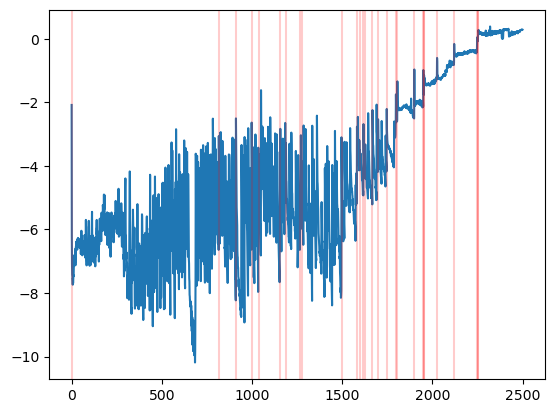

In [313]:
plt.plot(np.arange(len(losses)), losses2)
for i in indx_chng_vars:
    plt.axvline(x=i, color="r", alpha=0.2)

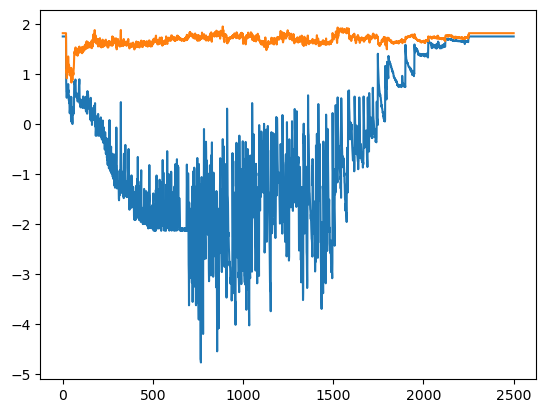

In [314]:
plt.plot(np.arange(len(auc_tr)), np.log(ce_tr))
plt.plot(np.arange(len(auc_te)), np.log(ce_te))

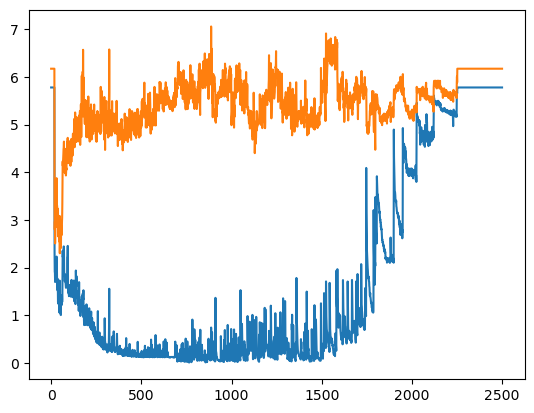

In [315]:
plt.plot(np.arange(len(auc_tr)), np.array(ce_tr))
plt.plot(np.arange(len(auc_te)), np.array(ce_te))

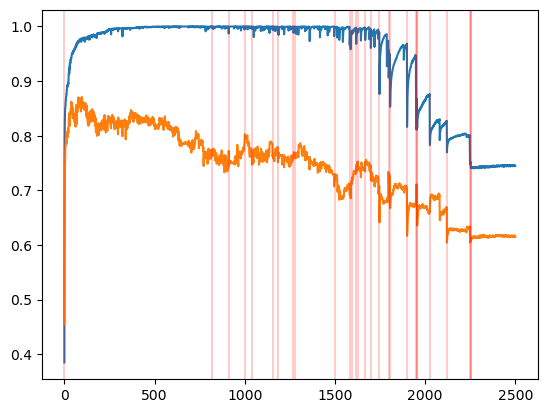

In [316]:
epochs = np.arange(len(auc_tr))
plt.plot(np.arange(len(auc_tr)), np.array(auc_tr))
plt.plot(np.arange(len(auc_te)), np.array(auc_te))
for i in indx_chng_vars:
    plt.axvline(x=i, color="r", alpha=0.2)

In [317]:
repos_res = "/home/emiliano/Documents/ISP/proyectos/causality/AIG/results/"

In [318]:
epochs

array([   0,    1,    2, ..., 2498, 2499, 2500])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


epoch:  1151
num vars:  24
auc tr:  0.999981216265947
auc te:  0.7858777447818546
epoch:  1788
num vars:  12
auc tr:  0.9271009031526004
auc te:  0.6807058998839821


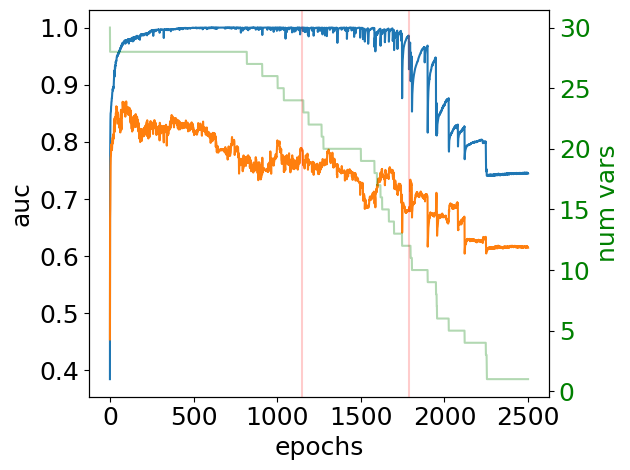

In [433]:
file = "auc_v"+str(version)+".eps"


#interesting_epochs = [931, 1647]
interesting_epochs = [1151, 1788]

fig, ax1 = plt.subplots()

colorBlue = 'tab:blue'
colorOrange = 'tab:orange'
ax1.set_xlabel('epochs', fontsize=18)
ax1.set_ylabel('auc', fontsize=18)
ax1.plot(epochs, np.array(auc_tr), color=colorBlue)
ax1.plot(epochs, np.array(auc_te), color=colorOrange)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num vars', color='g', fontsize=18)  # we already handled the x-label with ax1
ax2.plot(epochs, num_supervarsb, color='g', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='g', labelsize=18)

for i in interesting_epochs:
    print("epoch: ", i)
    plt.axvline(x=i, color="r", alpha=0.2)
    print("num vars: ", num_supervarsb[i])
    print("auc tr: ", auc_tr[i])
    print("auc te: ", auc_te[i])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(repos_res+file, format='eps', dpi=300)
plt.show()




In [434]:
np.array(pvalue1_te)[980]

0.0033728094950638

In [435]:
print(auc_tr[0:5])
auc_te[0:5]

[0.3848658688052012, 0.7687212493866535, 0.818776258893523, 0.8362989910451422, 0.8495875245338567]


[0.45440708454407086,
 0.6659961043522689,
 0.6832178476014092,
 0.7216421326010369,
 0.7575970452682782]

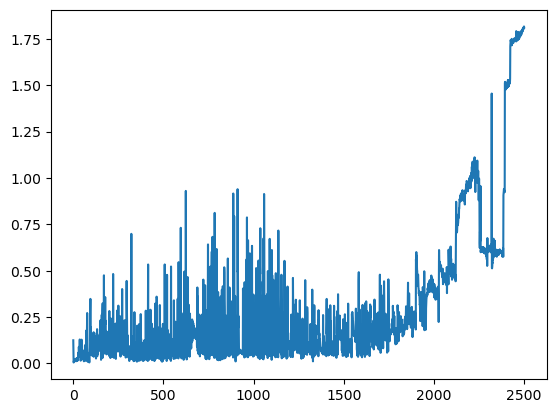

In [436]:
plt.plot(np.arange(len(grad_norm)), np.array(grad_norm))

In [437]:
np.quantile(np.array(grad_norm)[(np.array(grad_norm).shape[0]-51):(np.array(grad_norm).shape[0]-1)], 0.1)

1.7470839200724402

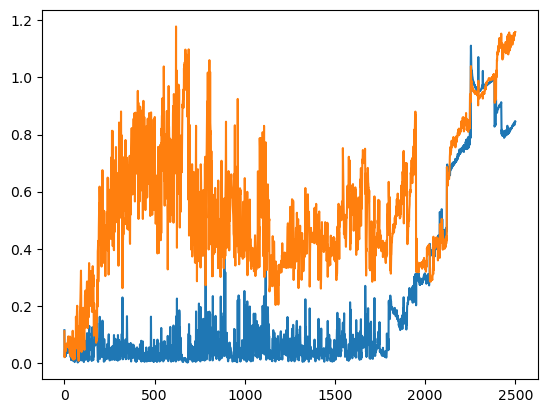

In [438]:
plt.plot(np.arange(len(grad_norm)), np.array(grad_norm_all_tr))
plt.plot(np.arange(len(grad_norm)), np.array(grad_norm_all_te))

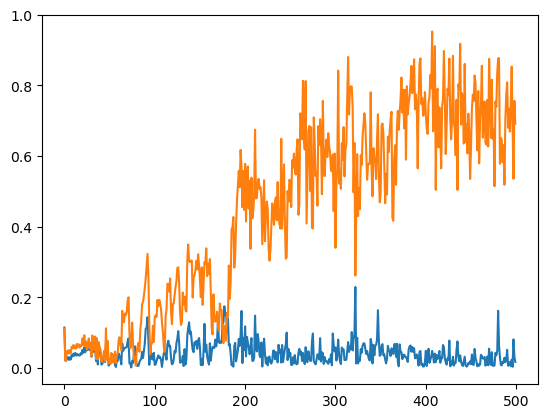

In [439]:
j =500
plt.plot(np.arange(len(grad_norm))[0:j], np.array(grad_norm_all_tr)[0:j])
plt.plot(np.arange(len(grad_norm))[0:j], np.array(grad_norm_all_te)[0:j])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


epoch:  1151
num vars:  24
grad tr:  tensor(0.0078, dtype=torch.float64)
grad te:  tensor(0.3693, dtype=torch.float64)
epoch:  1788
num vars:  12
grad tr:  tensor(0.1030, dtype=torch.float64)
grad te:  tensor(0.4213, dtype=torch.float64)


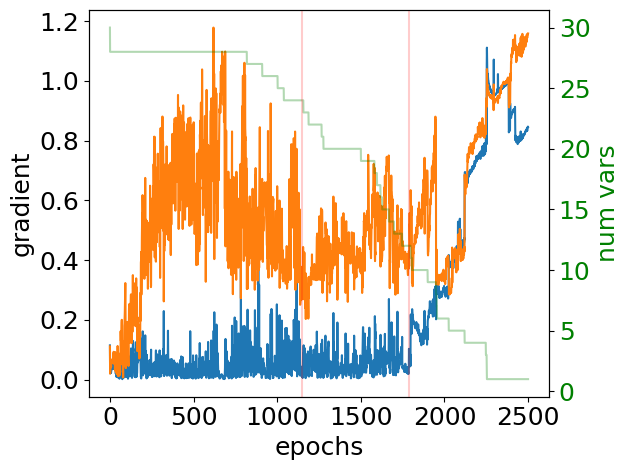

In [440]:
file = "gradient_v"+str(version)+".eps"

fig, ax1 = plt.subplots()

colorBlue = 'tab:blue'
colorOrange = 'tab:orange'
ax1.set_xlabel('epochs', fontsize=18)
ax1.set_ylabel('gradient', fontsize=18)
ax1.plot(epochs, np.array(grad_norm_all_tr), color=colorBlue)
ax1.plot(epochs, np.array(grad_norm_all_te), color=colorOrange)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num vars', color='g', fontsize=18)  # we already handled the x-label with ax1
ax2.plot(epochs, num_supervarsb, color='g', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='g', labelsize=18)

for i in interesting_epochs:
    print("epoch: ", i)
    plt.axvline(x=i, color="r", alpha=0.2)
    print("num vars: ", num_supervarsb[i])
    print("grad tr: ", grad_norm_all_tr[i])
    print("grad te: ", grad_norm_all_te[i])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(repos_res+file, format='eps', dpi=300)
plt.show()



0.9745707260723652
0.5909666343995199


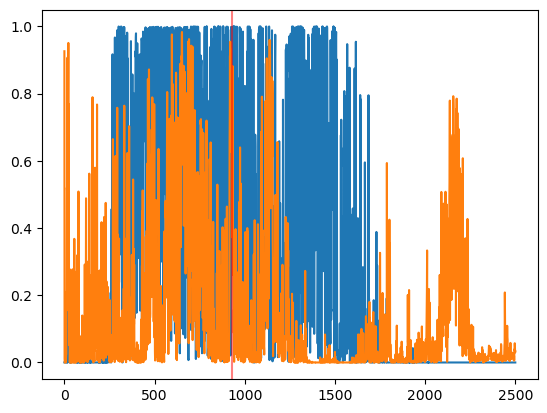

In [441]:
i =  931
plt.plot(np.arange(len(grad_norm)), np.array(pvalue1_tr))
plt.plot(np.arange(len(grad_norm)), np.array(pvalue1_te))
plt.axvline(x=i, color="r", alpha=0.5)
print(np.array(pvalue1_tr)[i])
print(np.array(pvalue1_te)[i])

In [442]:
i = 977
np.array(pvalue1_te)[i]

0.20079514332799198

In [443]:
# 931, 946, 949, 977
for i in range(len(pvalue1_te)):
    print("i: ", i, " pvalue tr: ", np.array(pvalue1_tr)[i], " pvalue te: ", np.array(pvalue1_te)[i])

i:  0  pvalue tr:  0.00013770468790497148  pvalue te:  0.9262895668272882
i:  1  pvalue tr:  4.2127176413941925e-08  pvalue te:  0.011769051589618607
i:  2  pvalue tr:  1.515298997389891e-11  pvalue te:  7.101014418697815e-07
i:  3  pvalue tr:  0.0  pvalue te:  0.0004368468014609439
i:  4  pvalue tr:  3.708144902248023e-14  pvalue te:  1.3590222537329666e-06
i:  5  pvalue tr:  6.765445981216089e-10  pvalue te:  2.659959608131146e-08
i:  6  pvalue tr:  3.306415762183157e-06  pvalue te:  4.63892638746799e-08
i:  7  pvalue tr:  1.4044358257803147e-05  pvalue te:  3.815171175647336e-07
i:  8  pvalue tr:  3.940082487274843e-06  pvalue te:  0.0033645020299905015
i:  9  pvalue tr:  1.5316169110768385e-07  pvalue te:  0.003140828277012453
i:  10  pvalue tr:  2.5839247830283796e-07  pvalue te:  0.022290194101431737
i:  11  pvalue tr:  2.021035073740407e-07  pvalue te:  0.02459400748496232
i:  12  pvalue tr:  3.298320837674673e-05  pvalue te:  0.21000848695263896
i:  13  pvalue tr:  8.9446951090

i:  198  pvalue tr:  0.003476804296464353  pvalue te:  0.0038353295554518496
i:  199  pvalue tr:  1.662161246795968e-05  pvalue te:  0.027830653665066873
i:  200  pvalue tr:  0.00010467539611991317  pvalue te:  0.22192637052461572
i:  201  pvalue tr:  2.7244566132456072e-05  pvalue te:  0.2763314438423127
i:  202  pvalue tr:  6.129981996449985e-07  pvalue te:  0.026445200519316203
i:  203  pvalue tr:  1.2816143812877101e-08  pvalue te:  0.051717340543978474
i:  204  pvalue tr:  6.59035644468009e-06  pvalue te:  0.06193019846992165
i:  205  pvalue tr:  9.820713674502102e-07  pvalue te:  0.013593259904318922
i:  206  pvalue tr:  5.182910212120362e-09  pvalue te:  0.41753950599454925
i:  207  pvalue tr:  6.055226601353603e-06  pvalue te:  0.038479747648421436
i:  208  pvalue tr:  4.7585263251992416e-07  pvalue te:  0.07104143636572446
i:  209  pvalue tr:  4.834710443102352e-07  pvalue te:  0.06580182905784404
i:  210  pvalue tr:  5.814831505190909e-09  pvalue te:  0.2754743122238792
i:  2

i:  368  pvalue tr:  0.2563692328542535  pvalue te:  0.033919262005135065
i:  369  pvalue tr:  0.9563506194291492  pvalue te:  0.163161537374235
i:  370  pvalue tr:  0.2470536389909197  pvalue te:  0.04452610767514109
i:  371  pvalue tr:  0.6949738426943801  pvalue te:  0.054054162222757274
i:  372  pvalue tr:  0.5514613170844223  pvalue te:  0.019403566919745097
i:  373  pvalue tr:  0.1907442744399468  pvalue te:  0.14621230729494228
i:  374  pvalue tr:  0.04837194692936497  pvalue te:  0.32019488894156733
i:  375  pvalue tr:  0.27579146857489756  pvalue te:  0.039616911587644354
i:  376  pvalue tr:  0.5034569263175972  pvalue te:  0.15008240549660878
i:  377  pvalue tr:  0.857301201013221  pvalue te:  0.09417299238733601
i:  378  pvalue tr:  0.1278201544487797  pvalue te:  0.007376296779650793
i:  379  pvalue tr:  0.27976374862768616  pvalue te:  0.014128091468424087
i:  380  pvalue tr:  0.3914689231219012  pvalue te:  0.1019722048457381
i:  381  pvalue tr:  0.10115007903958684  pval

i:  573  pvalue tr:  0.2379692927951227  pvalue te:  0.3397747211142397
i:  574  pvalue tr:  0.9799884580878822  pvalue te:  0.23483232545887056
i:  575  pvalue tr:  0.9837100775859549  pvalue te:  0.1934955315450151
i:  576  pvalue tr:  0.9676340354419353  pvalue te:  0.02514578353687036
i:  577  pvalue tr:  0.9421917863910917  pvalue te:  0.026646088590909556
i:  578  pvalue tr:  0.8427536828006039  pvalue te:  0.14903579028403713
i:  579  pvalue tr:  0.5227680274202781  pvalue te:  0.06692689365412174
i:  580  pvalue tr:  0.9955912245772607  pvalue te:  0.3774923163685475
i:  581  pvalue tr:  0.15613208728055428  pvalue te:  0.40288210714621253
i:  582  pvalue tr:  0.98590033894282  pvalue te:  0.31550530396068743
i:  583  pvalue tr:  0.9594149161260199  pvalue te:  0.7252816358979732
i:  584  pvalue tr:  0.06776133767312353  pvalue te:  0.4708238997890486
i:  585  pvalue tr:  0.9067059937827103  pvalue te:  0.36265437811156587
i:  586  pvalue tr:  0.9412561767562792  pvalue te:  0.

i:  769  pvalue tr:  0.20928166018995698  pvalue te:  0.39497603631301803
i:  770  pvalue tr:  0.8139848030764214  pvalue te:  0.6831437676990382
i:  771  pvalue tr:  0.2581586031406665  pvalue te:  0.529795639289843
i:  772  pvalue tr:  0.1220761444394115  pvalue te:  0.09495079768233383
i:  773  pvalue tr:  0.7116869584735979  pvalue te:  0.15699580760986587
i:  774  pvalue tr:  0.11046459572624223  pvalue te:  0.5606379945275766
i:  775  pvalue tr:  0.07286521808191615  pvalue te:  0.09104084504794607
i:  776  pvalue tr:  0.7645147015905551  pvalue te:  0.02730133251609823
i:  777  pvalue tr:  0.9709891480426703  pvalue te:  0.23661394942084968
i:  778  pvalue tr:  0.9989769961098646  pvalue te:  0.2784899803781966
i:  779  pvalue tr:  0.06399195526195134  pvalue te:  0.49091370174001225
i:  780  pvalue tr:  0.19198334143846219  pvalue te:  0.162549229511604
i:  781  pvalue tr:  0.08605125364864674  pvalue te:  0.12280962654195315
i:  782  pvalue tr:  0.3241901820517751  pvalue te: 

i:  980  pvalue tr:  0.13655353249393465  pvalue te:  0.0033728094950638
i:  981  pvalue tr:  0.4535908412887839  pvalue te:  0.09553182051699927
i:  982  pvalue tr:  0.05313426880614969  pvalue te:  0.016346563195772545
i:  983  pvalue tr:  0.34839041873716337  pvalue te:  0.11153956423888733
i:  984  pvalue tr:  0.9591472038982619  pvalue te:  0.02948434997400562
i:  985  pvalue tr:  0.1895746115681649  pvalue te:  0.05975893889248829
i:  986  pvalue tr:  0.3505278976708185  pvalue te:  0.023869470962932238
i:  987  pvalue tr:  0.41517507246057805  pvalue te:  0.019942977354211355
i:  988  pvalue tr:  0.45086740800914915  pvalue te:  0.044701039752707006
i:  989  pvalue tr:  0.5628129388636367  pvalue te:  0.23956801621987034
i:  990  pvalue tr:  0.984754411666399  pvalue te:  0.04130963481753014
i:  991  pvalue tr:  0.037895381824282426  pvalue te:  0.013556607284240907
i:  992  pvalue tr:  0.24494844548302952  pvalue te:  0.0020743198545751795
i:  993  pvalue tr:  0.259548719476612

i:  1175  pvalue tr:  0.16872467398812763  pvalue te:  0.18846153108286745
i:  1176  pvalue tr:  0.23818525090725484  pvalue te:  0.060862658836318584
i:  1177  pvalue tr:  0.08117926678130494  pvalue te:  0.17999121027135645
i:  1178  pvalue tr:  0.20247379049354663  pvalue te:  0.3686124729287422
i:  1179  pvalue tr:  0.26381415588465673  pvalue te:  0.1936348810842794
i:  1180  pvalue tr:  0.2181207649118282  pvalue te:  0.35023970244314173
i:  1181  pvalue tr:  0.1148404289511934  pvalue te:  0.655868328935675
i:  1182  pvalue tr:  0.08700093542981846  pvalue te:  0.4656893458159872
i:  1183  pvalue tr:  0.2219764346954889  pvalue te:  0.1290417006185155
i:  1184  pvalue tr:  0.015682436588189796  pvalue te:  0.19188118636244045
i:  1185  pvalue tr:  0.11366391879448623  pvalue te:  0.08352365808938678
i:  1186  pvalue tr:  0.3740551208991577  pvalue te:  0.028007626021599563
i:  1187  pvalue tr:  0.06616076454011466  pvalue te:  0.08768193277993364
i:  1188  pvalue tr:  0.15848483

i:  1384  pvalue tr:  0.9995032997074027  pvalue te:  1.0910959467036463e-06
i:  1385  pvalue tr:  0.08528865491789372  pvalue te:  0.00010966308076276743
i:  1386  pvalue tr:  0.7520529953966729  pvalue te:  1.53201673227521e-05
i:  1387  pvalue tr:  0.4869060677047923  pvalue te:  4.795169093352314e-06
i:  1388  pvalue tr:  0.5113118199707514  pvalue te:  0.00011641417898355932
i:  1389  pvalue tr:  0.9994158197695311  pvalue te:  2.1349291133843096e-05
i:  1390  pvalue tr:  0.8353330240246308  pvalue te:  1.8936030522720415e-05
i:  1391  pvalue tr:  0.3833496753529778  pvalue te:  5.046379206175011e-06
i:  1392  pvalue tr:  0.3340046997049667  pvalue te:  0.0006969419966774693
i:  1393  pvalue tr:  0.9994687432564672  pvalue te:  0.0001566048894691141
i:  1394  pvalue tr:  0.9806416430477245  pvalue te:  1.1463846283366053e-07
i:  1395  pvalue tr:  0.9938105731444853  pvalue te:  2.029000837844297e-05
i:  1396  pvalue tr:  0.9234844519953755  pvalue te:  0.00013511330383975118
i:  1

i:  1639  pvalue tr:  0.10110613219947107  pvalue te:  0.00552094146862081
i:  1640  pvalue tr:  0.7958940894149216  pvalue te:  0.04358837828194506
i:  1641  pvalue tr:  0.5378204348468527  pvalue te:  0.0844565726257891
i:  1642  pvalue tr:  0.024643895727975984  pvalue te:  0.0829988103819671
i:  1643  pvalue tr:  0.7829154176230094  pvalue te:  0.043077890517515205
i:  1644  pvalue tr:  0.02767817082593127  pvalue te:  1.1445592415726402e-05
i:  1645  pvalue tr:  0.00032144722829652306  pvalue te:  0.021629893035573833
i:  1646  pvalue tr:  0.0005188283544574901  pvalue te:  0.008663394141444236
i:  1647  pvalue tr:  0.008140636730230022  pvalue te:  0.10003475669676742
i:  1648  pvalue tr:  0.0037081783806056645  pvalue te:  0.0028170742387989556
i:  1649  pvalue tr:  0.00452841361913725  pvalue te:  0.0024296419107073808
i:  1650  pvalue tr:  0.006091062085404775  pvalue te:  0.09165922303112128
i:  1651  pvalue tr:  8.296016390207939e-05  pvalue te:  0.009095866299052902
i:  165

i:  1910  pvalue tr:  2.0772881460517922e-06  pvalue te:  0.02438394486080253
i:  1911  pvalue tr:  4.071520265691575e-05  pvalue te:  0.21558128450545633
i:  1912  pvalue tr:  0.02045673612631238  pvalue te:  0.01982788795573187
i:  1913  pvalue tr:  1.0533280199176431e-06  pvalue te:  0.01730319433577987
i:  1914  pvalue tr:  2.649534840415413e-07  pvalue te:  0.0120567846402575
i:  1915  pvalue tr:  0.000530240702862228  pvalue te:  0.0044399311707061795
i:  1916  pvalue tr:  5.017319574363022e-06  pvalue te:  0.00213888646720628
i:  1917  pvalue tr:  6.057553282312611e-07  pvalue te:  0.00566862846356464
i:  1918  pvalue tr:  1.898863621896396e-09  pvalue te:  0.06625458819722496
i:  1919  pvalue tr:  2.5982870024421345e-06  pvalue te:  0.027843202243722276
i:  1920  pvalue tr:  4.216257143419e-08  pvalue te:  0.06605876709865743
i:  1921  pvalue tr:  2.4228141715099127e-10  pvalue te:  0.04525697427177755
i:  1922  pvalue tr:  4.021938559972682e-09  pvalue te:  0.00225102538560417

i:  2088  pvalue tr:  0.0  pvalue te:  0.0036311182578641077
i:  2089  pvalue tr:  0.0  pvalue te:  0.1626605002349315
i:  2090  pvalue tr:  0.0  pvalue te:  0.507485464757203
i:  2091  pvalue tr:  3.3306690738754696e-16  pvalue te:  0.06711830144686326
i:  2092  pvalue tr:  0.0  pvalue te:  0.03357002431295153
i:  2093  pvalue tr:  0.0  pvalue te:  0.21255459114922715
i:  2094  pvalue tr:  0.0  pvalue te:  0.22046473250944976
i:  2095  pvalue tr:  3.8746783559417963e-14  pvalue te:  0.10358881549781596
i:  2096  pvalue tr:  0.0  pvalue te:  0.27865148674975293
i:  2097  pvalue tr:  1.887379141862766e-14  pvalue te:  0.452220073375729
i:  2098  pvalue tr:  0.0  pvalue te:  0.3835315792960803
i:  2099  pvalue tr:  0.0  pvalue te:  0.10005241367702133
i:  2100  pvalue tr:  0.0  pvalue te:  0.09966387660701237
i:  2101  pvalue tr:  0.0  pvalue te:  0.07837565863138118
i:  2102  pvalue tr:  0.0  pvalue te:  0.472628668787097
i:  2103  pvalue tr:  0.0  pvalue te:  0.390278986037611
i:  2104

i:  2299  pvalue tr:  0.0  pvalue te:  0.006577029835278303
i:  2300  pvalue tr:  0.0  pvalue te:  0.02571990855844386
i:  2301  pvalue tr:  0.0  pvalue te:  0.009933313296956126
i:  2302  pvalue tr:  0.0  pvalue te:  0.010722472709874808
i:  2303  pvalue tr:  0.0  pvalue te:  0.012063667520455068
i:  2304  pvalue tr:  0.0  pvalue te:  0.006402701077032891
i:  2305  pvalue tr:  0.0  pvalue te:  0.013448288888201931
i:  2306  pvalue tr:  0.0  pvalue te:  0.009289934355919738
i:  2307  pvalue tr:  0.0  pvalue te:  0.005855366603248258
i:  2308  pvalue tr:  0.0  pvalue te:  0.01868759060723968
i:  2309  pvalue tr:  0.0  pvalue te:  0.02490370057905933
i:  2310  pvalue tr:  0.0  pvalue te:  0.01375062976031216
i:  2311  pvalue tr:  0.0  pvalue te:  0.01278148230903453
i:  2312  pvalue tr:  0.0  pvalue te:  0.022230884841657694
i:  2313  pvalue tr:  0.0  pvalue te:  0.00970189694057444
i:  2314  pvalue tr:  0.0  pvalue te:  0.012080484116735901
i:  2315  pvalue tr:  0.0  pvalue te:  0.01982

i:  2492  pvalue tr:  0.0  pvalue te:  0.006301970918869193
i:  2493  pvalue tr:  0.0  pvalue te:  0.019692041724361342
i:  2494  pvalue tr:  0.0  pvalue te:  0.006198153296507747
i:  2495  pvalue tr:  0.0  pvalue te:  0.039071810525901696
i:  2496  pvalue tr:  0.0  pvalue te:  0.035329282602300394
i:  2497  pvalue tr:  0.0  pvalue te:  0.057251993793283606
i:  2498  pvalue tr:  0.0  pvalue te:  0.04088771635031796
i:  2499  pvalue tr:  0.0  pvalue te:  0.02970228591463342
i:  2500  pvalue tr:  0.0  pvalue te:  0.03296708317328434


In [444]:
np.array(pvalue1_tr)[np.array(pvalue1_tr)>0]

array([1.37704688e-04, 4.21271764e-08, 1.51529900e-11, ...,
       1.88737914e-14, 2.22044605e-16, 1.11022302e-16])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


epoch:  1151
num vars:  24
pvalue tr:  0.988615823265251
pvalue te:  0.8414553052236479
epoch:  1788
num vars:  12
pvalue tr:  3.820275773502857e-08
pvalue te:  0.593589191125111


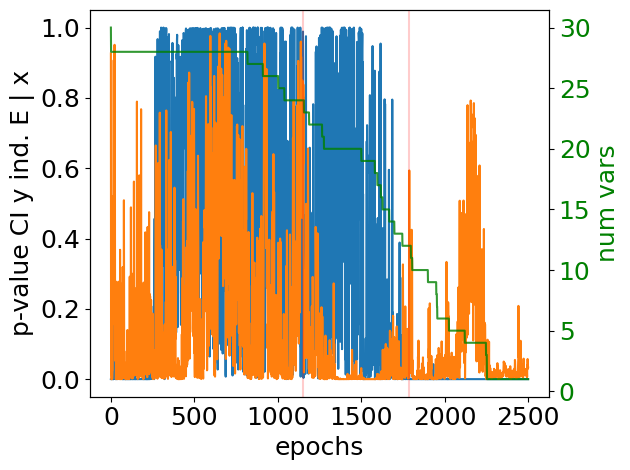

In [445]:
file = "pvalue_v"+str(version)+".eps"

fig, ax1 = plt.subplots()

colorBlue = 'tab:blue'
colorOrange = 'tab:orange'
ax1.set_xlabel('epochs', fontsize=18)
ax1.set_ylabel('p-value CI y ind. E | x', fontsize=18)
ax1.plot(epochs, np.array(pvalue1_tr), color=colorBlue)
ax1.plot(epochs, np.array(pvalue1_te), color=colorOrange)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num vars', color='g', fontsize=18)  # we already handled the x-label with ax1
ax2.plot(epochs, num_supervarsb, color='g', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='g', labelsize=18)

for i in interesting_epochs:
    print("epoch: ", i)
    plt.axvline(x=i, color="r", alpha=0.2)
    print("num vars: ", num_supervarsb[i])
    print("pvalue tr: ", pvalue1_tr[i])
    print("pvalue te: ", pvalue1_te[i])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(repos_res+file, format='eps', dpi=300)
plt.show()



In [446]:
k = 1151
print("num vars",num_supervarsb[k])
print("pvalue", pvalue1_te[k])
print("auc train", auc_tr[k])
print("auc test", auc_te[k])

num vars 24
pvalue 0.8414553052236479
auc train 0.999981216265947
auc test 0.7858777447818546


In [447]:
numSuperVars2

1

In [448]:
ref_value =0.5
numBoots = 50
dist_ref = onp.array([onp.sum(onp.random.uniform(size=numBoots)<ref_value) for i in range(10000)])
pval_tab = onp.array([onp.sum(dist_ref > post)/dist_ref.shape[0] for post in range(0,numBoots+1)])
pval_tab

array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e-01,
       9.999e-01, 9.994e-01, 9.986e-01, 9.961e-01, 9.918e-01, 9.828e-01,
       9.675e-01, 9.405e-01, 8.981e-01, 8.351e-01, 7.617e-01, 6.702e-01,
       5.631e-01, 4.492e-01, 3.375e-01, 2.352e-01, 1.579e-01, 9.840e-02,
       5.900e-02, 3.240e-02, 1.680e-02, 8.500e-03, 3.600e-03, 1.200e-03,
       4.000e-04, 1.000e-04, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00])

In [449]:
len(pvalue1_tr)

2501

In [450]:
np.array(pvalue1_tr)[0:10]

array([1.37704688e-04, 4.21271764e-08, 1.51529900e-11, 0.00000000e+00,
       3.70814490e-14, 6.76544598e-10, 3.30641576e-06, 1.40443583e-05,
       3.94008249e-06, 1.53161691e-07])

In [451]:
i = len(pvalue1_tr)-numBoots-1
print(i)
pvalue1_tr[i+numBoots]

2450


0.0

In [452]:
onp.array(pvalue1_tr)[i:(i+numBoots)]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.22044605e-16, 1.11022302e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [453]:
pval_tab[onp.sum(onp.array(pvalue1_tr)[i:(i+numBoots)]<ref_value)]

0.0

In [454]:
[onp.sum(onp.array(pvalue1_te)[i:(i+numBoots)]<ref_value) for i in range(len(pvalue1_te)-numBoots-1)]

[41,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 43,
 44,
 44,
 45,
 45,
 46,
 47,
 48,
 49,
 49,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 47,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 48,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,


In [455]:
pvalue1_te_sm = [pval_tab[onp.sum(onp.array(pvalue1_te)[i:(i+numBoots)]<ref_value)] for i in range(len(pvalue1_te)-numBoots)]

In [456]:
aux = np.sqrt(-1*np.ones(numBoots//2)).tolist()
pvalue1_te_sm = aux+pvalue1_te_sm+aux

/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [457]:
len(pvalue1_te)

2501

In [458]:
len(pvalue1_te_sm)

2501

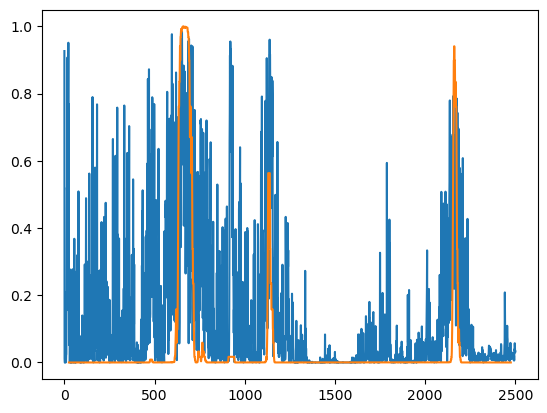

In [459]:
plt.plot(np.arange(len(grad_norm)), np.array(pvalue1_te))
plt.plot(np.arange(len(grad_norm)), np.array(pvalue1_te_sm))

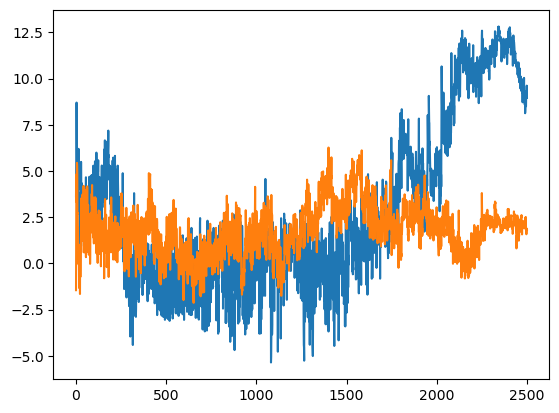

In [460]:
plt.plot(np.arange(len(grad_norm)), np.array(stat1_tr))
plt.plot(np.arange(len(grad_norm)), np.array(stat1_te))

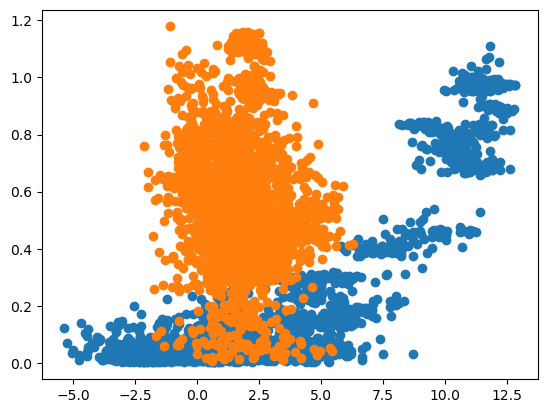

In [461]:
plt.scatter(np.array(stat1_tr), np.array(grad_norm_all_tr))
plt.scatter(np.array(stat1_te), np.array(grad_norm_all_te))

In [462]:
len(num_supervars)

2500

In [463]:
len(grad_norm)

2501

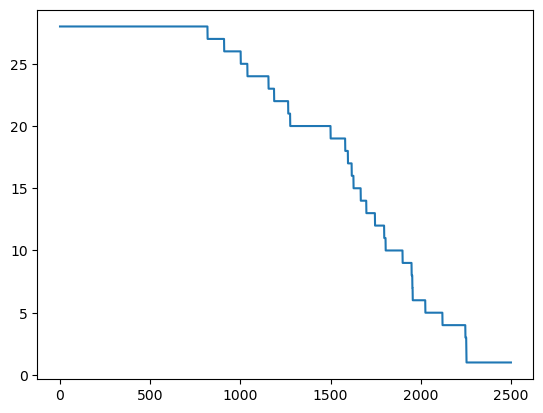

In [464]:
plt.plot(np.arange(len(grad_norm)-1), np.array(num_supervars))


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


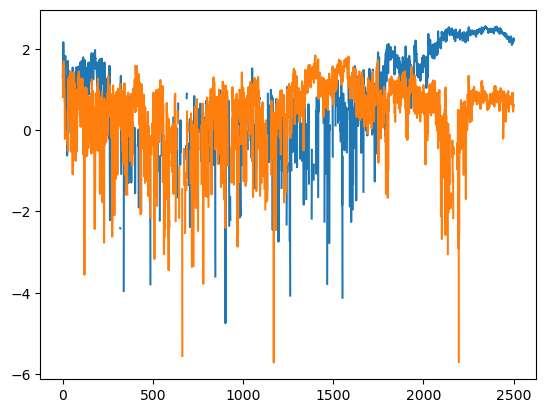

In [465]:
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat1_tr)))
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat1_te)))

In [466]:
stat1_tr

[3.6373950290122607,
 5.35777224942762,
 6.645075949321027,
 8.702273946496025,
 7.4801347936618905,
 6.06096303787974,
 4.505784043813906,
 4.188433035533377,
 4.46841408705571,
 5.119514399016642,
 5.01997391889226,
 5.066965731896297,
 3.9903839624380764,
 4.775912803981176,
 6.198970277917061,
 3.175946121890458,
 3.812358965260332,
 3.109598700493342,
 2.6855441722841107,
 3.057628219742842,
 2.8293601540194815,
 1.0028327794917704,
 2.9846883143826357,
 2.2266972883393708,
 0.5351410288204382,
 2.840957890591827,
 2.8702872101586006,
 2.7375660677304317,
 5.492968745410909,
 3.8800030456664607,
 3.9639360855714183,
 4.173672515061364,
 4.336670104171977,
 3.1949458886363384,
 3.5110520055489167,
 3.1731218119820315,
 2.9766356087693726,
 2.2813412700283755,
 3.8306820300043936,
 3.514158452611922,
 2.391561050718932,
 2.7330535419574824,
 2.821640896732632,
 1.4547217367772227,
 0.9332426030368637,
 2.317871673107407,
 3.15867228413297,
 1.3605968385274885,
 0.6190175647746071,
 

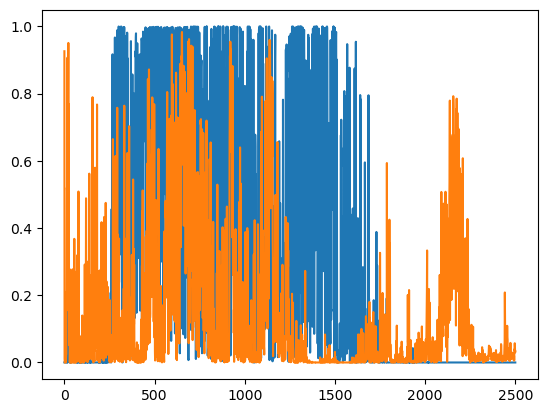

In [467]:
plt.plot(np.arange(len(grad_norm)), np.array(pvalue2_tr))
plt.plot(np.arange(len(grad_norm)), np.array(pvalue2_te))

/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


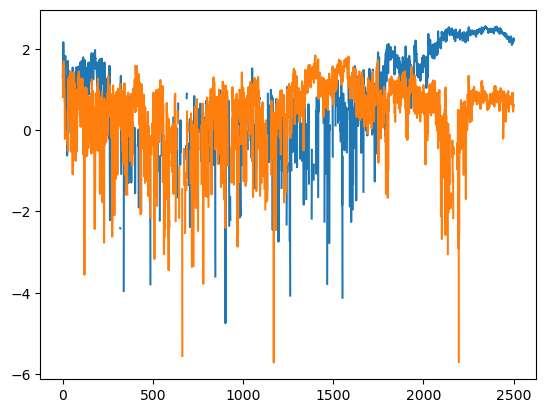

In [468]:
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat2_tr)))
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat2_te)))

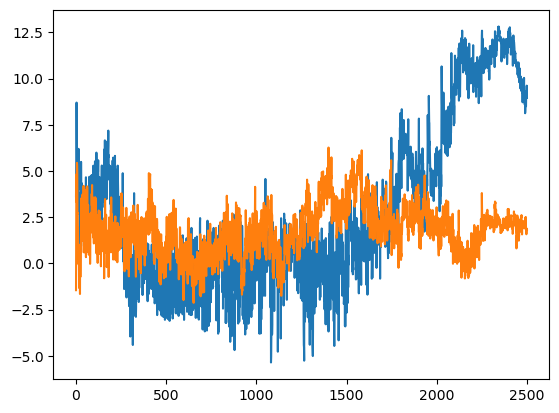

In [469]:
plt.plot(np.arange(len(grad_norm)), np.array(stat2_tr))
plt.plot(np.arange(len(grad_norm)), np.array(stat2_te))

/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


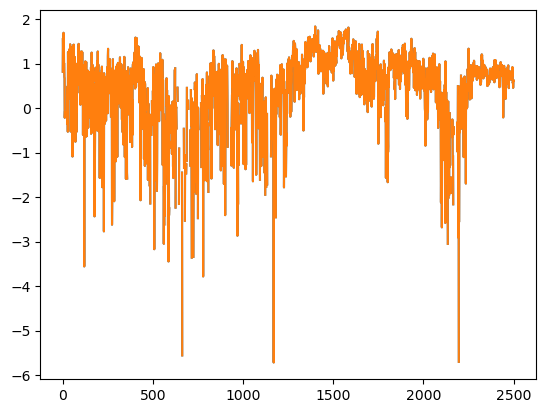

In [470]:
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat1_te)))
plt.plot(np.arange(len(grad_norm)), np.log(np.array(stat2_te)))

In [471]:
#plt.plot(np.arange(len(grad_norm)), np.array(hsics_tr))
#plt.plot(np.arange(len(grad_norm)), np.array(hsics_te))

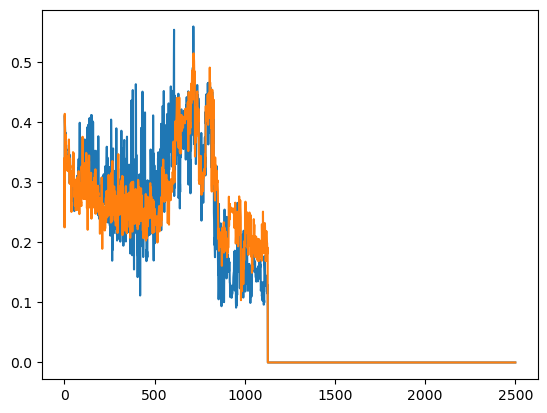

In [472]:
plt.plot(np.arange(Jac_tr2.shape[0]),Jac_tr2[:,3])
plt.plot(np.arange(Jac_te2.shape[0]),Jac_te2[:,3])

In [473]:
np.sum(Jac_te2[99,:]>0)

296

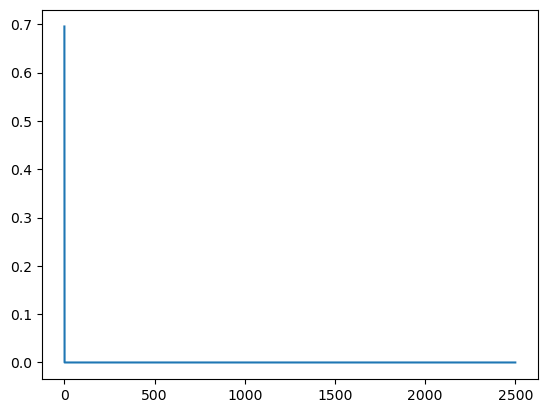

In [474]:
w1c_norm2 = [w1c_norm[i].detach().numpy() for i in range(len(w1c_norm))]
plt.plot(np.arange(len(w1c_norm2)), np.array(w1c_norm2))


In [475]:
w1c_norm2[len(w1c_norm2)-1]

array(0.)

# Did we find a good causal representation?

In [476]:
xs, zs, zs2, zs_E, y_pred, y_true, Envs = getPred(testloader, nn1_input, nn2, nn1_env_adv)

In [477]:
# nfrom zs_E rank the most important variables in a mdoel y = RF(zs2, zs_E)
zs2.shape
zs_E.shape
y_true.shape

(800,)

In [478]:
np.hstack([zs_E, zs2]).shape

(800, 16)

In [479]:
len(varss)

30

In [480]:
len(posts)

29

In [481]:
Jac_te2.shape

(2501, 296)

In [482]:
#Jac_te2[499,:]
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 290, 296])

In [483]:
len(posts)

29

In [484]:
i = 0
print(posts[i])
print(posts[i+1])
#Jac_te2[499, posts[i]:(posts[i+1])]

0
11


In [485]:
i = 0
Jac_te_agg = np.array([[np.sum(Jac_te2[j, posts[i]:(posts[i+1])]) for i in range(len(posts)-1)] for j in range(Jac_te2.shape[0])])
Jac_tr_agg = np.array([[np.sum(Jac_tr2[j, posts[i]:(posts[i+1])]) for i in range(len(posts)-1)] for j in range(Jac_tr2.shape[0])])
Jac_te_agg.shape

(2501, 28)

In [486]:
np.sum(Jac_tr_agg[99,:]>0)

28

In [487]:
Jac_te_agg = np.apply_along_axis(norml, 1, Jac_te_agg)

In [488]:
len(indxIncl)

28

In [489]:
Jac_te_agg_df = pd.DataFrame(Jac_te_agg, columns=np.array(varss)[np.array(indxIncl)])

In [490]:
Jac_te_agg_df["epoch"] = np.arange(Jac_te_agg_df.shape[0])

In [491]:
Jac_te_agg_df = pd.melt(Jac_te_agg_df, id_vars="epoch")

In [492]:
Jac_te_agg_df.head()

,epoch,variable,value
0,0,ch1,0.385618
1,1,ch1,0.134194
2,2,ch1,0.291422
3,3,ch1,0.153520
4,4,ch1,0.069253


In [493]:
Jac_te_agg_df = Jac_te_agg_df.rename(columns={"value":"val"})

In [494]:
Jac_te_agg_df.columns

Index(['epoch', 'variable', 'val'], dtype='object')

<AxesSubplot:xlabel='epoch', ylabel='val'>

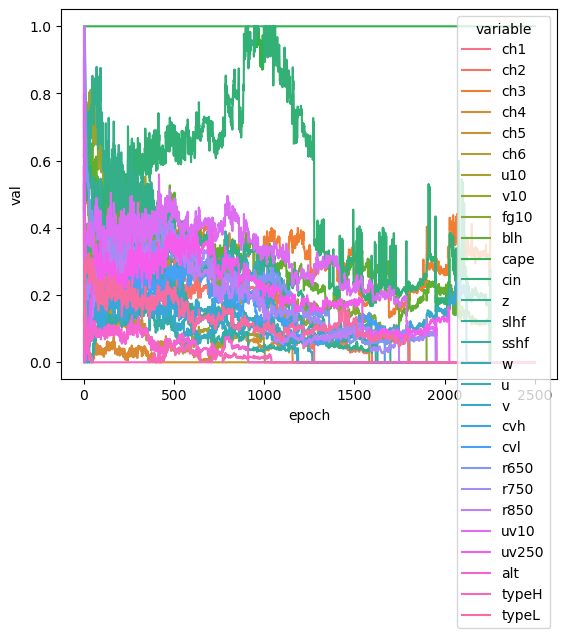

In [495]:
sns.lineplot(data=Jac_te_agg_df, x="epoch", y="val", hue="variable")

<AxesSubplot:xlabel='variable', ylabel='val'>

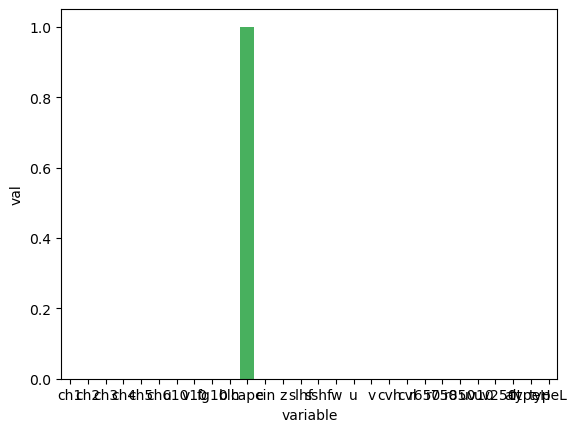

In [496]:
sns.barplot(data=Jac_te_agg_df.loc[Jac_te_agg_df.epoch==(Jac_te_agg.shape[0]-1)], x="variable", y="val")

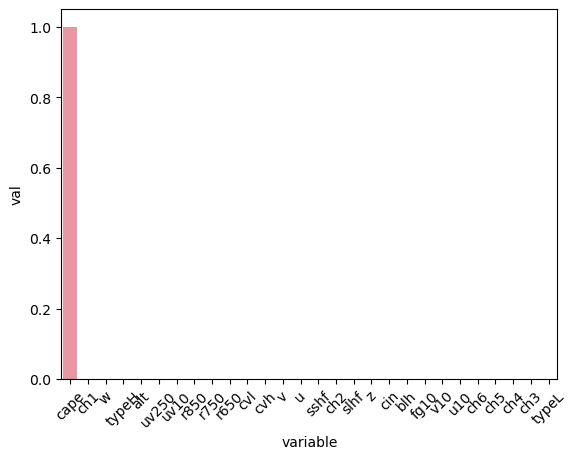

In [497]:
impPlot = sns.barplot(data=Jac_te_agg_df.loc[Jac_te_agg_df.epoch==(Jac_te_agg.shape[0]-1)].sort_values(by="val", ascending=False), x="variable", y="val")
for item in impPlot.get_xticklabels():
    item.set_rotation(45)

In [498]:
Jac_te_agg_df

,epoch,variable,val
0,0,ch1,0.385618
1,1,ch1,0.134194
2,2,ch1,0.291422
3,3,ch1,0.153520
4,4,ch1,0.069253
...,...,...,...
70023,2496,typeL,0.000000
70024,2497,typeL,0.000000
70025,2498,typeL,0.000000
70026,2499,typeL,0.000000


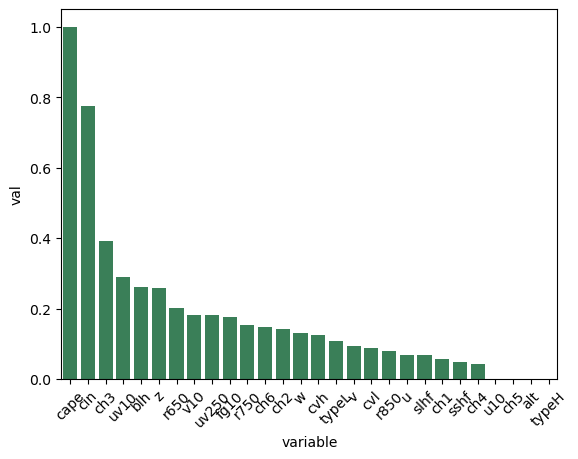

In [499]:
impPlot = sns.barplot(data=Jac_te_agg_df.loc[Jac_te_agg_df.epoch==interesting_epochs[0]].sort_values(by="val", ascending=False), x="variable", y="val", color="seagreen")
for item in impPlot.get_xticklabels():
    item.set_rotation(45)

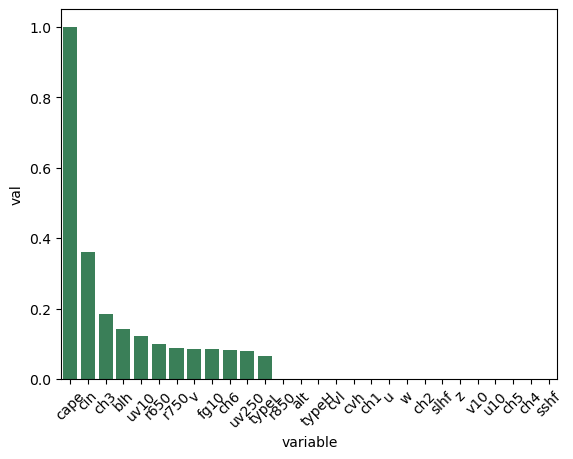

In [500]:
impPlot = sns.barplot(data=Jac_te_agg_df.loc[Jac_te_agg_df.epoch==interesting_epochs[1]].sort_values(by="val", ascending=False), x="variable", y="val", color="seagreen")
for item in impPlot.get_xticklabels():
    item.set_rotation(45)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


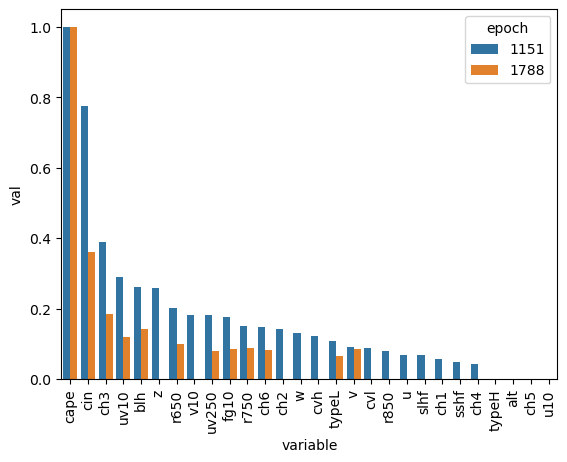

In [501]:
file = "causal_rep_v"+str(version)+".eps"


impPlot = sns.barplot(data=Jac_te_agg_df.loc[Jac_te_agg_df.epoch.isin(interesting_epochs)].sort_values(by="val", ascending=False), x="variable", y="val", hue="epoch")
for item in impPlot.get_xticklabels():
    item.set_rotation(90)
plt.savefig(repos_res+file, format='eps', dpi=300)

In [502]:
Jac_te_agg.shape

(2501, 28)

In [503]:
indx_new,  = np.where(Jac_tr_agg[9,:]!=0)

In [504]:
excl_indx = []

In [505]:
i = 10
for i in range(10, Jac_tr_agg.shape[0]):
    indx_old  = indx_new
    indx_new,  = np.where(Jac_tr_agg[i,:]!=0)
    dif = list(set(indx_old).difference(set(indx_new)))
    if len(dif)>0:
        excl_indx.append(dif)


In [545]:
varsss = np.array(varss)[indxIncl].tolist()
len(varsss)

28

In [546]:
excl_order = np.array(varsss)[np.array(dp.flatten(excl_indx))].tolist()
excl_order

['ch5',
 'alt',
 'u10',
 'typeH',
 'ch4',
 'cvh',
 'sshf',
 'u',
 'ch1',
 'v10',
 'ch2',
 'w',
 'z',
 'cvl',
 'slhf',
 'r850',
 'typeL',
 'ch6',
 'fg10',
 'r750',
 'r650',
 'uv10',
 'uv250',
 'v',
 'blh',
 'ch3',
 'cin']

In [391]:
excl_indx = dp.flatten(excl_indx)
excl_indx

[4,
 25,
 6,
 26,
 3,
 18,
 14,
 16,
 0,
 7,
 1,
 15,
 12,
 19,
 13,
 22,
 27,
 5,
 8,
 21,
 20,
 23,
 24,
 17,
 9,
 2,
 11]

In [392]:
from icp import *

In [393]:
aux = [5,4,3,2,1]
aux.pop(1)
aux

[5, 3, 2, 1]

In [394]:



def applyOrder(cube: np.ndarray, labels:np.ndarray, envVar: np.ndarray, event_df: pd.DataFrame, cluster_var: str, indxIncl: list, posts: np.ndarray, varss: list, indxExcl: list, numTrees: int = 100,
              pvalTest: str = "pval_1tail") -> dict:
    """
    This function implements greedy ICP algorithm by sequentially removing that variable i from the list
    of predictors have not been excluded yet, such that by excluding it we obtain the largest p-value
    for the conditional independence test Y indep E | X\i

    Args:
        cube: n x p matrix with meteorological and geo-stationary featues for each site and time. These features are different statistics of each of 30 met. and geo-st. vars
        labels:  vector indicating whether a pyroCb occurred or not 6 hours after corresponding cube observation
        envVar: matrix with the features that define the E variable in ICP. If given will also be included in RF model.
        event_df: ancillary information for each observation including date, location, random and spatial clusters for CV, etc
        cluster_var: one of 'cluster_random' or 'cluster_regional' indicates whether CV is random or spatial
        indxIncl: indices of features to be used. Could refer to raw variables or statistics
        posts: if indxIncl is given with respect to raw met. and geo. vars then posts include the indices where the statistics of each var begin and end
        varss: list of strings denoting the geostationary and meteorological variables in the cube
        numTrees: the number of trees to use for each RF model
        pvalTest: string indicating if the pvalue should be 1-tailed ('pval_1tail') or 2-tailed ("pval_2tail')

    Returns:
        A dictionary with the sequences of excluded variable (as indices of the varss list),
        , corresponding p-values an aucs (for full and restricted RF models)
    """
    
    indxPvals = []
    aucs_E = []
    aucs_noE = []
    
    indxIncl2 = indxIncl.copy()
    
    res = getHypWrapper(cube, labels, envVar, event_df, cluster_var, indxIncl, posts, numTrees=numTrees)
    print(res)

    
    while len(indxExcl)>0:
        
       
        
        # index as a function of original indices
        exclude_indx = indxExcl.pop(0)
        
        print("indxIncl2",indxIncl2)
        print("exclude_indx", exclude_indx)
        
        # index as a function of indices that are left
        exclude_indx2,  = np.where(np.array(indxIncl2)==exclude_indx)
        exclude_indx2 = exclude_indx2[0]
        
        print("exclude_indx2: ", exclude_indx2)
        
        print("num left: ", len(indxIncl))
        hyp = exclude_i(cube, labels, envVar, event_df, cluster_var, indxIncl2, posts, exclude_indx, numTrees=numTrees) 
        indxIncl2.pop(exclude_indx2)
        
       
        
        auc_E = hyp["auc_E"]
        auc_noE = hyp["auc_noE"]
        pval = hyp[pvalTest]
        print(" exclude var: ", varss[exclude_indx], " pval: ", pval, " auc_noE: ", auc_noE, " auc_E: ", auc_E)
        indxPvals.append(pval)
        aucs_E.append(auc_E)
        aucs_noE.append(auc_noE)
        #print("exclude_indx: ", exclude_indx)
        #print("indxIncl2 : ", indxIncl2)
    
        
    indxPvals.append(np.nan)
    
    aucs_E.append(0)
    aucs_noE.append(0)
    
    res =  {"indxVar":indxExcl, "pval":indxPvals, "auc_E":aucs_E, "auc_noE":aucs_noE}
    return res

In [395]:
len(indxIncl)

28

In [396]:
np.array(indxIncl)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29])

In [397]:
np.array(excl_indx)

array([ 4, 25,  6, 26,  3, 18, 14, 16,  0,  7,  1, 15, 12, 19, 13, 22, 27,
        5,  8, 21, 20, 23, 24, 17,  9,  2, 11])

In [398]:
len(posts)

29

In [399]:
np.array(dp.flatten([np.arange(posts[i], posts[i+1]).tolist() for i in indxIncl]))

IndexError: index 29 is out of bounds for axis 0 with size 29

In [ ]:
# greedy-ICP order
ordVars_ICP = ['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt']

In [ ]:
i = 0
excl_indx_ICP = [np.where(ordVars_ICP[i] == np.array(varss)) for i in range(len(ordVars_ICP))]
excl_indx_ICP = [int(excl_indx_ICP[i][0]) for i in range(len(excl_indx_ICP))]
excl_indx_ICP

In [ ]:
np.sqrt(-1)

In [ ]:
cluster_var = "cluster_random"
res = applyOrder(cube, labs, envVars[:,0:3], event_df, cluster_var, indxIncl, posts, varss, excl_indx_ICP, numTrees = 100,pvalTest="pval_1tail")

In [ ]:
#res = greedyICP(cube, labels, envVars[:,0:3], event_df, cluster_var, indxIncl, posts, varss, numTrees=100, pvalTest="pval_1tail")

In [ ]:
labs.shape

In [ ]:
indxExcl

# What environment was estimated?

In [526]:
xs, zs, zs2, zs_E, y_pred, y_true, Envs = getPred(traintestloader, nn1_input, nn2, nn1_env_adv)

In [527]:
zs_E.shape

(6919, 10)

In [528]:
event_df.shape

(6919, 17)

In [529]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=2))
pca_pipe.fit(zs_E)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.99212574 0.00769894]


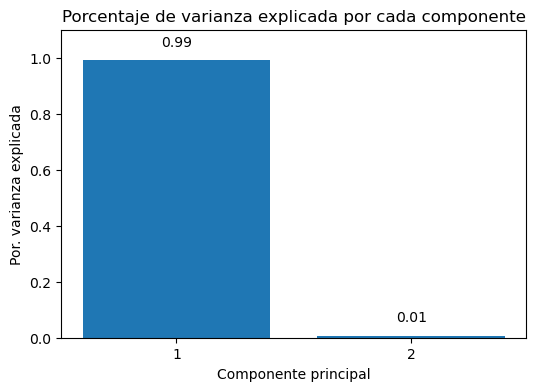

In [530]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(zs_E.shape[1]) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [531]:
modelo_pca.components_.shape

(2, 10)

In [532]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X=zs_E)


In [533]:
proyecciones.shape

(6919, 2)

In [534]:
proyecciones

array([[-1.28635794, -0.06036662],
       [-1.28635794, -0.06036662],
       [-1.28635794, -0.06036662],
       ...,
       [-1.18160415,  0.0295686 ],
       [-1.18160415,  0.0295686 ],
       [-1.18160415,  0.0295686 ]])

In [535]:
event_df

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random,red_flag_now,weight,PCA1,PCA2
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN,1.019830,1.283051
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN,1.019830,1.283051
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,pyrocb,NaN,1.019830,1.283051
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,3,0,deep conv,NaN,1.019830,1.283051
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,3,0,deep conv,NaN,1.019725,1.282522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6914,77,77_3,1,False,77,21929910,146.998414,-37.308686,2019.156164,2019.0,0.0,0,5,none,NaN,1.038110,1.377671
6915,77,77_3,1,False,77,21929910,146.998414,-37.308686,2019.156164,2019.0,0.0,0,5,none,NaN,1.038110,1.377671
6916,77,77_3,1,False,77,21929910,146.998414,-37.308686,2019.158904,2019.0,0.0,0,5,none,NaN,1.038006,1.377142
6917,77,77_3,1,False,77,21929910,146.998414,-37.308686,2019.158904,2019.0,0.0,0,5,none,NaN,1.038006,1.377142


/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='lon', ylabel='lat'>

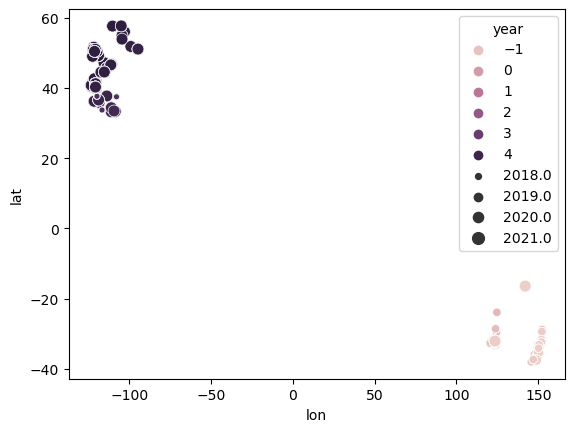

In [536]:
sns.scatterplot(event_df.lon, event_df.lat, hue=proyecciones[:,0], size=event_df.year)

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='lon', ylabel='lat'>

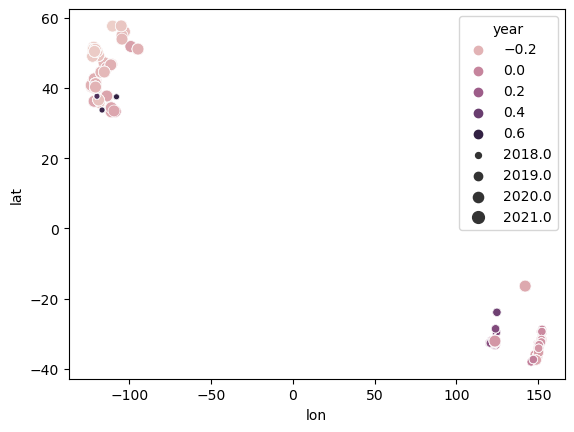

In [537]:
sns.scatterplot(event_df.lon, event_df.lat, hue=proyecciones[:,1], size=event_df.year)

In [538]:
proyecciones2 = np.apply_along_axis(norml, 0, proyecciones)+1
np.max(proyecciones2[:,0])

2.0

In [539]:
event_df[["PCA1","PCA2"]] = proyecciones2

In [540]:
event_df["location"] = "Australia"
event_df["location"].loc[event_df.sat==1] = "North America" 
np.unique(event_df.location, return_counts=True)

/home/emiliano/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(array(['Australia', 'North America'], dtype=object), array([5326, 1593]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


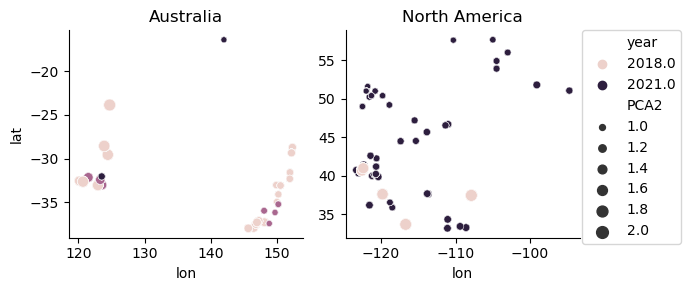

In [541]:
file = "env_rep_pca2_v"+str(version)+".eps"

g = sns.FacetGrid(event_df, col="location", sharex=False, sharey=False)
g.map(sns.scatterplot, "lon", "lat","year","PCA2")
g.set_titles(col_template="{col_name}",size=12)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
g.savefig(repos_res+file, format='eps', dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


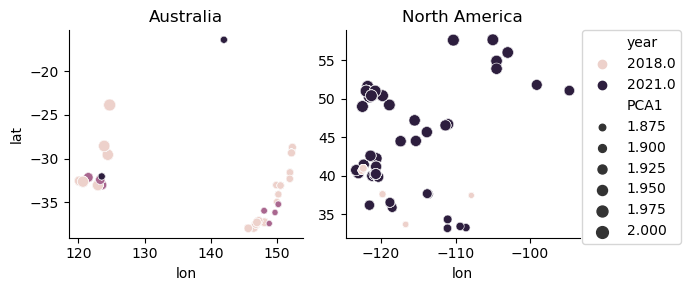

In [542]:
file = "env_rep_pca1_v"+str(version)+".eps"
g = sns.FacetGrid(event_df, col="location", sharex=False, sharey=False)
g.map(sns.scatterplot, "lon", "lat", "year", "PCA1")
g.set_titles(col_template="{col_name}",size=12)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
g.savefig(repos_res+file, format='eps', dpi=300)

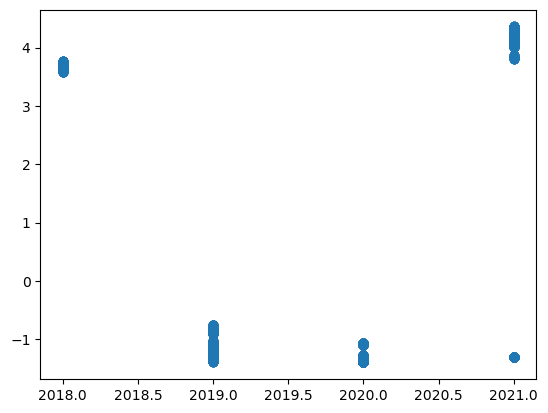

In [522]:
plt.scatter(event_df.year, proyecciones[:,0])

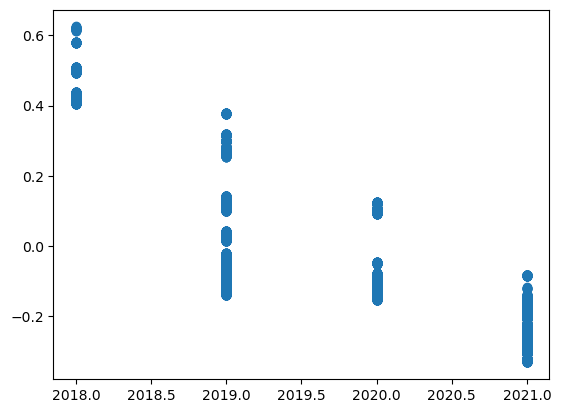

In [523]:
plt.scatter(event_df.year, proyecciones[:,1])

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

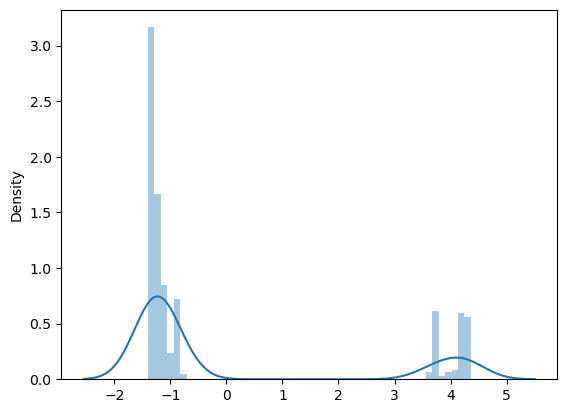

In [524]:
sns.distplot(proyecciones[:,0])

In [525]:
np.unique(event_df.sat, return_counts=True)

(array([0., 1.]), array([5326, 1593]))

In [ ]:
indx_0, = np.where(event_df.sat==0)
indx_1, = np.where(event_df.sat==1)
proyecciones[indx_0,0]

In [ ]:
sns.distplot(proyecciones[indx_0,0])
sns.distplot(proyecciones[indx_1,0])

In [ ]:
sns.distplot(proyecciones[indx_0,1])
sns.distplot(proyecciones[indx_1,1])

In [ ]:
sns.scatterplot(proyecciones[:,0], proyecciones[:,1], hue=event_df.location, size=event_df.year)

In [ ]:
sns.scatterplot(proyecciones[:,0], proyecciones[:,1], hue=event_df.cluster_random==3, size=event_df.year)

In [ ]:
event_df

In [ ]:
#Latitude and longitude of Australia is 25.0000 degrees S and 135.0000 degrees E.
# Australia
print("longitude",np.mean(event_df.loc[event_df.sat.isin([0])].lon))
print("latitude", np.mean(event_df.loc[event_df.sat.isin([0])].lat))

In [ ]:
# North America
print("longitude",np.mean(event_df.loc[event_df.sat.isin([1])].lon))
print("latitude",np.mean(event_df.loc[event_df.sat.isin([1])].lat))

In [ ]:
np.mean(event_df.loc[event_df.sat.isin([0])].lon )

In [ ]:
np.mean(event_df.loc[event_df.sat.isin([0])].lat)